In [1]:
#Multivariate Analysis
#Restricted Cubic Split - 4 knots

#Import libraries
library(ggpubr)
library(dplyr)
library(lme4)
library(ggplot2)
library(rms)
library(mgcv)
library(tidymv)
library("ggthemes")
library(broom)
#library(erer)
library(stringr)
library(tidyverse)
library(stringr)
library(R.utils)
library(data.table)
library(ggsci)
library(broom)
library(mgcv)
library(mgcViz)

Loading required package: ggplot2


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: Matrix

Loading required package: Hmisc

Loading required package: lattice

Loading required package: survival

Loading required package: Formula


Attaching package: ‘Hmisc’


The following objects are masked from ‘package:dplyr’:

    src, summarize


The following objects are masked from ‘package:base’:

    format.pval, units


Loading required package: SparseM


Attaching package: ‘SparseM’


The following object is masked from ‘package:base’:

    backsolve


Loading required package: nlme


Attaching package: ‘nlme’


The following object is masked from ‘package:lme4’:

    lmList


The following object is masked from ‘package:dplyr’:

    collapse


This is mgcv 1.8-40. For overview type 'help("mgcv-package")'.

── Attac

In [2]:
#Restricted analysis (only)

#Read the complete set (no imputation)
UKBB_AG2_m <- fread("~/jupyter/UKBB_AG2_12Jan21.txt", header = TRUE, na.strings=c("",".","NA")) %>% select(f.eid,T2D_status,ALBUMINERIA.0.0,
                                 ESKD.0.0,CKD.0.0,DN.0.0,ALL.0.0,NONESKD.0.0,DNCKD.0.0,
                                 CTRL_DNCKD.0.0,ACR.0.0,EGFR.0.0,URN_ALBUMIN_FLAG.0.0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,SEX.0.0,
                                 IDEAL_DIET2.0.0,LIFESCORE,AGE.0.0, SES_TDI.0.0,BMI.0.0,EDUYEARS,SBP.0.0,HYP_POS1,STATIN,
                                 WHR.0.0,GRS_WT_IR,GRS_WT_T2DIR,T2D.0.0,
                                 GRS_WT_LIRd2,GRS_WT_LIRt,GRS_WT_LIRq,GRS_WT_LIRf3,GRS_WT_IRd2,
                                 GRS_WT_IRt,GRS_WT_IRq,GRS_WT_IRf3,GRS_WT_IR53d2,GRS_WT_IR53t,
                                 GRS_WT_IR53q,GRS_WT_IR53f3,GRS_WT_T2DIRd2,GRS_WT_T2DIRt,
                                 GRS_WT_T2DIRq,GRS_WT_T2DIRf3,GRS_WT_L5E8IRd2,GRS_WT_L5E8IRt,
                                 GRS_WT_L5E8IRq,GRS_WT_L5E8IRf3,GRS_WT_L1E5IRd2,GRS_WT_L1E5IRt,
                                 GRS_WT_L1E5IRq,GRS_WT_L1E5IRf3)
UKBB_AG2=as.data.frame(UKBB_AG2_m)
dim(UKBB_AG2)
rm(UKBB_AG2_m)

[1] 373487     61

In [3]:
#Dichotomize Outcomes for Logistic Regression

#1_CKD
UKBB_AG2$CKD_only.0.0 <- factor(ifelse(UKBB_AG2$CKD.0.0=="CKD controls","CKD controls",
                              ifelse(UKBB_AG2$CKD.0.0=="CKD","CKD",NA)),
                levels = c("CKD controls", "CKD"))
#Set the refernece
UKBB_AG2$CKD_only.0.0 <- relevel(UKBB_AG2$CKD_only.0.0, ref = "CKD controls")

#2_CKD Extreme
UKBB_AG2$CKD_ex.0.0 <- factor(ifelse(UKBB_AG2$CKD.0.0=="CKD controls","CKD controls",
                              ifelse(UKBB_AG2$CKD.0.0=="CKD extreme","CKD extreme",NA)),
                levels = c("CKD controls", "CKD extreme"))
#Set the refernece
UKBB_AG2$CKD_ex.0.0 <- relevel(UKBB_AG2$CKD_ex.0.0, ref = "CKD controls")

#3_Micro
UKBB_AG2$micro.0.0 <- factor(ifelse(UKBB_AG2$ALBUMINERIA.0.0=="micro","micro",
                              ifelse(UKBB_AG2$ALBUMINERIA.0.0=="normo","normo",NA)),
                levels = c("normo", "micro"))
#Set the reference
UKBB_AG2$micro.0.0 <- relevel(UKBB_AG2$micro.0.0, ref = "normo")

#4_Macro
UKBB_AG2$macro.0.0 <- factor(ifelse(UKBB_AG2$ALBUMINERIA.0.0=="macro","macro",
                              ifelse(UKBB_AG2$ALBUMINERIA.0.0=="normo","normo",NA)),
                levels = c("normo", "macro"))
#Set the reference
UKBB_AG2$macro.0.0 <- relevel(UKBB_AG2$macro.0.0, ref = "normo")

#5_Macro
UKBB_AG2$macro.0.0 <- factor(ifelse(UKBB_AG2$ALBUMINERIA.0.0=="macro","macro",
                              ifelse(UKBB_AG2$ALBUMINERIA.0.0=="normo","normo",NA)),
                levels = c("normo", "macro"))

#6_ESKD vs. Macro
UKBB_AG2$ESKD_macro.0.0 <- factor(ifelse(UKBB_AG2$ESKD.0.0=="yes","ESKD",
                              ifelse(UKBB_AG2$ALBUMINERIA.0.0=="macro","macro",NA)),
                levels = c("macro","ESKD"))

#7_DNCKD vs. Control DNCKD
UKBB_AG2$DNCKD2.0.0 <- factor(ifelse(UKBB_AG2$DNCKD.0.0=="yes","DNCKD",
                              ifelse(UKBB_AG2$CTRL_DNCKD.0.0=="yes","DNCKD Control",NA)),
                levels = c("DNCKD Control","DNCKD"))

#8_ESKD vs. Normo, Macro, Micro
UKBB_AG2$ESKD_Albu.0.0 <- factor(ifelse(UKBB_AG2$ESKD.0.0=="yes","ESKD",
                              ifelse(UKBB_AG2$ALBUMINERIA.0.0 %in% c("normo","macro","micro"),"albu",NA)),
                levels = c("albu","ESKD"))

#Set the reference
UKBB_AG2$macro.0.0 <- relevel(UKBB_AG2$macro.0.0, ref = "normo")

#Summarize Counts of Disease Outcomes
table(UKBB_AG2$CKD_only.0.0) #1
table(UKBB_AG2$CKD_ex.0.0) #2
table(UKBB_AG2$micro.0.0) #3
table(UKBB_AG2$macro.0.0) #4
table(UKBB_AG2$ESKD.0.0) #5
table(UKBB_AG2$DN.0.0) #6
table(UKBB_AG2$ALL.0.0) #7
table(UKBB_AG2$ESKD.0.0) #8
table(UKBB_AG2$ESKD_macro.0.0) #8
table(UKBB_AG2$ESKD_Albu.0.0) #9
table(UKBB_AG2$DNCKD2.0.0) #10


CKD controls          CKD 
      349669         6108 


CKD controls  CKD extreme 
      349669          984 


 normo  micro 
348496  14070 


 normo  macro 
348496   1120 


    no    yes 
356332    447 


    no    yes 
345597   1469 


    no    yes 
332345  15439 


    no    yes 
356332    447 


macro  ESKD 
  963   447 


  albu   ESKD 
346560    447 


DNCKD Control         DNCKD 
       326513           645 

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max.     NA's 
    1.74     5.76     9.17    26.05    17.71 10154.49   261777 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  2.895  83.227  92.930  90.985  99.989 217.806   16726 

[1] "UACR, Distribution before Transformation"


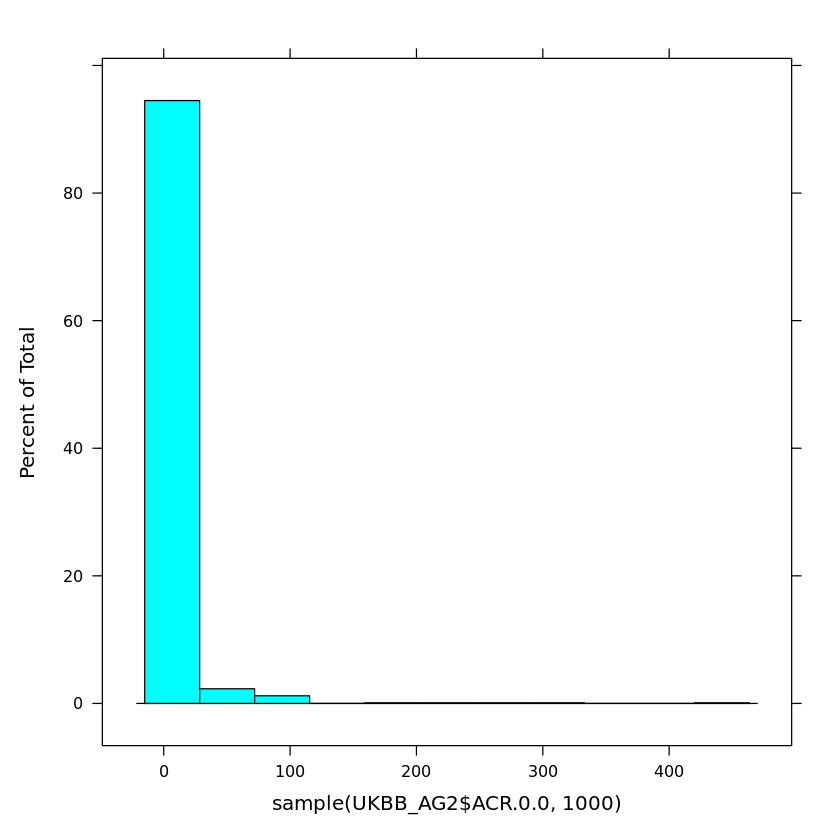

[1] "Inverse Normal Transformation, ACR"


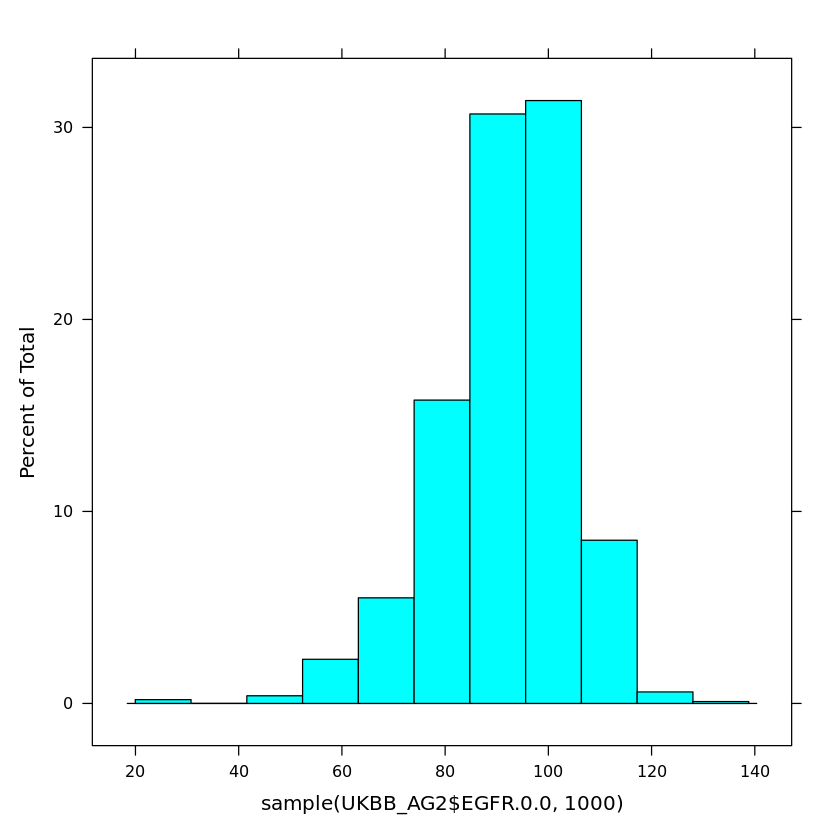

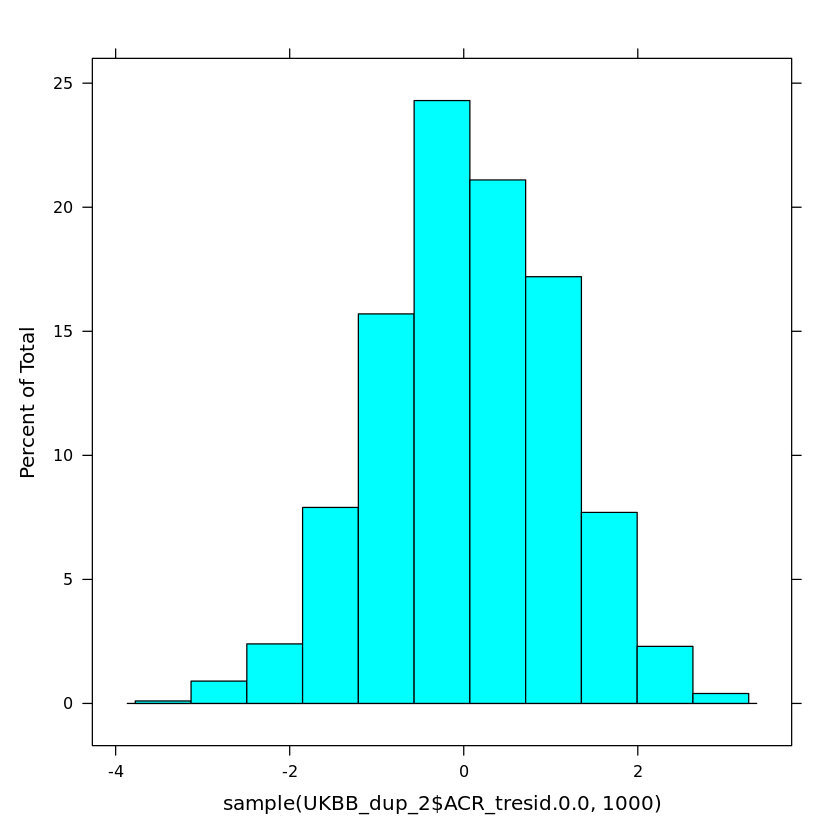

[1] 373487     68

[1] 373487     70

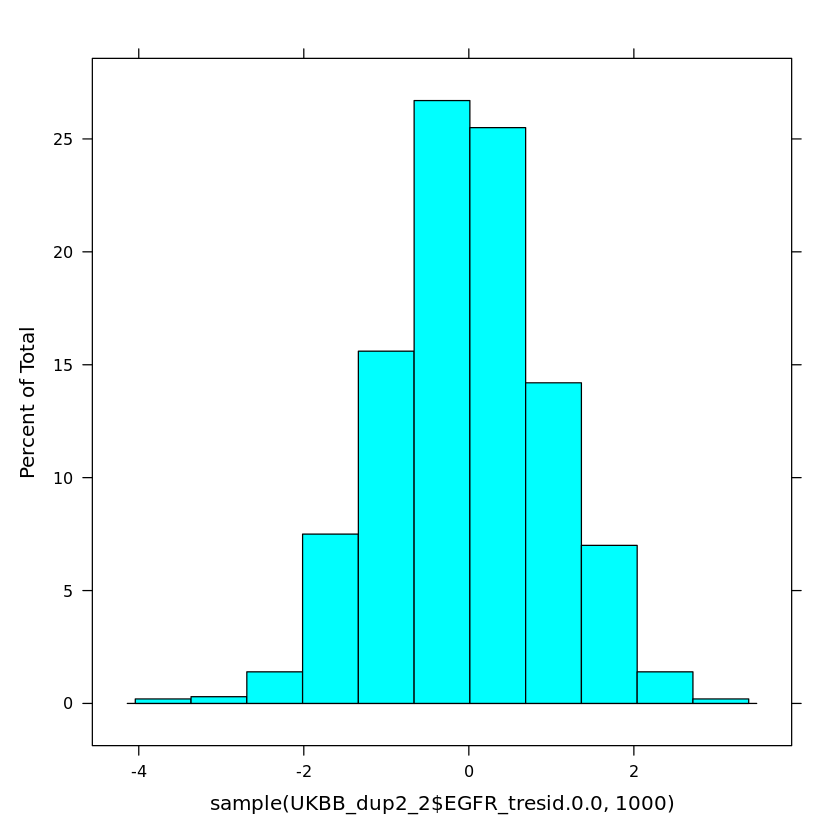

In [4]:
UKBB_AG2$GRS_WT_IRf3 <- factor(UKBB_AG2$GRS_WT_IRf3)
UKBB_AG2$GRS_WT_IRf3 <- relevel(UKBB_AG2$GRS_WT_IRf3,'low risk')
UKBB_AG2$GRS_WT_T2DIRf3 <- factor(UKBB_AG2$GRS_WT_T2DIRf3)
UKBB_AG2$GRS_WT_T2DIRf3 <- relevel(UKBB_AG2$GRS_WT_T2DIRf3,'low risk')
summary(UKBB_AG2$ACR.0.0)
summary(UKBB_AG2$EGFR.0.0)

#ACR - replace undetected with the lowest limit of detection
UKBB_AG2$ACR.0.0 <- ifelse(is.na(UKBB_AG2$ACR.0.0) & UKBB_AG2$URN_ALBUMIN_FLAG.0.0=='<6.7',6.7,UKBB_AG2$ACR.0.0)
print('UACR, Distribution before Transformation')
histogram(sample(UKBB_AG2$ACR.0.0,1000))
histogram(sample(UKBB_AG2$EGFR.0.0,1000))
#Inverse normal transformed age-adjusted, sex-adjusted residuals of log-transformed UACR
#complete cases
UKBB_dup <- UKBB_AG2 %>% select(f.eid,ACR.0.0,AGE.0.0,SEX.0.0)
UKBB_dup <- UKBB_dup[complete.cases(UKBB_dup),]
rx.out <- lm(ACR.0.0~AGE.0.0 + SEX.0.0, data=UKBB_dup)
#duplicate cases
UKBB_dup2 <- UKBB_AG2 %>% select(f.eid,EGFR.0.0,AGE.0.0,SEX.0.0)
UKBB_dup2 <- UKBB_dup2[complete.cases(UKBB_dup2),]
rx.out2 <- lm(EGFR.0.0~AGE.0.0 + SEX.0.0, data=UKBB_dup2)
# generating file with residuals (ACR)
residx <- as.data.frame(residuals(rx.out))
trans_resid <- as.data.frame(qnorm((rank(residx,na.last="keep")-0.5)/sum(!is.na(residx))))
names(trans_resid) <- 'ACR_tresid.0.0'
UKBB_dup_2 <- cbind(UKBB_dup, trans_resid)
#generating file with residuals (eGFR)
residx2 <- as.data.frame(residuals(rx.out2))
trans_resid2 <- as.data.frame(qnorm((rank(residx2,na.last="keep")-0.5)/sum(!is.na(residx2))))
names(trans_resid2) <- 'EGFR_tresid.0.0'
UKBB_dup2_2 <- cbind(UKBB_dup2, trans_resid2)
#drop additional covariates
UKBB_dup_2 <- subset(UKBB_dup_2, select = c(f.eid,ACR_tresid.0.0))
print('Inverse Normal Transformation, ACR')
histogram(sample(UKBB_dup_2$ACR_tresid.0.0,1000))
UKBB_dup2_2 <- subset(UKBB_dup2_2, select = c(f.eid,EGFR_tresid.0.0))
histogram(sample(UKBB_dup2_2$EGFR_tresid.0.0,1000))
#merge transformed residuals back
dim(UKBB_AG2)
UKBB_AG2 <- left_join(UKBB_AG2,UKBB_dup_2,by='f.eid')
UKBB_AG2 <- left_join(UKBB_AG2,UKBB_dup2_2,by='f.eid')
dim(UKBB_AG2)
#T2D-stratified samples
T2D <- UKBB_AG2 %>% filter(T2D_status==1)
ND <- UKBB_AG2 %>% filter(T2D_status==0)
#remove extra datasets
rm(UKBB_dup)
rm(UKBB_dup2)
rm(UKBB_dup_2)
rm(UKBB_dup2_2)

In [5]:
summary(UKBB_AG2$GRS_WT_IR)
quantile(UKBB_AG2$GRS_WT_IR, probs = c(0.10,0.12,0.15,0.20,0.21,0.22,0.23,0.25))
summary(T2D$GRS_WT_IR)
summary(ND$GRS_WT_IR)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0540  0.2034  0.2292  0.2294  0.2553  0.4140 

10%       12%       15%       20%       21%       22%       23%       25% 
0.1802000 0.1842823 0.1896000 0.1970000 0.1983176 0.1996313 0.2009246 0.2034000

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.1016  0.2082  0.2344  0.2342  0.2598  0.3830 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0540  0.2032  0.2289  0.2291  0.2550  0.4140 

In [6]:
ddist <- datadist(UKBB_AG2[,c('ACR_tresid.0.0','EGFR_tresid.0.0','AGE.0.0','GRS_WT_IR','SEX.0.0','PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10',
                             'GRS_WT_T2DIR','EDUYEARS','SES_TDI.0.0','BMI.0.0','HYP_POS1','STATIN','T2D_status')])
options (datadist ="ddist")


Family: gaussian 
Link function: identity 

Formula:
EGFR_tresid.0.0 ~ GRS_WT_IR + AGE.0.0 + SEX.0.0 + PC1 + PC2 + 
    PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10

Parametric coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.590702   0.092039  17.283  < 2e-16 ***
GRS_WT_IR   -0.205667   0.218914  -0.939  0.34749    
AGE.0.0     -0.022926   0.001239 -18.506  < 2e-16 ***
SEX.0.0Male  0.055484   0.017243   3.218  0.00129 ** 
PC1         -1.321939   0.488540  -2.706  0.00682 ** 
PC2          2.550617   0.587938   4.338 1.44e-05 ***
PC3          0.333729   0.945363   0.353  0.72408    
PC4          1.853248   0.963302   1.924  0.05439 .  
PC5          2.766345   1.064831   2.598  0.00939 ** 
PC6          1.383931   1.162798   1.190  0.23399    
PC7          0.281615   1.280607   0.220  0.82595    
PC8         -0.105805   1.339572  -0.079  0.93705    
PC9         -1.207307   1.350186  -0.894  0.37124    
PC10         3.349228   1.369476   2.446  0.01447 


Family: gaussian 
Link function: identity 

Formula:
EGFR_tresid.0.0 ~ s(GRS_WT_IR, bs = "cr", k = 4) + AGE.0.0 + 
    SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
    PC9 + PC10

Parametric coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.543410   0.076239  20.244  < 2e-16 ***
AGE.0.0     -0.022940   0.001239 -18.520  < 2e-16 ***
SEX.0.0Male  0.055393   0.017241   3.213  0.00132 ** 
PC1         -1.325471   0.488478  -2.713  0.00666 ** 
PC2          2.560763   0.587854   4.356 1.33e-05 ***
PC3          0.330533   0.945231   0.350  0.72658    
PC4          1.846239   0.963158   1.917  0.05527 .  
PC5          2.751879   1.064757   2.585  0.00976 ** 
PC6          1.367253   1.162619   1.176  0.23960    
PC7          0.307149   1.280427   0.240  0.81043    
PC8         -0.072159   1.339491  -0.054  0.95704    
PC9         -1.209185   1.350047  -0.896  0.37044    
PC10         3.396858   1.369376   2.481  0.01312 *  
---
Signif. codes:  0 ‘*


Method: REML   Optimizer: outer newton
full convergence after 7 iterations.
Gradient range [-0.003507711,-0.0008019367]
(score 32388.58 & scale 1.416253).
Hessian positive definite, eigenvalue range [0.5328434,10159].
Model rank =  16 / 16 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

               k'  edf k-index p-value
s(GRS_WT_IR) 3.00 2.67    1.01    0.65



Family: gaussian 
Link function: identity 

Formula:
EGFR_tresid.0.0 ~ s(GRS_WT_IR, bs = "cr", k = 5) + AGE.0.0 + 
    SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
    PC9 + PC10

Parametric coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.543327   0.076242  20.242  < 2e-16 ***
AGE.0.0     -0.022939   0.001239 -18.519  < 2e-16 ***
SEX.0.0Male  0.055419   0.017241   3.214  0.00131 ** 
PC1         -1.324510   0.488489  -2.711  0.00670 ** 
PC2          2.558527   0.587867   4.352 1.35e-05 ***
PC3          0.330543   0.945254   0.350  0.72658    
PC4          1.846562   0.963184   1.917  0.05523 .  
PC5          2.752047   1.064785   2.585  0.00976 ** 
PC6          1.368991   1.162647   1.177  0.23902    
PC7          0.303017   1.280452   0.237  0.81293    
PC8         -0.075237   1.339552  -0.056  0.95521    
PC9         -1.208382   1.350101  -0.895  0.37078    
PC10         3.389641   1.369444   2.475  0.01332 *  
---
Signif. codes:  0 ‘*

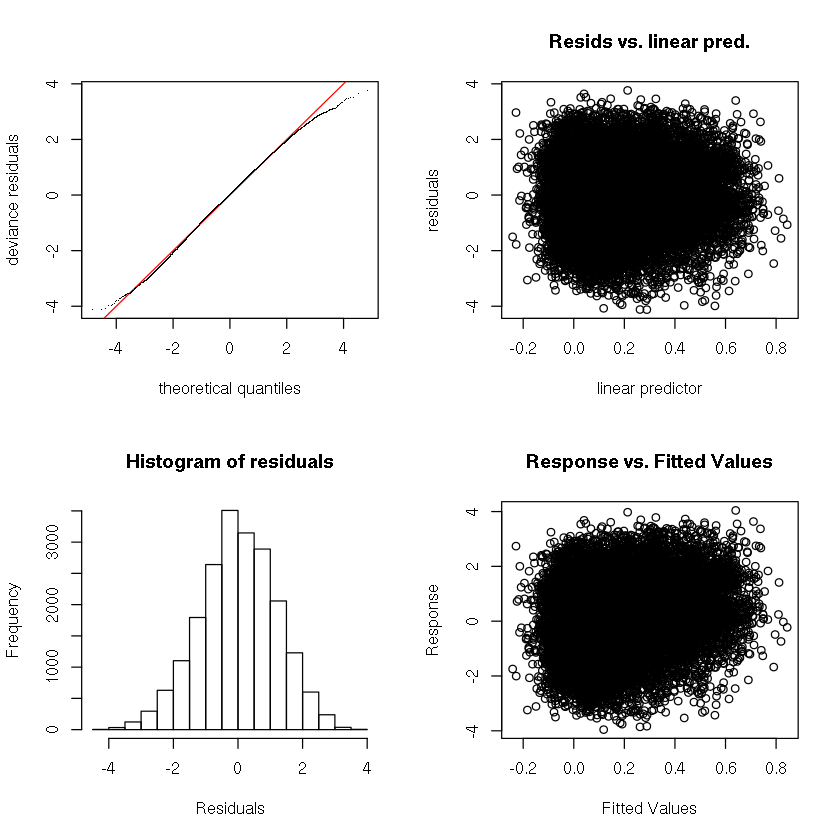


Method: REML   Optimizer: outer newton
full convergence after 8 iterations.
Gradient range [-0.0008371478,-0.0007152396]
(score 32389 & scale 1.416323).
Hessian positive definite, eigenvalue range [0.5560773,10159].
Model rank =  17 / 17 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

               k'  edf k-index p-value
s(GRS_WT_IR) 4.00 2.92       1    0.43


Resid. Df Resid. Dev Df       Deviance F        Pr(>F)    
1 20318.00  28785.21         NA       NA       NA         NA
2 20315.82  28773.07   2.182271 12.13456 3.926218 0.01679529

Resid. Df Resid. Dev Df       Deviance F        Pr(>F)    
1 20318.00  28785.21         NA       NA       NA         NA
2 20315.01  28774.14   2.992857 11.06113 2.609463 0.04986342

Resid. Df Resid. Dev Df        Deviance  F  Pr(>F)
1 20315.82  28773.07          NA        NA NA NA    
2 20315.01  28774.14   0.8105858 -1.073429 NA NA

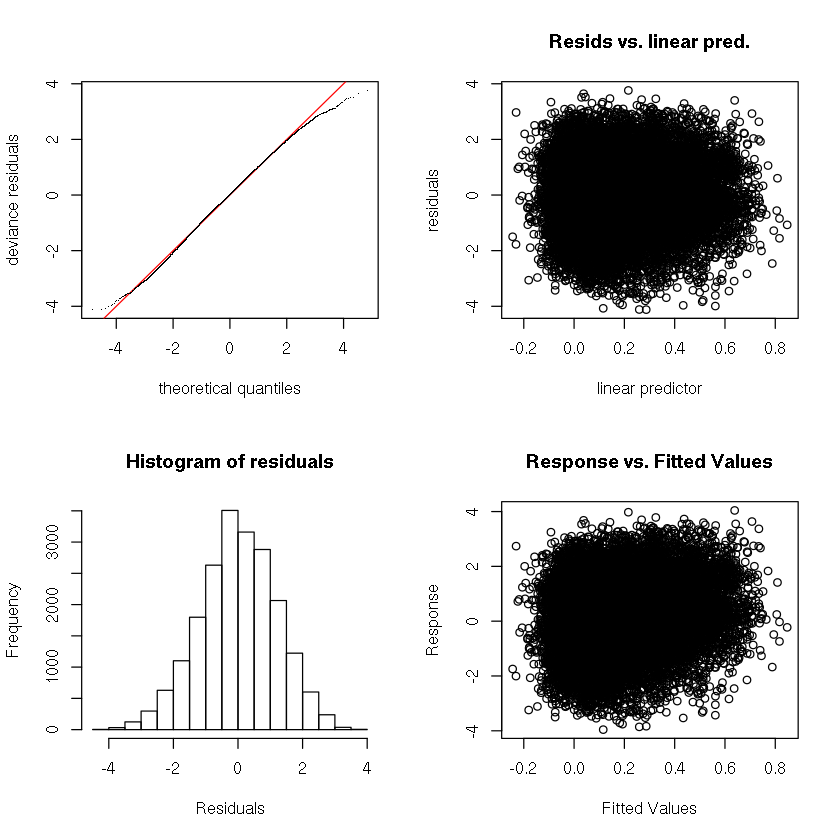

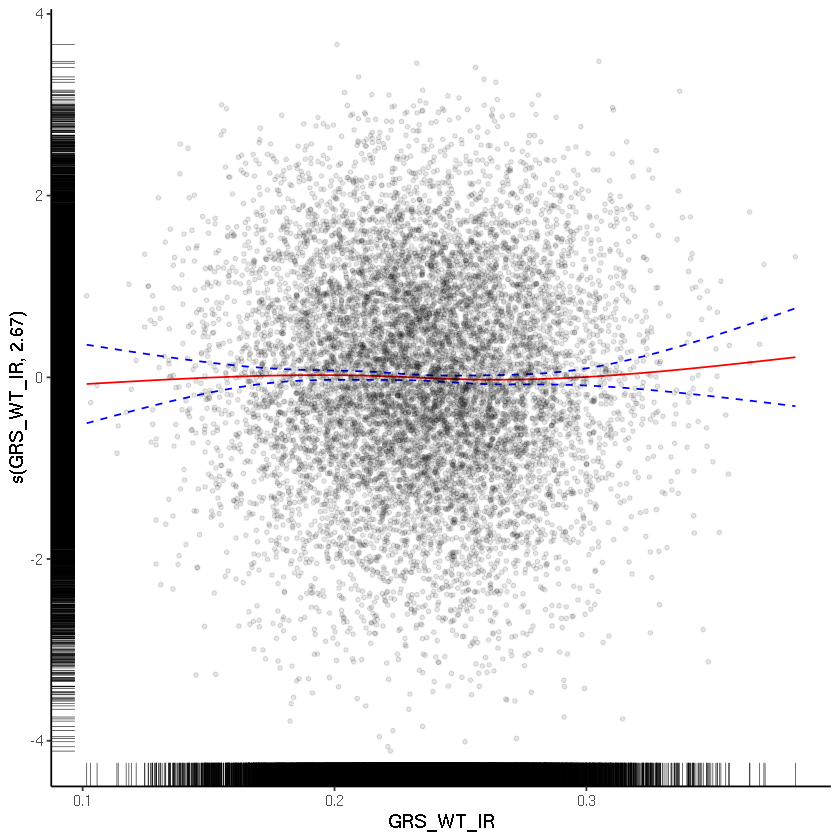

In [109]:
#IR-PRS vs. transformed EGFR (T2D) - reported
#gaussian
#linear
m1 <- gam(EGFR_tresid.0.0 ~ GRS_WT_IR + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10,data=T2D,family="gaussian",method="REML")
summary(m1)
#third knot
m2 <- gam(EGFR_tresid.0.0 ~ s(GRS_WT_IR,bs="cr",k=4) + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10,data=T2D,family="gaussian",method="REML")
summary(m2)
gam.check(m2)
#ten knot
m3 <- gam(EGFR_tresid.0.0 ~ s(GRS_WT_IR,bs="cr",k=5) + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10,data=T2D,family="gaussian",method="REML")
summary(m3)
gam.check(m3)
#compare models
anova(m1,m2,test="F")
anova(m1,m3,test="F")
anova(m2,m3,test="F")
#plot curves
m2v <- getViz(m2)
o <- plot(sm(m2v, 1))
o + l_fitLine(colour = "red") + l_rug(mapping = aes(x=x, y=y), alpha = 0.8) +
    l_ciLine(mul = 5, colour = "blue", linetype = 2) + 
    l_points(shape = 19, size = 1, alpha = 0.1) + theme_classic()

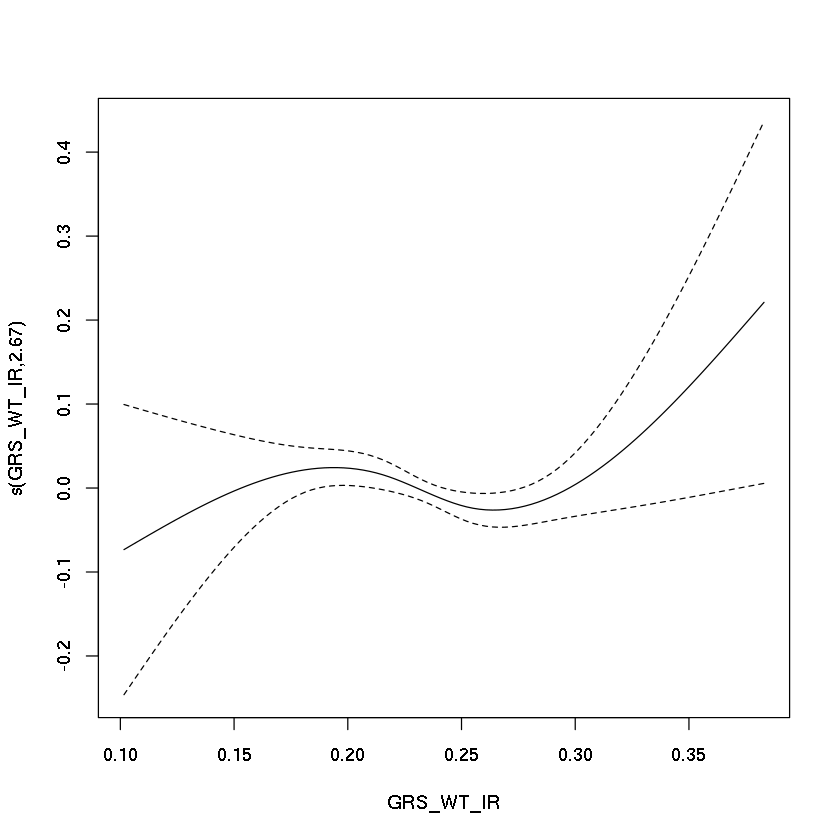

In [27]:
plot(m2)
copy <- T2D %>% select('EGFR_tresid.0.0','AGE.0.0','GRS_WT_IR','SEX.0.0','PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10',
                             'GRS_WT_T2DIR')
copy <- copy[complete.cases(copy),]
p <- predict(m2, type="lpmatrix")
beta <- coef(m2)[grepl("GRS_WT_IR", names(coef(m2)))]
s <- p[,grepl("GRS_WT_IR", colnames(p))] %*% beta
#ggplot(data=cbind.data.frame(s, copy$GRS_WT_IR), aes(x=copy$GRS_WT_IR, y=s)) + geom_line()


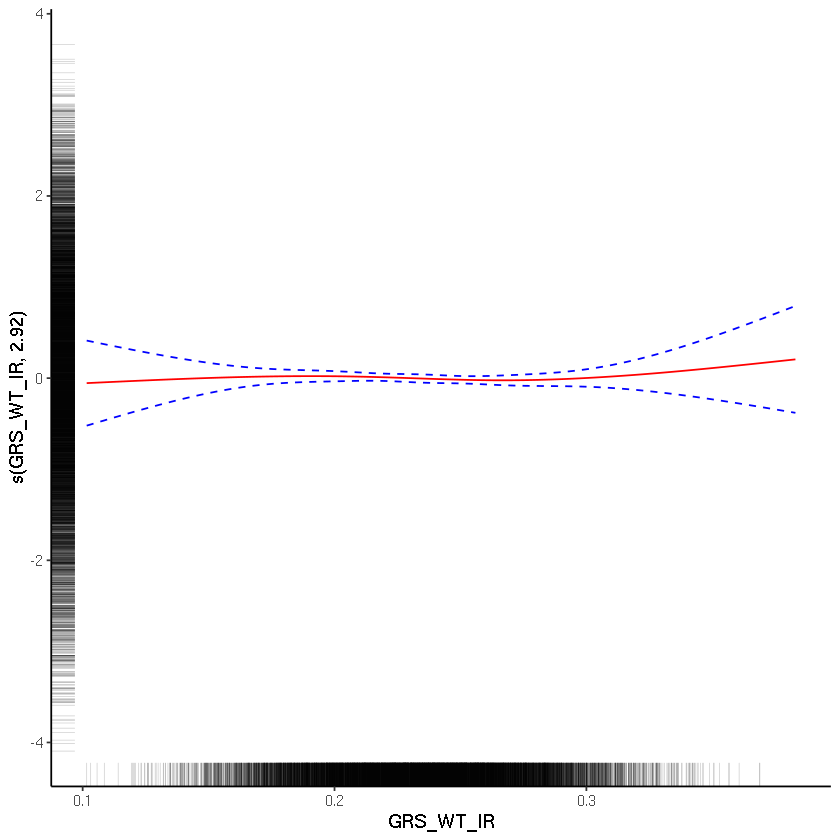


Method: REML   Optimizer: outer newton
full convergence after 8 iterations.
Gradient range [-0.0008371478,-0.0007152396]
(score 32389 & scale 1.416323).
Hessian positive definite, eigenvalue range [0.5560773,10159].
Model rank =  17 / 17 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

               k'  edf k-index p-value
s(GRS_WT_IR) 4.00 2.92    1.02    0.93


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



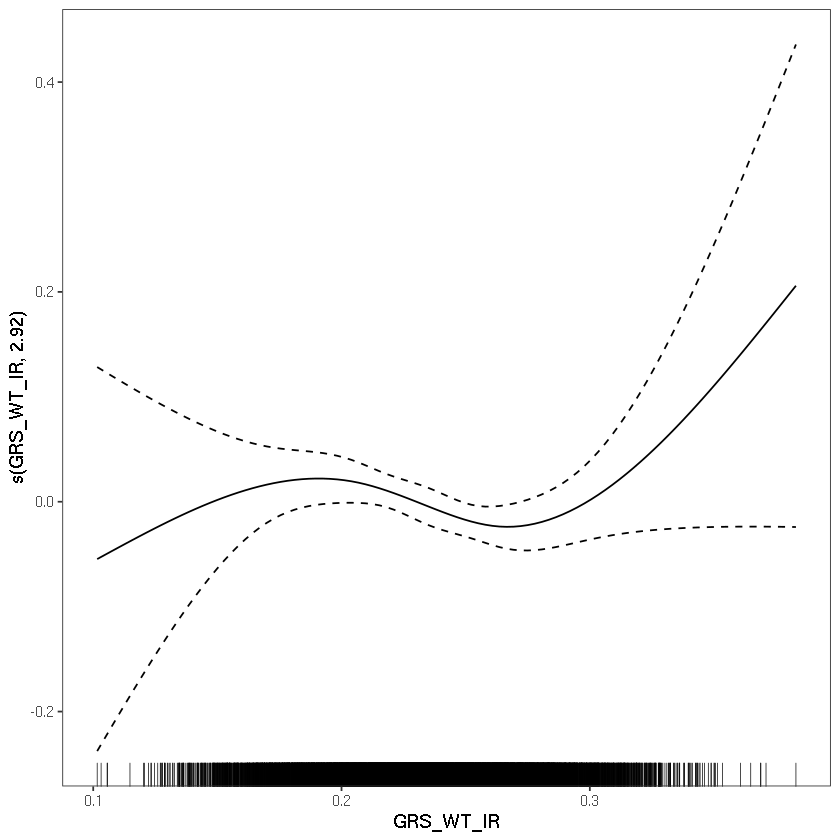

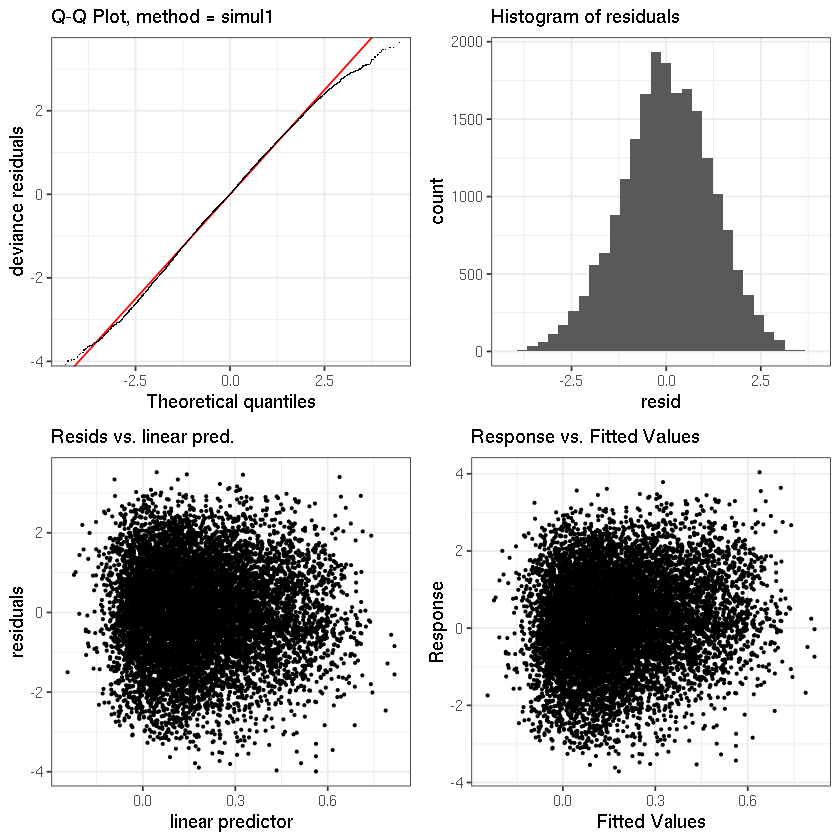

In [28]:
m2v <- getViz(m3)
o <- plot(sm(m2v, 1))
o + l_fitLine(colour = "red") + l_rug(mapping = aes(x=x, y=y), alpha = 0.2) +
    l_ciLine(mul = 5, colour = "blue", linetype = 2) + theme_classic()
plot(m2v,select=1)
check(m2v)

Low          High         Diff.        Effect       
GRS_WT_IR              0.203400000  0.255286240  0.051886240 -0.0106712990
AGE.0.0               51.000000000 64.000000000 13.000000000 -0.2980422808
PC1                   -0.007214946  0.005019935  0.012234881 -0.0161737687
PC2                   -0.009684046  0.006451929  0.016135975  0.0411566940
PC3                   -0.002028366  0.003953506  0.005981872  0.0019963226
PC4                   -0.005253158  0.003202142  0.008455300  0.0156697655
PC5                   -0.004491264  0.005089906  0.009581170  0.0265048184
PC6                   -0.004112781  0.003762518  0.007875298  0.0108988723
PC7                   -0.004261957  0.004472630  0.008734587  0.0024597933
PC8                   -0.003626992  0.004163412  0.007790404 -0.0008242623
PC9                   -0.003713929  0.003816166  0.007530096 -0.0090911356
PC10                  -0.003924822  0.004160545  0.008085367  0.0270797403
SEX.0.0 - Male:Female  1.000000000  2.000000000           NA  0.0554841363
                      S.E.        Lower 0.95    Upper 0.95   Type
GRS_WT_IR             0.011358610 -0.0329350922  0.011592494 1   
AGE.0.0               0.016104746 -0.3296088840 -0.266475677 1   
PC1                   0.005977234 -0.0278896305 -0.004457907 1   
PC2                   0.009486954  0.0225614984  0.059751890 1   
PC3                   0.005655041 -0.0090880153  0.013080661 1   
PC4                   0.008145011 -0.0002951138  0.031634645 1   
PC5                   0.010202330  0.0065074287  0.046502208 1   
PC6                   0.009157380 -0.0070503321  0.028848077 1   
PC7                   0.011185569 -0.0194648249  0.024384412 1   
PC8                   0.010435807 -0.0212792864  0.019630762 1   
PC9                   0.010167031 -0.0290193382  0.010837067 1   
PC10                  0.011072714  0.0053763275  0.048783153 1   
SEX.0.0 - Male:Female 0.017243407  0.0216856665  0.089282606 1

d.f.  Partial SS   MS           F            P          
GRS_WT_IR     1 1.250468e+00 1.250468e+00   0.88264117 0.347490471
AGE.0.0       1 4.852174e+02 4.852174e+02 342.49006517 0.000000000
SEX.0.0       1 1.466830e+01 1.466830e+01  10.35360302 0.001294248
PC1           1 1.037314e+01 1.037314e+01   7.32186809 0.006817741
PC2           1 2.666341e+01 2.666341e+01  18.82033671 0.000014432
PC3           1 1.765543e-01 1.765543e-01   0.12462061 0.724079777
PC4           1 5.243606e+00 5.243606e+00   3.70119223 0.054387556
PC5           1 9.561793e+00 9.561793e+00   6.74917940 0.009385848
PC6           1 2.006823e+00 2.006823e+00   1.41651327 0.233992062
PC7           1 6.851244e-02 6.851244e-02   0.04835942 0.825945206
PC8           1 8.838268e-03 8.838268e-03   0.00623848 0.937046087
PC9           1 1.132756e+00 1.132756e+00   0.79955427 0.371237261
PC10          1 8.473625e+00 8.473625e+00   5.98109712 0.014468430
TOTAL        13 5.775220e+02 4.442477e+01  31.35716510 0.000000000
ERROR     20318 2.878521e+04 1.416734e+00           NA          NA

`geom_smooth()` using formula 'y ~ x'



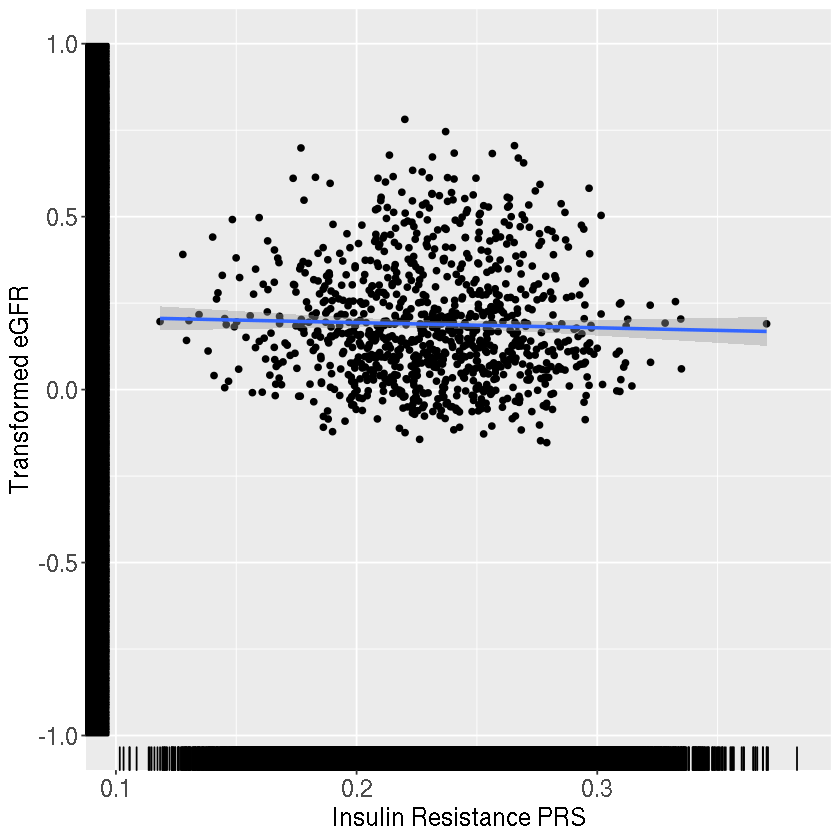

In [41]:
#PLOT: IR-PRS vs. EGFR (T2D)
m1 <- ols(EGFR_tresid.0.0 ~ GRS_WT_IR + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10,data=T2D)
summary(m1)
anova(m1)
pred_m1 <- data.frame(eGFR_pred=predict(m1,T2D),GRS_WT_IR=T2D$GRS_WT_IR)
pred_m1s <- pred_m1 %>% slice_sample(n = 1000)
ggplot(mapping=aes(x=GRS_WT_IR,y=eGFR_pred),data=pred_m1s)+ geom_rug(mapping=aes(x=GRS_WT_IR,y=EGFR_tresid.0.0),data=T2D) +
        geom_point(aes(x=GRS_WT_IR,y=eGFR_pred),data=pred_m1s) +
        geom_smooth(method="lm", se=TRUE,level=0.95) + scale_x_continuous(name="Insulin Resistance PRS") +
        scale_y_continuous(name="Transformed eGFR",limits=c(-1,1)) + theme(text = element_text(size = 15),
                                                            axis.text=element_text(size = 15)) 


Family: gaussian 
Link function: identity 

Formula:
EGFR.0.0 ~ GRS_WT_IR + AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + 
    PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10

Parametric coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 151.33071    1.03648 146.005  < 2e-16 ***
GRS_WT_IR    -2.62323    2.46524  -1.064 0.287303    
AGE.0.0      -1.01715    0.01395 -72.910  < 2e-16 ***
SEX.0.0Male   0.75263    0.19418   3.876 0.000107 ***
PC1         -12.28486    5.50158  -2.233 0.025562 *  
PC2          22.15045    6.62092   3.346 0.000823 ***
PC3           2.26448   10.64597   0.213 0.831557    
PC4          17.95138   10.84799   1.655 0.097978 .  
PC5          31.40977   11.99134   2.619 0.008816 ** 
PC6          12.60832   13.09456   0.963 0.335626    
PC7          -3.75868   14.42124  -0.261 0.794376    
PC8          -2.40243   15.08526  -0.159 0.873468    
PC9         -10.28316   15.20479  -0.676 0.498851    
PC10         34.14361   15.42201   2.214 0.026843 *  
---


Family: gaussian 
Link function: identity 

Formula:
EGFR.0.0 ~ s(GRS_WT_IR, bs = "cr", k = 20) + AGE.0.0 + SEX.0.0 + 
    PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10

Parametric coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 150.72416    0.85859 175.548  < 2e-16 ***
AGE.0.0      -1.01727    0.01395 -72.926  < 2e-16 ***
SEX.0.0Male   0.75178    0.19416   3.872 0.000108 ***
PC1         -12.30101    5.50108  -2.236 0.025356 *  
PC2          22.22090    6.62027   3.356 0.000791 ***
PC3           2.22036   10.64492   0.209 0.834775    
PC4          17.87125   10.84685   1.648 0.099451 .  
PC5          31.26603   11.99107   2.607 0.009129 ** 
PC6          12.49278   13.09307   0.954 0.340018    
PC7          -3.53306   14.41989  -0.245 0.806449    
PC8          -2.13545   15.08512  -0.142 0.887429    
PC9         -10.28980   15.20404  -0.677 0.498553    
PC10         34.51141   15.42166   2.238 0.025241 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘


Method: ML   Optimizer: outer newton
full convergence after 5 iterations.
Gradient range [-0.01780216,-0.003359898]
(score 81615.12 & scale 179.619).
Hessian positive definite, eigenvalue range [0.3578807,10166].
Model rank =  32 / 32 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

                k'   edf k-index p-value
s(GRS_WT_IR) 19.00  2.82    0.99    0.32



Family: gaussian 
Link function: identity 

Formula:
EGFR.0.0 ~ s(GRS_WT_IR, bs = "cr", k = 10) + AGE.0.0 + SEX.0.0 + 
    PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10

Parametric coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 150.72347    0.85860 175.546  < 2e-16 ***
AGE.0.0      -1.01726    0.01395 -72.925  < 2e-16 ***
SEX.0.0Male   0.75194    0.19416   3.873 0.000108 ***
PC1         -12.30022    5.50110  -2.236 0.025365 *  
PC2          22.21709    6.62028   3.356 0.000792 ***
PC3           2.21893   10.64496   0.208 0.834881    
PC4          17.87566   10.84689   1.648 0.099368 .  
PC5          31.26853   11.99109   2.608 0.009123 ** 
PC6          12.50027   13.09311   0.955 0.339730    
PC7          -3.54843   14.41990  -0.246 0.805624    
PC8          -2.14074   15.08514  -0.142 0.887152    
PC9         -10.27730   15.20404  -0.676 0.499075    
PC10         34.49190   15.42161   2.237 0.025324 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘

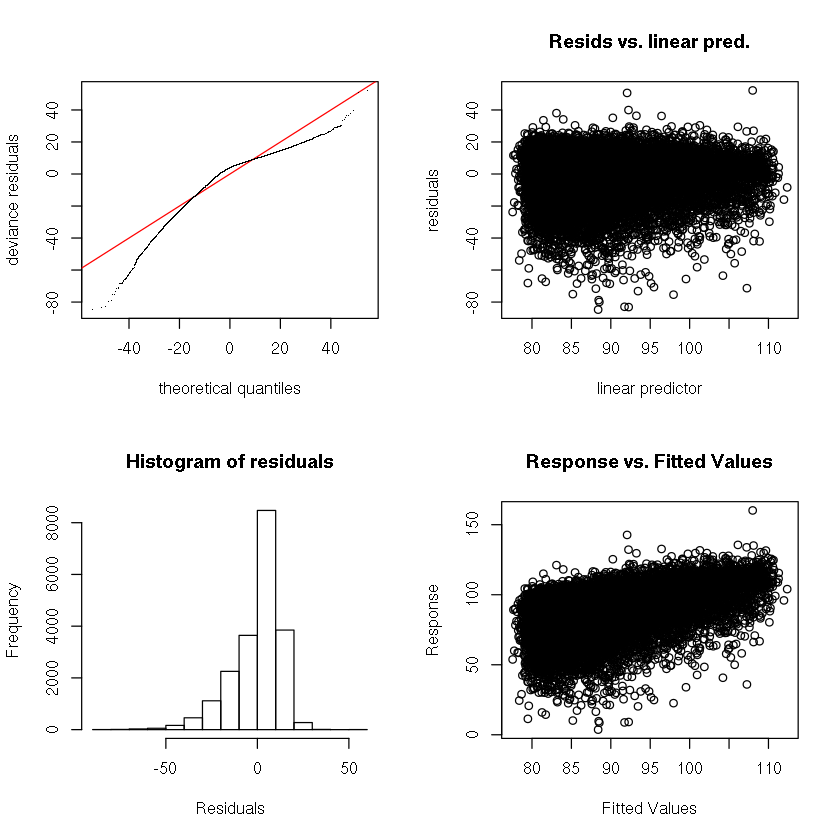


Method: ML   Optimizer: outer newton
full convergence after 6 iterations.
Gradient range [-1.420803e-05,2.247069e-06]
(score 81615.31 & scale 179.6205).
Hessian positive definite, eigenvalue range [0.2509638,10166].
Model rank =  22 / 22 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

              k' edf k-index p-value
s(GRS_WT_IR) 9.0 2.7    0.99    0.33


Resid. Df Resid. Dev Df       Deviance F      Pr(>F)    
1 20318.0   3650420          NA       NA     NA         NA
2 20314.6   3649171    3.403645 1248.518 2.0422 0.09705652

Resid. Df Resid. Dev Df         Deviance  F        Pr(>F)   
1 20314.60  3649171            NA        NA       NA        NA
2 20314.84  3649224    -0.2447772 -53.18096 1.209575 0.1734143

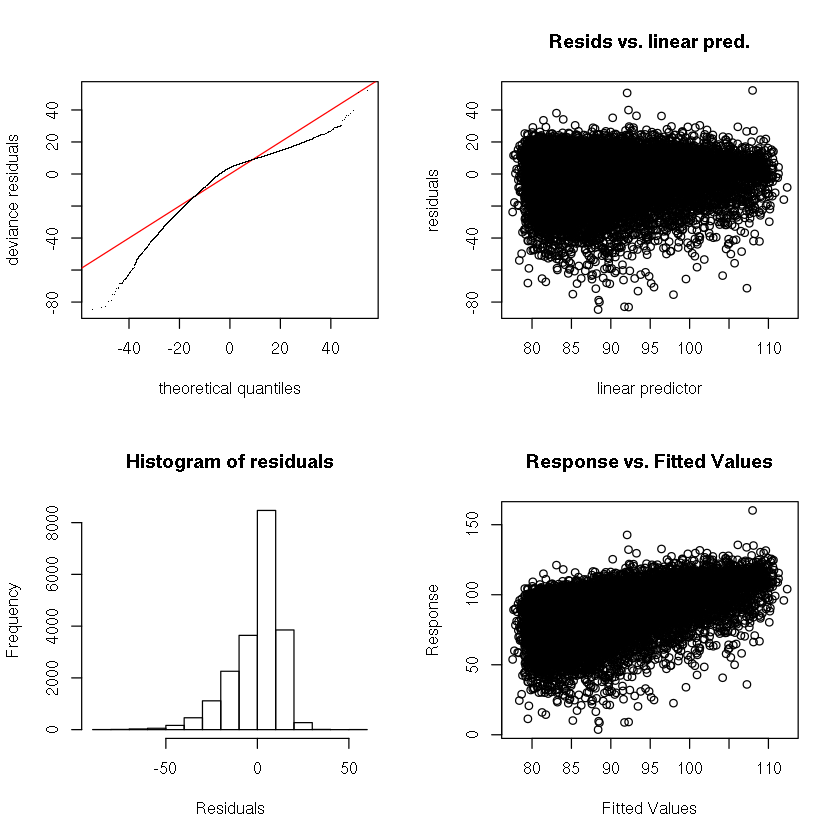

In [9]:
#IR-PRS vs. EGFR (T2D) - linear - not reported
#gaussian
#linear
m1 <- gam(EGFR.0.0 ~ GRS_WT_IR + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10,data=T2D,family="gaussian",method="ML")
summary(m1)
#third knot
m2 <- gam(EGFR.0.0 ~ s(GRS_WT_IR,bs="cr",k=20) + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10,data=T2D,family="gaussian",method="ML")
summary(m2)
gam.check(m2)
#ten knot
m3 <- gam(EGFR.0.0 ~ s(GRS_WT_IR,bs="cr",k=10) + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10,data=T2D,family="gaussian",method="ML")
summary(m3)
gam.check(m3)
#compare models
anova(m1,m2,test="F")
anova(m2,m3,test="F")


Family: gaussian 
Link function: identity 

Formula:
EGFR_tresid.0.0 ~ GRS_WT_IR + AGE.0.0 + SEX.0.0 + PC1 + PC2 + 
    PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10

Parametric coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.1098040  0.0159235  -6.896 5.37e-12 ***
GRS_WT_IR   -0.0941700  0.0441997  -2.131   0.0331 *  
AGE.0.0      0.0024146  0.0002116  11.409  < 2e-16 ***
SEX.0.0Male -0.0388225  0.0034129 -11.375  < 2e-16 ***
PC1         -1.2276115  0.0988488 -12.419  < 2e-16 ***
PC2          2.4599206  0.1200527  20.490  < 2e-16 ***
PC3         -0.3840235  0.1737941  -2.210   0.0271 *  
PC4          0.1369749  0.1945754   0.704   0.4815    
PC5          1.6606812  0.2152911   7.714 1.23e-14 ***
PC6          1.7292903  0.2332844   7.413 1.24e-13 ***
PC7          0.0514718  0.2558854   0.201   0.8406    
PC8          0.5773545  0.2697062   2.141   0.0323 *  
PC9          0.3459980  0.2705445   1.279   0.2009    
PC10         0.3072711  0.2746155   


Family: gaussian 
Link function: identity 

Formula:
EGFR_tresid.0.0 ~ s(GRS_WT_IR, bs = "cr", k = 20) + AGE.0.0 + 
    SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
    PC9 + PC10

Parametric coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.1313588  0.0122510 -10.722  < 2e-16 ***
AGE.0.0      0.0024142  0.0002116  11.407  < 2e-16 ***
SEX.0.0Male -0.0388213  0.0034129 -11.375  < 2e-16 ***
PC1         -1.2276343  0.0988484 -12.419  < 2e-16 ***
PC2          2.4591565  0.1200531  20.484  < 2e-16 ***
PC3         -0.3838168  0.1737933  -2.208   0.0272 *  
PC4          0.1360891  0.1945753   0.699   0.4843    
PC5          1.6606022  0.2152901   7.713 1.23e-14 ***
PC6          1.7290446  0.2332835   7.412 1.25e-13 ***
PC7          0.0505747  0.2558849   0.198   0.8433    
PC8          0.5769266  0.2697052   2.139   0.0324 *  
PC9          0.3460842  0.2705433   1.279   0.2008    
PC10         0.3072307  0.2746143   1.119   0.2632    
---
Signi


Method: ML   Optimizer: outer newton
full convergence after 6 iterations.
Gradient range [-0.0001376665,-9.704697e-09]
(score 471948.7 & scale 0.9683065).
Hessian positive definite, eigenvalue range [0.2885545,168214.5].
Model rank =  32 / 32 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

                k'   edf k-index p-value
s(GRS_WT_IR) 19.00  1.88    1.02    0.94



Family: gaussian 
Link function: identity 

Formula:
EGFR_tresid.0.0 ~ s(GRS_WT_IR, bs = "cr", k = 50) + AGE.0.0 + 
    SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
    PC9 + PC10

Parametric coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.1313554  0.0122510 -10.722  < 2e-16 ***
AGE.0.0      0.0024141  0.0002116  11.407  < 2e-16 ***
SEX.0.0Male -0.0388209  0.0034129 -11.375  < 2e-16 ***
PC1         -1.2276366  0.0988484 -12.419  < 2e-16 ***
PC2          2.4590482  0.1200532  20.483  < 2e-16 ***
PC3         -0.3837908  0.1737933  -2.208   0.0272 *  
PC4          0.1359587  0.1945753   0.699   0.4847    
PC5          1.6605948  0.2152900   7.713 1.23e-14 ***
PC6          1.7290138  0.2332834   7.412 1.25e-13 ***
PC7          0.0504646  0.2558849   0.197   0.8437    
PC8          0.5768756  0.2697052   2.139   0.0324 *  
PC9          0.3460812  0.2705432   1.279   0.2008    
PC10         0.3072484  0.2746142   1.119   0.2632    
---
Signi

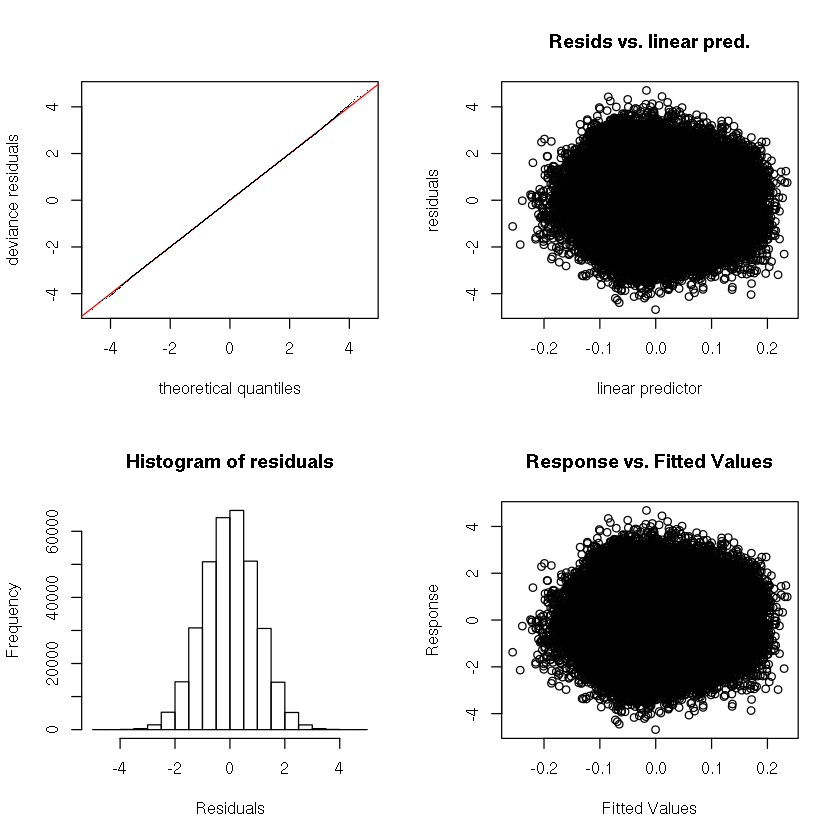


Method: ML   Optimizer: outer newton
full convergence after 7 iterations.
Gradient range [-5.903744e-05,-2.444256e-06]
(score 471948.5 & scale 0.9683056).
Hessian positive definite, eigenvalue range [0.3553621,168214.5].
Model rank =  62 / 62 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

                k'   edf k-index p-value
s(GRS_WT_IR) 49.00  2.07       1    0.41


Resid. Df Resid. Dev Df       Deviance F        Pr(>F)   
1 336415.0  325756           NA       NA       NA        NA
2 336413.1  325752     1.925815 4.034547 2.163552 0.1169499

Resid. Df Resid. Dev Df        Deviance  F        Pr(>F)   
1 336413.1  325752.0          NA        NA       NA        NA
2 336412.8  325751.5   0.3195924 0.4773388 1.542474 0.1675881

[1] 943928.2

[1] 943926.8

[1] 943926.8

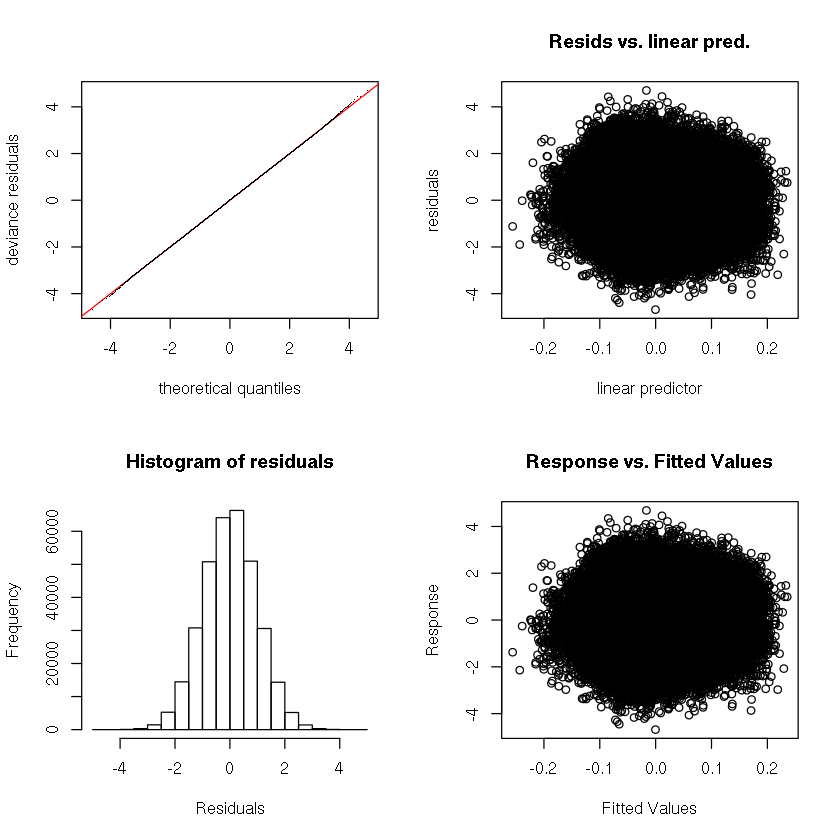

In [56]:
#IR-PRS vs. EGFR (ND)
#gaussian
#linear
m1 <- gam(EGFR_tresid.0.0 ~ GRS_WT_IR + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10,data=ND,family="gaussian",method="ML")
summary(m1)
#third knot
m2 <- gam(EGFR_tresid.0.0 ~ s(GRS_WT_IR,bs="cr",k=20) + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10,data=ND,family="gaussian",method="ML")
summary(m2)
gam.check(m2)
#ten knot
m3 <- gam(EGFR_tresid.0.0 ~ s(GRS_WT_IR,bs="cr",k=50) + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10,data=ND,family="gaussian",method="ML")
summary(m3)
gam.check(m3)
#compare models
anova(m1,m2,test="F")
anova(m2,m3,test="F")
AIC(m1)
AIC(m2)
AIC(m3)

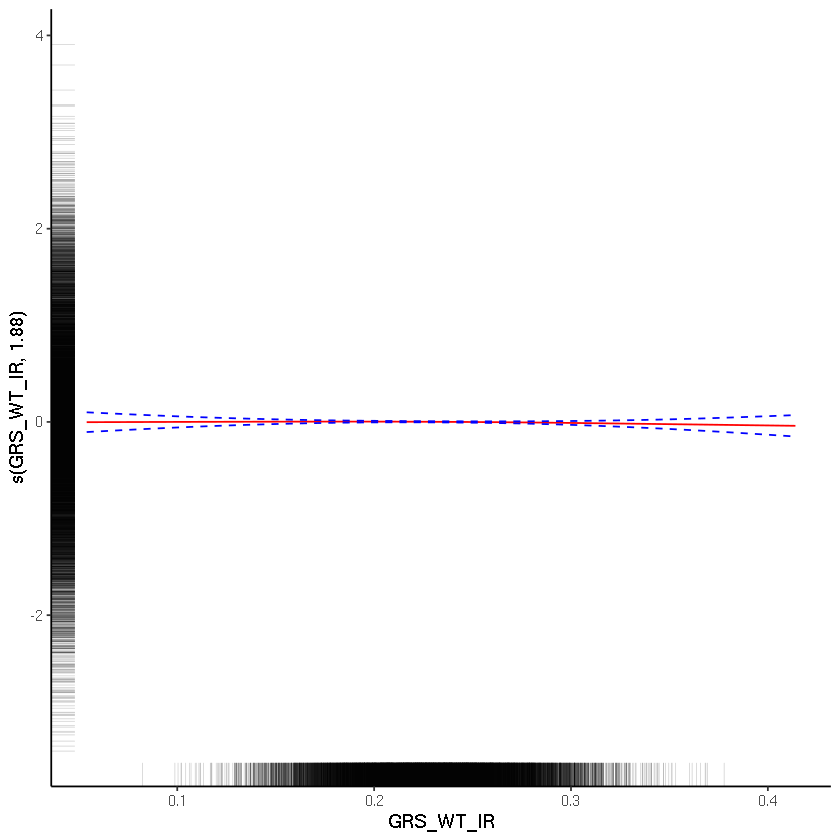

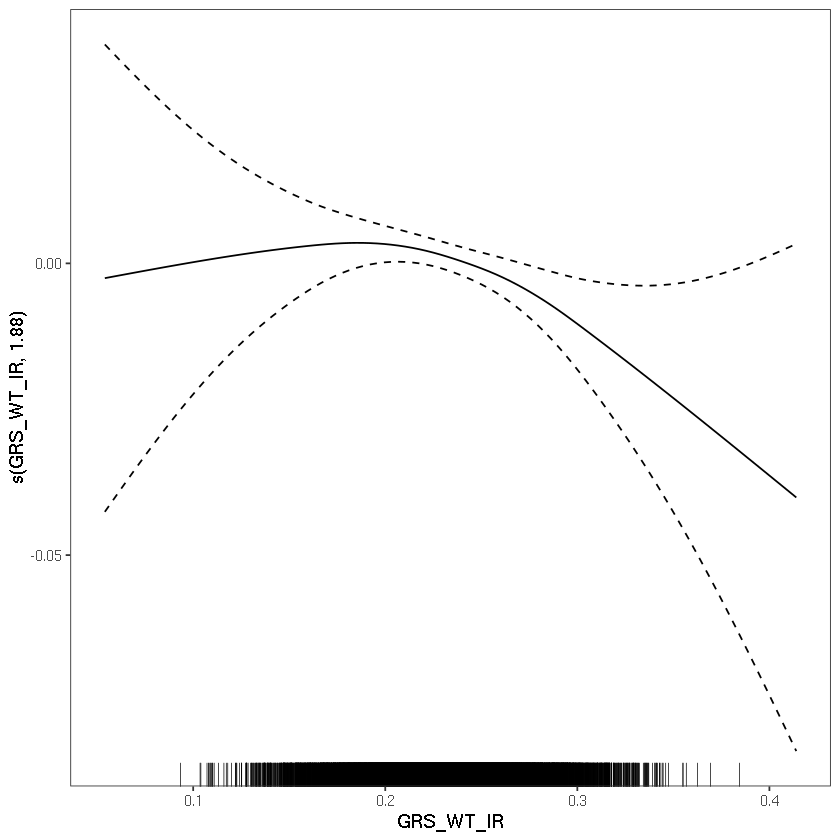

In [57]:
m2v <- getViz(m2)
o <- plot(sm(m2v, 1))
o + l_fitLine(colour = "red") + l_rug(mapping = aes(x=x, y=y), alpha = 0.2) +
    l_ciLine(mul = 5, colour = "blue", linetype = 2) + theme_classic()
plot(m2v,select=1)

`geom_smooth()` using formula 'y ~ x'



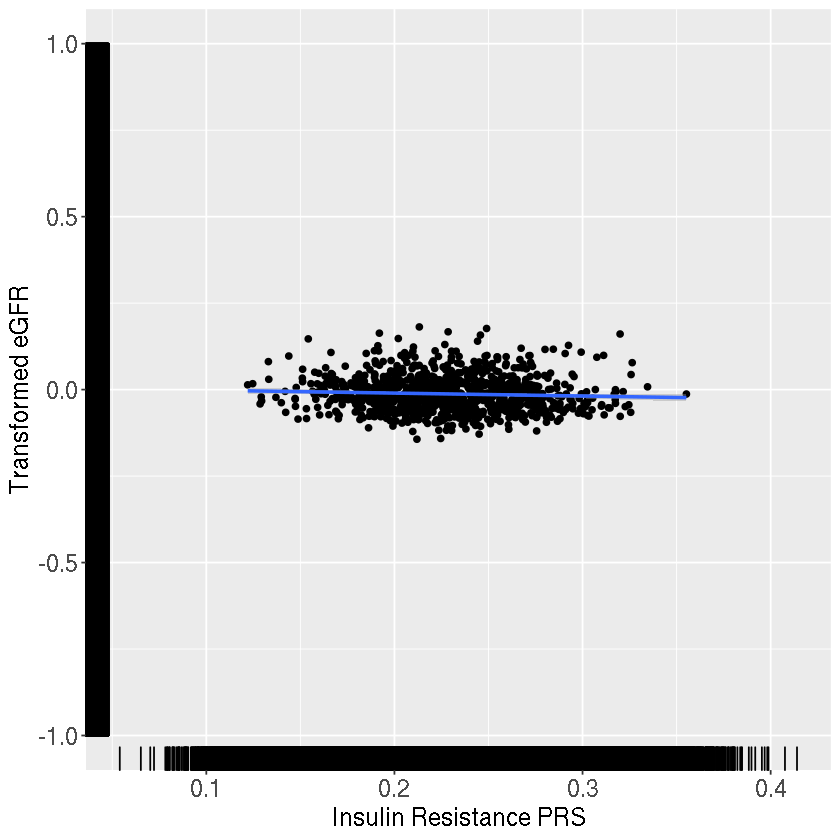

In [11]:
#PLOT: IR-PRS vs. EGFR (ND)
m1 <- ols(EGFR_tresid.0.0 ~ GRS_WT_IR + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10,data=ND)
pred_m1 <- data.frame(eGFR_pred=predict(m1,ND),GRS_WT_IR=ND$GRS_WT_IR)
pred_m1s <- pred_m1 %>% slice_sample(n = 1000)
ggplot(mapping=aes(x=GRS_WT_IR,y=eGFR_pred),data=pred_m1s)+ geom_rug(mapping=aes(x=GRS_WT_IR,y=EGFR_tresid.0.0),data=ND) +
        geom_point(aes(x=GRS_WT_IR,y=eGFR_pred),data=pred_m1s) +
        geom_smooth(method="lm", se=TRUE,level=0.95) + scale_x_continuous(name="Insulin Resistance PRS") +
        scale_y_continuous(name="Transformed eGFR",limits=c(-1,1)) + theme(text = element_text(size = 15),
                                                            axis.text=element_text(size = 15)) 


Family: gaussian 
Link function: identity 

Formula:
EGFR.0.0 ~ GRS_WT_IR + AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + 
    PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10

Parametric coefficients:
              Estimate Std. Error  t value Pr(>|t|)    
(Intercept) 134.229273   0.183153  732.882  < 2e-16 ***
GRS_WT_IR    -1.326359   0.508387   -2.609  0.00908 ** 
AGE.0.0      -0.750222   0.002434 -308.186  < 2e-16 ***
SEX.0.0Male  -0.242766   0.039256   -6.184 6.25e-10 ***
PC1         -12.869879   1.136963  -11.320  < 2e-16 ***
PC2          24.789520   1.380852   17.952  < 2e-16 ***
PC3          -4.156959   1.998987   -2.080  0.03757 *  
PC4           1.696111   2.238015    0.758  0.44853    
PC5          19.031179   2.476288    7.685 1.53e-14 ***
PC6          16.135106   2.683248    6.013 1.82e-09 ***
PC7           0.084860   2.943205    0.029  0.97700    
PC8           5.260508   3.102173    1.696  0.08993 .  
PC9           3.356800   3.111815    1.079  0.28071    
PC10          1.285034   3.15


Family: gaussian 
Link function: identity 

Formula:
EGFR.0.0 ~ s(GRS_WT_IR, bs = "cr", k = 20) + AGE.0.0 + SEX.0.0 + 
    PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10

Parametric coefficients:
              Estimate Std. Error  t value Pr(>|t|)    
(Intercept) 133.925666   0.140912  950.422  < 2e-16 ***
AGE.0.0      -0.750228   0.002434 -308.190  < 2e-16 ***
SEX.0.0Male  -0.242746   0.039255   -6.184 6.27e-10 ***
PC1         -12.870208   1.136958  -11.320  < 2e-16 ***
PC2          24.778969   1.380855   17.945  < 2e-16 ***
PC3          -4.154040   1.998976   -2.078   0.0377 *  
PC4           1.683794   2.238012    0.752   0.4518    
PC5          19.030130   2.476273    7.685 1.53e-14 ***
PC6          16.131934   2.683234    6.012 1.83e-09 ***
PC7           0.072569   2.943197    0.025   0.9803    
PC8           5.254698   3.102158    1.694   0.0903 .  
PC9           3.357918   3.111798    1.079   0.2805    
PC10          1.284879   3.158622    0.407   0.6842    
---
Sig


Method: ML   Optimizer: outer newton
full convergence after 6 iterations.
Gradient range [-0.002512034,1.185583e-08]
(score 1293685 & scale 128.1037).
Hessian positive definite, eigenvalue range [0.3206645,168214.5].
Model rank =  32 / 32 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

                k'   edf k-index p-value
s(GRS_WT_IR) 19.00  2.06    1.01    0.79



Family: gaussian 
Link function: identity 

Formula:
EGFR.0.0 ~ s(GRS_WT_IR, bs = "cr", k = 50) + AGE.0.0 + SEX.0.0 + 
    PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10

Parametric coefficients:
              Estimate Std. Error  t value Pr(>|t|)    
(Intercept) 133.925699   0.140912  950.422  < 2e-16 ***
AGE.0.0      -0.750228   0.002434 -308.190  < 2e-16 ***
SEX.0.0Male  -0.242740   0.039255   -6.184 6.27e-10 ***
PC1         -12.870229   1.136957  -11.320  < 2e-16 ***
PC2          24.777845   1.380856   17.944  < 2e-16 ***
PC3          -4.153763   1.998976   -2.078   0.0377 *  
PC4           1.682408   2.238012    0.752   0.4522    
PC5          19.030082   2.476272    7.685 1.53e-14 ***
PC6          16.131686   2.683233    6.012 1.83e-09 ***
PC7           0.071511   2.943197    0.024   0.9806    
PC8           5.254234   3.102158    1.694   0.0903 .  
PC9           3.357821   3.111796    1.079   0.2806    
PC10          1.285250   3.158621    0.407   0.6841    
---
Sig

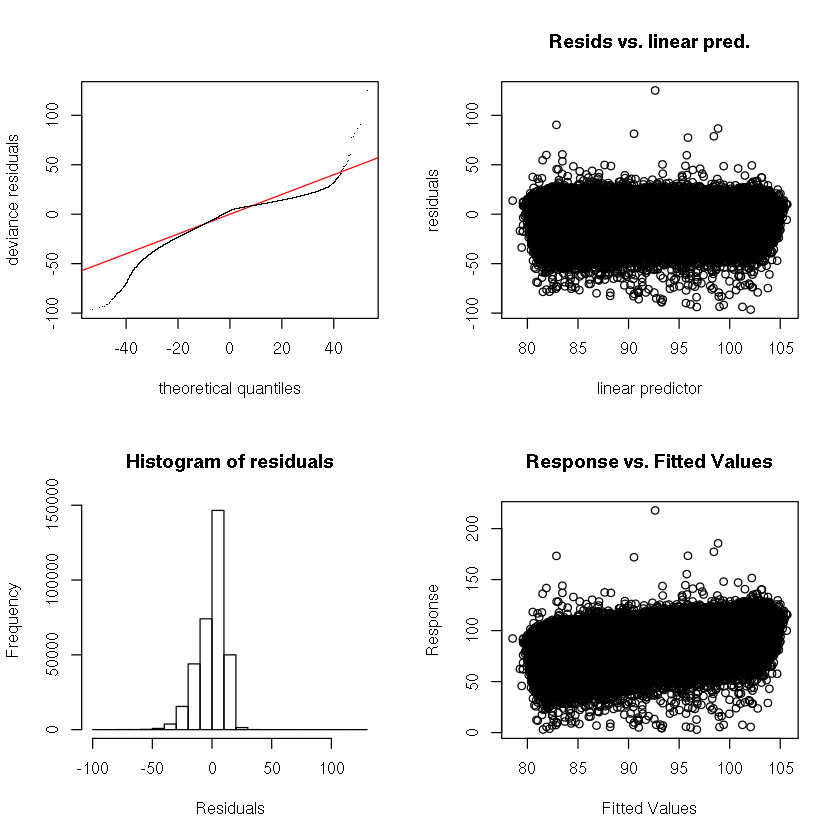


Method: ML   Optimizer: outer newton
full convergence after 6 iterations.
Gradient range [-1.359034e-05,-9.029754e-06]
(score 1293684 & scale 128.1036).
Hessian positive definite, eigenvalue range [0.3662339,168214.5].
Model rank =  62 / 62 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

                k'   edf k-index p-value
s(GRS_WT_IR) 49.00  2.24    0.99    0.24


Resid. Df Resid. Dev Df       Deviance F        Pr(>F)    
1 336415.0  43096549         NA      NA        NA         NA
2 336412.8  43095879   2.215318 669.868  2.360432 0.08837854

Resid. Df Resid. Dev Df        Deviance F        Pr(>F)   
1 336412.8  43095879          NA       NA       NA        NA
2 336412.5  43095813   0.3167275 66.00959 1.626897 0.1614043

[1] 2587401

[1] 2587399

[1] 2587399

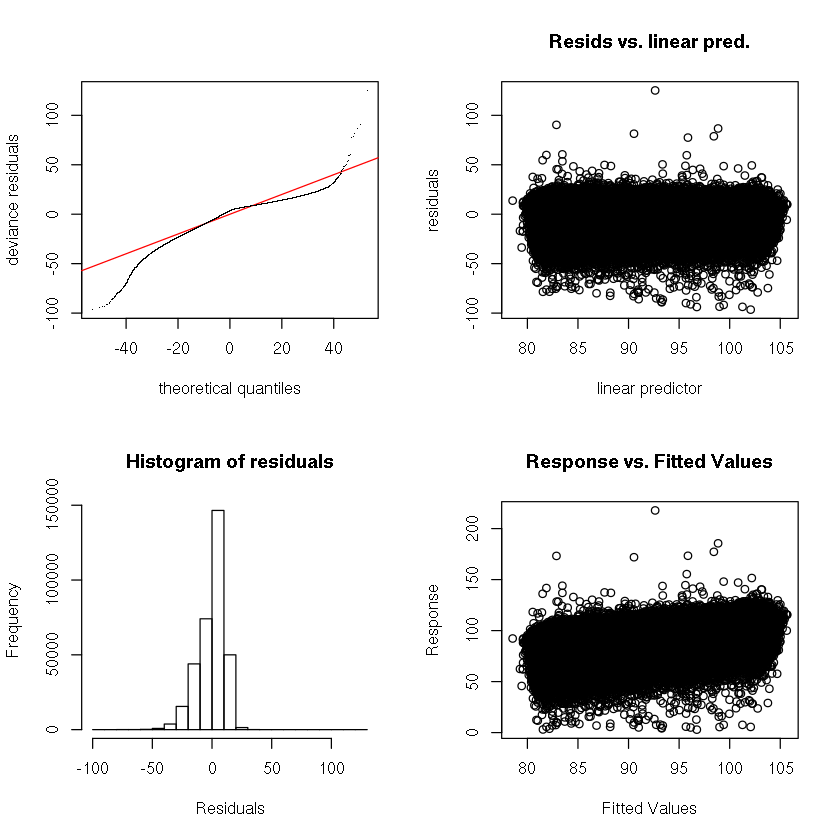

In [12]:
#IR-PRS vs. EGFR (ND)
#gaussian
#linear
m1 <- gam(EGFR.0.0 ~ GRS_WT_IR + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10,data=ND,family="gaussian",method="ML")
summary(m1)
#third knot
m2 <- gam(EGFR.0.0 ~ s(GRS_WT_IR,bs="cr",k=20) + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10,data=ND,family="gaussian",method="ML")
summary(m2)
gam.check(m2)
#ten knot
m3 <- gam(EGFR.0.0 ~ s(GRS_WT_IR,bs="cr",k=50) + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10,data=ND,family="gaussian",method="ML")
summary(m3)
gam.check(m3)
#compare models
anova(m1,m2,test="F")
anova(m2,m3,test="F")
AIC(m1)
AIC(m2)
AIC(m3)

Loading required package: lmerTest


Attaching package: ‘lmerTest’


The following object is masked from ‘package:lme4’:

    lmer


The following object is masked from ‘package:stats’:

    step




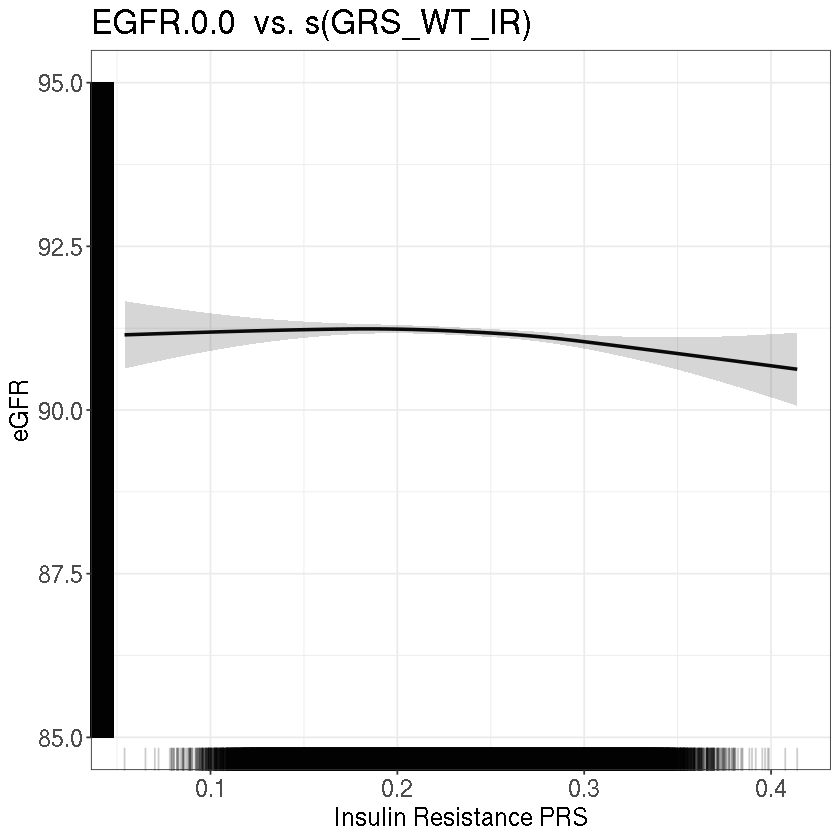

In [13]:
#PLOT: IR-PRS vs. EGFR (ND)
library(voxel)
p <- plotGAM(m2, smooth.cov = "GRS_WT_IR") +
    geom_rug(data = ND, aes(y = EGFR.0.0, x = GRS_WT_IR), alpha = 0.2) +
    theme(legend.position="none") + scale_x_continuous(name="Insulin Resistance PRS") +
        scale_y_continuous(name="eGFR",limits=c(85,95)) + theme(text = element_text(size = 15),
                                                            axis.text=element_text(size = 15)) 
p



Family: gaussian 
Link function: identity 

Formula:
EGFR_tresid.0.0 ~ GRS_WT_IR + AGE.0.0 + SEX.0.0 + PC1 + PC2 + 
    PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10

Parametric coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.0870009  0.0157246  -5.533 3.15e-08 ***
GRS_WT_IR   -0.0637221  0.0435611  -1.463   0.1435    
AGE.0.0      0.0019886  0.0002092   9.507  < 2e-16 ***
SEX.0.0Male -0.0264821  0.0033581  -7.886 3.13e-15 ***
PC1         -1.2460965  0.0974448 -12.788  < 2e-16 ***
PC2          2.4748412  0.1182947  20.921  < 2e-16 ***
PC3         -0.3522143  0.1721850  -2.046   0.0408 *  
PC4          0.2527371  0.1918426   1.317   0.1877    
PC5          1.6750216  0.2122470   7.892 2.99e-15 ***
PC6          1.7317793  0.2300857   7.527 5.22e-14 ***
PC7          0.0887943  0.2524532   0.352   0.7250    
PC8          0.5384741  0.2659779   2.025   0.0429 *  
PC9          0.2818858  0.2668741   1.056   0.2909    
PC10         0.4991618  0.2708806   


Family: gaussian 
Link function: identity 

Formula:
EGFR_tresid.0.0 ~ s(GRS_WT_IR, k = 20, bs = "cr") + AGE.0.0 + 
    SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
    PC9 + PC10

Parametric coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.1016097  0.0121400  -8.370  < 2e-16 ***
AGE.0.0      0.0019884  0.0002092   9.507  < 2e-16 ***
SEX.0.0Male -0.0264823  0.0033581  -7.886 3.13e-15 ***
PC1         -1.2461192  0.0974446 -12.788  < 2e-16 ***
PC2          2.4744542  0.1182949  20.918  < 2e-16 ***
PC3         -0.3520585  0.1721846  -2.045   0.0409 *  
PC4          0.2523393  0.1918425   1.315   0.1884    
PC5          1.6751322  0.2122465   7.892 2.97e-15 ***
PC6          1.7316447  0.2300852   7.526 5.24e-14 ***
PC7          0.0882972  0.2524531   0.350   0.7265    
PC8          0.5381667  0.2659777   2.023   0.0430 *  
PC9          0.2818499  0.2668735   1.056   0.2909    
PC10         0.4990762  0.2708801   1.842   0.0654 .  
---
Signi


Method: ML   Optimizer: outer newton
full convergence after 6 iterations.
Gradient range [-0.0004127338,0.0002950138]
(score 505789.9 & scale 0.9976158).
Hessian positive definite, eigenvalue range [0.1328938,178380.5].
Model rank =  32 / 32 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

                k'   edf k-index p-value
s(GRS_WT_IR) 19.00  1.54    0.99    0.28



Family: gaussian 
Link function: identity 

Formula:
EGFR_tresid.0.0 ~ s(GRS_WT_IR, k = 50, bs = "cr") + AGE.0.0 + 
    SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
    PC9 + PC10

Parametric coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.1016065  0.0121400  -8.370  < 2e-16 ***
AGE.0.0      0.0019883  0.0002092   9.506  < 2e-16 ***
SEX.0.0Male -0.0264823  0.0033581  -7.886 3.13e-15 ***
PC1         -1.2461227  0.0974446 -12.788  < 2e-16 ***
PC2          2.4743209  0.1182950  20.917  < 2e-16 ***
PC3         -0.3520058  0.1721846  -2.044   0.0409 *  
PC4          0.2522047  0.1918425   1.315   0.1886    
PC5          1.6751728  0.2122464   7.893 2.97e-15 ***
PC6          1.7316015  0.2300851   7.526 5.25e-14 ***
PC7          0.0881384  0.2524532   0.349   0.7270    
PC8          0.5380807  0.2659776   2.023   0.0431 *  
PC9          0.2818395  0.2668734   1.056   0.2909    
PC10         0.4990691  0.2708800   1.842   0.0654 .  
---
Signi

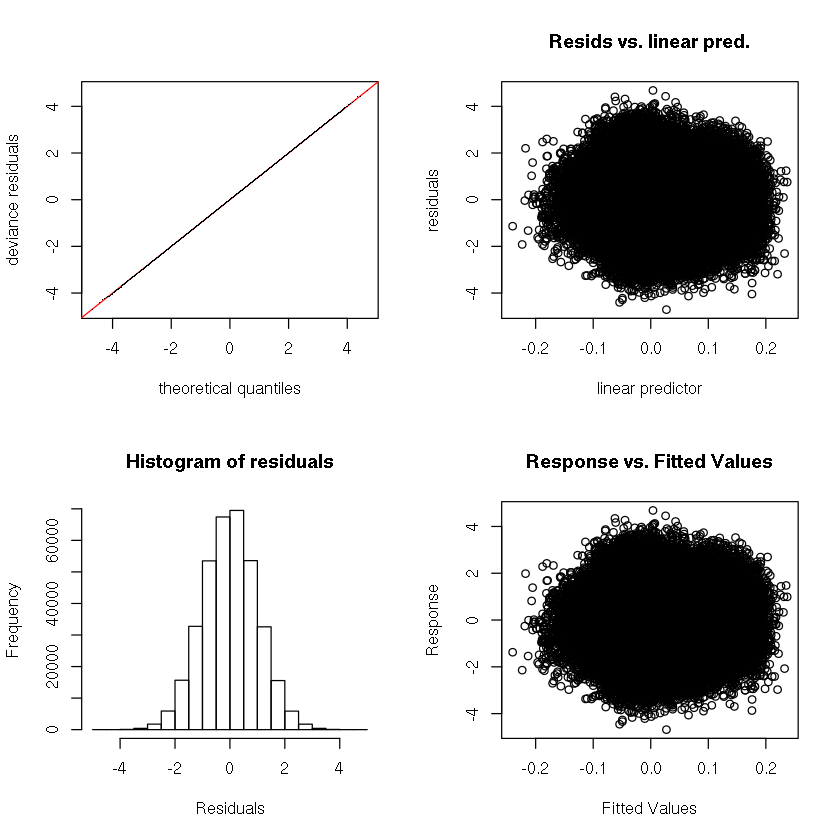


Method: ML   Optimizer: outer newton
full convergence after 7 iterations.
Gradient range [-0.0001144797,-2.391008e-06]
(score 505789.7 & scale 0.9976147).
Hessian positive definite, eigenvalue range [0.2287093,178380.5].
Model rank =  62 / 62 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

                k'   edf k-index p-value  
s(GRS_WT_IR) 49.00  1.77    0.98    0.09 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Resid. Df Resid. Dev Df      Deviance F        Pr(>F)   
1 356747.0  355898.2        NA       NA       NA        NA
2 356745.7  355895.9   1.30378 2.241778 1.723554 0.1883169

Resid. Df Resid. Dev Df        Deviance  F        Pr(>F)   
1 356745.7  355895.9          NA        NA       NA        NA
2 356745.3  355895.3   0.4395194 0.6416545 1.463391 0.1919357

[1] 1011610

[1] 1011610

[1] 1011610

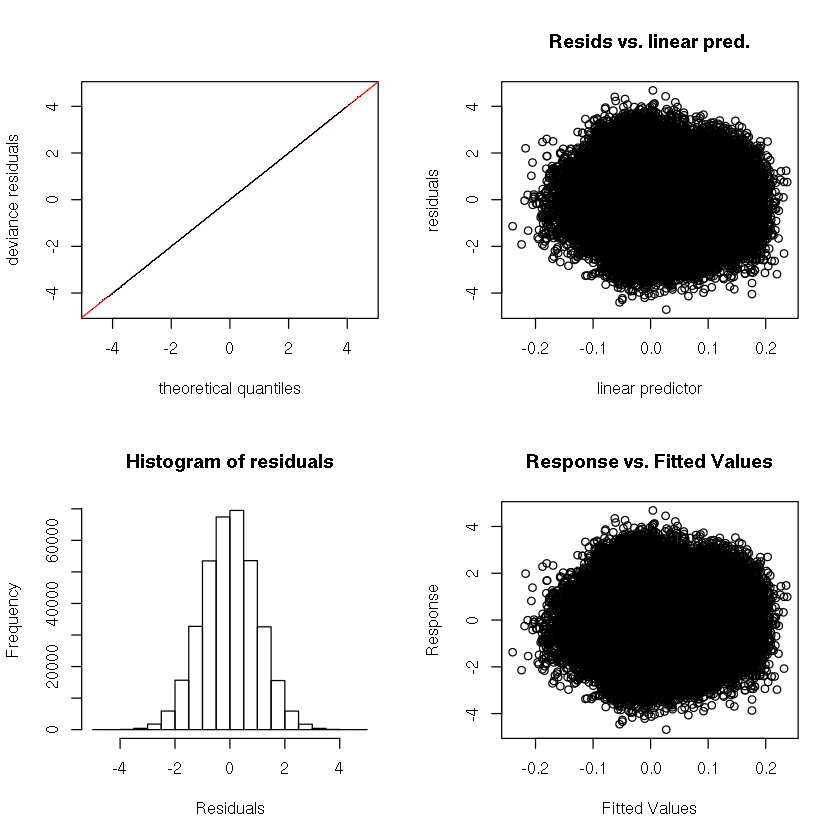

In [54]:
#IR-PRS vs. EGFR (Overall)
#gaussian
#linear
m1 <- gam(EGFR_tresid.0.0 ~ GRS_WT_IR + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10,data=UKBB_AG2,family="gaussian",method="ML")
summary(m1)
#third knot
m2 <- gam(EGFR_tresid.0.0 ~ s(GRS_WT_IR,k=20,bs='cr') + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10,data=UKBB_AG2,family="gaussian",method="ML")
summary(m2)
gam.check(m2)
#ten knot
m3 <- gam(EGFR_tresid.0.0 ~ s(GRS_WT_IR,k=50,bs="cr") + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10,data=UKBB_AG2,family="gaussian",method="ML")
summary(m3)
gam.check(m3)
#compare models
anova(m1,m2,test="F")
anova(m2,m3,test="F")
AIC(m1)
AIC(m2)
AIC(m3)


Family: gaussian 
Link function: identity 

Formula:
EGFR.0.0 ~ GRS_WT_IR + AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + 
    PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10

Parametric coefficients:
             Estimate Std. Error  t value Pr(>|t|)    
(Intercept) 134.62183    0.18041  746.222  < 2e-16 ***
GRS_WT_IR    -1.16810    0.49977   -2.337 0.019424 *  
AGE.0.0      -0.75731    0.00240 -315.595  < 2e-16 ***
SEX.0.0Male  -0.14375    0.03853   -3.731 0.000191 ***
PC1         -12.93513    1.11796  -11.570  < 2e-16 ***
PC2          24.66727    1.35717   18.176  < 2e-16 ***
PC3          -3.91842    1.97544   -1.984 0.047305 *  
PC4           2.77296    2.20097    1.260 0.207712    
PC5          19.39953    2.43506    7.967 1.63e-15 ***
PC6          15.99530    2.63972    6.059 1.37e-09 ***
PC7           0.08699    2.89634    0.030 0.976040    
PC8           4.90425    3.05150    1.607 0.108021    
PC9           2.73484    3.06179    0.893 0.371741    
PC10          3.30313    3.10775    1.063 0


Family: gaussian 
Link function: identity 

Formula:
EGFR.0.0 ~ s(GRS_WT_IR, k = 20, bs = "cr") + AGE.0.0 + SEX.0.0 + 
    PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10

Parametric coefficients:
             Estimate Std. Error  t value Pr(>|t|)    
(Intercept) 134.35399    0.13928  964.636  < 2e-16 ***
AGE.0.0      -0.75731    0.00240 -315.597  < 2e-16 ***
SEX.0.0Male  -0.14376    0.03853   -3.731 0.000191 ***
PC1         -12.93547    1.11796  -11.571  < 2e-16 ***
PC2          24.66165    1.35717   18.171  < 2e-16 ***
PC3          -3.91614    1.97543   -1.982 0.047433 *  
PC4           2.76717    2.20096    1.257 0.208663    
PC5          19.40113    2.43505    7.967 1.62e-15 ***
PC6          15.99342    2.63971    6.059 1.37e-09 ***
PC7           0.07975    2.89634    0.028 0.978032    
PC8           4.89979    3.05150    1.606 0.108341    
PC9           2.73433    3.06178    0.893 0.371830    
PC10          3.30197    3.10774    1.062 0.288010    
---
Signif. codes:  0


Method: ML   Optimizer: outer newton
full convergence after 5 iterations.
Gradient range [-0.00113492,-0.0002065391]
(score 1376278 & scale 131.3105).
Hessian positive definite, eigenvalue range [0.1864398,178380.5].
Model rank =  32 / 32 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

                k'   edf k-index p-value
s(GRS_WT_IR) 19.00  1.66       1    0.37


Resid. Df Resid. Dev Df       Deviance F       Pr(>F)   
1 356747.0  46844917         NA       NA      NA        NA
2 356745.5  46844538   1.542947 379.0722 1.87099 0.1636302

[1] 2752587

[1] 2752586

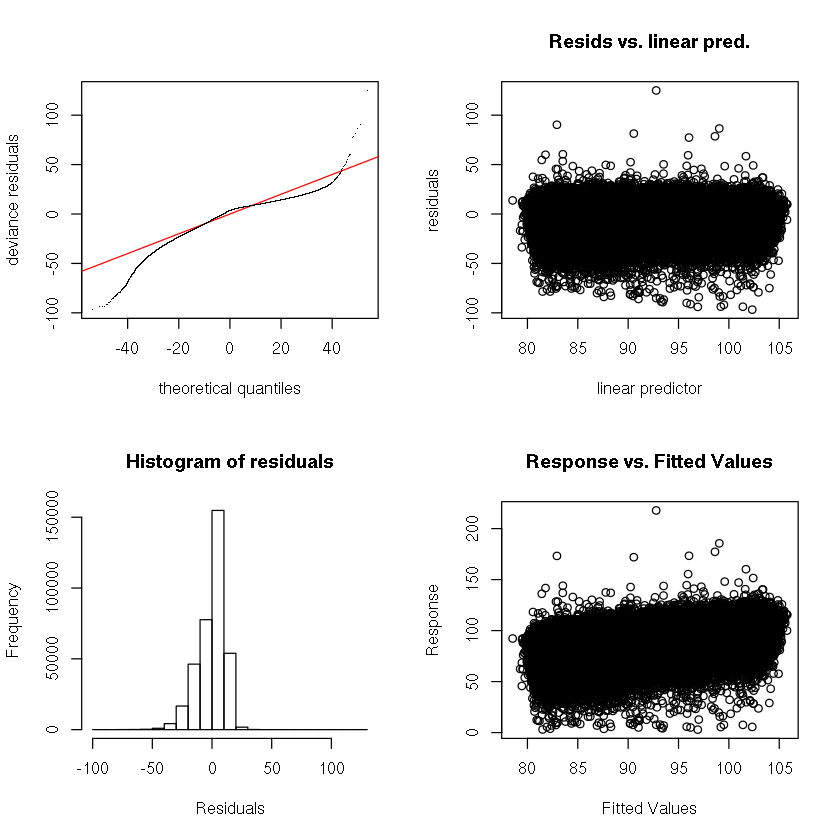

In [15]:
#IR-PRS vs. EGFR (Overall)
#gaussian
#linear
m1 <- gam(EGFR.0.0 ~ GRS_WT_IR + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10,data=UKBB_AG2,family="gaussian",method="ML")
summary(m1)
#third knot
m2 <- gam(EGFR.0.0 ~ s(GRS_WT_IR,k=20,bs="cr") + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10,data=UKBB_AG2,family="gaussian",method="ML")
summary(m2)
gam.check(m2)
#compare models
anova(m1,m2,test="F")
AIC(m1)
AIC(m2)

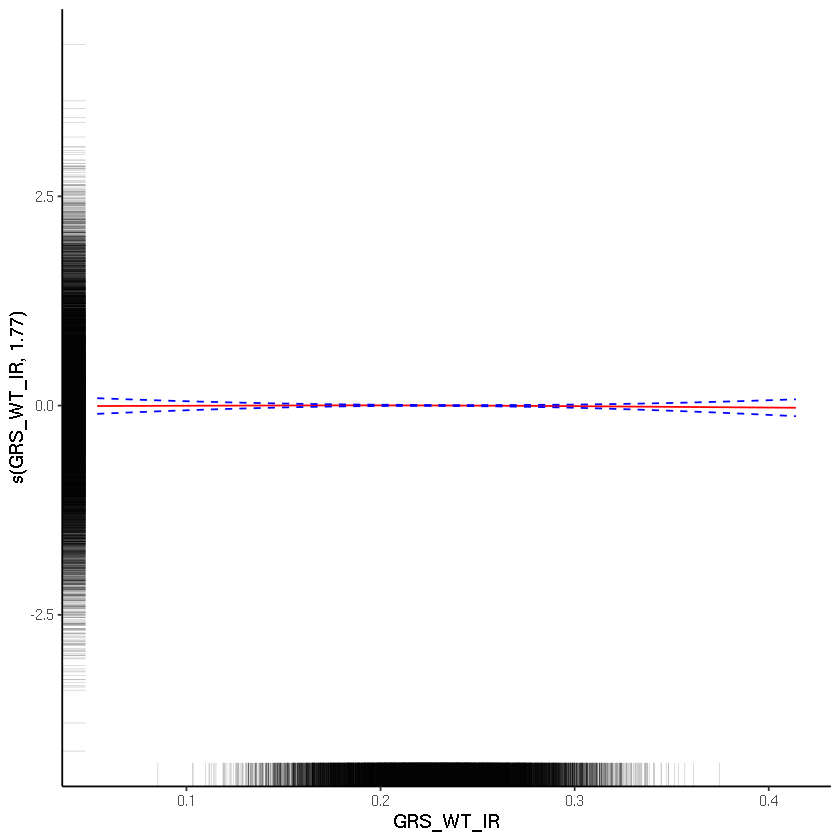

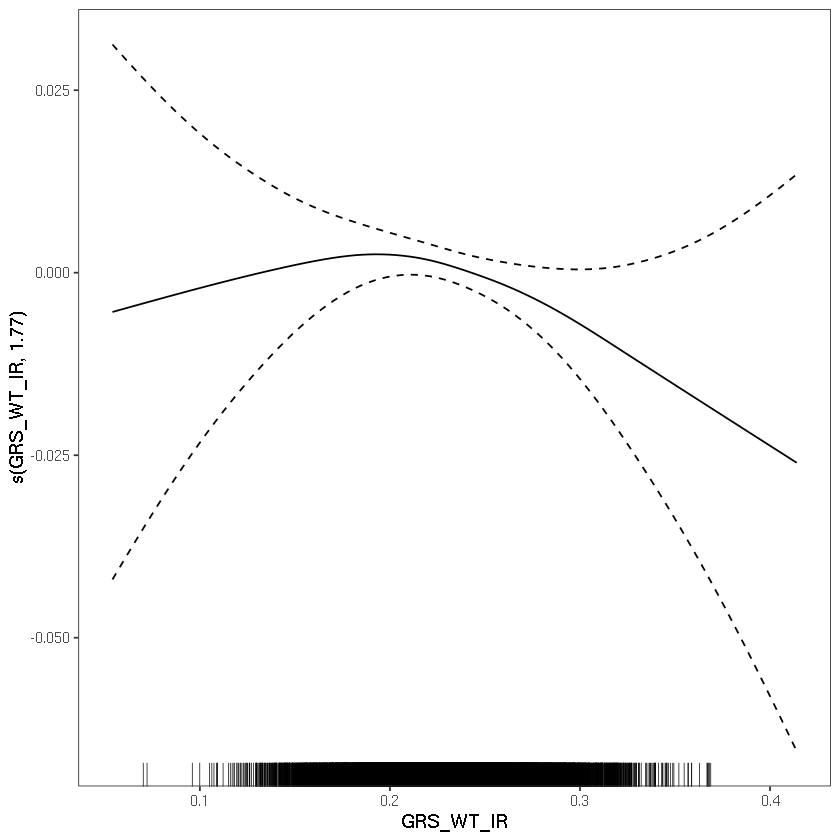

In [55]:
m2v <- getViz(m3)
o <- plot(sm(m2v, 1))
o + l_fitLine(colour = "red") + l_rug(mapping = aes(x=x, y=y), alpha = 0.2) +
    l_ciLine(mul = 5, colour = "blue", linetype = 2) + theme_classic()
plot(m2v,select=1)

`geom_smooth()` using formula 'y ~ x'



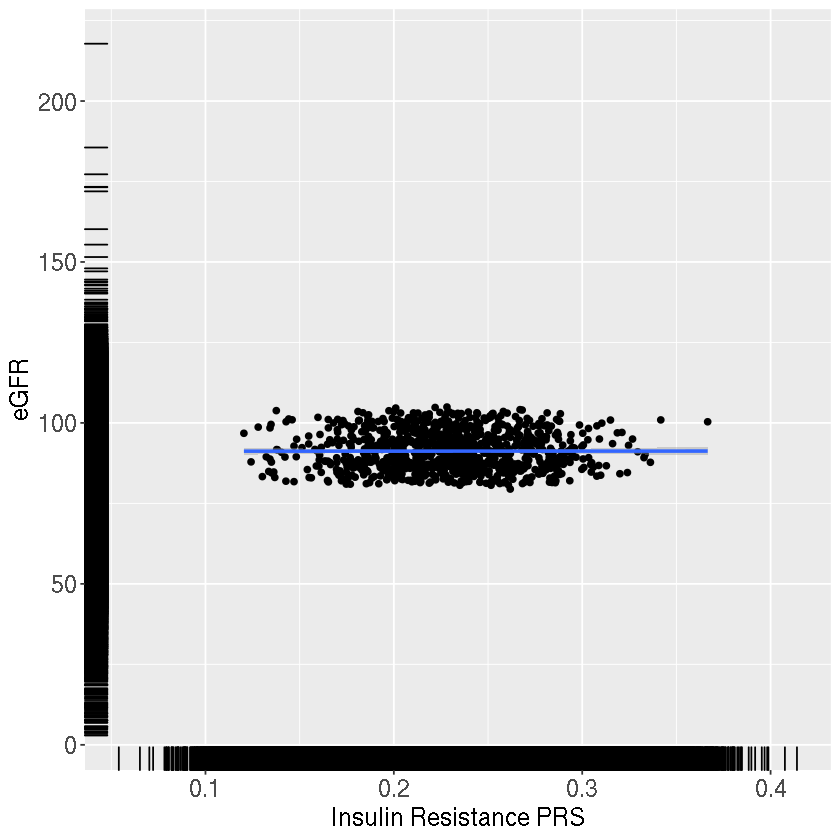

In [16]:
#PLOT: IR-PRS vs. EGFR (Overall)
m1 <- ols(EGFR.0.0 ~ GRS_WT_IR + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10,data=UKBB_AG2)
pred_m1 <- data.frame(eGFR_pred=predict(m1,UKBB_AG2),GRS_WT_IR=UKBB_AG2$GRS_WT_IR)
pred_m1s <- pred_m1 %>% slice_sample(n = 1000)
ggplot(mapping=aes(x=GRS_WT_IR,y=eGFR_pred),data=pred_m1s)+ geom_rug(mapping=aes(x=GRS_WT_IR,y=EGFR.0.0),data=UKBB_AG2) +
        geom_point(aes(x=GRS_WT_IR,y=eGFR_pred),data=pred_m1s) +
        geom_smooth(method="lm", se=TRUE,level=0.95) + scale_x_continuous(name="Insulin Resistance PRS") +
        scale_y_continuous(name="eGFR") + theme(text = element_text(size = 15),
                                                            axis.text=element_text(size = 15)) 


Family: gaussian 
Link function: identity 

Formula:
ACR_tresid.0.0 ~ GRS_WT_IR + AGE.0.0 + SEX.0.0 + PC1 + PC2 + 
    PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10

Parametric coefficients:
             Estimate Std. Error  t value Pr(>|t|)    
(Intercept)  3.583683   0.012774  280.547  < 2e-16 ***
GRS_WT_IR    0.323858   0.035369    9.156  < 2e-16 ***
AGE.0.0     -0.058900   0.000170 -346.544  < 2e-16 ***
SEX.0.0Male -0.630809   0.002726 -231.394  < 2e-16 ***
PC1          0.019444   0.079332    0.245 0.806383    
PC2          0.134995   0.096198    1.403 0.160528    
PC3         -0.190568   0.140433   -1.357 0.174780    
PC4          0.527890   0.156175    3.380 0.000725 ***
PC5          0.234694   0.172415    1.361 0.173446    
PC6          0.859695   0.186957    4.598 4.26e-06 ***
PC7          1.181959   0.205117    5.762 8.30e-09 ***
PC8         -0.094757   0.216050   -0.439 0.660959    
PC9          0.374876   0.216936    1.728 0.083979 .  
PC10         0.051373   0.219977    0


Family: gaussian 
Link function: identity 

Formula:
ACR_tresid.0.0 ~ s(GRS_WT_IR, k = 20, bs = "cr") + AGE.0.0 + 
    SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
    PC9 + PC10

Parametric coefficients:
             Estimate Std. Error  t value Pr(>|t|)    
(Intercept)  3.657985   0.009866  370.755  < 2e-16 ***
AGE.0.0     -0.058900   0.000170 -346.544  < 2e-16 ***
SEX.0.0Male -0.630809   0.002726 -231.394  < 2e-16 ***
PC1          0.019438   0.079332    0.245 0.806440    
PC2          0.134966   0.096198    1.403 0.160619    
PC3         -0.190557   0.140433   -1.357 0.174806    
PC4          0.527855   0.156175    3.380 0.000725 ***
PC5          0.234708   0.172415    1.361 0.173419    
PC6          0.859682   0.186957    4.598 4.26e-06 ***
PC7          1.181921   0.205117    5.762 8.31e-09 ***
PC8         -0.094789   0.216050   -0.439 0.660854    
PC9          0.374867   0.216936    1.728 0.083987 .  
PC10         0.051350   0.219977    0.233 0.815424    
---
Signif


Method: ML   Optimizer: outer newton
full convergence after 6 iterations.
Gradient range [-0.0437042,-0.0008787694]
(score 443356.1 & scale 0.6705167).
Hessian positive definite, eigenvalue range [0.04273224,181842.5].
Model rank =  32 / 32 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

                k'   edf k-index p-value
s(GRS_WT_IR) 19.00  1.09    1.02    0.86



Family: gaussian 
Link function: identity 

Formula:
ACR_tresid.0.0 ~ s(GRS_WT_IR, k = 50, bs = "cr") + AGE.0.0 + 
    SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
    PC9 + PC10

Parametric coefficients:
             Estimate Std. Error  t value Pr(>|t|)    
(Intercept)  3.657986   0.009866  370.755  < 2e-16 ***
AGE.0.0     -0.058900   0.000170 -346.544  < 2e-16 ***
SEX.0.0Male -0.630809   0.002726 -231.394  < 2e-16 ***
PC1          0.019437   0.079332    0.245 0.806454    
PC2          0.134959   0.096198    1.403 0.160641    
PC3         -0.190554   0.140433   -1.357 0.174812    
PC4          0.527847   0.156175    3.380 0.000725 ***
PC5          0.234712   0.172415    1.361 0.173413    
PC6          0.859679   0.186957    4.598 4.26e-06 ***
PC7          1.181912   0.205117    5.762 8.31e-09 ***
PC8         -0.094796   0.216050   -0.439 0.660829    
PC9          0.374865   0.216936    1.728 0.083989 .  
PC10         0.051345   0.219977    0.233 0.815444    
---
Signif

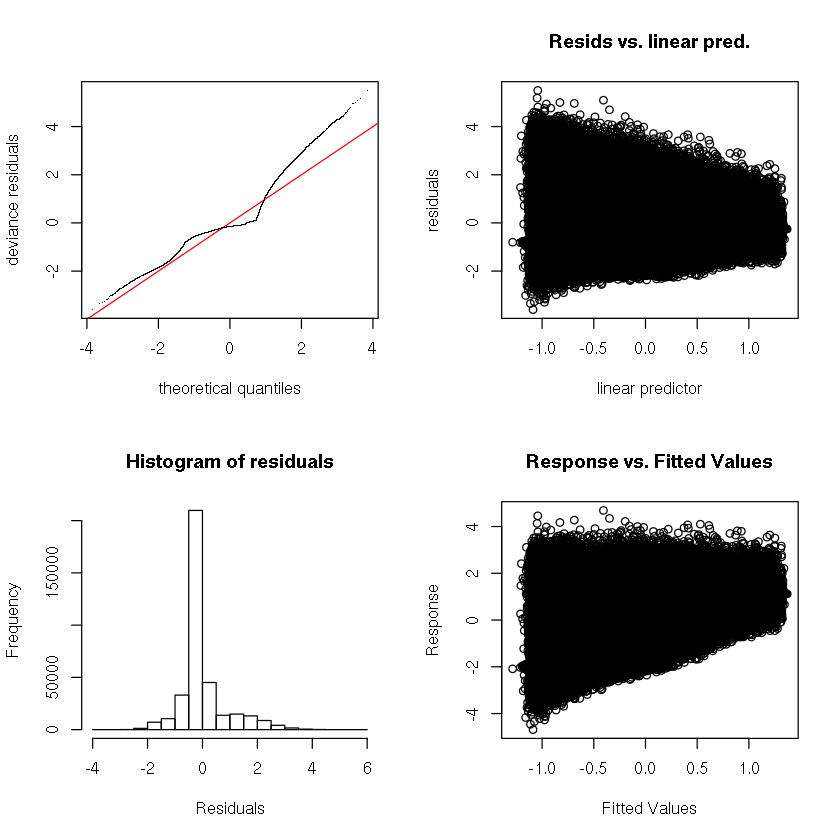


Method: ML   Optimizer: outer newton
full convergence after 6 iterations.
Gradient range [-0.02980203,-8.145144e-05]
(score 443356.1 & scale 0.6705167).
Hessian positive definite, eigenvalue range [0.03196877,181842.5].
Model rank =  62 / 62 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

                k'   edf k-index p-value
s(GRS_WT_IR) 49.00  1.11    1.02    0.93


Resid. Df Resid. Dev Df        Deviance F         Pr(>F)   
1 363671.0  243847.5          NA       NA        NA        NA
2 363670.7  243847.4   0.2571271 0.102507 0.5945606 0.2425088

Resid. Df Resid. Dev Df         Deviance   F         Pr(>F)   
1 363670.7  243847.4           NA         NA        NA        NA
2 363670.7  243847.4   0.06339812 0.02401041 0.5648247 0.1046859

[1] 886742.1

[1] 886742.3

[1] 886742.3

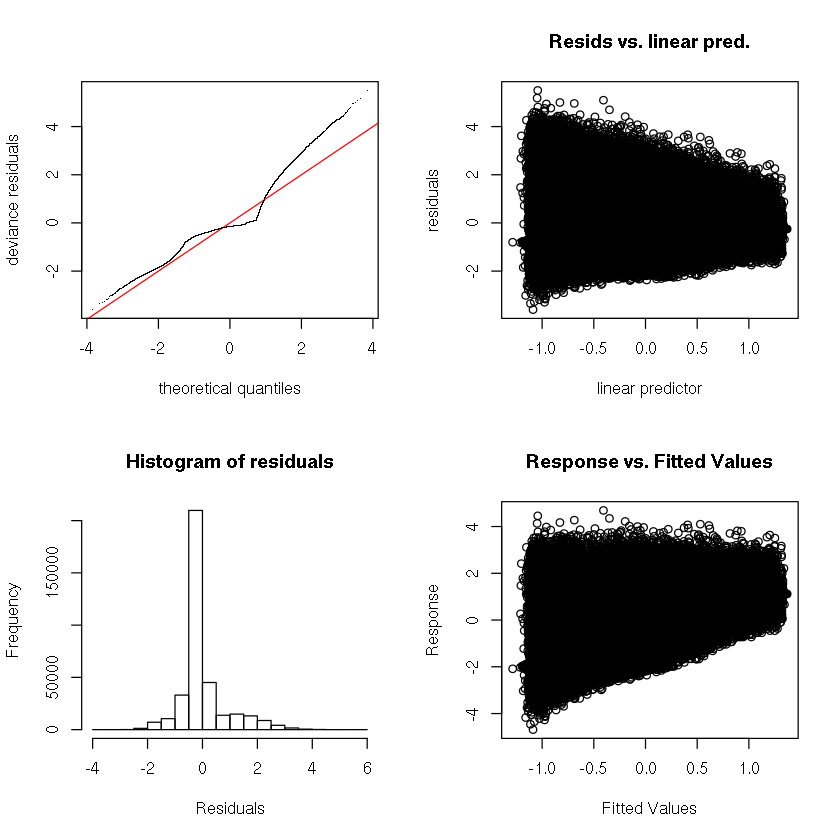

In [48]:
#ACR vs. IR-PRS(Overall)
#gaussian
#linear
m1 <- gam(ACR_tresid.0.0 ~ GRS_WT_IR + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10,data=UKBB_AG2,family="gaussian",method="ML")
summary(m1)
#third knot
m2 <- gam(ACR_tresid.0.0 ~ s(GRS_WT_IR,k=20,bs="cr") + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10,data=UKBB_AG2,family="gaussian",method="ML")
summary(m2)
gam.check(m2)
#ten knot
m3 <- gam(ACR_tresid.0.0 ~ s(GRS_WT_IR,k=50,bs="cr") + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10,data=UKBB_AG2,family="gaussian",method="ML")
summary(m3)
gam.check(m3)
#compare models
anova(m1,m2,test="F")
anova(m2,m3,test="F")
AIC(m1)
AIC(m2)
AIC(m3)

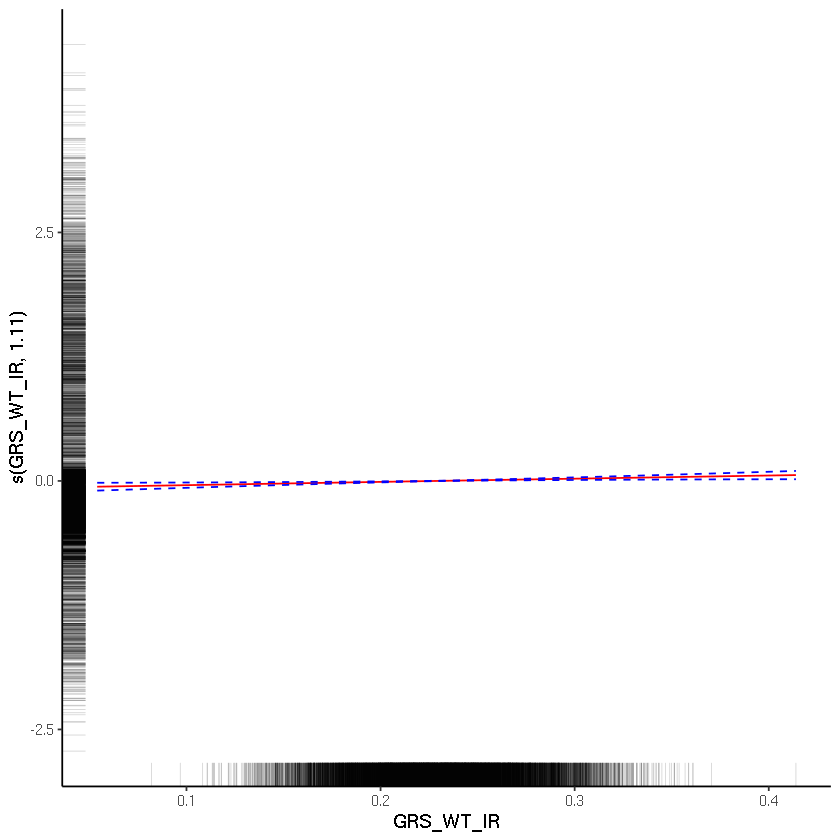

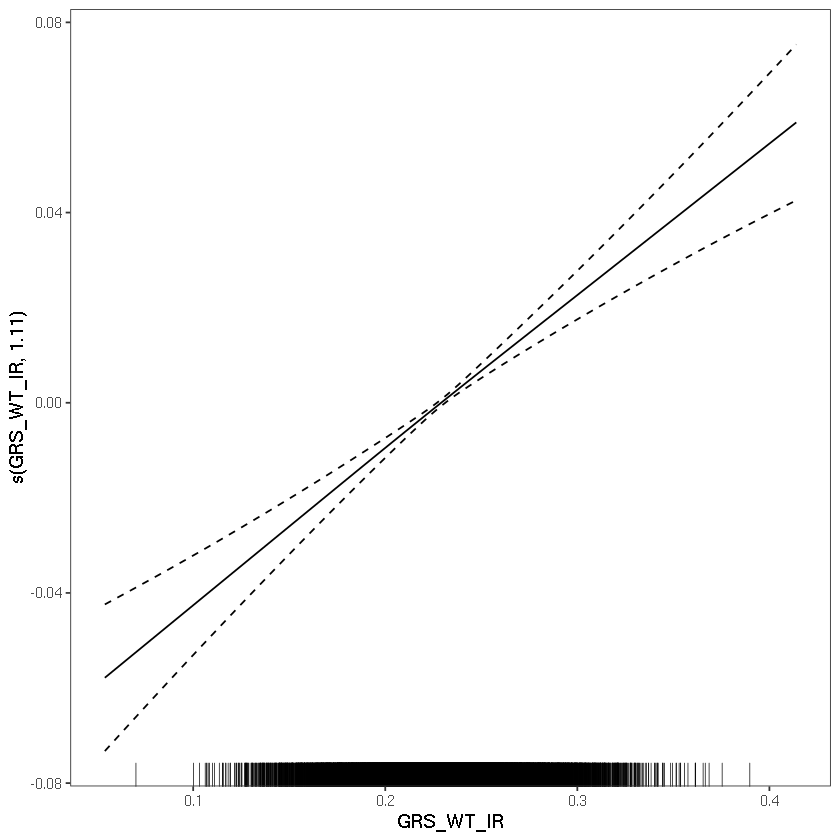

In [49]:
m2v <- getViz(m3)
o <- plot(sm(m2v, 1))
o + l_fitLine(colour = "red") + l_rug(mapping = aes(x=x, y=y), alpha = 0.2) +
    l_ciLine(mul = 5, colour = "blue", linetype = 2) + theme_classic()
plot(m2v,select=1)

Low          High         Diff.        Effect       
GRS_WT_IR              0.203400000  0.255286240  0.051886240  0.0168037734
AGE.0.0               51.000000000 64.000000000 13.000000000 -0.7656965463
PC1                   -0.007214946  0.005019935  0.012234881  0.0002378951
PC2                   -0.009684046  0.006451929  0.016135975  0.0021782715
PC3                   -0.002028366  0.003953506  0.005981872 -0.0011399528
PC4                   -0.005253158  0.003202142  0.008455300  0.0044634642
PC5                   -0.004491264  0.005089906  0.009581170  0.0022486397
PC6                   -0.004112781  0.003762518  0.007875298  0.0067703538
PC7                   -0.004261957  0.004472630  0.008734587  0.0103239247
PC8                   -0.003626992  0.004163412  0.007790404 -0.0007381987
PC9                   -0.003713929  0.003816166  0.007530096  0.0028228541
PC10                  -0.003924822  0.004160545  0.008085367  0.0004153716
SEX.0.0 - Male:Female  1.000000000  2.000000000           NA -0.6308088161
                      S.E.         Lower 0.95    Upper 0.95    Type
GRS_WT_IR             0.0018351916  0.0132068520  0.0204006948 1   
AGE.0.0               0.0022095228 -0.7700271459 -0.7613659467 1   
PC1                   0.0009706229 -0.0016644970  0.0021402873 1   
PC2                   0.0015522499 -0.0008640924  0.0052206355 1   
PC3                   0.0008400505 -0.0027864270  0.0005065213 1   
PC4                   0.0013205087  0.0018753062  0.0070516223 1   
PC5                   0.0016519342 -0.0009891026  0.0054863820 1   
PC6                   0.0014723411  0.0038846087  0.0096560989 1   
PC7                   0.0017916086  0.0068124246  0.0138354248 1   
PC8                   0.0016831192 -0.0040370626  0.0025606652 1   
PC9                   0.0016335450 -0.0003788460  0.0060245541 1   
PC10                  0.0017785948 -0.0030706216  0.0039013649 1   
SEX.0.0 - Male:Female 0.0027261228 -0.6361519364 -0.6254656958 1

d.f.   Partial SS   MS           F            P           
GRS_WT_IR      1 5.621607e+01 5.621607e+01 8.383991e+01 0.000000e+00
AGE.0.0        1 8.052414e+04 8.052414e+04 1.200926e+05 0.000000e+00
SEX.0.0        1 3.590165e+04 3.590165e+04 5.354324e+04 0.000000e+00
PC1            1 4.027911e-02 4.027911e-02 6.007173e-02 8.063827e-01
PC2            1 1.320415e+00 1.320415e+00 1.969250e+00 1.605284e-01
PC3            1 1.234732e+00 1.234732e+00 1.841463e+00 1.747804e-01
PC4            1 7.660750e+00 7.660750e+00 1.142514e+01 7.246451e-04
PC5            1 1.242407e+00 1.242407e+00 1.852910e+00 1.734462e-01
PC6            1 1.417802e+01 1.417802e+01 2.114491e+01 4.259735e-06
PC7            1 2.226451e+01 2.226451e+01 3.320499e+01 8.300404e-09
PC8            1 1.289812e-01 1.289812e-01 1.923609e-01 6.609591e-01
PC9            1 2.002278e+00 2.002278e+00 2.986171e+00 8.397939e-02
PC10           1 3.657037e-02 3.657037e-02 5.454057e-02 8.153428e-01
TOTAL         13 1.197399e+05 9.210765e+03 1.373681e+04 0.000000e+00
ERROR     363671 2.438475e+05 6.705168e-01           NA           NA

`geom_smooth()` using formula 'y ~ x'



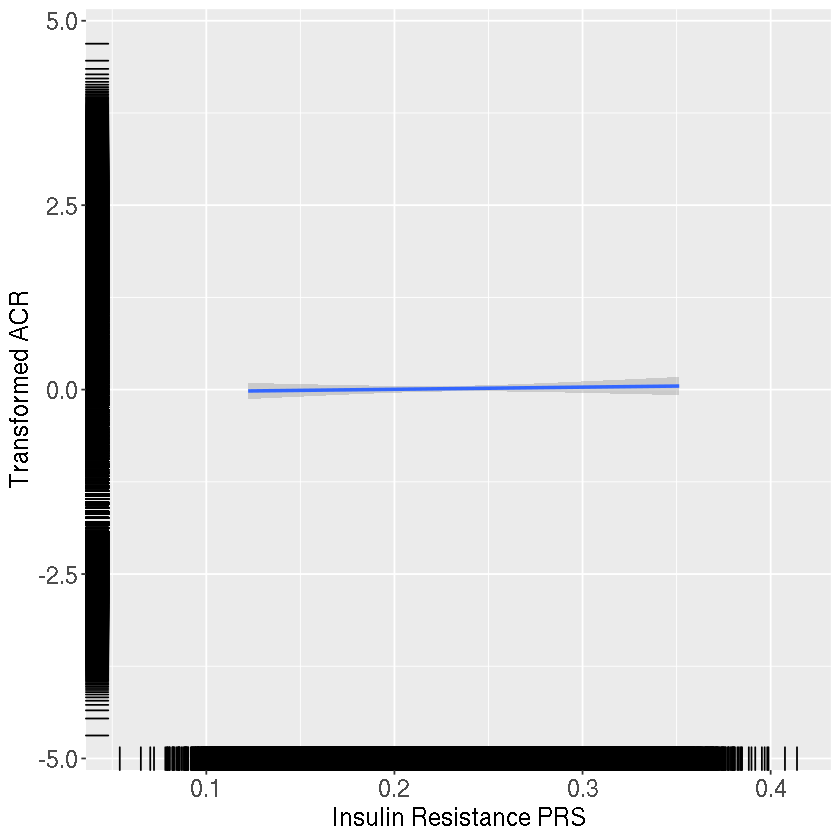

In [44]:
#PLOT: IR-PRS vs. ACR residual (Overall)
m1 <- ols(ACR_tresid.0.0 ~ GRS_WT_IR + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10,data=UKBB_AG2)
summary(m1)
anova(m1)
pred_m1 <- data.frame(eGFR_pred=predict(m1,UKBB_AG2),GRS_WT_IR=UKBB_AG2$GRS_WT_IR)
pred_m1s <- pred_m1 %>% slice_sample(n = 1000)
ggplot(mapping=aes(x=GRS_WT_IR,y=eGFR_pred),data=pred_m1s)+ geom_rug(mapping=aes(x=GRS_WT_IR,y=ACR_tresid.0.0),data=UKBB_AG2) +
        geom_smooth(method="lm", se=TRUE,level=0.95) + scale_x_continuous(name="Insulin Resistance PRS") +
        scale_y_continuous(name="Transformed ACR") + theme(text = element_text(size = 15),
                                                            axis.text=element_text(size = 15)) 

In [19]:
#IR-PRS vs. ACR (Overall) - linear
#gaussian
#linear
m1 <- gam(ACR.0.0 ~ GRS_WT_IR + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10,data=UKBB_AG2,family="gaussian",method="ML")
summary(m1)
#third knot
m2 <- gam(ACR.0.0 ~ s(GRS_WT_IR,k=20,bs="cr") + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10,data=UKBB_AG2,family="gaussian",method="ML")
summary(m2)
#compare models
anova(m1,m2,test="F")
AIC(m1)
AIC(m2)


Family: gaussian 
Link function: identity 

Formula:
ACR.0.0 ~ GRS_WT_IR + AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + PC4 + 
    PC5 + PC6 + PC7 + PC8 + PC9 + PC10

Parametric coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -0.76173    1.04516  -0.729 0.466117    
GRS_WT_IR     5.92249    2.89394   2.047 0.040707 *  
AGE.0.0       0.19835    0.01391  14.263  < 2e-16 ***
SEX.0.0Male   1.53507    0.22305   6.882 5.91e-12 ***
PC1           1.57566    6.49099   0.243 0.808202    
PC2          19.97818    7.87095   2.538 0.011142 *  
PC3         -41.48312   11.49023  -3.610 0.000306 ***
PC4          10.69806   12.77829   0.837 0.402477    
PC5          13.42265   14.10700   0.951 0.341357    
PC6          53.31057   15.29685   3.485 0.000492 ***
PC7          25.42064   16.78268   1.515 0.129851    
PC8          -3.56467   17.67728  -0.202 0.840188    
PC9           3.55839   17.74970   0.200 0.841108    
PC10         15.26272   17.99856   0.848 0.396440    
---



Family: gaussian 
Link function: identity 

Formula:
ACR.0.0 ~ s(GRS_WT_IR, k = 20, bs = "cr") + AGE.0.0 + SEX.0.0 + 
    PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10

Parametric coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)   0.59704    0.80726   0.740 0.459551    
AGE.0.0       0.19835    0.01391  14.263  < 2e-16 ***
SEX.0.0Male   1.53507    0.22305   6.882 5.91e-12 ***
PC1           1.57566    6.49099   0.243 0.808203    
PC2          19.97793    7.87095   2.538 0.011143 *  
PC3         -41.48298   11.49023  -3.610 0.000306 ***
PC4          10.69778   12.77829   0.837 0.402490    
PC5          13.42279   14.10700   0.951 0.341352    
PC6          53.31045   15.29685   3.485 0.000492 ***
PC7          25.42038   16.78268   1.515 0.129854    
PC8          -3.56482   17.67728  -0.202 0.840182    
PC9           3.55838   17.74970   0.200 0.841109    
PC10         15.26260   17.99856   0.848 0.396444    
---
Signif. codes:  0 ‘***’ 0.001 ‘*

Resid. Df Resid. Dev Df         Deviance F         Pr(>F)   
1 363671.0  1632447730         NA       NA        NA        NA
2 363670.9  1632447664 0.07270009 65.72779 0.2014111 0.1470672

[1] 4090461

[1] 4090461

`geom_smooth()` using formula 'y ~ x'



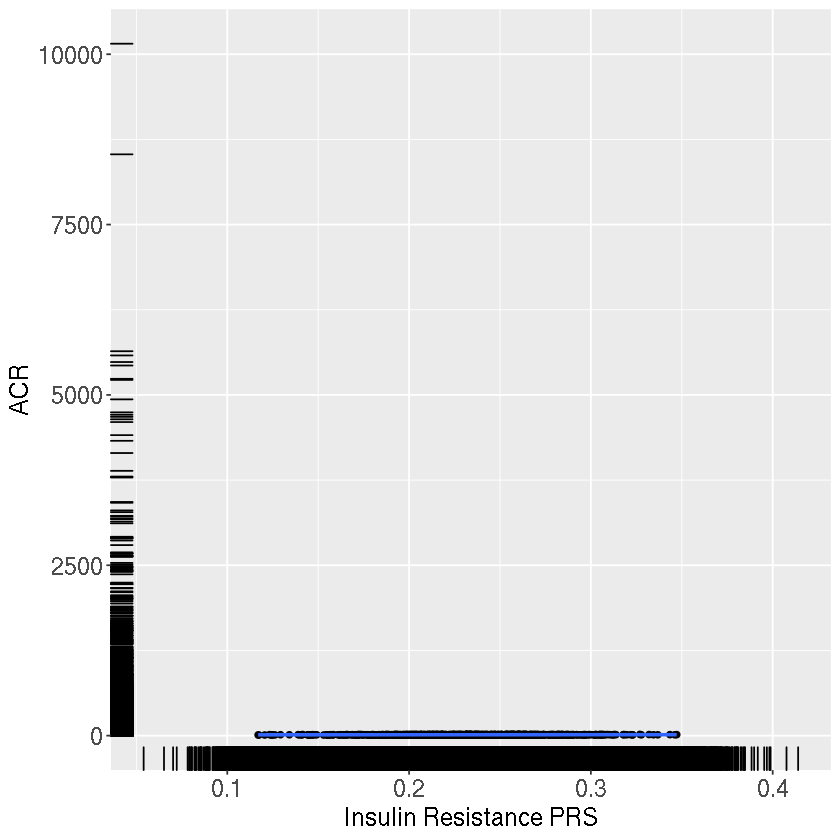

In [20]:
#PLOT: IR-PRS vs. ACR (Overall)
m1 <- ols(ACR.0.0 ~ GRS_WT_IR + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10,data=UKBB_AG2)
pred_m1 <- data.frame(eGFR_pred=predict(m1,UKBB_AG2),GRS_WT_IR=UKBB_AG2$GRS_WT_IR)
pred_m1s <- pred_m1 %>% slice_sample(n = 1000)
ggplot(mapping=aes(x=GRS_WT_IR,y=eGFR_pred),data=pred_m1s)+ geom_rug(mapping=aes(x=GRS_WT_IR,y=ACR.0.0),data=UKBB_AG2) +
        geom_point(aes(x=GRS_WT_IR,y=eGFR_pred),data=pred_m1s) +
        geom_smooth(method="lm", se=TRUE,level=0.95) + scale_x_continuous(name="Insulin Resistance PRS") +
        scale_y_continuous(name="ACR") + theme(text = element_text(size = 15),
                                                            axis.text=element_text(size = 15)) 

`geom_smooth()` using formula 'y ~ x'



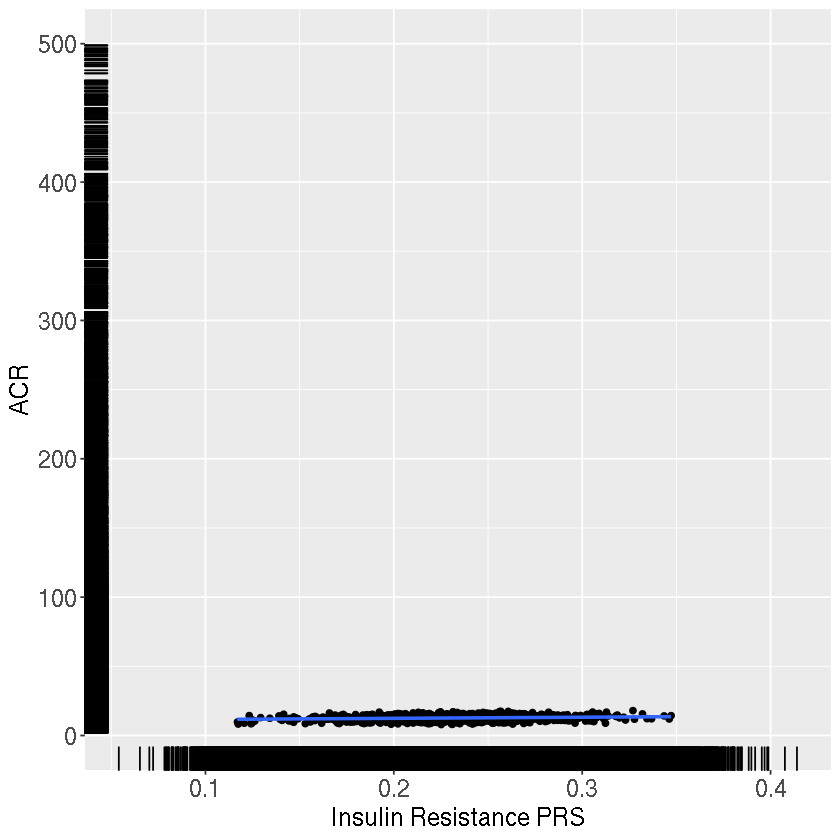

In [21]:
ggplot(mapping=aes(x=GRS_WT_IR,y=eGFR_pred),data=pred_m1s)+ geom_rug(mapping=aes(x=GRS_WT_IR,y=ACR.0.0),data=UKBB_AG2) +
        geom_point(aes(x=GRS_WT_IR,y=eGFR_pred),data=pred_m1s) +
        geom_smooth(method="lm", se=TRUE,level=0.95) + scale_x_continuous(name="Insulin Resistance PRS") +
        scale_y_continuous(name="ACR",limits=c(0,500)) + theme(text = element_text(size = 15),
                                                            axis.text=element_text(size = 15)) 


Family: gaussian 
Link function: identity 

Formula:
ACR_tresid.0.0 ~ GRS_WT_IR + AGE.0.0 + SEX.0.0 + PC1 + PC2 + 
    PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10

Parametric coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  3.343820   0.095061  35.175  < 2e-16 ***
GRS_WT_IR    0.668457   0.225769   2.961  0.00307 ** 
AGE.0.0     -0.051869   0.001279 -40.542  < 2e-16 ***
SEX.0.0Male -0.376776   0.017822 -21.141  < 2e-16 ***
PC1         -0.119184   0.502774  -0.237  0.81262    
PC2          0.663019   0.606734   1.093  0.27451    
PC3         -1.854980   0.972302  -1.908  0.05643 .  
PC4          0.813323   0.998469   0.815  0.41533    
PC5         -0.439003   1.099326  -0.399  0.68965    
PC6          1.544428   1.197101   1.290  0.19702    
PC7          0.060040   1.320535   0.045  0.96374    
PC8          0.909144   1.385273   0.656  0.51164    
PC9          0.540241   1.391767   0.388  0.69789    
PC10         0.291956   1.416724   0.206  0.83673  


Family: gaussian 
Link function: identity 

Formula:
ACR_tresid.0.0 ~ s(GRS_WT_IR, k = 20, bs = "cr") + AGE.0.0 + 
    SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
    PC9 + PC10

Parametric coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  3.500387   0.078698  44.479   <2e-16 ***
AGE.0.0     -0.051869   0.001279 -40.542   <2e-16 ***
SEX.0.0Male -0.376776   0.017822 -21.141   <2e-16 ***
PC1         -0.119184   0.502774  -0.237   0.8126    
PC2          0.663020   0.606734   1.093   0.2745    
PC3         -1.854976   0.972302  -1.908   0.0564 .  
PC4          0.813325   0.998469   0.815   0.4153    
PC5         -0.438990   1.099327  -0.399   0.6897    
PC6          1.544426   1.197101   1.290   0.1970    
PC7          0.060044   1.320536   0.045   0.9637    
PC8          0.909126   1.385274   0.656   0.5117    
PC9          0.540225   1.391768   0.388   0.6979    
PC10         0.291944   1.416724   0.206   0.8367    
---
Signif. codes:  0 ‘*


Method: ML   Optimizer: outer newton
full convergence after 6 iterations.
Gradient range [-0.003635985,0.0006088685]
(score 33502.38 & scale 1.526382).
Hessian positive definite, eigenvalue range [0.003620262,10276.5].
Model rank =  32 / 32 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

                k'   edf k-index p-value
s(GRS_WT_IR) 19.00  1.01    1.01     0.8



Family: gaussian 
Link function: identity 

Formula:
ACR_tresid.0.0 ~ s(GRS_WT_IR, k = 50, bs = "cr") + AGE.0.0 + 
    SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
    PC9 + PC10

Parametric coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  3.500389   0.078698  44.479   <2e-16 ***
AGE.0.0     -0.051870   0.001279 -40.542   <2e-16 ***
SEX.0.0Male -0.376776   0.017822 -21.141   <2e-16 ***
PC1         -0.119183   0.502774  -0.237   0.8126    
PC2          0.663023   0.606734   1.093   0.2745    
PC3         -1.854965   0.972303  -1.908   0.0564 .  
PC4          0.813331   0.998470   0.815   0.4153    
PC5         -0.438956   1.099329  -0.399   0.6897    
PC6          1.544423   1.197101   1.290   0.1970    
PC7          0.060054   1.320536   0.045   0.9637    
PC8          0.909075   1.385276   0.656   0.5117    
PC9          0.540178   1.391769   0.388   0.6979    
PC10         0.291912   1.416726   0.206   0.8368    
---
Signif. codes:  0 ‘*

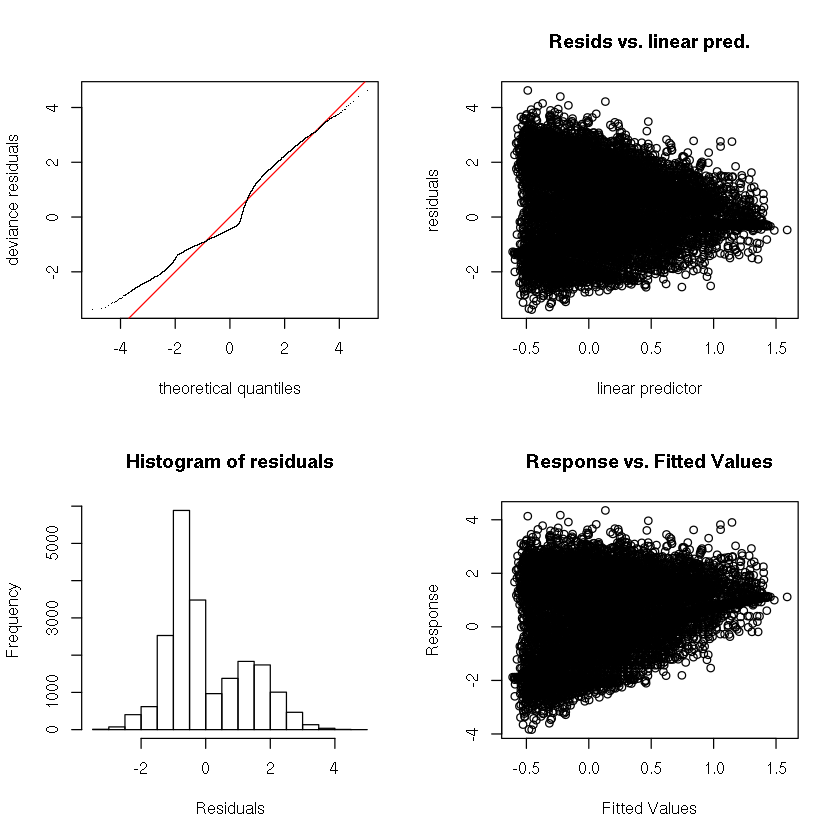


Method: ML   Optimizer: outer newton
full convergence after 7 iterations.
Gradient range [-0.01104928,0.002583783]
(score 33502.39 & scale 1.526383).
Hessian positive definite, eigenvalue range [0.01087077,10276.5].
Model rank =  62 / 62 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

                k'   edf k-index p-value
s(GRS_WT_IR) 49.00  1.02    1.01    0.82


Resid. Df Resid. Dev Df         Deviance    F         Pr(>F)    
1 20539.00  31350.36           NA          NA        NA         NA
2 20538.98  31350.35   0.01852704 0.003613913 0.1277933 0.05555847

Resid. Df Resid. Dev Df         Deviance   F         Pr(>F)   
1 20538.98  31350.35           NA         NA        NA        NA
2 20538.93  31350.34   0.05218242 0.01054805 0.1324294 0.1249402

[1] 67034.75

[1] 67034.77

[1] 67034.83

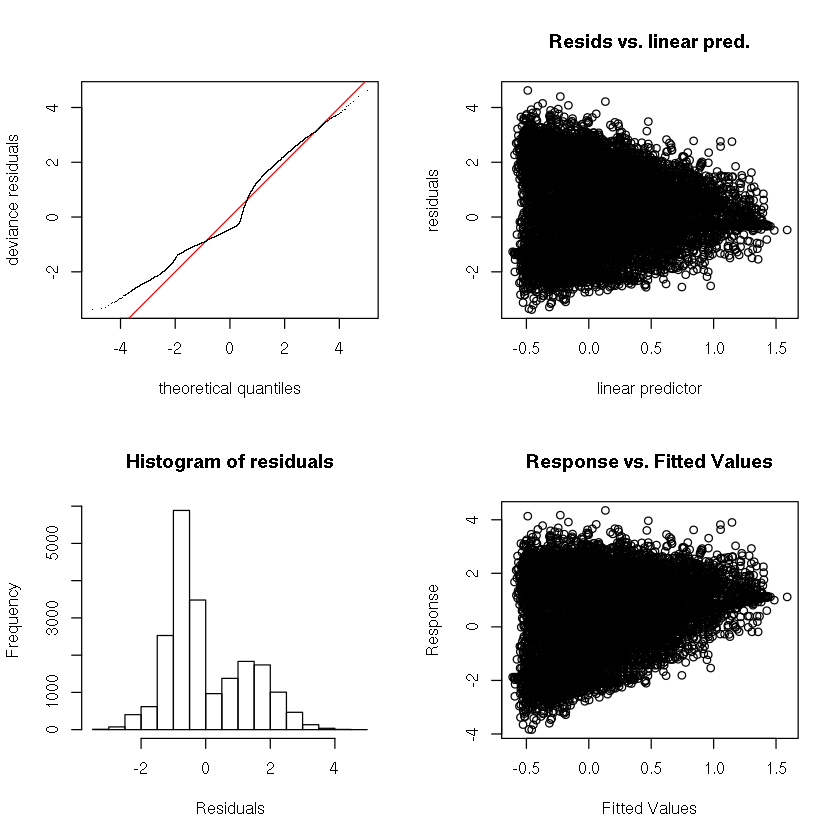

In [50]:
#ACR vs. IR-PRS(T2D)
#gaussian
#linear
m1 <- gam(ACR_tresid.0.0 ~ GRS_WT_IR + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10,data=T2D,family="gaussian",method="ML")
summary(m1)
#third knot
m2 <- gam(ACR_tresid.0.0 ~ s(GRS_WT_IR,k=20,bs="cr") + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10,data=T2D,family="gaussian",method="ML")
summary(m2)
gam.check(m2)
#ten knot
m3 <- gam(ACR_tresid.0.0 ~ s(GRS_WT_IR,k=50,bs="cr") + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10,data=T2D,family="gaussian",method="ML")
summary(m3)
gam.check(m3)
#compare models
anova(m1,m2,test="F")
anova(m2,m3,test="F")
AIC(m1)
AIC(m2)
AIC(m3)

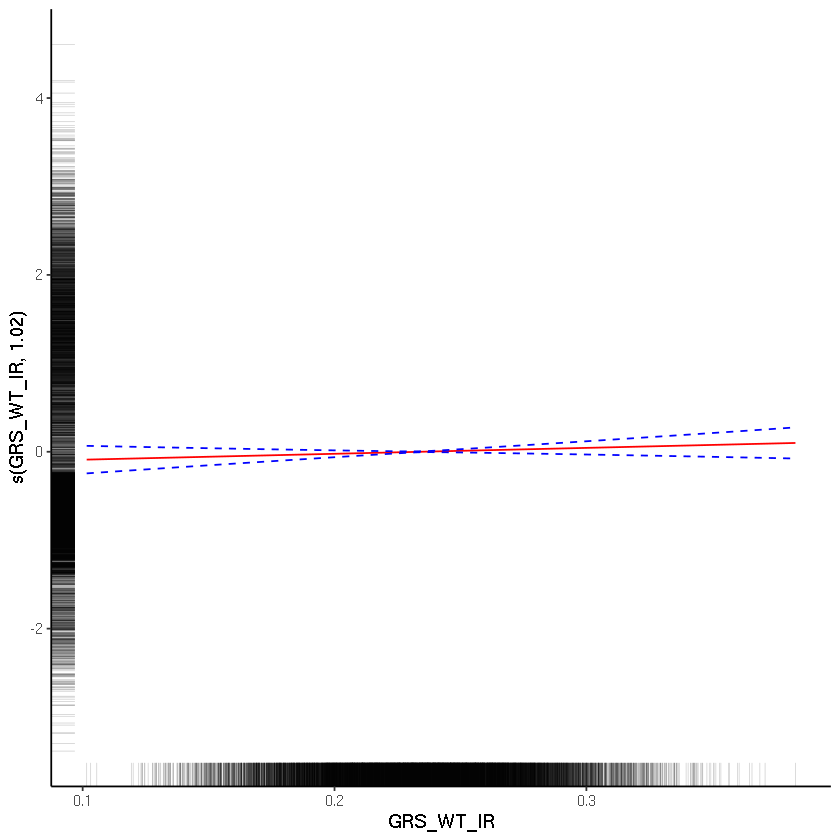

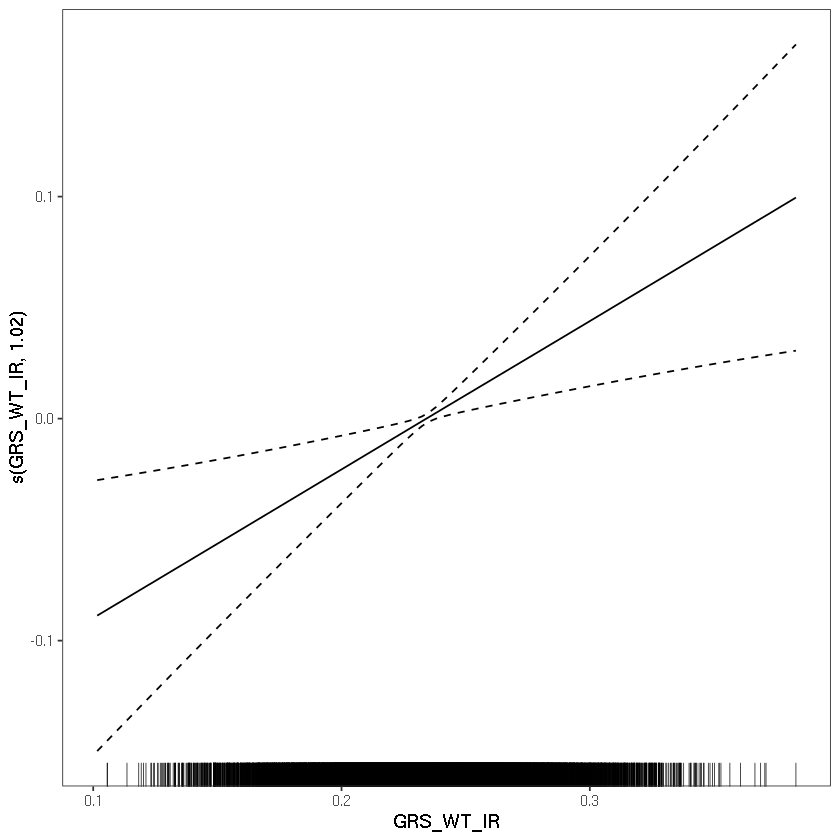

In [51]:
m2v <- getViz(m3)
o <- plot(sm(m2v, 1))
o + l_fitLine(colour = "red") + l_rug(mapping = aes(x=x, y=y), alpha = 0.2) +
    l_ciLine(mul = 5, colour = "blue", linetype = 2) + theme_classic()
plot(m2v,select=1)


Family: gaussian 
Link function: identity 

Formula:
ACR_tresid.0.0 ~ GRS_WT_IR + AGE.0.0 + SEX.0.0 + PC1 + PC2 + 
    PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10

Parametric coefficients:
              Estimate Std. Error  t value Pr(>|t|)    
(Intercept)  3.6986537  0.0124807  296.349  < 2e-16 ***
GRS_WT_IR    0.2133399  0.0346295    6.161 7.25e-10 ***
AGE.0.0     -0.0606661  0.0001659 -365.608  < 2e-16 ***
SEX.0.0Male -0.6632248  0.0026731 -248.111  < 2e-16 ***
PC1          0.0515492  0.0776727    0.664 0.506900    
PC2          0.0573920  0.0942078    0.609 0.542388    
PC3         -0.1258208  0.1368253   -0.920 0.357797    
PC4          0.5009850  0.1528223    3.278 0.001045 ** 
PC5          0.3686724  0.1687456    2.185 0.028905 *  
PC6          0.7040107  0.1829299    3.849 0.000119 ***
PC7          1.2347415  0.2006226    6.155 7.54e-10 ***
PC8         -0.0926250  0.2113663   -0.438 0.661227    
PC9          0.3389417  0.2122261    1.597 0.110249    
PC10         0.0228391 


Family: gaussian 
Link function: identity 

Formula:
ACR_tresid.0.0 ~ s(GRS_WT_IR, k = 20, bs = "cr") + AGE.0.0 + 
    SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
    PC9 + PC10

Parametric coefficients:
              Estimate Std. Error  t value Pr(>|t|)    
(Intercept)  3.7475388  0.0096070  390.085  < 2e-16 ***
AGE.0.0     -0.0606661  0.0001659 -365.608  < 2e-16 ***
SEX.0.0Male -0.6632247  0.0026731 -248.111  < 2e-16 ***
PC1          0.0515440  0.0776727    0.664 0.506944    
PC2          0.0573602  0.0942078    0.609 0.542612    
PC3         -0.1258113  0.1368253   -0.920 0.357833    
PC4          0.5009459  0.1528224    3.278 0.001046 ** 
PC5          0.3686740  0.1687455    2.185 0.028905 *  
PC6          0.7039966  0.1829299    3.848 0.000119 ***
PC7          1.2347059  0.2006227    6.154 7.55e-10 ***
PC8         -0.0926446  0.2113663   -0.438 0.661160    
PC9          0.3389412  0.2122260    1.597 0.110250    
PC10         0.0228239  0.2151515    0.106 0.915517 


Method: ML   Optimizer: outer newton
full convergence after 5 iterations.
Gradient range [-0.252294,-0.03044154]
(score 400999 & scale 0.6061974).
Hessian positive definite, eigenvalue range [0.03065964,171566.3].
Model rank =  32 / 32 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

                k'   edf k-index p-value  
s(GRS_WT_IR) 19.00  1.08    0.97    0.03 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



Family: gaussian 
Link function: identity 

Formula:
ACR_tresid.0.0 ~ s(GRS_WT_IR, k = 50, bs = "cr") + AGE.0.0 + 
    SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
    PC9 + PC10

Parametric coefficients:
              Estimate Std. Error  t value Pr(>|t|)    
(Intercept)  3.7475393  0.0096070  390.085  < 2e-16 ***
AGE.0.0     -0.0606661  0.0001659 -365.608  < 2e-16 ***
SEX.0.0Male -0.6632246  0.0026731 -248.111  < 2e-16 ***
PC1          0.0515406  0.0776727    0.664 0.506971    
PC2          0.0573394  0.0942078    0.609 0.542758    
PC3         -0.1258050  0.1368253   -0.919 0.357857    
PC4          0.5009205  0.1528224    3.278 0.001046 ** 
PC5          0.3686752  0.1687455    2.185 0.028904 *  
PC6          0.7039875  0.1829298    3.848 0.000119 ***
PC7          1.2346829  0.2006227    6.154 7.55e-10 ***
PC8         -0.0926570  0.2113663   -0.438 0.661117    
PC9          0.3389409  0.2122260    1.597 0.110250    
PC10         0.0228143  0.2151515    0.106 0.915552 

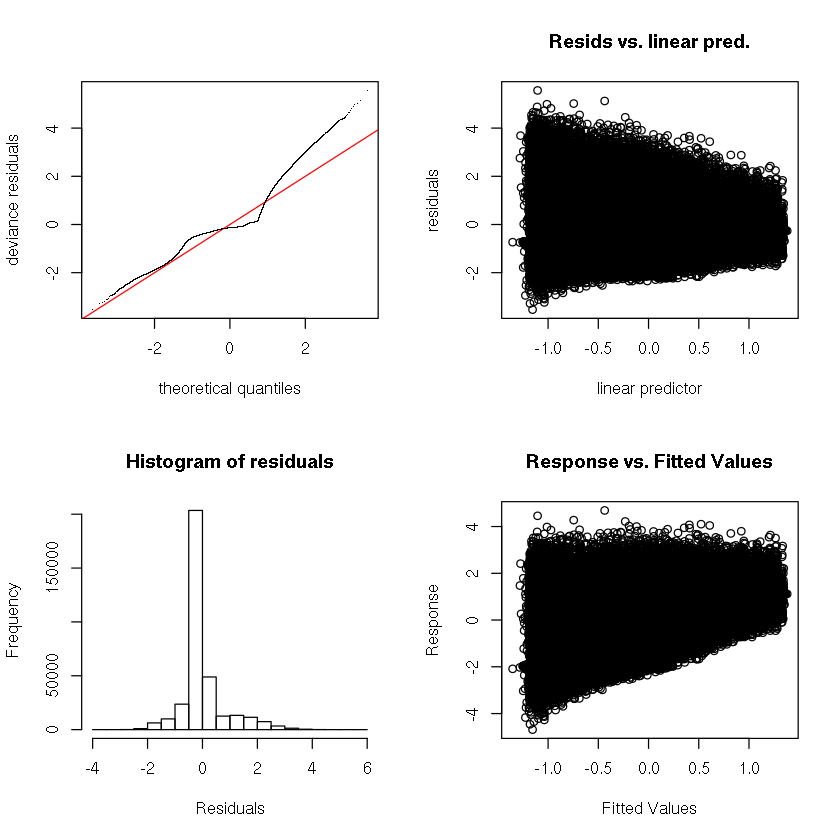


Method: ML   Optimizer: outer newton
full convergence after 6 iterations.
Gradient range [-0.02318769,-0.003541325]
(score 400999 & scale 0.6061973).
Hessian positive definite, eigenvalue range [0.02856506,171566].
Model rank =  62 / 62 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

                k'   edf k-index p-value
s(GRS_WT_IR) 49.00  1.13    0.98    0.12


Resid. Df Resid. Dev Df        Deviance  F         Pr(>F)   
1 343118.0  207997.3          NA        NA        NA        NA
2 343117.8  207997.2   0.2281562 0.1026561 0.7422298 0.2090141

Resid. Df Resid. Dev Df        Deviance   F         Pr(>F)   
1 343117.8  207997.2          NA         NA        NA        NA
2 343117.6  207997.1   0.1461759 0.06382867 0.7203207 0.1653834

[1] 802027.9

[1] 802028.1

[1] 802028.2

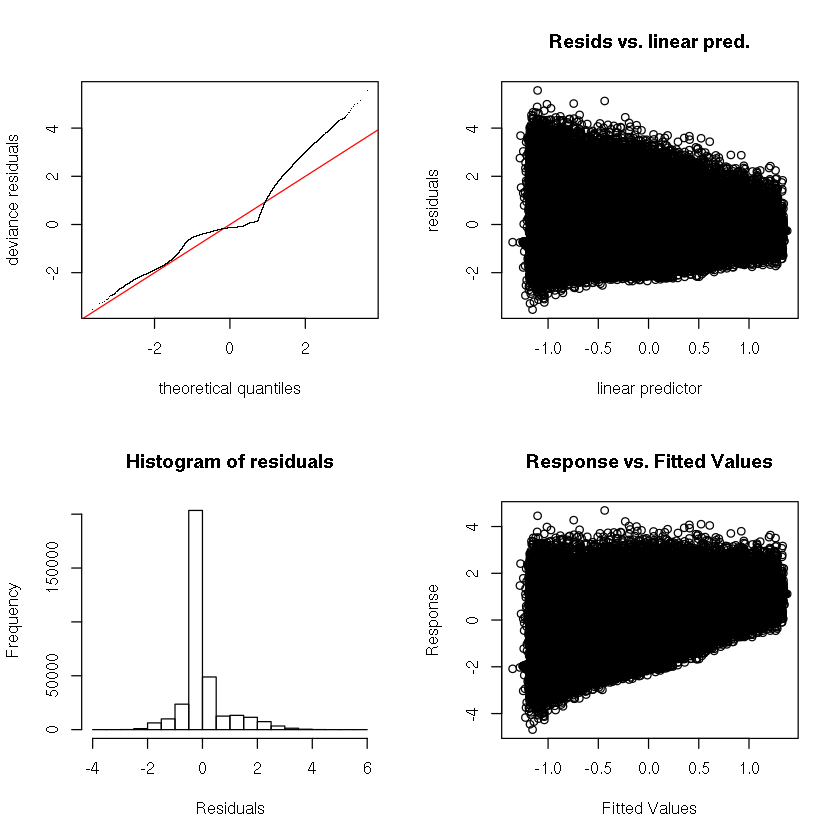

In [52]:
#ACR vs. IR-PRS(ND)
#gaussian
#linear
m1 <- gam(ACR_tresid.0.0 ~ GRS_WT_IR + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10,data=ND,family="gaussian",method="ML")
summary(m1)
#third knot
m2 <- gam(ACR_tresid.0.0 ~ s(GRS_WT_IR,k=20,bs="cr") + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10,data=ND,family="gaussian",method="ML")
summary(m2)
gam.check(m2)
#ten knot
m3 <- gam(ACR_tresid.0.0 ~ s(GRS_WT_IR,k=50,bs="cr") + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10,data=ND,family="gaussian",method="ML")
summary(m3)
gam.check(m3)
#compare models
anova(m1,m2,test="F")
anova(m2,m3,test="F")
AIC(m1)
AIC(m2)
AIC(m3)

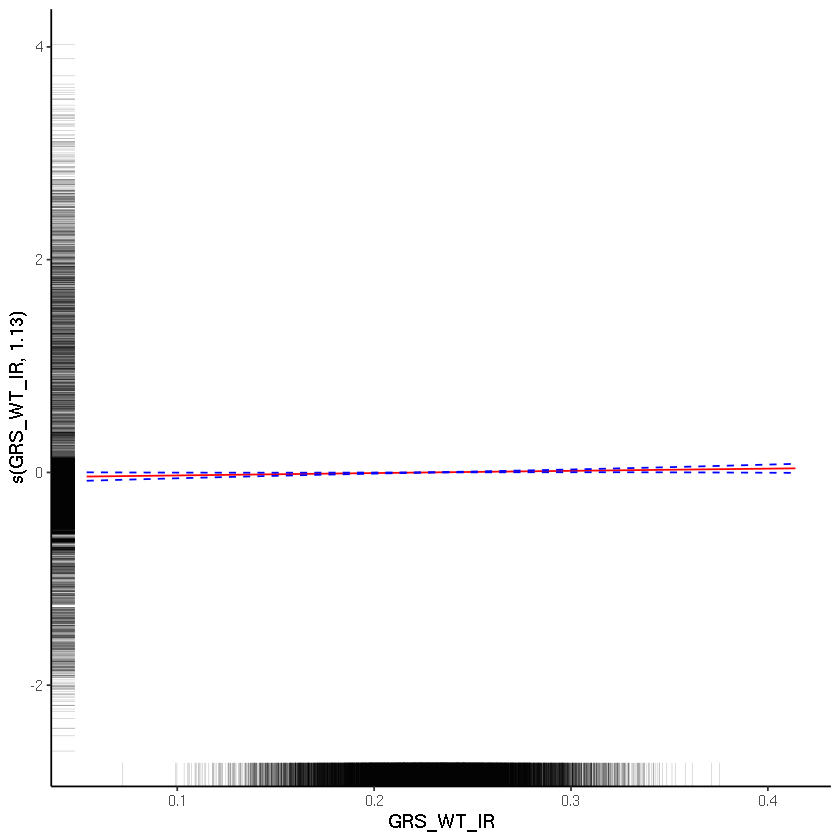

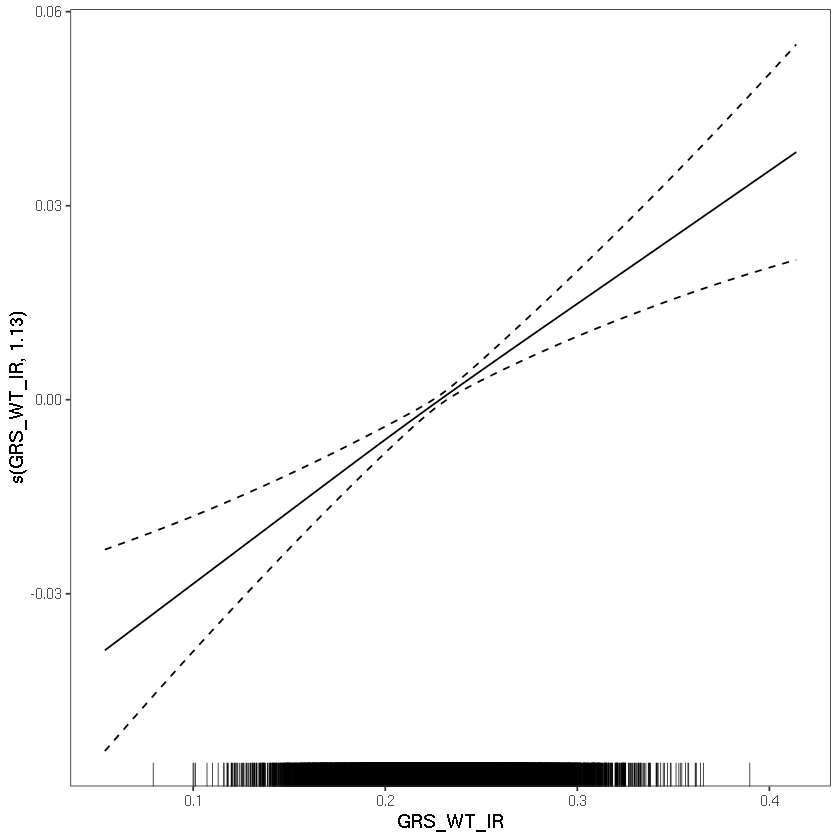

In [53]:
m2v <- getViz(m3)
o <- plot(sm(m2v, 1))
o + l_fitLine(colour = "red") + l_rug(mapping = aes(x=x, y=y), alpha = 0.2) +
    l_ciLine(mul = 5, colour = "blue", linetype = 2) + theme_classic()
plot(m2v,select=1)

Frequencies of Missing Values Due to Each Variable
ACR_tresid.0.0      GRS_WT_IR        AGE.0.0        SEX.0.0            PC1 
           735              0              0              0              0 
           PC2            PC3            PC4            PC5            PC6 
             0              0              0              0              0 
           PC7            PC8            PC9           PC10 
             0              0              0              0 

Linear Regression Model
 
 ols(formula = ACR_tresid.0.0 ~ rcs(GRS_WT_IR, 3) + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10, data = T2D)
 
 
                 Model Likelihood     Discrimination    
                    Ratio Test           Indexes        
 Obs   20553    LR chi2    2063.11    R2       0.096    
 sigma1.2355    d.f.            14    R2 adj   0.095    
 d.f.  20538    Pr(> chi2)  0.0000    g        0.451    
 
 Residuals
 
     Min      1Q  Median      3Q    

2.5 %       97.5 %     
Intercept     3.06393109  3.57230672
GRS_WT_IR    -0.17760437  1.77289195
GRS_WT_IR'   -1.31472080  0.97443672
AGE.0.0      -0.05437872 -0.04936306
SEX.0.0=Male -0.41174730 -0.34187979
PC1          -1.10481159  0.86618695
PC2          -0.52576977  1.85278420
PC3          -3.75956974  0.05213222
PC4          -1.14238406  2.77190830
PC5          -2.58874323  1.72149382
PC6          -0.80153899  3.89139552
PC7          -2.52915774  2.64767698
PC8          -1.81268007  3.61857243
PC9          -2.19150743  3.26477948
PC10         -2.48987912  3.06438634

Frequencies of Missing Values Due to Each Variable
ACR_tresid.0.0      GRS_WT_IR        AGE.0.0        SEX.0.0            PC1 
           735              0              0              0              0 
           PC2            PC3            PC4            PC5            PC6 
             0              0              0              0              0 
           PC7            PC8            PC9           PC10 
             0              0              0              0 

Linear Regression Model
 
 ols(formula = ACR_tresid.0.0 ~ GRS_WT_IR + AGE.0.0 + SEX.0.0 + 
     PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10, 
     data = T2D)
 
 
                 Model Likelihood     Discrimination    
                    Ratio Test           Indexes        
 Obs   20553    LR chi2    2063.03    R2       0.096    
 sigma1.2355    d.f.            13    R2 adj   0.095    
 d.f.  20539    Pr(> chi2)  0.0000    g        0.451    
 
 Residuals
 
     Min      1Q  Median      3Q     Max 
 -

2.5 %       97.5 %     
Intercept     3.15749208  3.53014694
GRS_WT_IR     0.22593198  1.11098235
AGE.0.0      -0.05437721 -0.04936170
SEX.0.0=Male -0.41170784 -0.34184373
PC1          -1.10466071  0.86629316
PC2          -0.52622709  1.85226481
PC3          -3.76076983  0.05080941
PC4          -1.14375534  2.77040194
PC5          -2.59376949  1.71576416
PC6          -0.80198505  3.89084006
PC7          -2.52831405  2.64839467
PC8          -1.80610124  3.62439001
PC9          -2.18773341  3.26821630
PC10         -2.48493464  3.06884672

(Intercept)    GRS_WT_IR      AGE.0.0  SEX.0.0Male          PC1          PC2 
0.000000e+00 7.253287e-10 0.000000e+00 0.000000e+00 5.069004e-01 5.423876e-01 
         PC3          PC4          PC5          PC6          PC7          PC8 
3.577966e-01 1.044749e-03 2.890545e-02 1.188512e-04 7.537506e-10 6.612270e-01 
         PC9         PC10 
1.102492e-01 9.154606e-01

Frequencies of Missing Values Due to Each Variable
ACR_tresid.0.0      GRS_WT_IR        AGE.0.0        SEX.0.0            PC1 
          9067              0              0              0              0 
           PC2            PC3            PC4            PC5            PC6 
             0              0              0              0              0 
           PC7            PC8            PC9           PC10 
             0              0              0              0 

Linear Regression Model
 
 ols(formula = ACR_tresid.0.0 ~ GRS_WT_IR + AGE.0.0 + SEX.0.0 + 
     PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10, 
     data = ND)
 
 
                  Model Likelihood      Discrimination    
                     Ratio Test            Indexes        
 Obs  343132    LR chi2    156957.81    R2       0.367    
 sigma0.7786    d.f.              13    R2 adj   0.367    
 d.f. 343118    Pr(> chi2)    0.0000    g        0.679    
 
 Residuals
 
      Min       1Q   Median       3

2.5 %       97.5 %     
Intercept     3.67419178  3.72311559
GRS_WT_IR     0.14546708  0.28121281
AGE.0.0      -0.06099130 -0.06034085
SEX.0.0=Male -0.66846396 -0.65798556
PC1          -0.10068702  0.20378551
PC2          -0.12725243  0.24203649
PC3          -0.39399441  0.14235274
PC4           0.20145768  0.80051234
PC5           0.03793600  0.69940876
PC6           0.34547350  1.06254792
PC7           0.84152699  1.62795604
PC8          -0.50689679  0.32164686
PC9          -0.07701527  0.75489857
PC10         -0.39885170  0.44452990

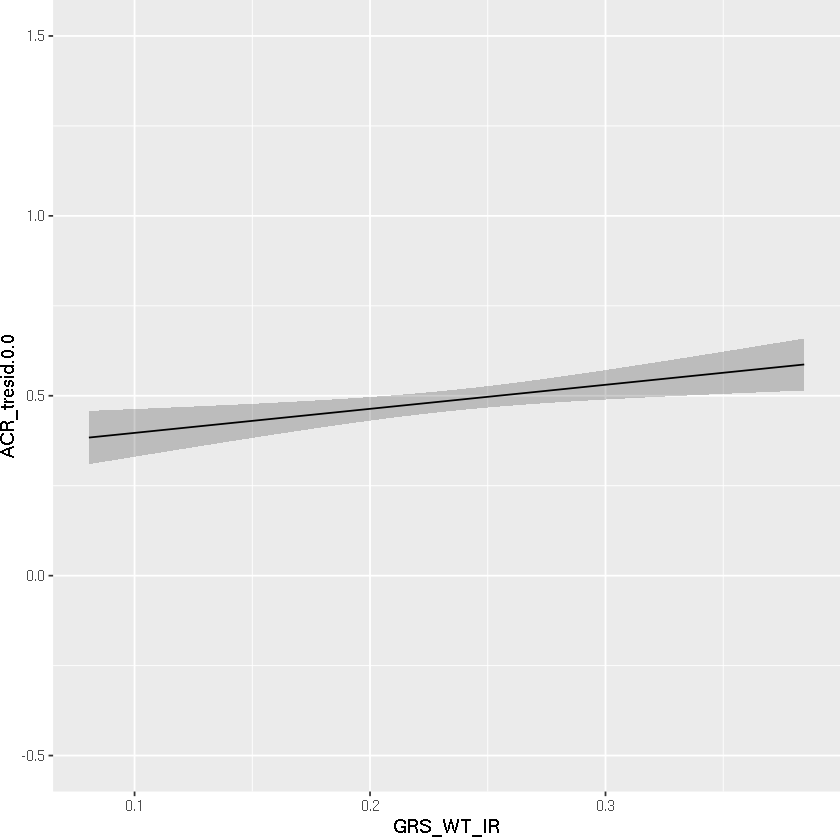

(Intercept)    GRS_WT_IR      AGE.0.0  SEX.0.0Male          PC1          PC2 
0.000000e+00 5.391671e-20 0.000000e+00 0.000000e+00 8.063827e-01 1.605284e-01 
         PC3          PC4          PC5          PC6          PC7          PC8 
1.747804e-01 7.246451e-04 1.734462e-01 4.259735e-06 8.300404e-09 6.609591e-01 
         PC9         PC10 
8.397939e-02 8.153428e-01

Frequencies of Missing Values Due to Each Variable
ACR_tresid.0.0      GRS_WT_IR        AGE.0.0        SEX.0.0            PC1 
          9802              0              0              0              0 
           PC2            PC3            PC4            PC5            PC6 
             0              0              0              0              0 
           PC7            PC8            PC9           PC10 
             0              0              0              0 

Linear Regression Model
 
 ols(formula = ACR_tresid.0.0 ~ GRS_WT_IR + AGE.0.0 + SEX.0.0 + 
     PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10, 
     data = UKBB_AG2)
 
 
                  Model Likelihood      Discrimination    
                     Ratio Test            Indexes        
 Obs  363685    LR chi2    145283.71    R2       0.329    
 sigma0.8189    d.f.              13    R2 adj   0.329    
 d.f. 363671    Pr(> chi2)    0.0000    g        0.657    
 
 Residuals
 
      Min       1Q   Median  

2.5 %       97.5 %     
Intercept     3.55864680  3.60871983
GRS_WT_IR     0.25453477  0.39318121
AGE.0.0      -0.05923286 -0.05856661
SEX.0.0=Male -0.63615194 -0.62546570
PC1          -0.13604521  0.17493323
PC2          -0.05355068  0.32354014
PC3          -0.46581186  0.08467606
PC4           0.22179061  0.83398842
PC5          -0.10323401  0.57262130
PC6           0.49326495  1.22612482
PC7           0.77993670  1.58398166
PC8          -0.51820963  0.32869477
PC9          -0.05031092  0.80006344
PC10         -0.37977515  0.48252165

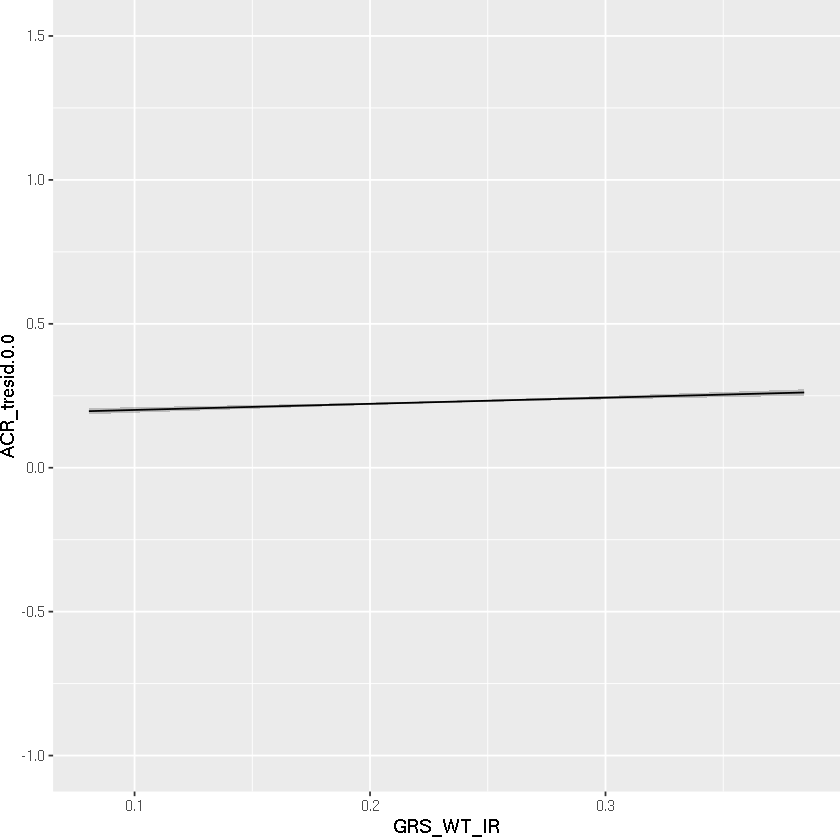

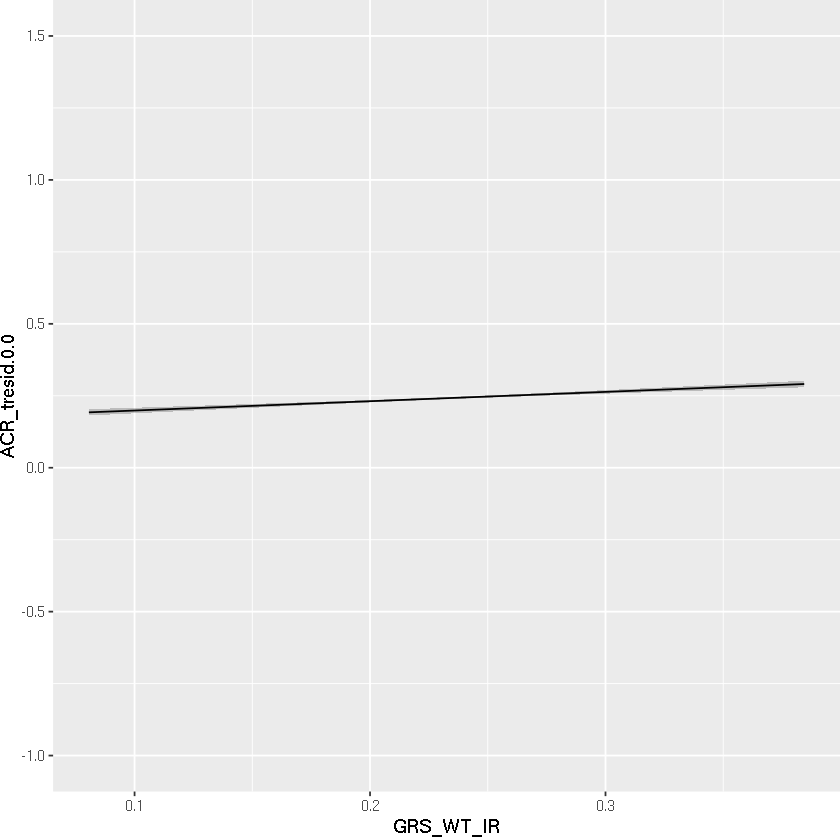

In [22]:
#############################ACR_tresid#################################
#T2D, ACR_tresid
ddist <- datadist(UKBB_AG2[,c('AGE.0.0','GRS_WT_IR','SEX.0.0','PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10')])
options (datadist ="ddist")


M1 <- ols(ACR_tresid.0.0 ~ rcs(GRS_WT_IR,3) + AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10, data=T2D) 
M1
confint(M1)
M1 <- ols(ACR_tresid.0.0 ~ GRS_WT_IR + AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10, data=T2D) 
M1
confint(M1)
ggplot(Predict(M1))[1,2]
#linear term not significant

#ND, ACR_tresid
ddist <- datadist(UKBB_AG2[,c('AGE.0.0','GRS_WT_IR','SEX.0.0','PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10')])
options (datadist ="ddist")
#3rd knot significant
M1 <- lm(ACR_tresid.0.0 ~ GRS_WT_IR + AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10,
          data=ND) 
summary(M1)$coefficients[,4]
M1 <- ols(ACR_tresid.0.0 ~ GRS_WT_IR + AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10,
          data=ND) 
M1
confint(M1)
ggplot(Predict(M1))[1,2]
#3rd knot not significant, modeled as linear
#GRS_IR was not significant 

#Overall, ACR_tresid
ddist <- datadist(UKBB_AG2[,c('AGE.0.0','GRS_WT_IR','SEX.0.0','PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10')])
options (datadist ="ddist")
M1 <- lm(ACR_tresid.0.0 ~ GRS_WT_IR + AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10,
          data=UKBB_AG2) 
summary(M1)$coefficients[,4]
M1 <- ols(ACR_tresid.0.0 ~ GRS_WT_IR + AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10,
          data=UKBB_AG2) 
M1
confint(M1)
ggplot(Predict(M1))[1,2]
#3rd knot tested and not close to significant
#categorical variable not significant

In [ ]:
#Evaluate commonly used form of IR risk score

#eGFR
#T2D
M1_pre <- glm(EGFR_tresid.0.0  ~ AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10, data=T2D,
          family=gaussian(link="identity"))
M1 <- glm(EGFR_tresid.0.0  ~ GRS_WT_IRf3 + AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10, data=T2D,
          family=gaussian(link="identity")) 
summary(M1)
confint(M1)
lrtest(M1_pre,M1)
#ns
#full-adjustment 
M1_pre <- glm(EGFR_tresid.0.0  ~ AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + EDUYEARS + SES_TDI.0.0 + BMI.0.0 + HYP_POS1 + STATIN + T2D_status, data=T2D,
          family=gaussian(link="identity"))
M1 <- glm(EGFR_tresid.0.0  ~ GRS_WT_IRf3 + AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + EDUYEARS + SES_TDI.0.0 + BMI.0.0 + HYP_POS1 + STATIN + T2D_status, data=T2D,
          family=gaussian(link="identity")) 
summary(M1)
confint(M1)
lrtest(M1_pre,M1)
#ND
M1_pre <- glm(EGFR_tresid.0.0  ~ AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10, data=ND,
          family=gaussian(link="identity"))
M1 <- glm(EGFR_tresid.0.0  ~ GRS_WT_IRf3 + AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10, data=ND,
          family=gaussian(link="identity")) 
summary(M1)
confint(M1)
lrtest(M1_pre,M1)
#full-adjustment 
M1_pre <- glm(EGFR_tresid.0.0  ~ AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + EDUYEARS + SES_TDI.0.0 + BMI.0.0 + HYP_POS1 + STATIN + T2D_status, data=ND,
          family=gaussian(link="identity"))
M1 <- glm(EGFR_tresid.0.0  ~ GRS_WT_IRf3 + AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + EDUYEARS + SES_TDI.0.0 + BMI.0.0 + HYP_POS1 + STATIN + T2D_status, data=ND,
          family=gaussian(link="identity")) 
summary(M1)
confint(M1)
lrtest(M1_pre,M1)
#overall sample
M1_pre <- glm(EGFR_tresid.0.0  ~ AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10, data=UKBB_AG2,
          family=gaussian(link="identity"))
M1 <- glm(EGFR_tresid.0.0  ~ GRS_WT_IRf3 + AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10, data=UKBB_AG2,
          family=gaussian(link="identity")) 
summary(M1)
confint(M1)
lrtest(M1_pre,M1)
#full-adjustment 
M1_pre <- glm(EGFR_tresid.0.0  ~ AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + EDUYEARS + SES_TDI.0.0 + BMI.0.0 + HYP_POS1 + STATIN + T2D_status, data=UKBB_AG2,
          family=gaussian(link="identity"))
M1 <- glm(EGFR_tresid.0.0  ~ GRS_WT_IRf3 + AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + EDUYEARS + SES_TDI.0.0 + BMI.0.0 + HYP_POS1 + STATIN + T2D_status, data=UKBB_AG2,
          family=gaussian(link="identity")) 
summary(M1)
confint(M1)
lrtest(M1_pre,M1)
#ACR_tresid
#T2D
M1_pre <- glm(ACR_tresid.0.0 ~ AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10, data=T2D,
          family=gaussian(link="identity"))
M1 <- glm(ACR_tresid.0.0 ~ GRS_WT_IRf3 + AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10, data=T2D,
          family=gaussian(link="identity")) 
summary(M1)
confint(M1)
lrtest(M1_pre,M1)
#full-adjustment 
M1_pre <- glm(ACR_tresid.0.0 ~ AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + EDUYEARS + SES_TDI.0.0 + BMI.0.0 + HYP_POS1 + STATIN + T2D_status, data=T2D,
          family=gaussian(link="identity"))
M1 <- glm(ACR_tresid.0.0 ~ GRS_WT_IRf3 + AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + EDUYEARS + SES_TDI.0.0 + BMI.0.0 + HYP_POS1 + STATIN + T2D_status, data=T2D,
          family=gaussian(link="identity")) 
summary(M1)
confint(M1)
lrtest(M1_pre,M1)
#medium group sig
#ND
M1_pre <- glm(ACR_tresid.0.0 ~ AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10, data=ND,
          family=gaussian(link="identity")) 
M1 <- glm(ACR_tresid.0.0 ~ GRS_WT_IRf3 + AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10, data=ND,
          family=gaussian(link="identity")) 
summary(M1)
confint(M1)
lrtest(M1_pre,M1)
#full-adjustment 
M1_pre <- glm(ACR_tresid.0.0 ~ AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + EDUYEARS + SES_TDI.0.0 + BMI.0.0 + HYP_POS1 + STATIN + T2D_status, data=ND,
          family=gaussian(link="identity"))
M1 <- glm(ACR_tresid.0.0 ~ GRS_WT_IRf3 + AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + EDUYEARS + SES_TDI.0.0 + BMI.0.0 + HYP_POS1 + STATIN + T2D_status, data=ND,
          family=gaussian(link="identity")) 
summary(M1)
confint(M1)
lrtest(M1_pre,M1)
#Overall
M1_pre <- glm(ACR_tresid.0.0 ~ AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10, data=UKBB_AG2,
          family=gaussian(link="identity"))
M1 <- glm(ACR_tresid.0.0 ~ GRS_WT_IRf3 + AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10, data=UKBB_AG2,
          family=gaussian(link="identity")) 
summary(M1)
confint(M1)
lrtest(M1_pre,M1)
#full-adjustment 
M1_pre <- glm(ACR_tresid.0.0 ~ AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + EDUYEARS + SES_TDI.0.0 + BMI.0.0 + HYP_POS1 + STATIN + T2D_status, data=UKBB_AG2,
          family=gaussian(link="identity"))
M1 <- glm(ACR_tresid.0.0 ~ GRS_WT_IRf3 + AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + EDUYEARS + SES_TDI.0.0 + BMI.0.0 + HYP_POS1 + STATIN + T2D_status, data=UKBB_AG2,
          family=gaussian(link="identity")) 
summary(M1)
confint(M1)
lrtest(M1_pre,M1)


Call:
glm(formula = EGFR_tresid.0.0 ~ GRS_WT_IRf3 + AGE.0.0 + SEX.0.0 + 
    PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10, 
    family = gaussian(link = "identity"), data = T2D)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.1312  -0.7724   0.0068   0.8283   3.7310  

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)             1.544188   0.081162  19.026  < 2e-16 ***
GRS_WT_IRf3high risk   -0.023718   0.032296  -0.734  0.46271    
GRS_WT_IRf3medium risk  0.018286   0.031648   0.578  0.56341    
AGE.0.0                -0.022952   0.001239 -18.528  < 2e-16 ***
SEX.0.0Male             0.055254   0.017242   3.205  0.00135 ** 
PC1                    -1.324267   0.488483  -2.711  0.00671 ** 
PC2                     2.557539   0.587891   4.350 1.37e-05 ***
PC3                     0.337102   0.945302   0.357  0.72139    
PC4                     1.854449   0.963210   1.925  0.05421 .  
PC5                     2.80

Waiting for profiling to be done...



2.5 %       97.5 %     
(Intercept)             1.38511227  1.70326338
GRS_WT_IRf3high risk   -0.08701665  0.03958017
GRS_WT_IRf3medium risk -0.04374276  0.08031518
AGE.0.0                -0.02538035 -0.02052440
SEX.0.0Male             0.02146063  0.08904814
PC1                    -2.28167525 -0.36685808
PC2                     1.40529461  3.70978330
PC3                    -1.51565549  2.18986005
PC4                    -0.03340747  3.74230580
PC5                     0.72017103  4.89426921
PC6                    -0.91164796  3.64606135
PC7                    -2.21656797  2.80291909
PC8                    -2.74143729  2.50919886
PC9                    -3.88264735  1.40965294
PC10                    0.66915005  6.03691903


Model 1: EGFR_tresid.0.0 ~ AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + PC4 + 
    PC5 + PC6 + PC7 + PC8 + PC9 + PC10
Model 2: EGFR_tresid.0.0 ~ GRS_WT_IRf3 + AGE.0.0 + SEX.0.0 + PC1 + PC2 + 
    PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10

L.R. Chisq       d.f.          P 
8.09060528 2.00000000 0.01750441 



Call:
glm(formula = EGFR_tresid.0.0 ~ GRS_WT_IRf3 + AGE.0.0 + SEX.0.0 + 
    PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + 
    EDUYEARS + SES_TDI.0.0 + BMI.0.0 + HYP_POS1 + STATIN + T2D_status, 
    family = gaussian(link = "identity"), data = T2D)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.1405  -0.7678   0.0055   0.8197   3.7355  

Coefficients: (1 not defined because of singularities)
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)              1.838187   0.111533  16.481  < 2e-16 ***
GRS_WT_IRf3high risk    -0.035579   0.032579  -1.092 0.274804    
GRS_WT_IRf3medium risk   0.004164   0.031912   0.130 0.896182    
AGE.0.0                 -0.021510   0.001324 -16.246  < 2e-16 ***
SEX.0.0Male              0.043022   0.017602   2.444 0.014526 *  
PC1                     -1.441802   0.494093  -2.918 0.003526 ** 
PC2                      2.316586   0.596526   3.883 0.000103 ***
PC3                      0.380948   

Waiting for profiling to be done...



2.5 %         97.5 %      
(Intercept)              1.6195865244  2.056787271
GRS_WT_IRf3high risk    -0.0994318503  0.028273920
GRS_WT_IRf3medium risk  -0.0583823456  0.066710637
AGE.0.0                 -0.0241051257 -0.018915129
SEX.0.0Male              0.0085234906  0.077520937
PC1                     -2.4102071177 -0.473397324
PC2                      1.1474169592  3.485754951
PC3                     -1.4910531001  2.252949643
PC4                      0.2173724875  4.024818647
PC5                      0.7732435503  4.988053754
PC6                     -1.0269699186  3.587692940
PC7                     -1.7331613170  3.326464543
PC8                     -3.1047940490  2.177384952
PC9                     -3.5405532305  1.780743633
PC10                     0.5537862024  5.957525392
EDUYEARS                 0.0001220769  0.006669762
SES_TDI.0.0              0.0081410448  0.018587083
BMI.0.0                 -0.0127669706 -0.006795941
HYP_POS1No Hypertension -0.0180194673  0.082585357
STATINStatin Use        -0.1619534425 -0.086133857
T2D_status                         NA           NA


Model 1: EGFR_tresid.0.0 ~ AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + PC4 + 
    PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + EDUYEARS + SES_TDI.0.0 + 
    BMI.0.0 + HYP_POS1 + STATIN + T2D_status
Model 2: EGFR_tresid.0.0 ~ GRS_WT_IRf3 + AGE.0.0 + SEX.0.0 + PC1 + PC2 + 
    PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + EDUYEARS + 
    SES_TDI.0.0 + BMI.0.0 + HYP_POS1 + STATIN + T2D_status

L.R. Chisq       d.f.          P 
7.33185541 2.00000000 0.02558043 



Call:
glm(formula = EGFR_tresid.0.0 ~ GRS_WT_IRf3 + AGE.0.0 + SEX.0.0 + 
    PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10, 
    family = gaussian(link = "identity"), data = ND)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.6853  -0.6668   0.0079   0.6629   4.7025  

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)            -0.1310391  0.0132525  -9.888  < 2e-16 ***
GRS_WT_IRf3high risk   -0.0040548  0.0060540  -0.670   0.5030    
GRS_WT_IRf3medium risk  0.0018683  0.0057943   0.322   0.7471    
AGE.0.0                 0.0024151  0.0002116  11.411  < 2e-16 ***
SEX.0.0Male            -0.0388091  0.0034129 -11.371  < 2e-16 ***
PC1                    -1.2282662  0.0988492 -12.426  < 2e-16 ***
PC2                     2.4596315  0.1200536  20.488  < 2e-16 ***
PC3                    -0.3829675  0.1737954  -2.204   0.0276 *  
PC4                     0.1350530  0.1945767   0.694   0.4876    
PC5                

Waiting for profiling to be done...



2.5 %        97.5 %      
(Intercept)            -0.157013501 -0.105064734
GRS_WT_IRf3high risk   -0.015920562  0.007810862
GRS_WT_IRf3medium risk -0.009488335  0.013224941
AGE.0.0                 0.002000317  0.002829941
SEX.0.0Male            -0.045498334 -0.032119869
PC1                    -1.422006999 -1.034525391
PC2                     2.224330737  2.694932273
PC3                    -0.723600269 -0.042334694
PC4                    -0.246310270  0.516416241
PC5                     1.238298297  2.082227369
PC6                     1.276290371  2.190717373
PC7                    -0.449346647  0.553709625
PC8                     0.048209922  1.105444358
PC9                    -0.181498637  0.879011435
PC10                   -0.229779057  0.846697553


Model 1: EGFR_tresid.0.0 ~ AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + PC4 + 
    PC5 + PC6 + PC7 + PC8 + PC9 + PC10
Model 2: EGFR_tresid.0.0 ~ GRS_WT_IRf3 + AGE.0.0 + SEX.0.0 + PC1 + PC2 + 
    PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10

L.R. Chisq       d.f.          P 
 2.5192894  2.0000000  0.2837548 



Call:
glm(formula = EGFR_tresid.0.0 ~ GRS_WT_IRf3 + AGE.0.0 + SEX.0.0 + 
    PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + 
    EDUYEARS + SES_TDI.0.0 + BMI.0.0 + HYP_POS1 + STATIN + T2D_status, 
    family = gaussian(link = "identity"), data = ND)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.8998  -0.6610   0.0072   0.6585   4.6904  

Coefficients: (1 not defined because of singularities)
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)              0.3609613  0.0198335  18.200  < 2e-16 ***
GRS_WT_IRf3high risk    -0.0081762  0.0060436  -1.353   0.1761    
GRS_WT_IRf3medium risk  -0.0014174  0.0057834  -0.245   0.8064    
AGE.0.0                  0.0041965  0.0002296  18.278  < 2e-16 ***
SEX.0.0Male             -0.0168435  0.0034729  -4.850 1.23e-06 ***
PC1                     -1.3864387  0.0990410 -13.999  < 2e-16 ***
PC2                      2.3384101  0.1207776  19.361  < 2e-16 ***
PC3                     -0.05

Waiting for profiling to be done...



In [ ]:
#Evaluate commonly used form of T2D risk score

#eGFR
#T2D
M1_pre <- glm(EGFR_tresid.0.0  ~ AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10, data=T2D,
          family=gaussian(link="identity"))
M1 <- glm(EGFR_tresid.0.0  ~ GRS_WT_T2DIRf3 + AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10, data=T2D,
          family=gaussian(link="identity")) 
summary(M1)
confint(M1)
lrtest(M1_pre,M1)
#ns
#full-adjustment 
M1_pre <- glm(EGFR_tresid.0.0  ~ AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + EDUYEARS + SES_TDI.0.0 + BMI.0.0 + HYP_POS1 + STATIN + T2D_status, data=T2D,
          family=gaussian(link="identity"))
M1 <- glm(EGFR_tresid.0.0  ~ GRS_WT_T2DIRf3 + AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + EDUYEARS + SES_TDI.0.0 + BMI.0.0 + HYP_POS1 + STATIN + T2D_status, data=T2D,
          family=gaussian(link="identity")) 
summary(M1)
confint(M1)
lrtest(M1_pre,M1)
#ND
M1_pre <- glm(EGFR_tresid.0.0  ~ AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10, data=ND,
          family=gaussian(link="identity"))
M1 <- glm(EGFR_tresid.0.0  ~ GRS_WT_T2DIRf3 + AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10, data=ND,
          family=gaussian(link="identity")) 
summary(M1)
confint(M1)
lrtest(M1_pre,M1)
#full-adjustment 
M1_pre <- glm(EGFR_tresid.0.0  ~ AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + EDUYEARS + SES_TDI.0.0 + BMI.0.0 + HYP_POS1 + STATIN + T2D_status, data=ND,
          family=gaussian(link="identity"))
M1 <- glm(EGFR_tresid.0.0  ~ GRS_WT_T2DIRf3 + AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + EDUYEARS + SES_TDI.0.0 + BMI.0.0 + HYP_POS1 + STATIN + T2D_status, data=ND,
          family=gaussian(link="identity")) 
summary(M1)
confint(M1)
lrtest(M1_pre,M1)
#overall sample
M1_pre <- glm(EGFR_tresid.0.0  ~ AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10, data=UKBB_AG2,
          family=gaussian(link="identity"))
M1 <- glm(EGFR_tresid.0.0  ~ GRS_WT_T2DIRf3 + AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10, data=UKBB_AG2,
          family=gaussian(link="identity")) 
summary(M1)
confint(M1)
lrtest(M1_pre,M1)
#full-adjustment 
M1_pre <- glm(EGFR_tresid.0.0  ~ AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + EDUYEARS + SES_TDI.0.0 + BMI.0.0 + HYP_POS1 + STATIN + T2D_status, data=UKBB_AG2,
          family=gaussian(link="identity"))
M1 <- glm(EGFR_tresid.0.0  ~ GRS_WT_T2DIRf3 + AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + EDUYEARS + SES_TDI.0.0 + BMI.0.0 + HYP_POS1 + STATIN + T2D_status, data=UKBB_AG2,
          family=gaussian(link="identity")) 
summary(M1)
confint(M1)
lrtest(M1_pre,M1)
#ACR_tresid
#T2D
M1_pre <- glm(ACR_tresid.0.0 ~ AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10, data=T2D,
          family=gaussian(link="identity"))
M1 <- glm(ACR_tresid.0.0 ~ GRS_WT_T2DIRf3 + AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10, data=T2D,
          family=gaussian(link="identity")) 
summary(M1)
confint(M1)
lrtest(M1_pre,M1)
#full-adjustment 
M1_pre <- glm(ACR_tresid.0.0 ~ AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + EDUYEARS + SES_TDI.0.0 + BMI.0.0 + HYP_POS1 + STATIN + T2D_status, data=T2D,
          family=gaussian(link="identity"))
M1 <- glm(ACR_tresid.0.0 ~ GRS_WT_T2DIRf3 + AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + EDUYEARS + SES_TDI.0.0 + BMI.0.0 + HYP_POS1 + STATIN + T2D_status, data=T2D,
          family=gaussian(link="identity")) 
summary(M1)
confint(M1)
lrtest(M1_pre,M1)
#medium group sig
#ND
M1_pre <- glm(ACR_tresid.0.0 ~ AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10, data=ND,
          family=gaussian(link="identity")) 
M1 <- glm(ACR_tresid.0.0 ~ GRS_WT_T2DIRf3 + AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10, data=ND,
          family=gaussian(link="identity")) 
summary(M1)
confint(M1)
lrtest(M1_pre,M1)
#full-adjustment 
M1_pre <- glm(ACR_tresid.0.0 ~ AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + EDUYEARS + SES_TDI.0.0 + BMI.0.0 + HYP_POS1 + STATIN + T2D_status, data=ND,
          family=gaussian(link="identity"))
M1 <- glm(ACR_tresid.0.0 ~ GRS_WT_T2DIRf3 + AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + EDUYEARS + SES_TDI.0.0 + BMI.0.0 + HYP_POS1 + STATIN + T2D_status, data=ND,
          family=gaussian(link="identity")) 
summary(M1)
confint(M1)
lrtest(M1_pre,M1)
#Overall
M1_pre <- glm(ACR_tresid.0.0 ~ AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10, data=UKBB_AG2,
          family=gaussian(link="identity"))
M1 <- glm(ACR_tresid.0.0 ~ GRS_WT_T2DIRf3 + AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10, data=UKBB_AG2,
          family=gaussian(link="identity")) 
summary(M1)
confint(M1)
lrtest(M1_pre,M1)
#full-adjustment 
M1_pre <- glm(ACR_tresid.0.0 ~ AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + EDUYEARS + SES_TDI.0.0 + BMI.0.0 + HYP_POS1 + STATIN + T2D_status, data=UKBB_AG2,
          family=gaussian(link="identity"))
M1 <- glm(ACR_tresid.0.0 ~ GRS_WT_T2DIRf3 + AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + EDUYEARS + SES_TDI.0.0 + BMI.0.0 + HYP_POS1 + STATIN + T2D_status, data=UKBB_AG2,
          family=gaussian(link="identity")) 
summary(M1)
confint(M1)
lrtest(M1_pre,M1)


Family: binomial 
Link function: logit 

Formula:
relevel(as.factor(micro.0.0), "normo") ~ GRS_WT_IR + AGE.0.0 + 
    SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
    PC9 + PC10

Parametric coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -5.67976    0.08628 -65.831  < 2e-16 ***
GRS_WT_IR    1.33231    0.22428   5.940 2.85e-09 ***
AGE.0.0      0.03619    0.00115  31.480  < 2e-16 ***
SEX.0.0Male  0.11773    0.01724   6.829 8.58e-12 ***
PC1         -0.02184    0.50496  -0.043  0.96550    
PC2          0.85593    0.60784   1.408  0.15908    
PC3         -1.38755    0.87802  -1.580  0.11403    
PC4          2.92532    0.96867   3.020  0.00253 ** 
PC5         -0.42106    1.09012  -0.386  0.69931    
PC6          3.74199    1.18660   3.154  0.00161 ** 
PC7          3.88685    1.29681   2.997  0.00272 ** 
PC8          0.36533    1.37143   0.266  0.78994    
PC9          1.59137    1.35809   1.172  0.24129    
PC10        -0.48202    1.39473  -0.346


Family: binomial 
Link function: logit 

Formula:
relevel(as.factor(micro.0.0), "normo") ~ s(GRS_WT_IR, k = 20, 
    bs = "cr") + AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + PC4 + 
    PC5 + PC6 + PC7 + PC8 + PC9 + PC10

Parametric coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -5.37410    0.06891 -77.992  < 2e-16 ***
AGE.0.0      0.03619    0.00115  31.480  < 2e-16 ***
SEX.0.0Male  0.11773    0.01724   6.829 8.58e-12 ***
PC1         -0.02184    0.50496  -0.043  0.96550    
PC2          0.85594    0.60784   1.408  0.15908    
PC3         -1.38756    0.87802  -1.580  0.11403    
PC4          2.92533    0.96867   3.020  0.00253 ** 
PC5         -0.42107    1.09012  -0.386  0.69931    
PC6          3.74199    1.18660   3.154  0.00161 ** 
PC7          3.88686    1.29681   2.997  0.00272 ** 
PC8          0.36533    1.37143   0.266  0.78994    
PC9          1.59137    1.35809   1.172  0.24129    
PC10        -0.48202    1.39473  -0.346  0.72965    
---
Signif. codes


Method: ML   Optimizer: outer newton
full convergence after 5 iterations.
Gradient range [-0.01388524,-0.01388524]
(score 58930.18 & scale 1).
Hessian positive definite, eigenvalue range [0.01368913,0.01368913].
Model rank =  32 / 32 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

                k'   edf k-index p-value
s(GRS_WT_IR) 19.00  1.02    0.92    0.99



Family: binomial 
Link function: logit 

Formula:
relevel(as.factor(micro.0.0), "normo") ~ s(GRS_WT_IR, k = 50, 
    bs = "cr") + AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + PC4 + 
    PC5 + PC6 + PC7 + PC8 + PC9 + PC10

Parametric coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -5.37410    0.06891 -77.992  < 2e-16 ***
AGE.0.0      0.03619    0.00115  31.480  < 2e-16 ***
SEX.0.0Male  0.11773    0.01724   6.829 8.58e-12 ***
PC1         -0.02184    0.50496  -0.043  0.96550    
PC2          0.85595    0.60784   1.408  0.15908    
PC3         -1.38756    0.87802  -1.580  0.11403    
PC4          2.92533    0.96867   3.020  0.00253 ** 
PC5         -0.42107    1.09012  -0.386  0.69930    
PC6          3.74200    1.18660   3.154  0.00161 ** 
PC7          3.88686    1.29681   2.997  0.00272 ** 
PC8          0.36534    1.37143   0.266  0.78994    
PC9          1.59137    1.35809   1.172  0.24129    
PC10        -0.48202    1.39473  -0.346  0.72965    
---
Signif. codes

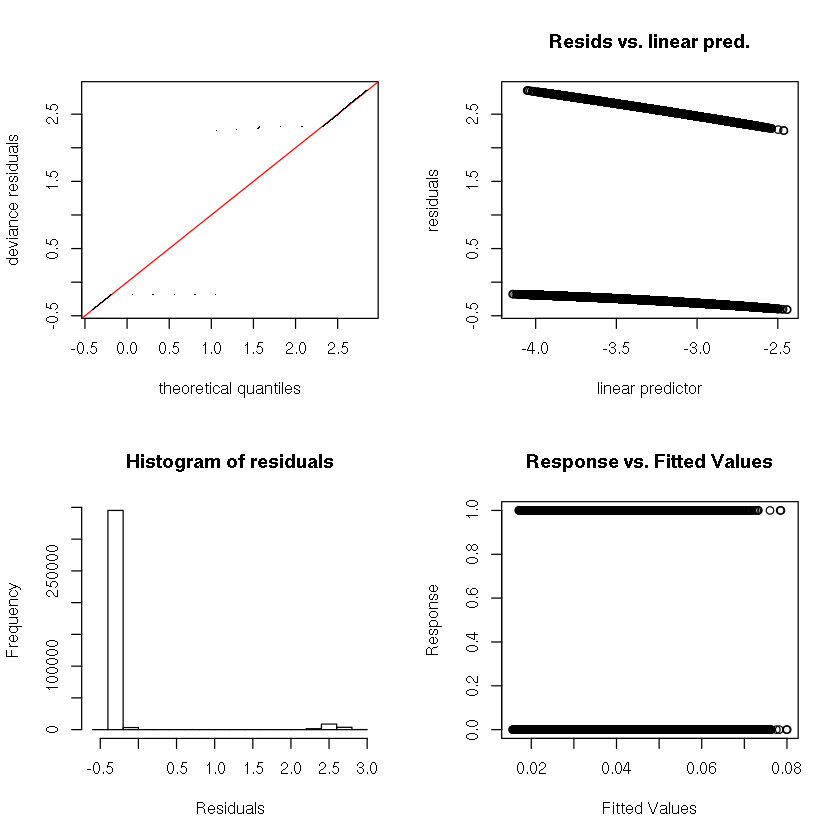


Method: ML   Optimizer: outer newton
full convergence after 6 iterations.
Gradient range [-0.01377308,-0.01377308]
(score 58930.18 & scale 1).
Hessian positive definite, eigenvalue range [0.01357114,0.01357114].
Model rank =  62 / 62 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

                k'   edf k-index p-value
s(GRS_WT_IR) 49.00  1.02     0.9    0.14


Warning message:
“using F test with a 'binomial' family is inappropriate”


Resid. Df Resid. Dev Df         Deviance    F         Pr(>F)   
1 362552.0  117860.3           NA          NA        NA        NA
2 362551.9  117860.3   0.05073948 0.006910569 0.1361971 0.1216907

Warning message:
“using F test with a 'binomial' family is inappropriate”


Resid. Df Resid. Dev Df         Deviance    F         Pr(>F)    
1 362551.9  117860.3           NA          NA        NA         NA
2 362551.9  117860.3   0.02165255 0.003095161 0.1429468 0.06192076

[1] 117888.3

[1] 117888.4

[1] 117888.4

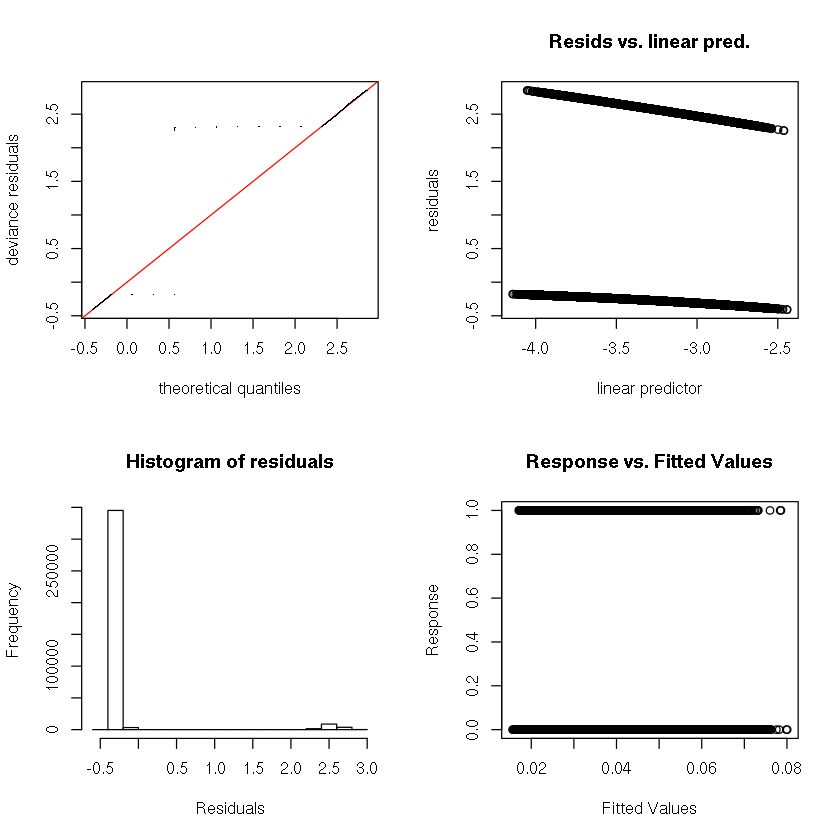

In [60]:
#IR-PRS vs. MICRO (Overall)
#gaussian
#linear
m1 <- gam(relevel(as.factor(micro.0.0),"normo") ~ GRS_WT_IR + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10,data=UKBB_AG2,family="binomial",method="ML")
summary(m1)
#third knot
m2 <- gam(relevel(as.factor(micro.0.0),"normo") ~ s(GRS_WT_IR,k=20,bs='cr') + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10,data=UKBB_AG2,family="binomial",method="ML")
summary(m2)
gam.check(m2)
#ten knot
m3 <- gam(relevel(as.factor(micro.0.0),"normo") ~ s(GRS_WT_IR,k=50,bs="cr") + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10,data=UKBB_AG2,family="binomial",method="ML")
summary(m3)
gam.check(m3)

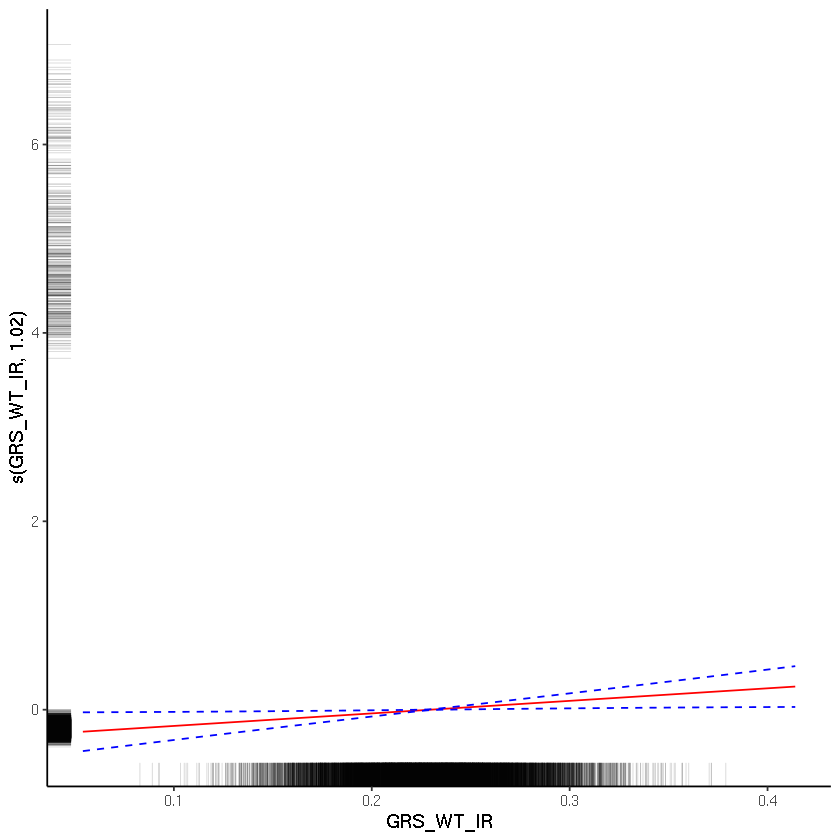

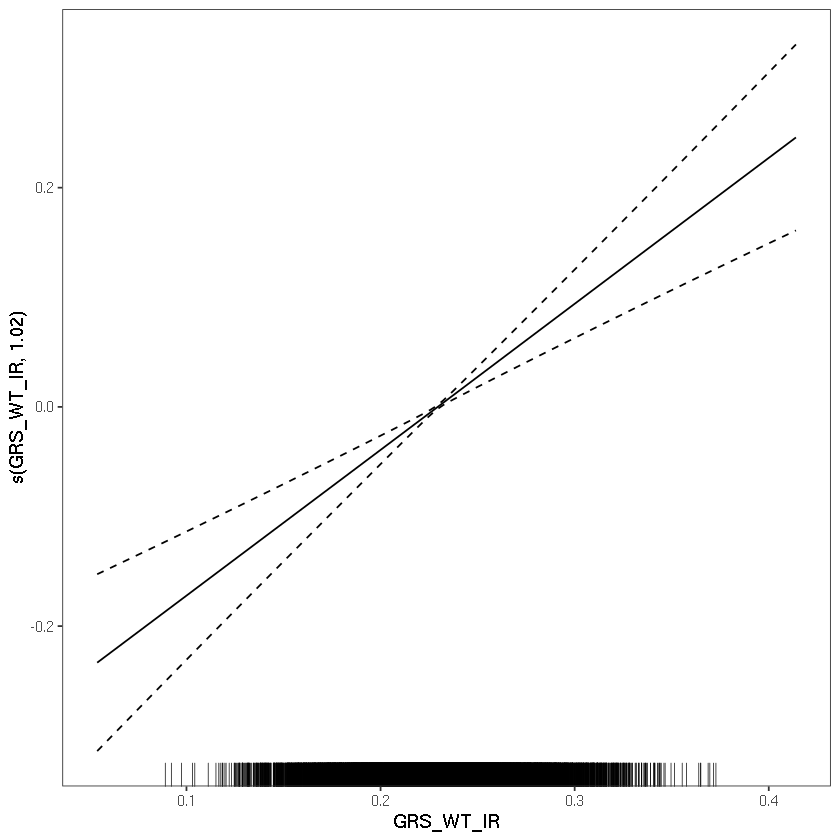

In [61]:
m2v <- getViz(m2)
o <- plot(sm(m2v, 1))
o + l_fitLine(colour = "red") + l_rug(mapping = aes(x=x, y=y), alpha = 0.2) +
    l_ciLine(mul = 5, colour = "blue", linetype = 2) + theme_classic()
plot(m2v,select=1)


Family: binomial 
Link function: logit 

Formula:
relevel(as.factor(micro.0.0), "normo") ~ GRS_WT_IR + AGE.0.0 + 
    SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
    PC9 + PC10

Parametric coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -3.075718   0.245336 -12.537  < 2e-16 ***
GRS_WT_IR    0.650168   0.567683   1.145 0.252084    
AGE.0.0      0.011061   0.003301   3.351 0.000805 ***
SEX.0.0Male  0.385250   0.046935   8.208 2.25e-16 ***
PC1          2.440161   1.228110   1.987 0.046931 *  
PC2         -1.812611   1.531093  -1.184 0.236465    
PC3         -2.262796   2.337286  -0.968 0.332980    
PC4          0.370681   2.514748   0.147 0.882814    
PC5         -1.981516   2.707618  -0.732 0.464272    
PC6          3.747659   2.920262   1.283 0.199377    
PC7         -3.182070   3.331461  -0.955 0.339498    
PC8          5.101166   3.497322   1.459 0.144677    
PC9          3.270956   3.481261   0.940 0.347428    
PC10         3.834909   3


Family: binomial 
Link function: logit 

Formula:
relevel(as.factor(micro.0.0), "normo") ~ s(GRS_WT_IR, k = 50, 
    bs = "cr") + AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + PC4 + 
    PC5 + PC6 + PC7 + PC8 + PC9 + PC10

Parametric coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -2.924682   0.204860 -14.277  < 2e-16 ***
AGE.0.0      0.011075   0.003301   3.355 0.000793 ***
SEX.0.0Male  0.385613   0.046937   8.216  < 2e-16 ***
PC1          2.445264   1.228235   1.991 0.046495 *  
PC2         -1.821424   1.531273  -1.189 0.234249    
PC3         -2.273842   2.337521  -0.973 0.330674    
PC4          0.356557   2.514908   0.142 0.887256    
PC5         -2.012689   2.708211  -0.743 0.457373    
PC6          3.744151   2.920132   1.282 0.199778    
PC7         -3.190736   3.331396  -0.958 0.338175    
PC8          5.128200   3.497647   1.466 0.142598    
PC9          3.302757   3.481183   0.949 0.342750    
PC10         3.833556   3.574686   1.072 0.283532    
---


Method: REML   Optimizer: outer newton
full convergence after 5 iterations.
Gradient range [-0.007284318,-0.007284318]
(score 7381.237 & scale 1).
Hessian positive definite, eigenvalue range [0.1027457,0.1027457].
Model rank =  62 / 62 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

                k'   edf k-index p-value
s(GRS_WT_IR) 49.00  2.01    0.96    0.96


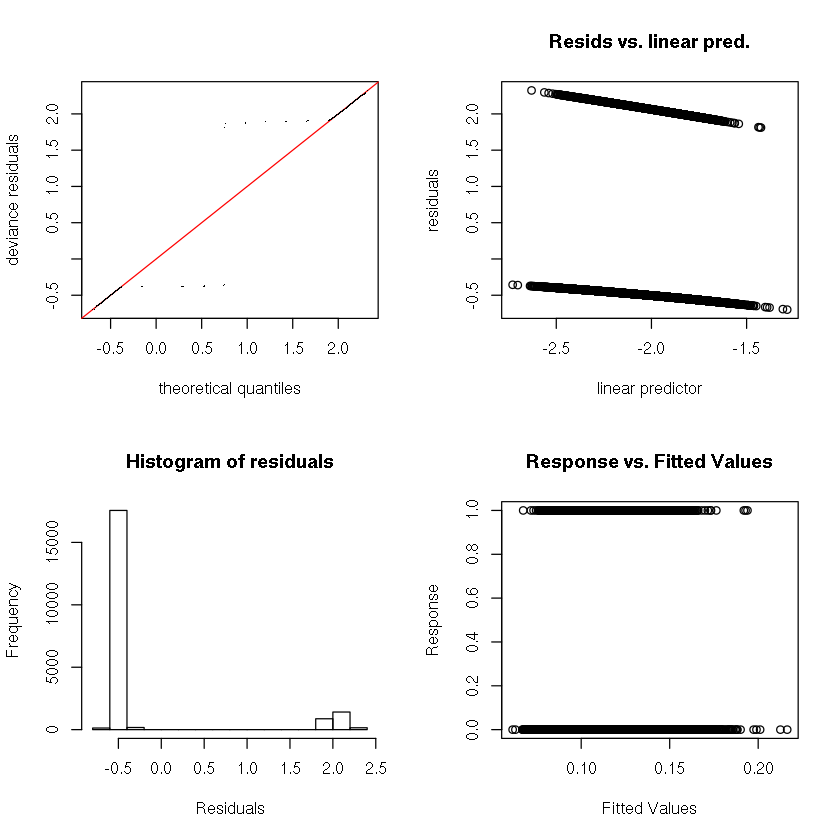

In [92]:
#IR-PRS vs. Micro (T2D)
#gaussian
#linear
m1 <- gam(relevel(as.factor(micro.0.0),"normo") ~ GRS_WT_IR + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10,data=T2D,family="binomial",method="REML")
summary(m1)
#third knot
m2 <- gam(relevel(as.factor(micro.0.0),"normo") ~ s(GRS_WT_IR,k=50,bs='cr') + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10,data=T2D,family="binomial",method="REML")
summary(m2)
gam.check(m2)


Family: binomial 
Link function: logit 

Formula:
relevel(as.factor(micro.0.0), "normo") ~ GRS_WT_IR + AGE.0.0 + 
    SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
    PC9 + PC10

Parametric coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -5.464604   0.093505 -58.442  < 2e-16 ***
GRS_WT_IR    0.996717   0.245973   4.052 5.08e-05 ***
AGE.0.0      0.032743   0.001244  26.313  < 2e-16 ***
SEX.0.0Male -0.019203   0.019001  -1.011 0.312189    
PC1         -0.366019   0.557783  -0.656 0.511693    
PC2          1.112673   0.667201   1.668 0.095380 .  
PC3         -1.395157   0.953544  -1.463 0.143433    
PC4          3.414300   1.059219   3.223 0.001267 ** 
PC5          0.440481   1.201550   0.367 0.713922    
PC6          3.209414   1.307549   2.455 0.014107 *  
PC7          5.163374   1.419439   3.638 0.000275 ***
PC8         -0.211583   1.502449  -0.141 0.888008    
PC9          1.170467   1.490370   0.785 0.432246    
PC10        -1.372128   1


Family: binomial 
Link function: logit 

Formula:
relevel(as.factor(micro.0.0), "normo") ~ s(GRS_WT_IR, k = 50, 
    bs = "cr") + AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + PC4 + 
    PC5 + PC6 + PC7 + PC8 + PC9 + PC10

Parametric coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -5.236219   0.074150 -70.617  < 2e-16 ***
AGE.0.0      0.032743   0.001244  26.313  < 2e-16 ***
SEX.0.0Male -0.019203   0.019001  -1.011 0.312191    
PC1         -0.366021   0.557783  -0.656 0.511691    
PC2          1.112662   0.667201   1.668 0.095384 .  
PC3         -1.395154   0.953545  -1.463 0.143434    
PC4          3.414287   1.059219   3.223 0.001267 ** 
PC5          0.440483   1.201550   0.367 0.713921    
PC6          3.209407   1.307549   2.455 0.014107 *  
PC7          5.163366   1.419439   3.638 0.000275 ***
PC8         -0.211590   1.502449  -0.141 0.888004    
PC9          1.170467   1.490371   0.785 0.432247    
PC10        -1.372131   1.526580  -0.899 0.368745    
---


Method: REML   Optimizer: outer newton
full convergence after 6 iterations.
Gradient range [-0.0108861,-0.0108861]
(score 50415.54 & scale 1).
Hessian positive definite, eigenvalue range [0.01072225,0.01072225].
Model rank =  62 / 62 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

                k'   edf k-index p-value   
s(GRS_WT_IR) 49.00  1.02    0.86   0.005 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


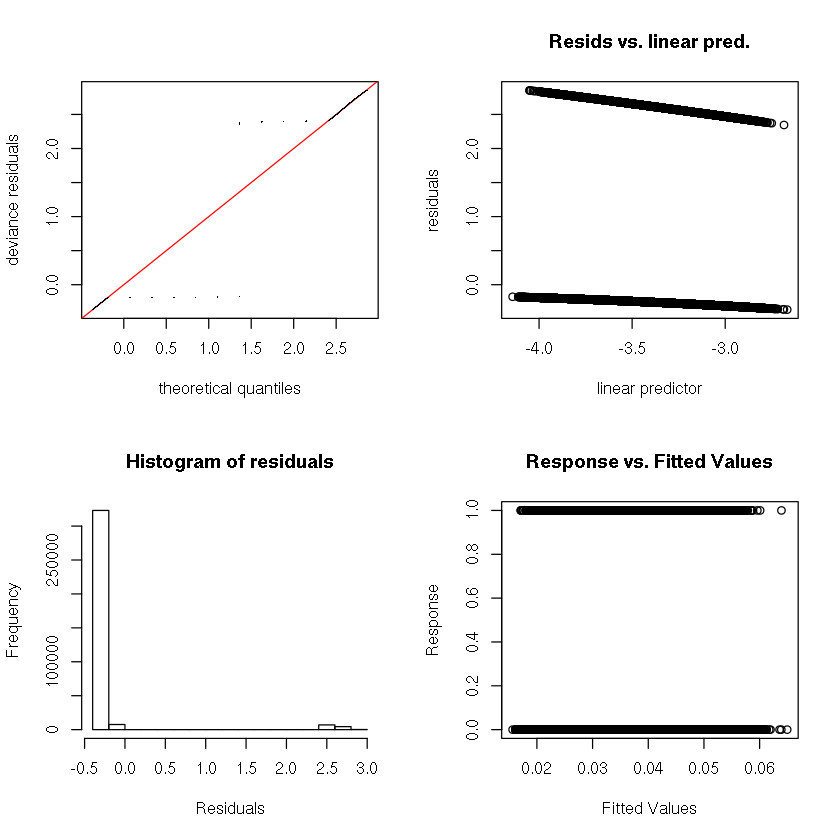

In [93]:
#IR-PRS vs. Micro (ND)
#gaussian
#linear
m1 <- gam(relevel(as.factor(micro.0.0),"normo") ~ GRS_WT_IR + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10,data=ND,family="binomial",method="REML")
summary(m1)
#third knot
m2 <- gam(relevel(as.factor(micro.0.0),"normo") ~ s(GRS_WT_IR,k=50,bs='cr') + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10,data=ND,family="binomial",method="REML")
summary(m2)
gam.check(m2)

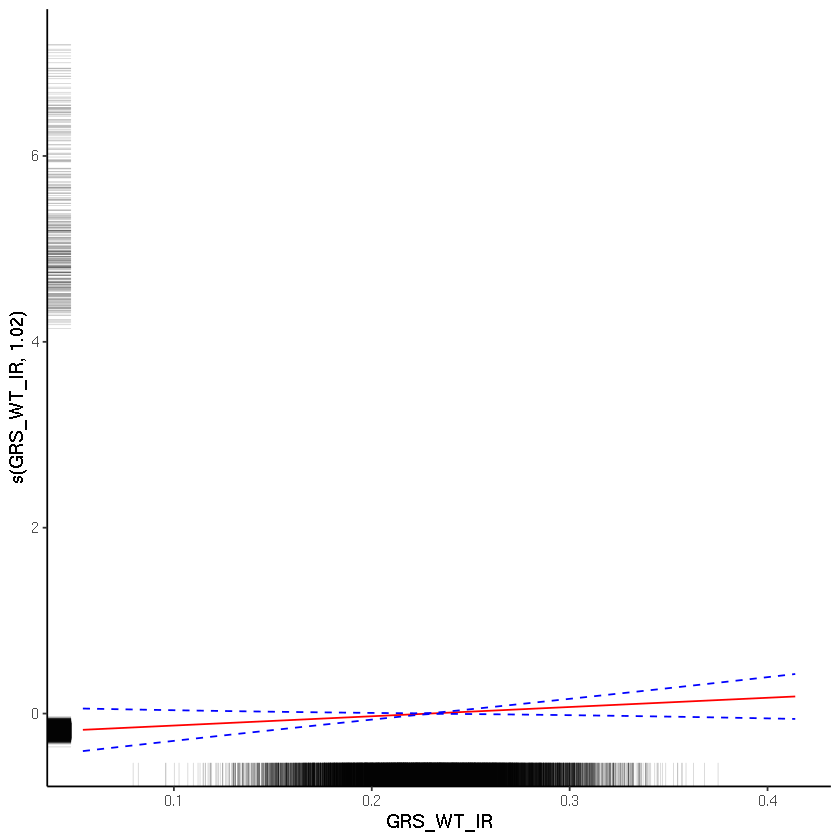

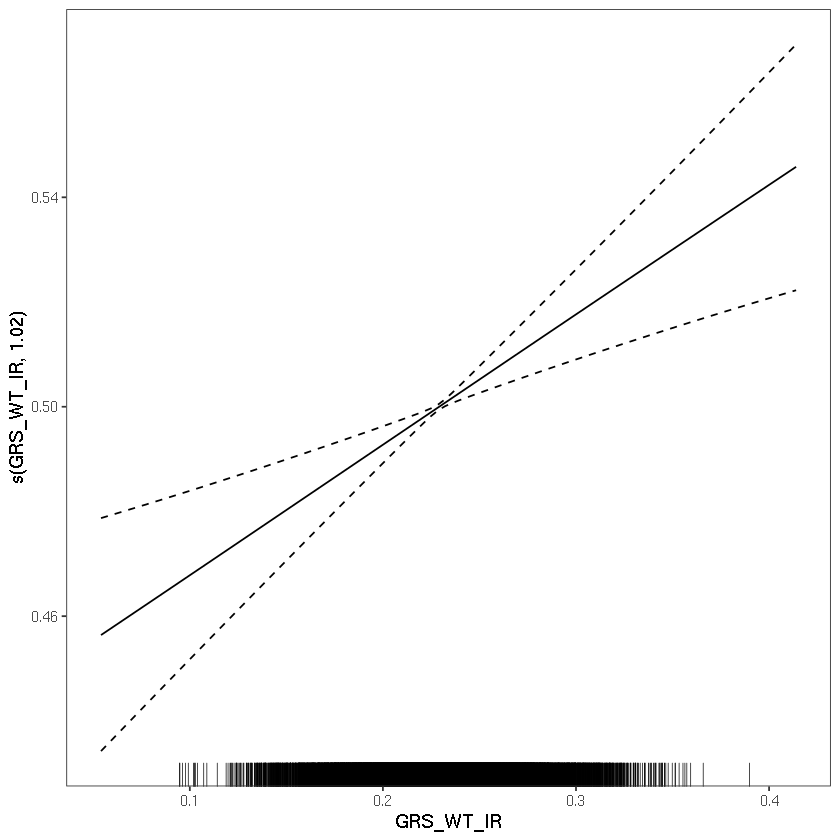

In [97]:
m2v <- getViz(m2)
o <- plot(sm(m2v, 1))
o + l_fitLine(colour = "red") + l_rug(mapping = aes(x=x, y=y), alpha = 0.2) +
    l_ciLine(mul = 5, colour = "blue", linetype = 2) + theme_classic()
plot(m2v,select=1,trans = plogis,shift = coef(m2v)[1])


Family: binomial 
Link function: logit 

Formula:
relevel(as.factor(macro.0.0), "normo") ~ GRS_WT_IR + AGE.0.0 + 
    SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
    PC9 + PC10

Parametric coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -6.107023   0.723739  -8.438  < 2e-16 ***
GRS_WT_IR     1.032204   1.636977   0.631 0.528331    
AGE.0.0       0.019017   0.009729   1.955 0.050633 .  
SEX.0.0Male   0.670694   0.144734   4.634 3.59e-06 ***
PC1           1.207290   3.255109   0.371 0.710719    
PC2           6.423591   4.138292   1.552 0.120607    
PC3         -16.162913   4.207138  -3.842 0.000122 ***
PC4          10.487500   6.883866   1.523 0.127636    
PC5          -1.357808   7.799470  -0.174 0.861795    
PC6          12.179078   8.030086   1.517 0.129347    
PC7           9.254491   9.476306   0.977 0.328771    
PC8           2.711437  10.020415   0.271 0.786705    
PC9           4.009327   9.918706   0.404 0.686052    
PC10       


Family: binomial 
Link function: logit 

Formula:
relevel(as.factor(macro.0.0), "normo") ~ s(GRS_WT_IR, k = 50, 
    bs = "cr") + AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + PC4 + 
    PC5 + PC6 + PC7 + PC8 + PC9 + PC10

Parametric coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -5.865190   0.609563  -9.622  < 2e-16 ***
AGE.0.0       0.018886   0.009728   1.941 0.052202 .  
SEX.0.0Male   0.668720   0.144758   4.620 3.85e-06 ***
PC1           1.183602   3.252969   0.364 0.715968    
PC2           6.455158   4.136246   1.561 0.118611    
PC3         -16.111217   4.207312  -3.829 0.000128 ***
PC4          10.632902   6.884291   1.545 0.122463    
PC5          -1.155353   7.790788  -0.148 0.882108    
PC6          12.246527   8.037561   1.524 0.127593    
PC7           9.201469   9.473387   0.971 0.331401    
PC8           2.386975  10.023513   0.238 0.811774    
PC9           3.836970   9.925450   0.387 0.699068    
PC10          6.353201  10.308470   0.616 0.


Method: REML   Optimizer: outer newton
full convergence after 4 iterations.
Gradient range [-6.554161e-05,-6.554161e-05]
(score 1327.186 & scale 1).
Hessian positive definite, eigenvalue range [0.4336446,0.4336446].
Model rank =  62 / 62 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

                k'   edf k-index p-value
s(GRS_WT_IR) 49.00  2.68    0.87    0.22


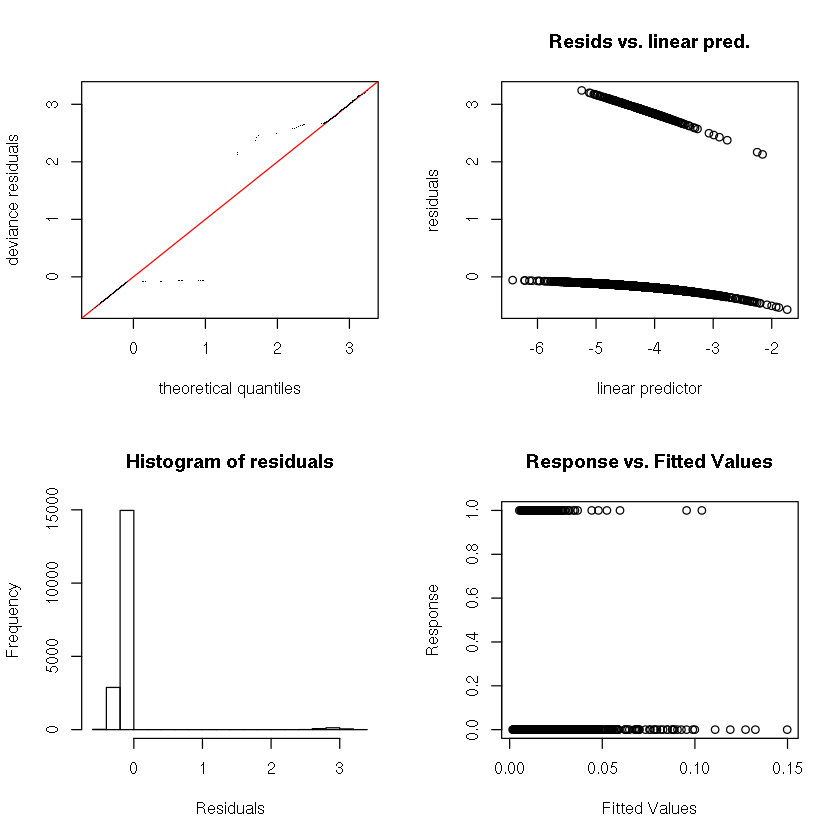

In [98]:
#IR-PRS vs. MACRO (T2D)
#gaussian
#linear
m1 <- gam(relevel(as.factor(macro.0.0),"normo") ~ GRS_WT_IR + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10,data=T2D,family="binomial",method="REML")
summary(m1)
#third knot
m2 <- gam(relevel(as.factor(macro.0.0),"normo") ~ s(GRS_WT_IR,k=50,bs='cr') + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10,data=T2D,family="binomial",method="REML")
summary(m2)
gam.check(m2)

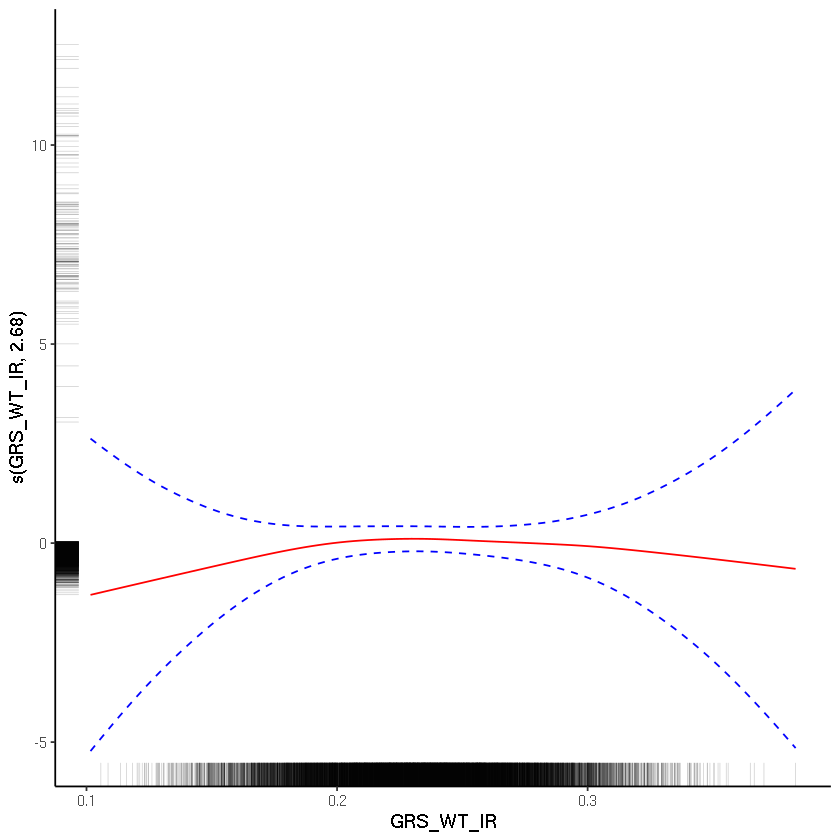

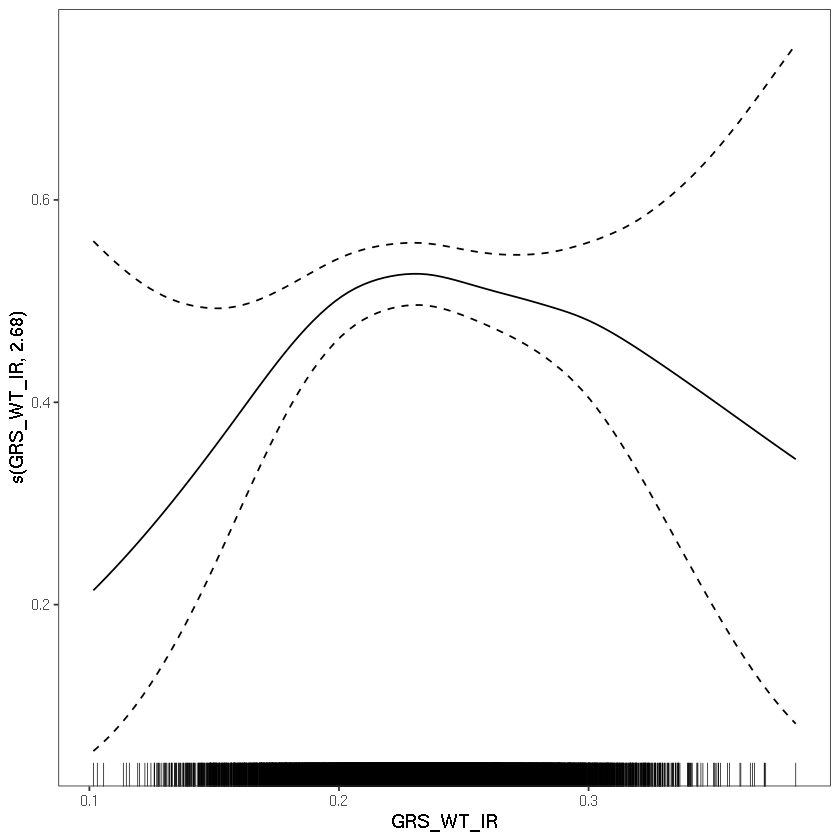

In [99]:
m2v <- getViz(m2)
o <- plot(sm(m2v, 1))
o + l_fitLine(colour = "red") + l_rug(mapping = aes(x=x, y=y), alpha = 0.2) +
    l_ciLine(mul = 5, colour = "blue", linetype = 2) + theme_classic()
plot(m2v,select=1,trans = plogis,shift = coef(m2v)[1])


Family: binomial 
Link function: logit 

Formula:
relevel(as.factor(macro.0.0), "normo") ~ GRS_WT_IR + AGE.0.0 + 
    SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
    PC9 + PC10

Parametric coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -7.310971   0.331109 -22.080  < 2e-16 ***
GRS_WT_IR    0.504579   0.891368   0.566  0.57134    
AGE.0.0      0.019799   0.004394   4.506  6.6e-06 ***
SEX.0.0Male  0.188709   0.068444   2.757  0.00583 ** 
PC1         -1.221297   2.043931  -0.598  0.55016    
PC2          2.842557   2.377664   1.196  0.23188    
PC3         -3.566721   3.298009  -1.081  0.27948    
PC4         -5.558266   4.241368  -1.310  0.19003    
PC5          1.978863   4.410234   0.449  0.65365    
PC6         11.858747   4.704450   2.521  0.01171 *  
PC7         14.271826   5.161209   2.765  0.00569 ** 
PC8          7.614258   5.536701   1.375  0.16906    
PC9          3.917805   5.631618   0.696  0.48663    
PC10         2.798593   5


Family: binomial 
Link function: logit 

Formula:
relevel(as.factor(macro.0.0), "normo") ~ s(GRS_WT_IR, k = 50, 
    bs = "cr") + AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + PC4 + 
    PC5 + PC6 + PC7 + PC8 + PC9 + PC10

Parametric coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -7.197789   0.259581 -27.729  < 2e-16 ***
AGE.0.0      0.019824   0.004394   4.512 6.43e-06 ***
SEX.0.0Male  0.188561   0.068444   2.755  0.00587 ** 
PC1         -1.214250   2.044147  -0.594  0.55250    
PC2          2.858300   2.377834   1.202  0.22934    
PC3         -3.569173   3.297481  -1.082  0.27908    
PC4         -5.539512   4.241125  -1.306  0.19150    
PC5          1.982808   4.410578   0.450  0.65303    
PC6         11.871795   4.704413   2.524  0.01162 *  
PC7         14.292082   5.161351   2.769  0.00562 ** 
PC8          7.638348   5.536507   1.380  0.16770    
PC9          3.928026   5.631569   0.698  0.48549    
PC10         2.807051   5.546285   0.506  0.61278    
---


Method: REML   Optimizer: outer newton
full convergence after 3 iterations.
Gradient range [-2.35925e-06,-2.35925e-06]
(score 5922.223 & scale 1).
Hessian positive definite, eigenvalue range [0.30431,0.30431].
Model rank =  62 / 62 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

                k'   edf k-index p-value
s(GRS_WT_IR) 49.00  2.43    0.84    0.19


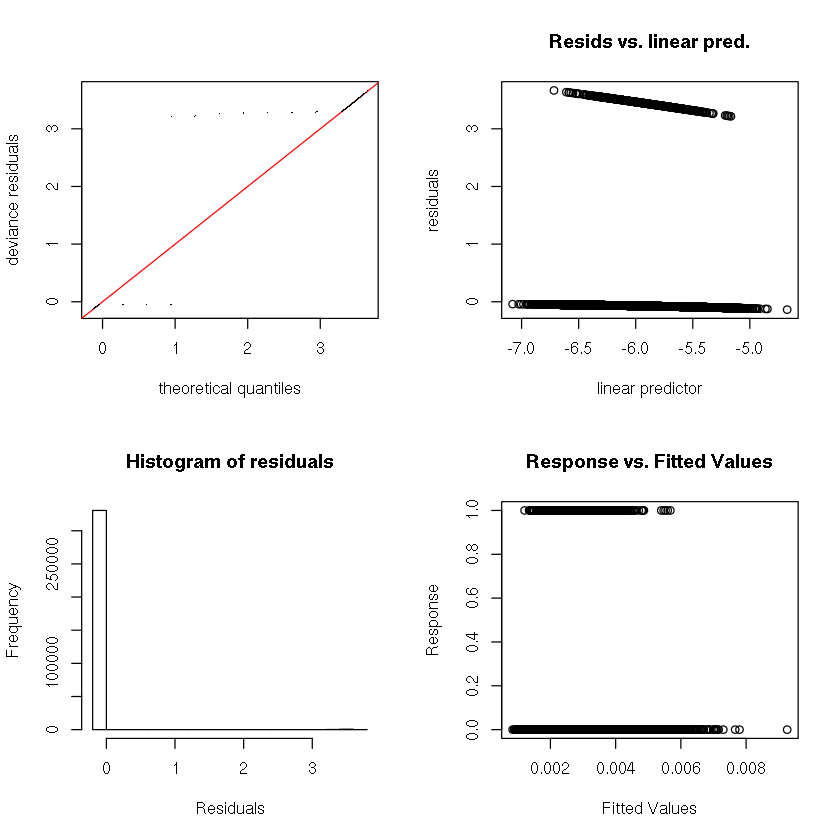

In [91]:
#IR-PRS vs. MACRO (ND)
#gaussian
#linear
m1 <- gam(relevel(as.factor(macro.0.0),"normo") ~ GRS_WT_IR + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10,data=ND,family="binomial",method="REML")
summary(m1)
#third knot
m2 <- gam(relevel(as.factor(macro.0.0),"normo") ~ s(GRS_WT_IR,k=50,bs='cr') + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10,data=ND,family="binomial",method="REML")
summary(m2)
gam.check(m2)


Family: binomial 
Link function: logit 

Formula:
relevel(as.factor(DN.0.0), "no") ~ GRS_WT_IR + AGE.0.0 + SEX.0.0 + 
    PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10

Parametric coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -6.062176   0.664820  -9.119  < 2e-16 ***
GRS_WT_IR     1.880966   1.504703   1.250   0.2113    
AGE.0.0       0.018131   0.008932   2.030   0.0424 *  
SEX.0.0Male   0.529262   0.130210   4.065 4.81e-05 ***
PC1           1.437484   2.876159   0.500   0.6172    
PC2           6.247969   3.737576   1.672   0.0946 .  
PC3         -12.793398   4.232103  -3.023   0.0025 ** 
PC4           7.801618   6.275801   1.243   0.2138    
PC5          -6.929871   6.998396  -0.990   0.3221    
PC6          11.473737   7.276350   1.577   0.1148    
PC7           8.432416   8.695283   0.970   0.3322    
PC8           5.680051   9.243091   0.615   0.5389    
PC9           3.199354   9.072209   0.353   0.7243    
PC10          9.049631


Family: binomial 
Link function: logit 

Formula:
relevel(as.factor(DN.0.0), "no") ~ s(GRS_WT_IR, k = 50, bs = "cr") + 
    AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + 
    PC8 + PC9 + PC10

Parametric coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -5.625667   0.559130 -10.061  < 2e-16 ***
AGE.0.0       0.018072   0.008931   2.024  0.04302 *  
SEX.0.0Male   0.527674   0.130226   4.052 5.08e-05 ***
PC1           1.369764   2.876615   0.476  0.63395    
PC2           6.269658   3.736757   1.678  0.09338 .  
PC3         -12.704208   4.232738  -3.001  0.00269 ** 
PC4           7.890854   6.275755   1.257  0.20862    
PC5          -6.660312   6.997093  -0.952  0.34116    
PC6          11.474521   7.281319   1.576  0.11505    
PC7           8.442817   8.696937   0.971  0.33166    
PC8           5.471087   9.242514   0.592  0.55389    
PC9           3.012793   9.079070   0.332  0.74001    
PC10          8.935212   9.482315   0.942  0.34604


Method: ML   Optimizer: outer newton
full convergence after 4 iterations.
Gradient range [-3.273344e-05,-3.273344e-05]
(score 1575.926 & scale 1).
Hessian positive definite, eigenvalue range [0.5180819,0.5180819].
Model rank =  62 / 62 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

                k'   edf k-index p-value
s(GRS_WT_IR) 49.00  2.58    0.89     0.4


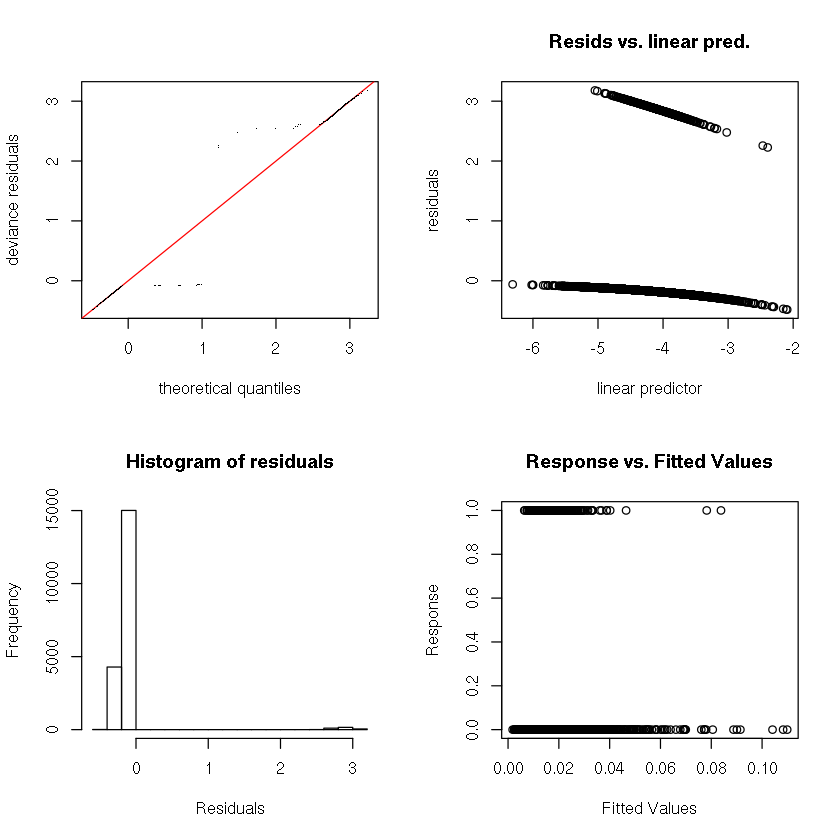

In [72]:
#IR-PRS vs. DN (T2D)
#gaussian
#linear
m1 <- gam(relevel(as.factor(DN.0.0),"no") ~ GRS_WT_IR + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10,data=T2D,family="binomial",method="ML")
summary(m1)
#third knot
m2 <- gam(relevel(as.factor(DN.0.0),"no") ~ s(GRS_WT_IR,k=50,bs='cr') + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10,data=T2D,family="binomial",method="ML")
summary(m2)
gam.check(m2)

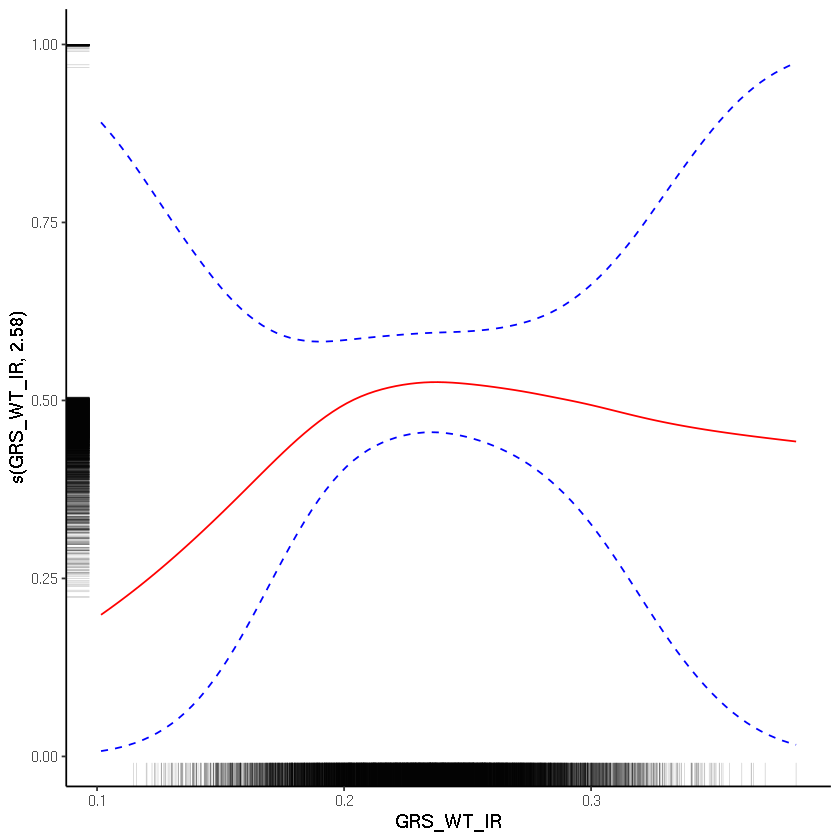

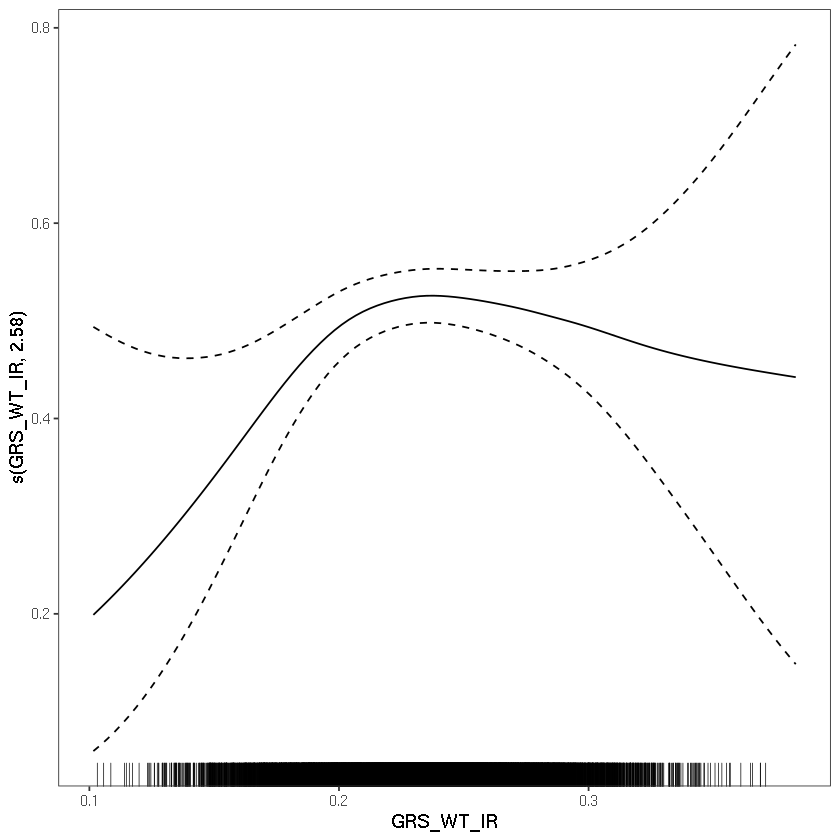

In [75]:
m2v <- getViz(m2)
o <- plot(sm(m2v, 1),trans = plogis,shift = coef(m2v)[1])
o + l_fitLine(colour = "red") + l_rug(mapping = aes(x=x, y=y), alpha = 0.2) +
    l_ciLine(mul = 5, colour = "blue", linetype = 2) + theme_classic()
plot(m2v,select=1,trans = plogis,shift = coef(m2v)[1])


Family: binomial 
Link function: logit 

Formula:
relevel(as.factor(DNCKD2.0.0), "DNCKD Control") ~ GRS_WT_IR + 
    AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + 
    PC8 + PC9 + PC10

Parametric coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -10.49154    1.21210  -8.656  < 2e-16 ***
GRS_WT_IR     4.10537    2.40676   1.706   0.0881 .  
AGE.0.0       0.06825    0.01662   4.107 4.01e-05 ***
SEX.0.0Male   0.51459    0.20740   2.481   0.0131 *  
PC1           1.79691    4.50239   0.399   0.6898    
PC2           6.12272    5.86535   1.044   0.2965    
PC3          -0.62678   10.59140  -0.059   0.9528    
PC4           8.78430    9.69658   0.906   0.3650    
PC5         -21.26152   11.13677  -1.909   0.0562 .  
PC6          -1.05908   12.42247  -0.085   0.9321    
PC7           5.14174   13.96022   0.368   0.7126    
PC8          -4.93129   14.58697  -0.338   0.7353    
PC9           3.44481   13.99061   0.246   0.8055    
PC10         -5.


Family: binomial 
Link function: logit 

Formula:
relevel(as.factor(DNCKD2.0.0), "DNCKD Control") ~ s(GRS_WT_IR, 
    k = 50, bs = "cr") + AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + 
    PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10

Parametric coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -9.53090    1.06112  -8.982  < 2e-16 ***
AGE.0.0       0.06825    0.01662   4.107 4.02e-05 ***
SEX.0.0Male   0.51410    0.20740   2.479   0.0132 *  
PC1           1.77795    4.50202   0.395   0.6929    
PC2           6.12166    5.86481   1.044   0.2966    
PC3          -0.60168   10.58778  -0.057   0.9547    
PC4           8.84903    9.69442   0.913   0.3614    
PC5         -21.19274   11.13451  -1.903   0.0570 .  
PC6          -1.03374   12.42314  -0.083   0.9337    
PC7           5.11000   13.95572   0.366   0.7142    
PC8          -5.03067   14.58434  -0.345   0.7301    
PC9           3.39481   13.99075   0.243   0.8083    
PC10         -5.57160   14.99097  -0.372   0.710


Method: ML   Optimizer: outer newton
full convergence after 6 iterations.
Gradient range [-0.0004303679,-0.0004303679]
(score 691.4155 & scale 1).
Hessian positive definite, eigenvalue range [0.04700632,0.04700632].
Model rank =  62 / 62 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

                k'   edf k-index p-value
s(GRS_WT_IR) 49.00  1.38    0.88    0.69


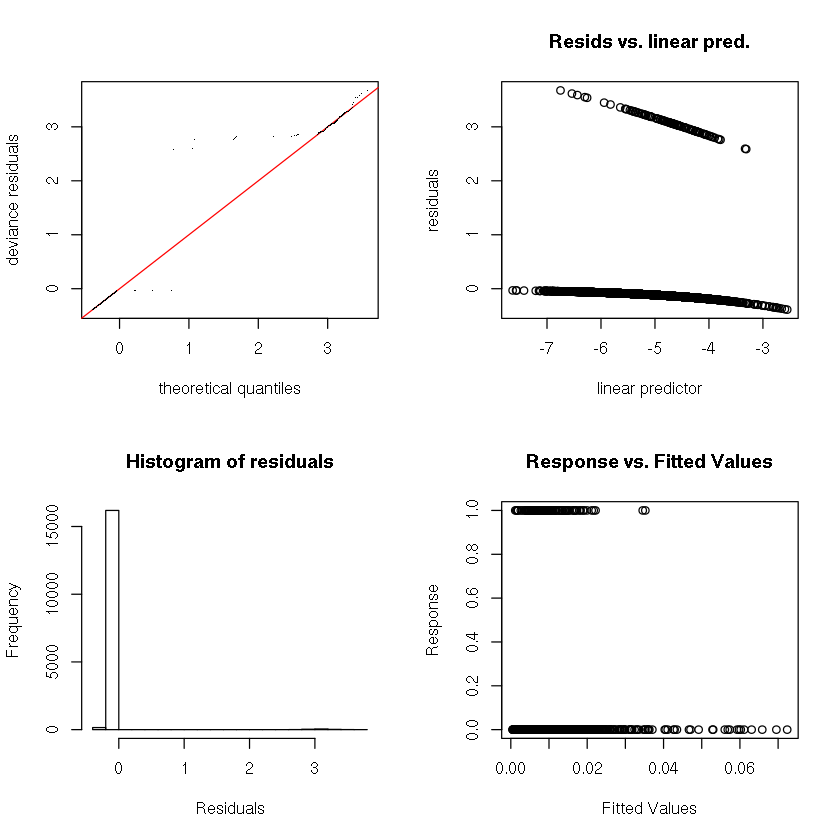

In [77]:
#IR-PRS vs. DN (DN-CKD)
#gaussian
#linear
m1 <- gam(relevel(as.factor(DNCKD2.0.0),"DNCKD Control") ~ GRS_WT_IR + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10,data=T2D,family="binomial",method="ML")
summary(m1)
#third knot
m2 <- gam(relevel(as.factor(DNCKD2.0.0),"DNCKD Control") ~ s(GRS_WT_IR,k=50,bs='cr') + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10,data=T2D,family="binomial",method="ML")
summary(m2)
gam.check(m2)


Family: binomial 
Link function: logit 

Formula:
relevel(as.factor(DNCKD2.0.0), "DNCKD Control") ~ GRS_WT_IR + 
    AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + 
    PC8 + PC9 + PC10

Parametric coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -9.250660   0.445664 -20.757  < 2e-16 ***
GRS_WT_IR   -0.857857   1.139257  -0.753    0.451    
AGE.0.0      0.047823   0.005969   8.011 1.13e-15 ***
SEX.0.0Male  0.529609   0.088703   5.971 2.36e-09 ***
PC1          3.250442   2.304711   1.410    0.158    
PC2          0.839992   3.013314   0.279    0.780    
PC3          1.828816   4.834869   0.378    0.705    
PC4          2.465649   4.887134   0.505    0.614    
PC5         -2.686105   5.254253  -0.511    0.609    
PC6          7.034785   5.568972   1.263    0.207    
PC7          0.356290   6.592041   0.054    0.957    
PC8         -2.828565   6.837466  -0.414    0.679    
PC9          0.310953   6.796051   0.046    0.964    
PC10         9.5


Family: binomial 
Link function: logit 

Formula:
relevel(as.factor(DNCKD2.0.0), "DNCKD Control") ~ s(GRS_WT_IR, 
    k = 50, bs = "cr") + AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + 
    PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10

Parametric coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -9.447170   0.361442 -26.137  < 2e-16 ***
AGE.0.0      0.047823   0.005969   8.011 1.13e-15 ***
SEX.0.0Male  0.529609   0.088703   5.971 2.36e-09 ***
PC1          3.250440   2.304711   1.410    0.158    
PC2          0.839980   3.013314   0.279    0.780    
PC3          1.828821   4.834869   0.378    0.705    
PC4          2.465640   4.887134   0.505    0.614    
PC5         -2.686105   5.254253  -0.511    0.609    
PC6          7.034779   5.568972   1.263    0.207    
PC7          0.356278   6.592041   0.054    0.957    
PC8         -2.828573   6.837466  -0.414    0.679    
PC9          0.310951   6.796051   0.046    0.964    
PC10         9.551341   7.127676   1.340    0.18


Method: ML   Optimizer: outer newton
full convergence after 8 iterations.
Gradient range [-0.0008635889,-0.0008635889]
(score 3818.843 & scale 1).
Hessian positive definite, eigenvalue range [0.0008628487,0.0008628487].
Model rank =  62 / 62 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

             k' edf k-index p-value
s(GRS_WT_IR) 49   1    0.87    0.14


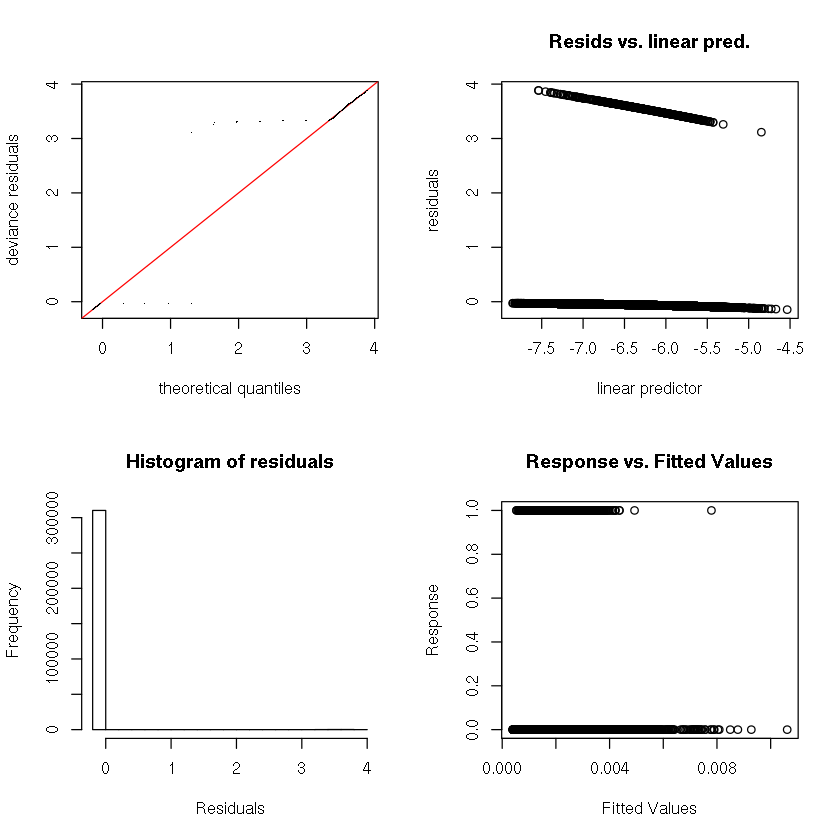

In [90]:
#IR-PRS vs. DN (DN-CKD, ND)
#gaussian
#linear
m1 <- gam(relevel(as.factor(DNCKD2.0.0),"DNCKD Control") ~ GRS_WT_IR + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10,data=ND,family="binomial",method="ML")
summary(m1)
#third knot
m2 <- gam(relevel(as.factor(DNCKD2.0.0),"DNCKD Control") ~ s(GRS_WT_IR,k=50,bs='cr') + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10,data=ND,family="binomial",method="ML")
summary(m2)
gam.check(m2)


Family: binomial 
Link function: logit 

Formula:
relevel(as.factor(CKD_only.0.0), "CKD controls") ~ GRS_WT_IR + 
    AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + 
    PC8 + PC9 + PC10

Parametric coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -11.333279   0.573988 -19.745  < 2e-16 ***
GRS_WT_IR     0.956191   0.978547   0.977 0.328493    
AGE.0.0       0.127560   0.008092  15.763  < 2e-16 ***
SEX.0.0Male  -0.256970   0.075474  -3.405 0.000662 ***
PC1           0.043696   2.164383   0.020 0.983893    
PC2          -0.235578   2.603140  -0.090 0.927892    
PC3          -1.788859   4.471615  -0.400 0.689121    
PC4           1.289086   4.081513   0.316 0.752127    
PC5          -8.696591   4.656679  -1.868 0.061824 .  
PC6           2.047048   5.213578   0.393 0.694587    
PC7          -6.917047   5.672713  -1.219 0.222710    
PC8          10.489632   6.100662   1.719 0.085537 .  
PC9          -2.857568   5.804531  -0.492 0.622508    
P


Family: binomial 
Link function: logit 

Formula:
relevel(as.factor(CKD_only.0.0), "CKD controls") ~ s(GRS_WT_IR, 
    k = 50, bs = "cr") + AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + 
    PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10

Parametric coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -11.109582   0.524276 -21.190  < 2e-16 ***
AGE.0.0       0.127549   0.008092  15.763  < 2e-16 ***
SEX.0.0Male  -0.256742   0.075480  -3.401  0.00067 ***
PC1           0.040672   2.165070   0.019  0.98501    
PC2          -0.260450   2.603663  -0.100  0.92032    
PC3          -1.733963   4.469389  -0.388  0.69804    
PC4           1.341633   4.080935   0.329  0.74234    
PC5          -8.616921   4.657198  -1.850  0.06428 .  
PC6           2.064878   5.214213   0.396  0.69210    
PC7          -6.977700   5.672105  -1.230  0.21863    
PC8          10.375280   6.101073   1.701  0.08902 .  
PC9          -2.921011   5.804264  -0.503  0.61479    
PC10        -11.727062   6.045462 


Method: ML   Optimizer: outer newton
full convergence after 5 iterations.
Gradient range [-0.002021975,-0.002021975]
(score 3057.442 & scale 1).
Hessian positive definite, eigenvalue range [0.1788521,0.1788521].
Model rank =  62 / 62 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

                k'   edf k-index p-value
s(GRS_WT_IR) 49.00  2.32     0.9    0.24


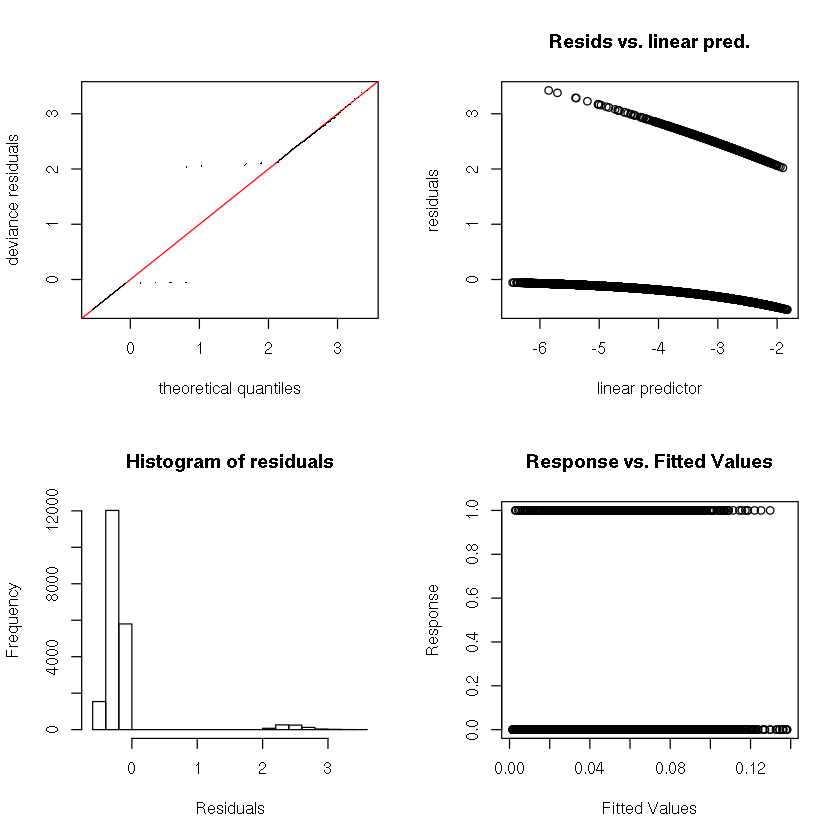

In [80]:
#IR-PRS vs. ckd (t2d)
#gaussian
#linear
m1 <- gam(relevel(as.factor(CKD_only.0.0),"CKD controls") ~ GRS_WT_IR + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10,data=T2D,family="binomial",method="ML")
summary(m1)
#third knot
m2 <- gam(relevel(as.factor(CKD_only.0.0),"CKD controls") ~ s(GRS_WT_IR,k=50,bs='cr') + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10,data=T2D,family="binomial",method="ML")
summary(m2)
gam.check(m2)


Family: binomial 
Link function: logit 

Formula:
relevel(as.factor(CKD_only.0.0), "CKD controls") ~ GRS_WT_IR + 
    AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + 
    PC8 + PC9 + PC10

Parametric coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -12.274330   0.178673 -68.697  < 2e-16 ***
GRS_WT_IR     0.740226   0.361568   2.047  0.04063 *  
AGE.0.0       0.133144   0.002489  53.489  < 2e-16 ***
SEX.0.0Male  -0.164783   0.028125  -5.859 4.66e-09 ***
PC1           1.845161   0.829654   2.224  0.02615 *  
PC2          -3.223224   0.996935  -3.233  0.00122 ** 
PC3           2.147969   1.665060   1.290  0.19704    
PC4          -0.312315   1.576160  -0.198  0.84293    
PC5          -5.313750   1.730510  -3.071  0.00214 ** 
PC6           0.219208   1.975293   0.111  0.91164    
PC7           1.172524   2.108793   0.556  0.57820    
PC8           0.623305   2.201081   0.283  0.77704    
PC9           2.262503   2.158109   1.048  0.29447    
P


Family: binomial 
Link function: logit 

Formula:
relevel(as.factor(CKD_only.0.0), "CKD controls") ~ s(GRS_WT_IR, 
    k = 50, bs = "cr") + AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + 
    PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10

Parametric coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -12.104723   0.157848 -76.686  < 2e-16 ***
AGE.0.0       0.133144   0.002489  53.489  < 2e-16 ***
SEX.0.0Male  -0.164784   0.028125  -5.859 4.65e-09 ***
PC1           1.845170   0.829654   2.224  0.02615 *  
PC2          -3.223093   0.996935  -3.233  0.00122 ** 
PC3           2.147902   1.665059   1.290  0.19706    
PC4          -0.312206   1.576160  -0.198  0.84298    
PC5          -5.313784   1.730511  -3.071  0.00214 ** 
PC6           0.219356   1.975293   0.111  0.91158    
PC7           1.172613   2.108793   0.556  0.57817    
PC8           0.623403   2.201081   0.283  0.77700    
PC9           2.262375   2.158109   1.048  0.29449    
PC10          1.284356   2.244077 


Method: ML   Optimizer: outer newton
full convergence after 6 iterations.
Gradient range [-0.009272374,-0.009272374]
(score 25441.93 & scale 1).
Hessian positive definite, eigenvalue range [0.009363251,0.009363251].
Model rank =  62 / 62 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

                k'   edf k-index p-value
s(GRS_WT_IR) 49.00  1.03    0.91    0.19


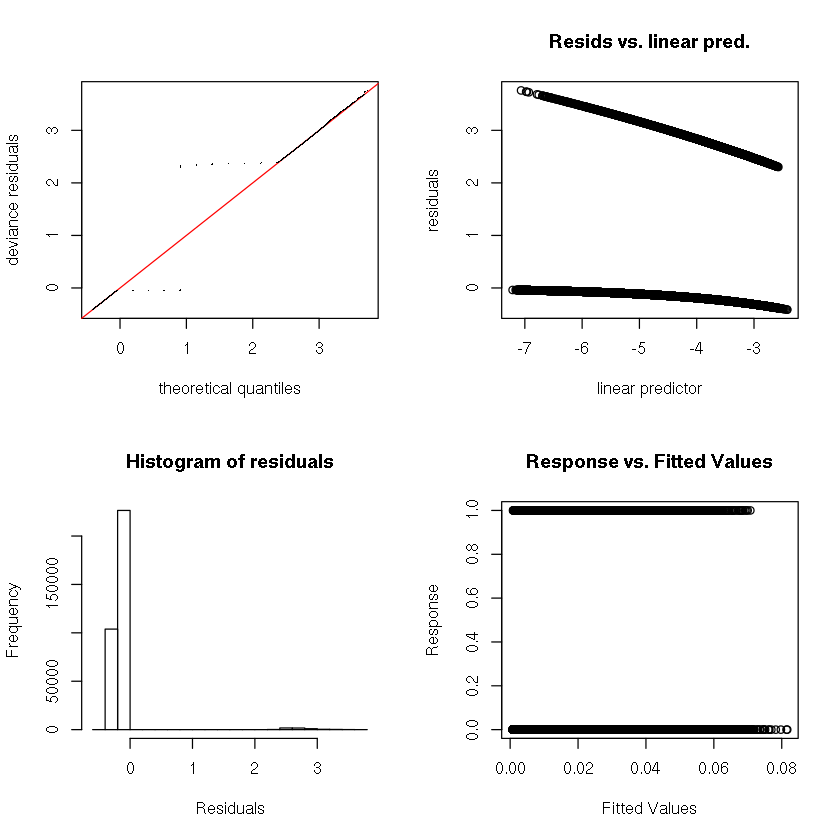

In [88]:
#IR-PRS vs. CKD (ND)
#gaussian
#linear
m1 <- gam(relevel(as.factor(CKD_only.0.0),"CKD controls") ~ GRS_WT_IR + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10,data=ND,family="binomial",method="ML")
summary(m1)
#third knot
m2 <- gam(relevel(as.factor(CKD_only.0.0),"CKD controls") ~ s(GRS_WT_IR,k=50,bs='cr') + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10,data=ND,family="binomial",method="ML")
summary(m2)
gam.check(m2)

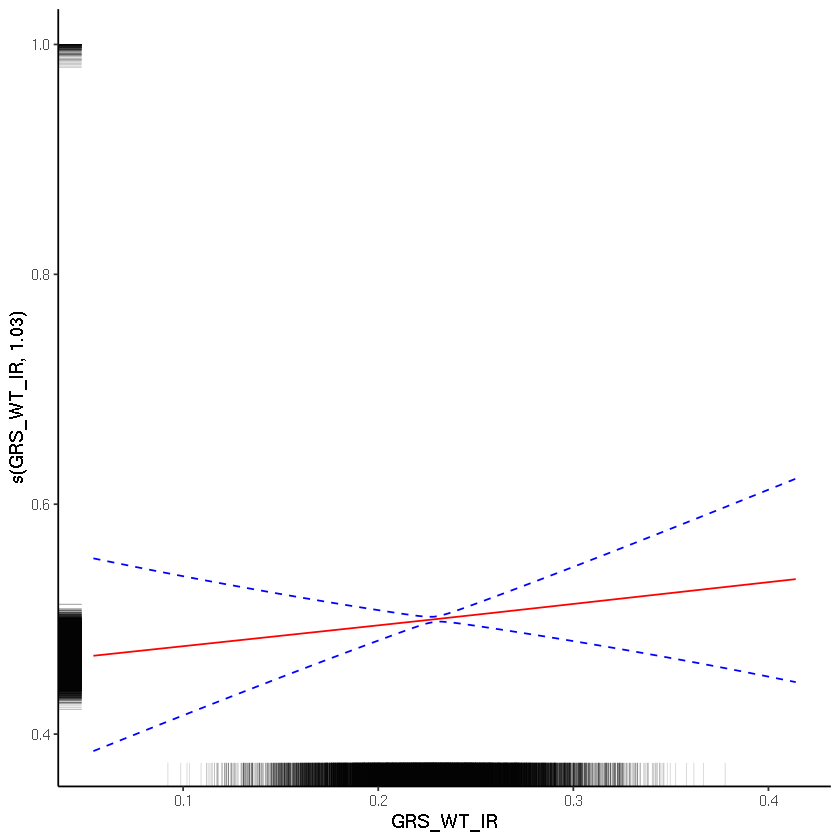

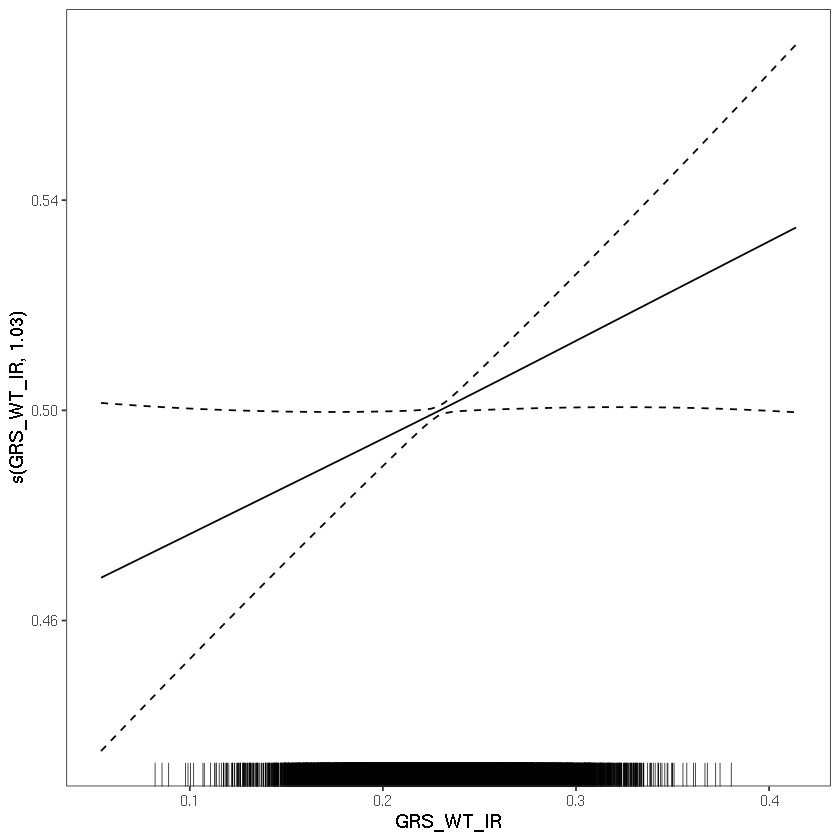

In [89]:
m2v <- getViz(m2)
o <- plot(sm(m2v, 1),trans = plogis,shift = coef(m2v)[1])
o + l_fitLine(colour = "red") + l_rug(mapping = aes(x=x, y=y), alpha = 0.2) +
    l_ciLine(mul = 5, colour = "blue", linetype = 2) + theme_classic()
plot(m2v,select=1,trans = plogis,shift = coef(m2v)[1])


Family: binomial 
Link function: logit 

Formula:
relevel(as.factor(CKD_ex.0.0), "CKD controls") ~ GRS_WT_IR + 
    AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + 
    PC8 + PC9 + PC10

Parametric coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -11.98609    1.05901 -11.318   <2e-16 ***
GRS_WT_IR    -1.22400    1.81467  -0.675    0.500    
AGE.0.0       0.12410    0.01495   8.302   <2e-16 ***
SEX.0.0Male  -0.08258    0.14221  -0.581    0.561    
PC1          -3.20262    4.52119  -0.708    0.479    
PC2          -0.69123    4.92846  -0.140    0.888    
PC3           2.36959   10.06799   0.235    0.814    
PC4           2.33317    7.83083   0.298    0.766    
PC5          -0.62264    9.41022  -0.066    0.947    
PC6         -17.80227   11.03023  -1.614    0.107    
PC7          13.16857   10.58793   1.244    0.214    
PC8          -5.19128   11.00674  -0.472    0.637    
PC9          -7.77762   11.13978  -0.698    0.485    
PC10         -6.5


Family: binomial 
Link function: logit 

Formula:
relevel(as.factor(CKD_ex.0.0), "CKD controls") ~ s(GRS_WT_IR, 
    k = 50, bs = "cr") + AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + 
    PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10

Parametric coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -12.27267    0.96953 -12.658   <2e-16 ***
AGE.0.0       0.12410    0.01495   8.302   <2e-16 ***
SEX.0.0Male  -0.08259    0.14221  -0.581    0.561    
PC1          -3.20266    4.52118  -0.708    0.479    
PC2          -0.69121    4.92846  -0.140    0.888    
PC3           2.36965   10.06797   0.235    0.814    
PC4           2.33326    7.83083   0.298    0.766    
PC5          -0.62247    9.41021  -0.066    0.947    
PC6         -17.80222   11.03023  -1.614    0.107    
PC7          13.16847   10.58793   1.244    0.214    
PC8          -5.19141   11.00674  -0.472    0.637    
PC9          -7.77788   11.13979  -0.698    0.485    
PC10         -6.58347   11.23110  -0.586    0.558


Method: ML   Optimizer: outer newton
full convergence after 9 iterations.
Gradient range [-0.0004710073,-0.0004710073]
(score 1121.273 & scale 1).
Hessian positive definite, eigenvalue range [0.0004708056,0.0004708056].
Model rank =  62 / 62 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

             k' edf k-index p-value
s(GRS_WT_IR) 49   1     0.9    0.17


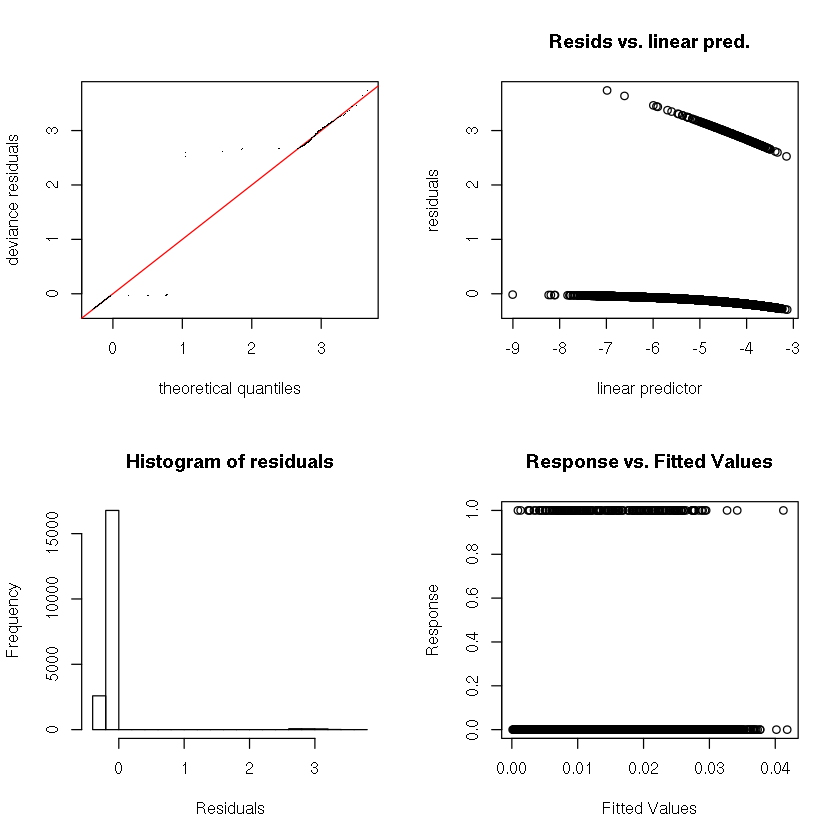

In [83]:
#IR-PRS vs. DN (CKD-extreme)
#gaussian
#linear
m1 <- gam(relevel(as.factor(CKD_ex.0.0),"CKD controls") ~ GRS_WT_IR + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10,data=T2D,family="binomial",method="ML")
summary(m1)
#third knot
m2 <- gam(relevel(as.factor(CKD_ex.0.0),"CKD controls") ~ s(GRS_WT_IR,k=50,bs='cr') + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10,data=T2D,family="binomial",method="ML")
summary(m2)
gam.check(m2)


Family: binomial 
Link function: logit 

Formula:
relevel(as.factor(CKD_ex.0.0), "CKD controls") ~ GRS_WT_IR + 
    AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + 
    PC8 + PC9 + PC10

Parametric coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -13.093816   0.440622 -29.717   <2e-16 ***
GRS_WT_IR     0.455513   0.939950   0.485    0.628    
AGE.0.0       0.115071   0.006088  18.902   <2e-16 ***
SEX.0.0Male   0.037906   0.072340   0.524    0.600    
PC1           0.772955   2.038929   0.379    0.705    
PC2           1.572326   2.478768   0.634    0.526    
PC3          -2.741804   3.794793  -0.723    0.470    
PC4          -5.395721   4.312590  -1.251    0.211    
PC5          -4.142702   4.448346  -0.931    0.352    
PC6           4.033793   4.946286   0.816    0.415    
PC7           1.131821   5.390032   0.210    0.834    
PC8          -7.219403   5.648275  -1.278    0.201    
PC9           4.284194   5.723442   0.749    0.454    
PC1


Family: binomial 
Link function: logit 

Formula:
relevel(as.factor(CKD_ex.0.0), "CKD controls") ~ s(GRS_WT_IR, 
    k = 50, bs = "cr") + AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + 
    PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10

Parametric coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -12.989452   0.383486 -33.872   <2e-16 ***
AGE.0.0       0.115071   0.006088  18.902   <2e-16 ***
SEX.0.0Male   0.037906   0.072340   0.524    0.600    
PC1           0.772969   2.038930   0.379    0.705    
PC2           1.572421   2.478768   0.634    0.526    
PC3          -2.741844   3.794792  -0.723    0.470    
PC4          -5.395620   4.312589  -1.251    0.211    
PC5          -4.142719   4.448348  -0.931    0.352    
PC6           4.033872   4.946286   0.816    0.415    
PC7           1.131885   5.390033   0.210    0.834    
PC8          -7.219327   5.648276  -1.278    0.201    
PC9           4.284126   5.723441   0.749    0.454    
PC10          6.180203   5.858256   


Method: ML   Optimizer: outer newton
full convergence after 7 iterations.
Gradient range [-0.001604467,-0.001604467]
(score 5215.613 & scale 1).
Hessian positive definite, eigenvalue range [0.001611029,0.001611029].
Model rank =  62 / 62 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

                k'   edf k-index p-value
s(GRS_WT_IR) 49.00  1.01    0.87    0.13


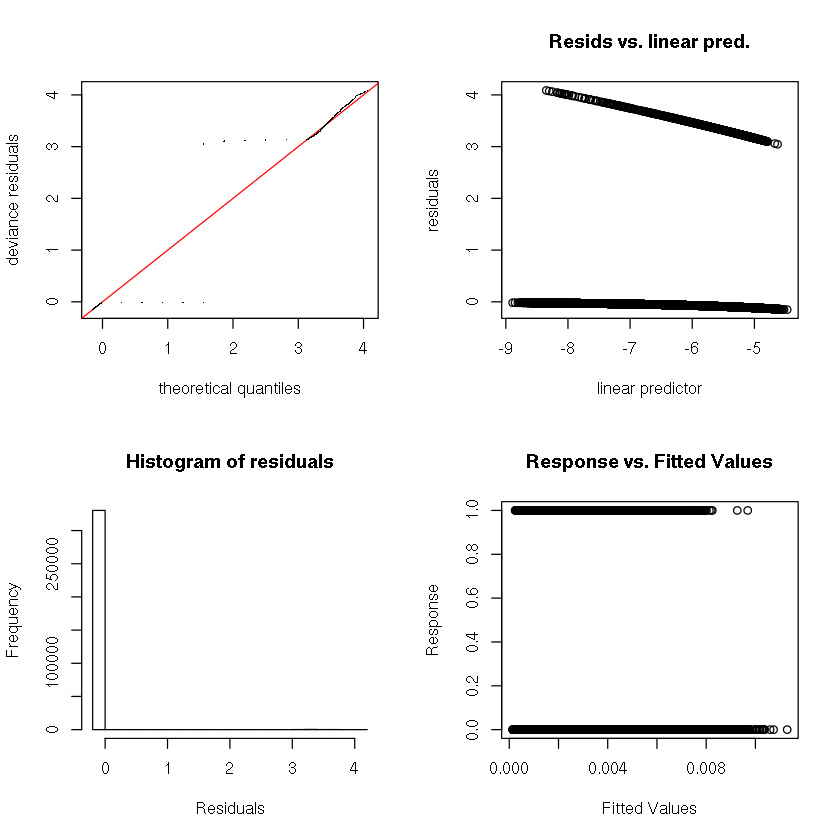

In [87]:
#IR-PRS vs. CKD-extreme (ND)
#gaussian
#linear
m1 <- gam(relevel(as.factor(CKD_ex.0.0),"CKD controls") ~ GRS_WT_IR + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10,data=ND,family="binomial",method="ML")
summary(m1)
#third knot
m2 <- gam(relevel(as.factor(CKD_ex.0.0),"CKD controls") ~ s(GRS_WT_IR,k=50,bs='cr') + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10,data=ND,family="binomial",method="ML")
summary(m2)
gam.check(m2)


Family: binomial 
Link function: logit 

Formula:
relevel(as.factor(ALL.0.0), "no") ~ GRS_WT_IR + AGE.0.0 + SEX.0.0 + 
    PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10

Parametric coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -2.972931   0.234367 -12.685  < 2e-16 ***
GRS_WT_IR    0.759494   0.543578   1.397 0.162350    
AGE.0.0      0.011492   0.003152   3.646 0.000266 ***
SEX.0.0Male  0.393310   0.044912   8.757  < 2e-16 ***
PC1          2.342372   1.164905   2.011 0.044348 *  
PC2         -1.105489   1.451830  -0.761 0.446391    
PC3         -4.496040   2.119340  -2.121 0.033885 *  
PC4          1.012591   2.383771   0.425 0.670993    
PC5         -2.353799   2.589131  -0.909 0.363293    
PC6          5.258901   2.783584   1.889 0.058858 .  
PC7         -1.836028   3.178034  -0.578 0.563450    
PC8          4.782200   3.339103   1.432 0.152092    
PC9          2.436522   3.330521   0.732 0.464429    
PC10         4.726487   3.408152   


Family: binomial 
Link function: logit 

Formula:
relevel(as.factor(ALL.0.0), "no") ~ s(GRS_WT_IR, k = 50, bs = "cr") + 
    AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + 
    PC8 + PC9 + PC10

Parametric coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -2.795027   0.195710 -14.282  < 2e-16 ***
AGE.0.0      0.011492   0.003152   3.646 0.000266 ***
SEX.0.0Male  0.393311   0.044912   8.757  < 2e-16 ***
PC1          2.342393   1.164906   2.011 0.044346 *  
PC2         -1.105510   1.451830  -0.761 0.446383    
PC3         -4.496058   2.119341  -2.121 0.033885 *  
PC4          1.012564   2.383772   0.425 0.671001    
PC5         -2.353861   2.589133  -0.909 0.363281    
PC6          5.258910   2.783584   1.889 0.058857 .  
PC7         -1.836050   3.178033  -0.578 0.563445    
PC8          4.782230   3.339104   1.432 0.152090    
PC9          2.436587   3.330521   0.732 0.464417    
PC10         4.726473   3.408153   1.387 0.165499    
---
Sign


Method: ML   Optimizer: outer newton
full convergence after 8 iterations.
Gradient range [-0.001747871,-0.001747871]
(score 7859.866 & scale 1).
Hessian positive definite, eigenvalue range [0.001741828,0.001741828].
Model rank =  62 / 62 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

                k'   edf k-index p-value
s(GRS_WT_IR) 49.00  1.01    0.95    0.38


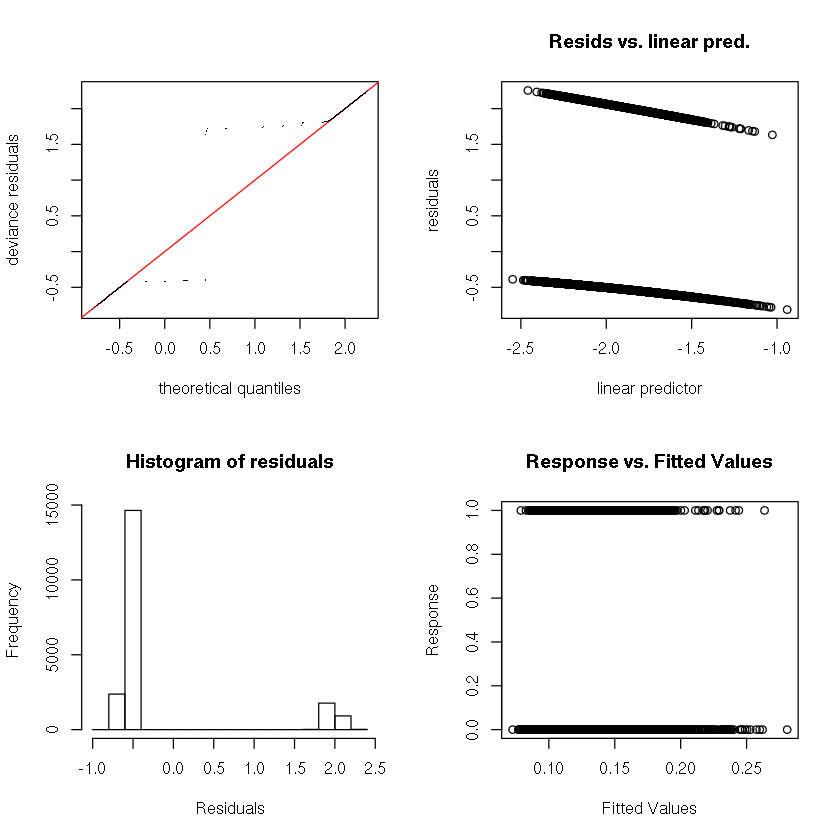

In [84]:
#IR-PRS vs. All (T2D)
#gaussian
#linear
m1 <- gam(relevel(as.factor(ALL.0.0),"no") ~ GRS_WT_IR + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10,data=T2D,family="binomial",method="ML")
summary(m1)
#third knot
m2 <- gam(relevel(as.factor(ALL.0.0),"no") ~ s(GRS_WT_IR,k=50,bs='cr') + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10,data=T2D,family="binomial",method="ML")
summary(m2)
gam.check(m2)


Family: binomial 
Link function: logit 

Formula:
relevel(as.factor(ALL.0.0), "no") ~ GRS_WT_IR + AGE.0.0 + SEX.0.0 + 
    PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10

Parametric coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -5.27536    0.08947 -58.963  < 2e-16 ***
GRS_WT_IR    0.93968    0.23590   3.983 6.80e-05 ***
AGE.0.0      0.03190    0.00119  26.803  < 2e-16 ***
SEX.0.0Male  0.00318    0.01820   0.175  0.86131    
PC1         -0.33161    0.53431  -0.621  0.53484    
PC2          1.06878    0.63857   1.674  0.09419 .  
PC3         -1.44236    0.91345  -1.579  0.11433    
PC4          2.68576    1.02100   2.631  0.00853 ** 
PC5          0.18244    1.15157   0.158  0.87412    
PC6          3.95985    1.25207   3.163  0.00156 ** 
PC7          5.86249    1.36161   4.306 1.67e-05 ***
PC8          0.12915    1.44171   0.090  0.92862    
PC9          1.10377    1.43221   0.771  0.44090    
PC10        -0.91117    1.46463  -0.622  0.53386 


Family: binomial 
Link function: logit 

Formula:
relevel(as.factor(ALL.0.0), "no") ~ s(GRS_WT_IR, k = 50, bs = "cr") + 
    AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + 
    PC8 + PC9 + PC10

Parametric coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -5.06004    0.07086 -71.412  < 2e-16 ***
AGE.0.0      0.03190    0.00119  26.803  < 2e-16 ***
SEX.0.0Male  0.00318    0.01820   0.175  0.86131    
PC1         -0.33161    0.53431  -0.621  0.53484    
PC2          1.06879    0.63857   1.674  0.09418 .  
PC3         -1.44236    0.91345  -1.579  0.11433    
PC4          2.68576    1.02100   2.631  0.00853 ** 
PC5          0.18245    1.15157   0.158  0.87412    
PC6          3.95985    1.25207   3.163  0.00156 ** 
PC7          5.86250    1.36161   4.306 1.67e-05 ***
PC8          0.12917    1.44171   0.090  0.92861    
PC9          1.10377    1.43221   0.771  0.44090    
PC10        -0.91116    1.46463  -0.622  0.53387    
---
Signif. codes:  0 


Method: ML   Optimizer: outer newton
full convergence after 5 iterations.
Gradient range [-0.026206,-0.026206]
(score 53407.16 & scale 1).
Hessian positive definite, eigenvalue range [0.02552488,0.02552488].
Model rank =  62 / 62 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

                k'   edf k-index p-value
s(GRS_WT_IR) 49.00  1.04    0.92    0.86


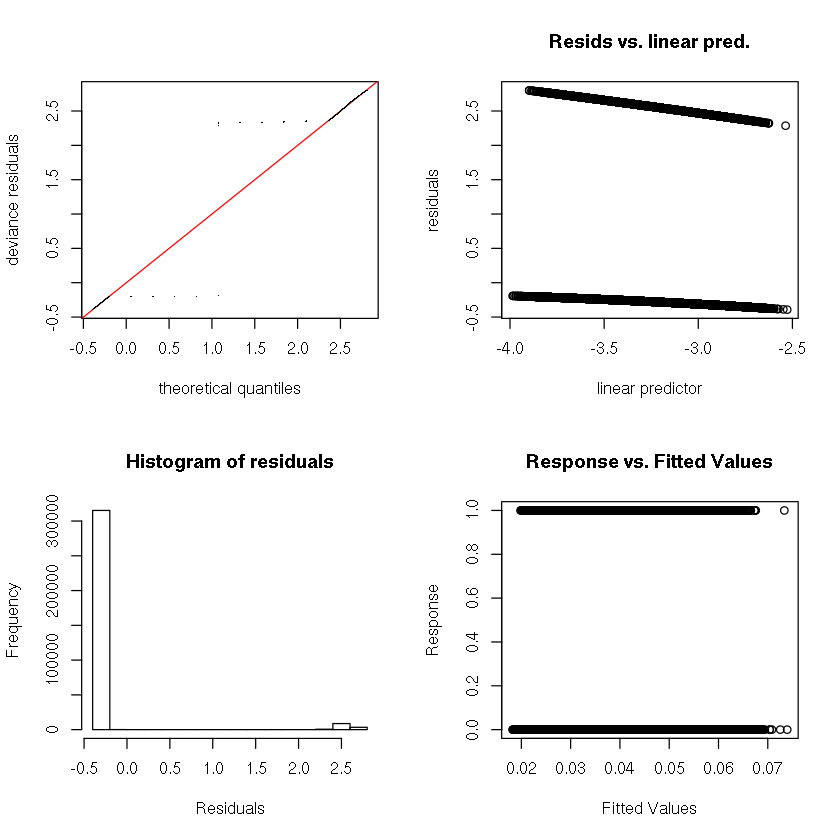

In [85]:
#IR-PRS vs. All (ND)
#gaussian
#linear
m1 <- gam(relevel(as.factor(ALL.0.0),"no") ~ GRS_WT_IR + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10,data=ND,family="binomial",method="ML")
summary(m1)
#third knot
m2 <- gam(relevel(as.factor(ALL.0.0),"no") ~ s(GRS_WT_IR,k=50,bs='cr') + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10,data=ND,family="binomial",method="ML")
summary(m2)
gam.check(m2)

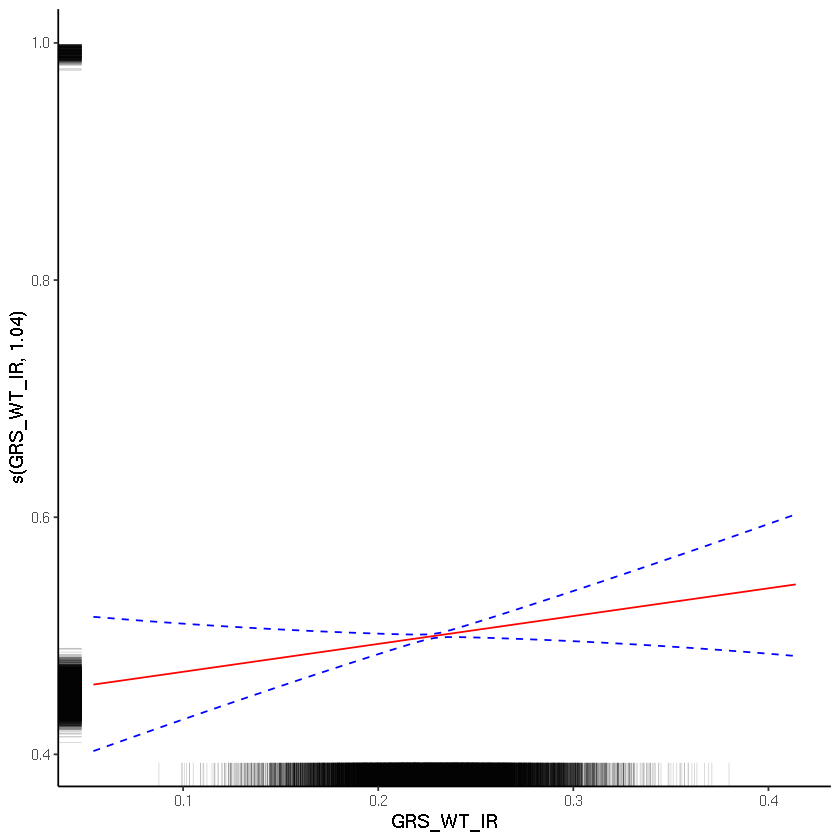

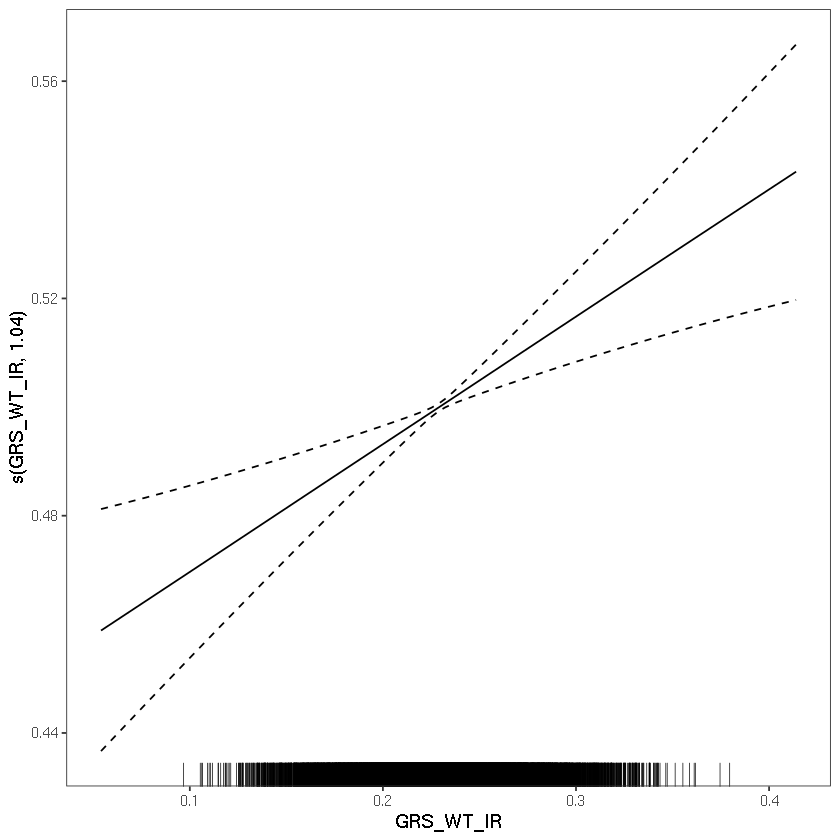

In [86]:
m2v <- getViz(m2)
o <- plot(sm(m2v, 1),trans = plogis,shift = coef(m2v)[1])
o + l_fitLine(colour = "red") + l_rug(mapping = aes(x=x, y=y), alpha = 0.2) +
    l_ciLine(mul = 5, colour = "blue", linetype = 2) + theme_classic()
plot(m2v,select=1,trans = plogis,shift = coef(m2v)[1])

Frequencies of Missing Values Due to Each Variable
    EGFR.0.0 GRS_WT_T2DIR      AGE.0.0      SEX.0.0          PC1          PC2 
         956            1            0            0            0            0 
         PC3          PC4          PC5          PC6          PC7          PC8 
           0            0            0            0            0            0 
         PC9         PC10 
           0            0 

Linear Regression Model
 
 ols(formula = EGFR.0.0 ~ GRS_WT_T2DIR + AGE.0.0 + SEX.0.0 + PC1 + 
     PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10, data = T2D)
 
 
                  Model Likelihood     Discrimination    
                     Ratio Test           Indexes        
 Obs    20331    LR chi2    4806.70    R2       0.211    
 sigma13.4015    d.f.            13    R2 adj   0.210    
 d.f.   20317    Pr(> chi2)  0.0000    g        7.677    
 
 Residuals
 
     Min      1Q  Median      3Q     Max 
 -84.576  -6.833   3.898   9.013  52.979 
 
 
              Co

2.5 %       97.5 %     
Intercept    152.1148043 161.3518163
GRS_WT_T2DIR  -0.7589920  -0.1260996
AGE.0.0       -1.0448710  -0.9901890
SEX.0.0=Male   0.3730206   1.1341113
PC1          -22.5716542  -0.9907287
PC2            9.2099651  35.1613156
PC3          -17.8199584  23.9160029
PC4           -3.3188790  39.1995623
PC5            8.0203168  55.0206604
PC6          -12.5355314  38.7829495
PC7          -31.6082328  24.9154565
PC8          -31.6631524  27.4641756
PC9          -40.1558119  19.4380670
PC10           3.9009730  64.3483642

Frequencies of Missing Values Due to Each Variable
    EGFR.0.0 GRS_WT_T2DIR      AGE.0.0      SEX.0.0          PC1          PC2 
       15770           11            0            0            0            0 
         PC3          PC4          PC5          PC6          PC7          PC8 
           0            0            0            0            0            0 
         PC9         PC10 
           0            0 

Linear Regression Model
 
 ols(formula = EGFR.0.0 ~ GRS_WT_T2DIR + AGE.0.0 + SEX.0.0 + PC1 + 
     PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10, data = ND)
 
 
                  Model Likelihood      Discrimination    
                     Ratio Test            Indexes        
 Obs   336419    LR chi2    85303.45    R2       0.224    
 sigma11.3179    d.f.             13    R2 adj   0.224    
 d.f.  336405    Pr(> chi2)   0.0000    g        6.970    
 
 Residuals
 
     Min      1Q  Median      3Q     Max 
 -96.626  -7.006   3.526   8.146 125.332 
 
 
            

2.5 %       97.5 %     
Intercept    130.5920346 132.4287523
GRS_WT_T2DIR   0.1153504   0.2467482
AGE.0.0       -0.7548242  -0.7452814
SEX.0.0=Male  -0.3173835  -0.1635019
PC1          -15.4160471 -10.9542071
PC2           22.0337907  27.4469049
PC3           -8.1797967  -0.3435730
PC4           -2.7880068   5.9843057
PC5           14.0464225  23.7538487
PC6           10.9316905  21.4482937
PC7           -5.7487576   5.7882322
PC8           -0.8517322  11.3085852
PC9           -2.5833160   9.6143725
PC10          -4.8568123   7.5244549

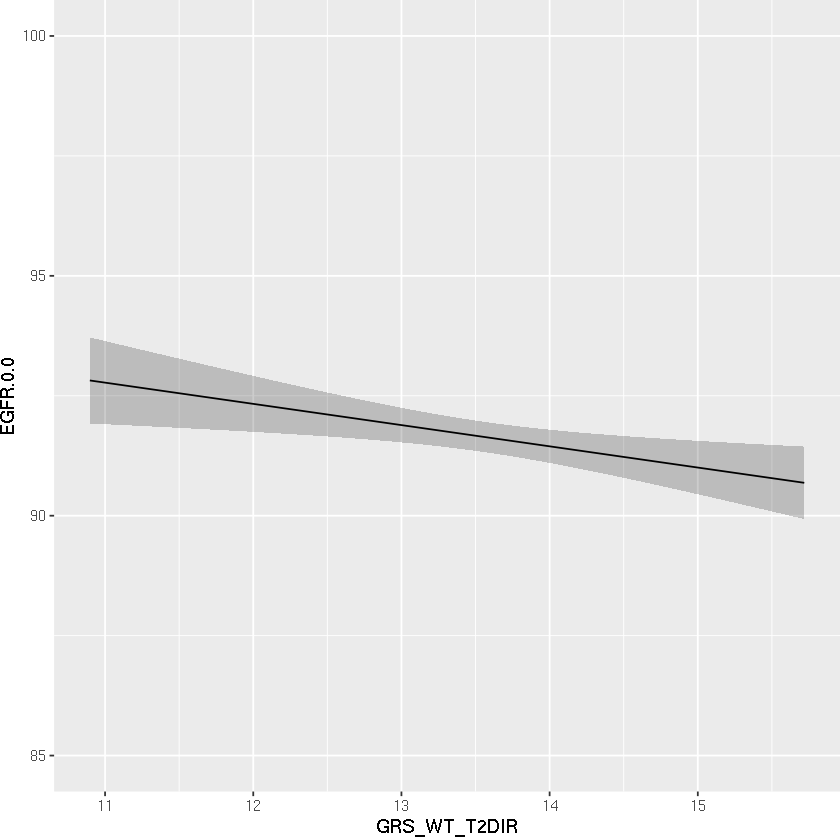

Frequencies of Missing Values Due to Each Variable
    EGFR.0.0 GRS_WT_T2DIR      AGE.0.0      SEX.0.0          PC1          PC2 
       16726           12            0            0            0            0 
         PC3          PC4          PC5          PC6          PC7          PC8 
           0            0            0            0            0            0 
         PC9         PC10 
           0            0 

Linear Regression Model
 
 ols(formula = EGFR.0.0 ~ GRS_WT_T2DIR + AGE.0.0 + SEX.0.0 + PC1 + 
     PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10, data = UKBB_AG2)
 
 
                  Model Likelihood      Discrimination    
                     Ratio Test            Indexes        
 Obs   356750    LR chi2    89550.58    R2       0.222    
 sigma11.4586    d.f.             13    R2 adj   0.222    
 d.f.  356736    Pr(> chi2)   0.0000    g        7.008    
 
 Residuals
 
     Min      1Q  Median      3Q     Max 
 -96.867  -7.020   3.570   8.184 125.186 
 
 
      

2.5 %       97.5 %      
Intercept    130.8647047 132.65758525
GRS_WT_T2DIR   0.1307994   0.25925765
AGE.0.0       -0.7620177  -0.75261157
SEX.0.0=Male  -0.2189560  -0.06793641
PC1          -15.4619100 -11.07489256
PC2           21.9537132  27.27393558
PC3           -7.9171567  -0.17325673
PC4           -1.6372055   6.98983008
PC5           14.4776222  24.02328518
PC6           10.8378277  21.18382660
PC7           -5.6599000   5.69327305
PC8           -1.1024900  10.85907470
PC9           -3.1254847   8.87595910
PC10          -2.7393125   9.44238553

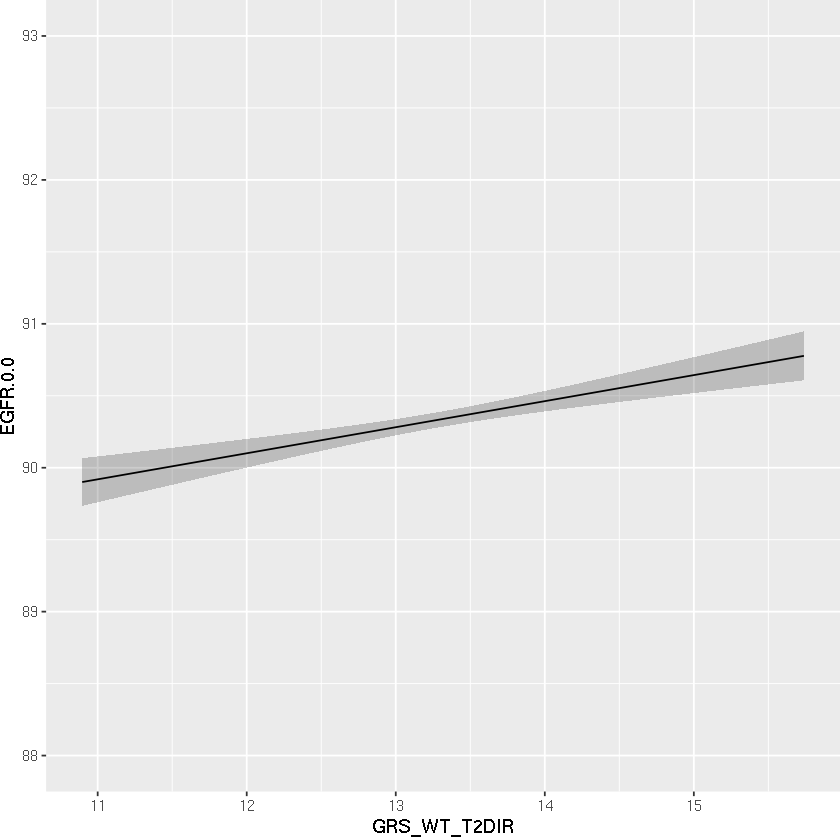

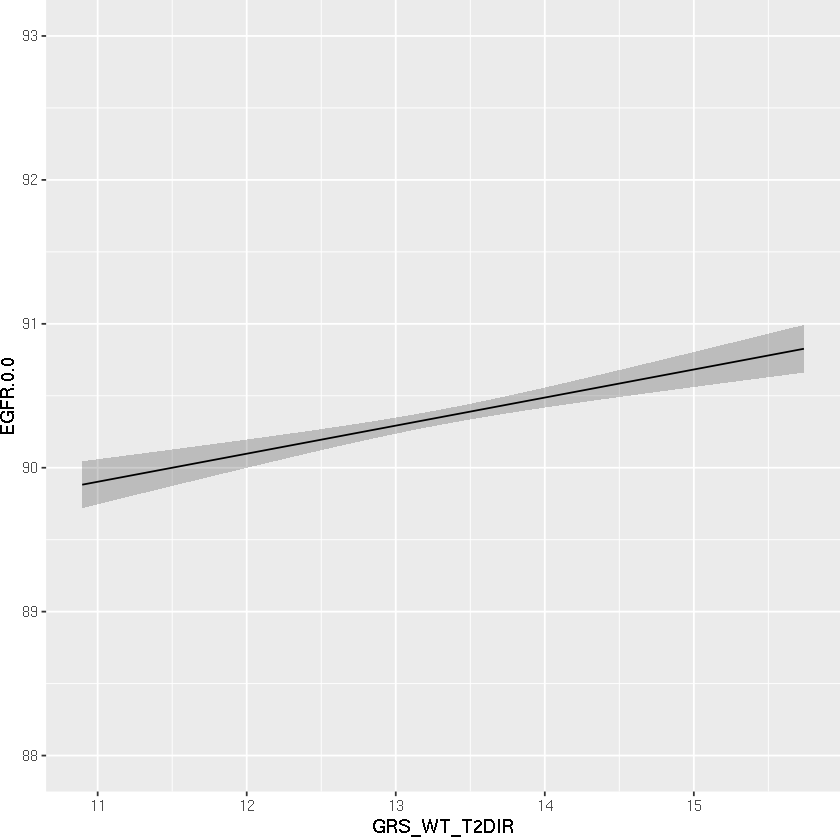

In [100]:
#############################EGFR#################################
#T2D, EGFR
ddist <- datadist(UKBB_AG2[,c('EGFR.0.0','AGE.0.0','GRS_WT_T2DIR','SEX.0.0','PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10')])
options (datadist ="ddist")


M1 <- ols(EGFR.0.0 ~ GRS_WT_T2DIR + AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10, data=T2D) 
M1
confint(M1)
#not sig
ggplot(Predict(M1), ylim=c(85,100))[1,2]


#ND, EGFR
ddist <- datadist(UKBB_AG2[,c('AGE.0.0','GRS_WT_T2DIR','SEX.0.0','PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10')])
options (datadist ="ddist")
#not sig
M1 <- ols(EGFR.0.0 ~ GRS_WT_T2DIR + AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10,
          data=ND) 
M1
confint(M1)
ggplot(Predict(M1), ylim=c(88,93))[1,2] 

#Overall, eGFR
ddist <- datadist(UKBB_AG2[,c('AGE.0.0','GRS_WT_T2DIR','SEX.0.0','PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10')])
options (datadist ="ddist")

M1 <- ols(EGFR.0.0 ~ GRS_WT_T2DIR + AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10,
          data=UKBB_AG2) 
M1
confint(M1)
ggplot(Predict(M1), ylim=c(88,93))[1,2] 
#significant 

Frequencies of Missing Values Due to Each Variable
ACR_tresid.0.0   GRS_WT_T2DIR        AGE.0.0        SEX.0.0            PC1 
           735              1              0              0              0 
           PC2            PC3            PC4            PC5            PC6 
             0              0              0              0              0 
           PC7            PC8            PC9           PC10 
             0              0              0              0 

Linear Regression Model
 
 ols(formula = ACR_tresid.0.0 ~ rcs(GRS_WT_T2DIR, 3) + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10, data = T2D)
 
 
                 Model Likelihood     Discrimination    
                    Ratio Test           Indexes        
 Obs   20552    LR chi2    2069.10    R2       0.096    
 sigma1.2353    d.f.            14    R2 adj   0.095    
 d.f.  20537    Pr(> chi2)  0.0000    g        0.451    
 
 Residuals
 
     Min      1Q  Median      3Q 

2.5 %       97.5 %     
Intercept      2.81375637  4.50739669
GRS_WT_T2DIR  -0.07335038  0.05339775
GRS_WT_T2DIR' -0.13390558  0.01838332
AGE.0.0       -0.05442214 -0.04940708
SEX.0.0=Male  -0.41187835 -0.34201640
PC1           -1.00922773  0.96327116
PC2           -0.51864466  1.85975299
PC3           -3.72322680  0.08868364
PC4           -1.11068549  2.80328542
PC5           -2.46424211  1.84492105
PC6           -0.80003162  3.89230532
PC7           -2.51359258  2.66264324
PC8           -1.72415054  3.70608336
PC9           -2.23838671  3.21674456
PC10          -2.50705601  3.04640936

Frequencies of Missing Values Due to Each Variable
ACR_tresid.0.0   GRS_WT_T2DIR        AGE.0.0        SEX.0.0            PC1 
           735              1              0              0              0 
           PC2            PC3            PC4            PC5            PC6 
             0              0              0              0              0 
           PC7            PC8            PC9           PC10 
             0              0              0              0 

Linear Regression Model
 
 ols(formula = ACR_tresid.0.0 ~ GRS_WT_T2DIR + AGE.0.0 + SEX.0.0 + 
     PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10, 
     data = T2D)
 
 
                 Model Likelihood     Discrimination    
                    Ratio Test           Indexes        
 Obs   20552    LR chi2    2066.88    R2       0.096    
 sigma1.2354    d.f.            13    R2 adj   0.095    
 d.f.  20538    Pr(> chi2)  0.0000    g        0.451    
 
 Residuals
 
     Min      1Q  Median      3Q     Max 

2.5 %       97.5 %     
Intercept     3.79322992  4.64040479
GRS_WT_T2DIR -0.08176821 -0.02361613
AGE.0.0      -0.05441758 -0.04940239
SEX.0.0=Male -0.41221327 -0.34235490
PC1          -1.01466792  0.95783701
PC2          -0.51345709  1.86497111
PC3          -3.71544876  0.09651847
PC4          -1.12654782  2.78731344
PC5          -2.46404842  1.84524168
PC6          -0.82826253  3.86361261
PC7          -2.52348803  2.65283518
PC8          -1.70963203  3.72062676
PC9          -2.25125082  3.20393624
PC10         -2.51747431  3.03608743

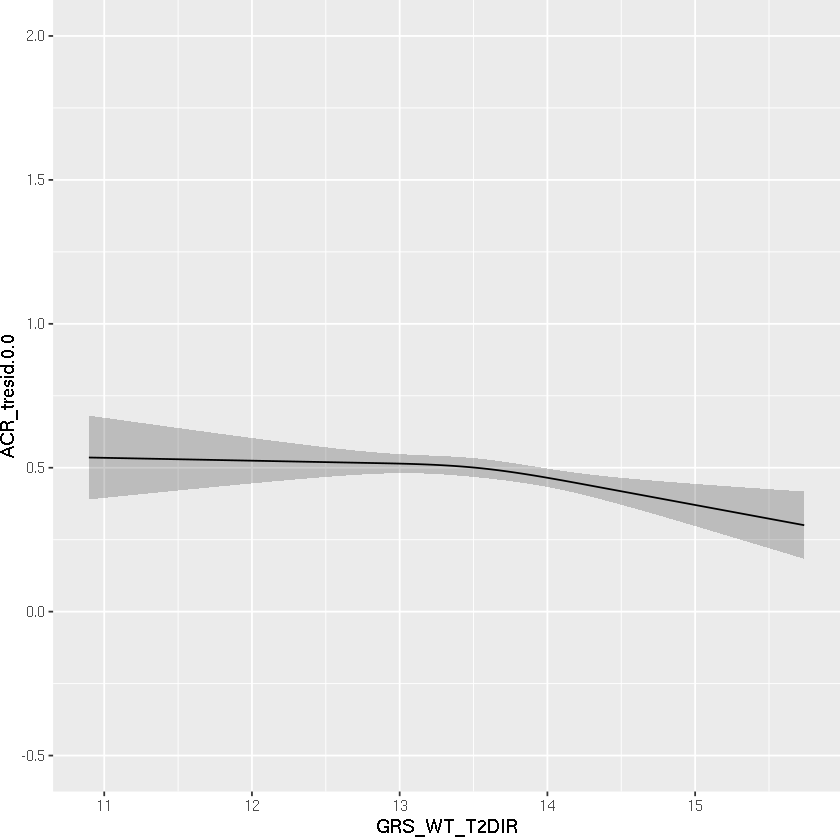

Frequencies of Missing Values Due to Each Variable
ACR_tresid.0.0   GRS_WT_T2DIR        AGE.0.0        SEX.0.0            PC1 
          9067             11              0              0              0 
           PC2            PC3            PC4            PC5            PC6 
             0              0              0              0              0 
           PC7            PC8            PC9           PC10 
             0              0              0              0 

Linear Regression Model
 
 ols(formula = ACR_tresid.0.0 ~ rcs(GRS_WT_T2DIR, 3) + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10, data = ND)
 
 
                  Model Likelihood      Discrimination    
                     Ratio Test            Indexes        
 Obs  343121    LR chi2    156924.84    R2       0.367    
 sigma0.7786    d.f.              14    R2 adj   0.367    
 d.f. 343106    Pr(> chi2)    0.0000    g        0.679    
 
 Residuals
 
      Min       1Q   Med

(Intercept) GRS_WT_T2DIR      AGE.0.0  SEX.0.0Male          PC1          PC2 
0.000000e+00 2.603596e-02 0.000000e+00 0.000000e+00 5.479424e-01 5.595108e-01 
         PC3          PC4          PC5          PC6          PC7          PC8 
3.263069e-01 8.776738e-04 3.060171e-02 1.974644e-04 8.524400e-10 6.810922e-01 
         PC9         PC10 
1.185375e-01 9.380179e-01

Frequencies of Missing Values Due to Each Variable
ACR_tresid.0.0   GRS_WT_T2DIR        AGE.0.0        SEX.0.0            PC1 
          9067             11              0              0              0 
           PC2            PC3            PC4            PC5            PC6 
             0              0              0              0              0 
           PC7            PC8            PC9           PC10 
             0              0              0              0 

Linear Regression Model
 
 ols(formula = ACR_tresid.0.0 ~ GRS_WT_T2DIR + AGE.0.0 + SEX.0.0 + 
     PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10, 
     data = ND)
 
 
                  Model Likelihood      Discrimination    
                     Ratio Test            Indexes        
 Obs  343121    LR chi2    156919.24    R2       0.367    
 sigma0.7786    d.f.              13    R2 adj   0.367    
 d.f. 343107    Pr(> chi2)    0.0000    g        0.679    
 
 Residuals
 
      Min       1Q   Median     

2.5 %         97.5 %      
Intercept     3.6174316062  3.742574892
GRS_WT_T2DIR  0.0006069044  0.009560262
AGE.0.0      -0.0609905973 -0.060340069
SEX.0.0=Male -0.6684894069 -0.658009931
PC1          -0.1056946954  0.199146521
PC2          -0.1296866243  0.239656071
PC3          -0.4025321424  0.133886213
PC4           0.2089331645  0.808007610
PC5           0.0341339792  0.695701569
PC6           0.3223648666  1.039408441
PC7           0.8376702746  1.624157567
PC8          -0.5011828316  0.327435313
PC9          -0.0846882177  0.747271537
PC10         -0.4049851453  0.438448159

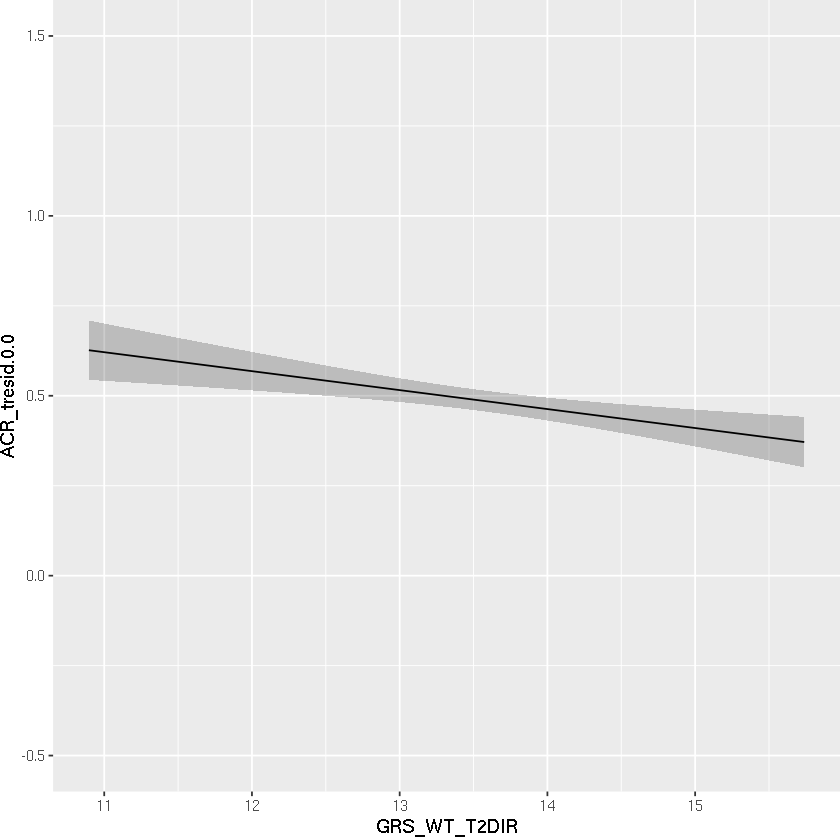

Frequencies of Missing Values Due to Each Variable
ACR_tresid.0.0   GRS_WT_T2DIR        AGE.0.0        SEX.0.0            PC1 
          9802             12              0              0              0 
           PC2            PC3            PC4            PC5            PC6 
             0              0              0              0              0 
           PC7            PC8            PC9           PC10 
             0              0              0              0 

Linear Regression Model
 
 ols(formula = ACR_tresid.0.0 ~ rcs(GRS_WT_T2DIR, 3) + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10, data = UKBB_AG2)
 
 
                  Model Likelihood      Discrimination    
                     Ratio Test            Indexes        
 Obs  363673    LR chi2    145282.47    R2       0.329    
 sigma0.8189    d.f.              14    R2 adj   0.329    
 d.f. 363658    Pr(> chi2)    0.0000    g        0.657    
 
 Residuals
 
      Min       1Q

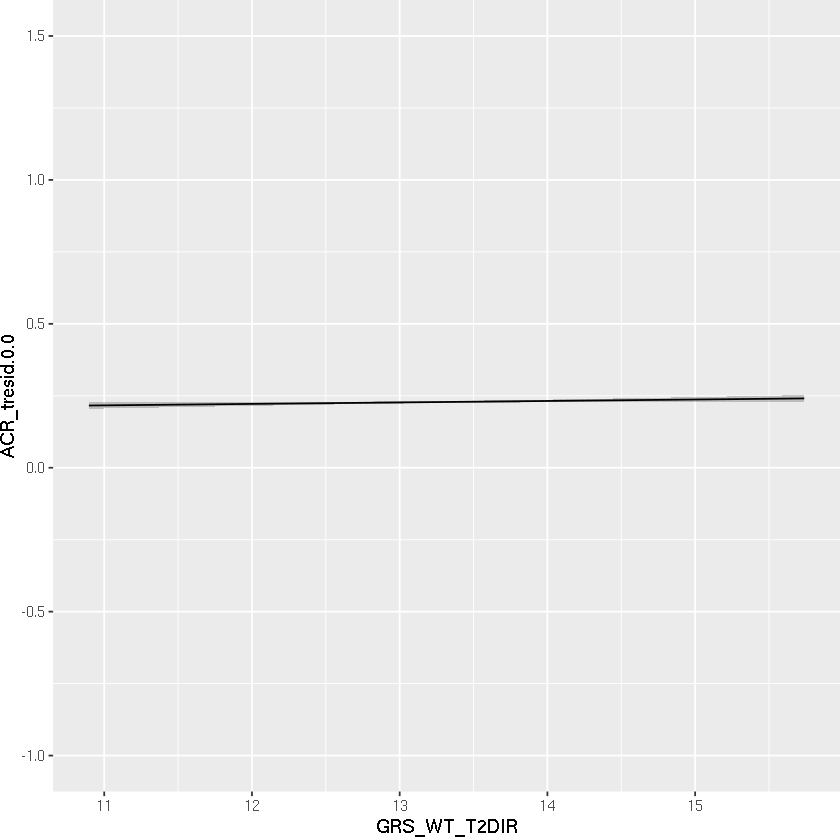

(Intercept) GRS_WT_T2DIR      AGE.0.0  SEX.0.0Male          PC1          PC2 
0.000000e+00 2.687750e-19 0.000000e+00 0.000000e+00 9.106957e-01 1.913049e-01 
         PC3          PC4          PC5          PC6          PC7          PC8 
1.262009e-01 6.085903e-04 2.019011e-01 1.288611e-05 1.128839e-08 6.939402e-01 
         PC9         PC10 
8.891854e-02 8.409926e-01

Frequencies of Missing Values Due to Each Variable
ACR_tresid.0.0   GRS_WT_T2DIR        AGE.0.0        SEX.0.0            PC1 
          9802             12              0              0              0 
           PC2            PC3            PC4            PC5            PC6 
             0              0              0              0              0 
           PC7            PC8            PC9           PC10 
             0              0              0              0 

Linear Regression Model
 
 ols(formula = ACR_tresid.0.0 ~ GRS_WT_T2DIR + AGE.0.0 + SEX.0.0 + 
     PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10, 
     data = UKBB_AG2)
 
 
                  Model Likelihood      Discrimination    
                     Ratio Test            Indexes        
 Obs  363673    LR chi2    145274.79    R2       0.329    
 sigma0.8189    d.f.              13    R2 adj   0.329    
 d.f. 363659    Pr(> chi2)    0.0000    g        0.657    
 
 Residuals
 
     Min      1Q  Median  

2.5 %       97.5 %     
Intercept     3.31749836  3.44444453
GRS_WT_T2DIR  0.01629347  0.02538994
AGE.0.0      -0.05923344 -0.05856717
SEX.0.0=Male -0.63619928 -0.62551276
PC1          -0.16457185  0.14675583
PC2          -0.06284696  0.31428334
PC3          -0.49004931  0.06049172
PC4           0.22923501  0.84142857
PC5          -0.11791098  0.55800949
PC6           0.44905784  1.18186073
PC7           0.76927348  1.57334416
PC8          -0.50849396  0.33844872
PC9          -0.05615116  0.79423075
PC10         -0.38702357  0.47529073

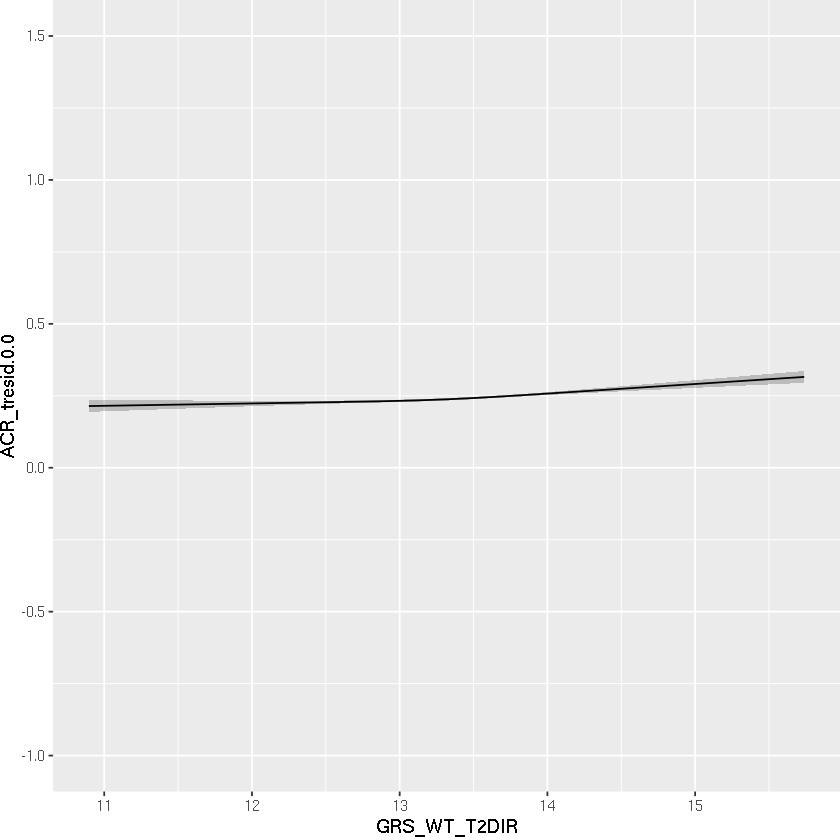

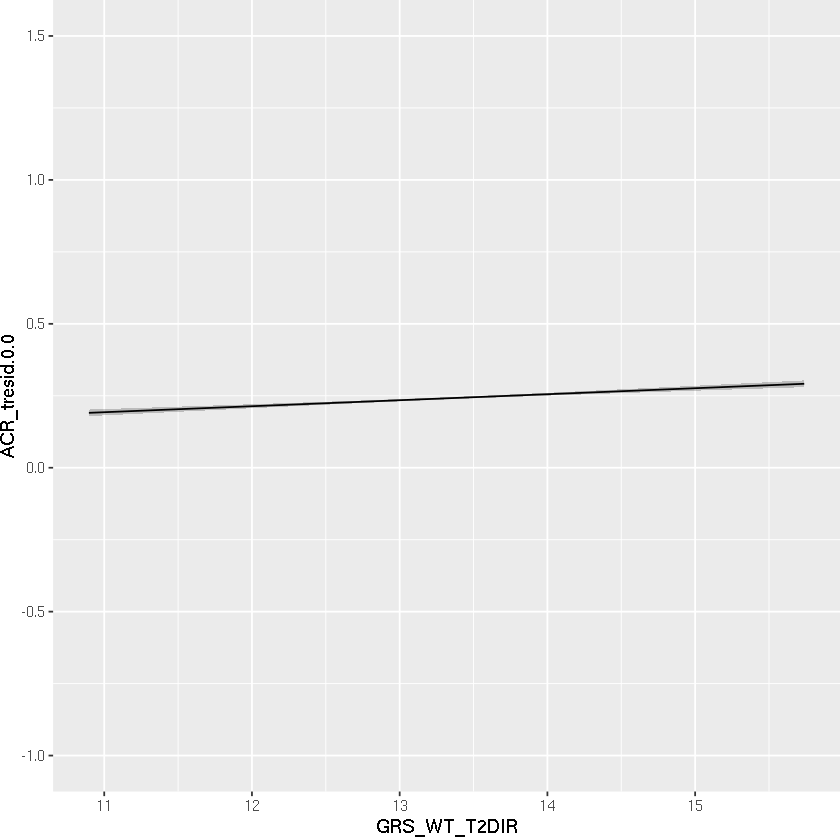

In [110]:
#############################ACR_tresid (T2D Scores)#################################
#T2D, ACR_tresid
ddist <- datadist(UKBB_AG2[,c('AGE.0.0','GRS_WT_T2DIR','SEX.0.0','PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10')])
options (datadist ="ddist")


M1 <- ols(ACR_tresid.0.0 ~ rcs(GRS_WT_T2DIR,3) + AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10, data=T2D) 
M1
ggplot(Predict(M1))[1,2]
confint(M1)
M1 <- ols(ACR_tresid.0.0 ~ GRS_WT_T2DIR + AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10, data=T2D) 
M1
confint(M1)
ggplot(Predict(M1))[1,2]
#linear term not significant

#ND, ACR_tresid
M1 <- ols(ACR_tresid.0.0 ~ rcs(GRS_WT_T2DIR,3) + AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10, data=ND) 
M1
ddist <- datadist(UKBB_AG2[,c('AGE.0.0','GRS_WT_T2DIR','SEX.0.0','PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10')])
options (datadist ="ddist")
#3rd knot significant
M1 <- lm(ACR_tresid.0.0 ~ GRS_WT_T2DIR + AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10,
          data=ND) 
summary(M1)$coefficients[,4]
M1 <- ols(ACR_tresid.0.0 ~ GRS_WT_T2DIR + AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10,
          data=ND) 
M1
confint(M1)
ggplot(Predict(M1))[1,2]
#3rd knot not significant, modeled as linear
#GRS_IR was not significant 

#Overall, ACR_tresid
M1 <- ols(ACR_tresid.0.0 ~ rcs(GRS_WT_T2DIR,3) + AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10, data=UKBB_AG2) 
M1
ddist <- datadist(UKBB_AG2[,c('AGE.0.0','GRS_WT_T2DIR','SEX.0.0','PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10')])
options (datadist ="ddist")
ggplot(Predict(M1))[1,2]
M1 <- lm(ACR_tresid.0.0 ~ GRS_WT_T2DIR + AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10,
          data=UKBB_AG2) 
summary(M1)$coefficients[,4]
M1 <- ols(ACR_tresid.0.0 ~ GRS_WT_T2DIR + AGE.0.0 + SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10,
          data=UKBB_AG2) 
M1
confint(M1)
ggplot(Predict(M1))[1,2]
#3rd knot tested and not close to significant
#categorical variable not significant

In [155]:
ddist <- datadist(UKBB_AG2[,c('AGE.0.0','GRS_WT_T2DIR',"GRS_WT_IR",'SEX.0.0','PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10')])
options (datadist ="ddist")
#Output dataframe for paper

####OVERALL####
#R1: ACR, total, IRPRS
m1 <- lm(ACR_tresid.0.0 ~ GRS_WT_IR + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10,data=UKBB_AG2)
m1
summary(m1)
anova(m1)

#summary coef
  coef <- round(coef(m1)["GRS_WT_IR"],4) #coef
  se <- round(coef(summary(m1))["GRS_WT_IR", "Std. Error"],4) #se 
  combo_coef <- paste0(coef," (",se,")")  
  lrt_total <- anova(m1)[1,5] #pvalue
  df_coef <- data.frame(exp="IR-PRS",out="ACR tresid",beta=combo_coef,pvalue=lrt_total)

#R2: EGFR, total, IRPRS
m1 <- lm(EGFR_tresid.0.0 ~ GRS_WT_IR + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10,data=UKBB_AG2)
m1
summary(m1)
anova(m1)

#summary coef
   coef <- round(coef(m1)["GRS_WT_IR"],4) #coef
  se <- round(coef(summary(m1))["GRS_WT_IR", "Std. Error"],4) #se 
  combo_coef <- paste0(coef," (",se,")")  
  lrt_total <- anova(m1)[1,5] #pvalue
  df_coef2 <- data.frame(exp="IR-PRS",out="eGFR tresid",beta=combo_coef,pvalue=lrt_total)
#join dataframes
df_coef <- rbind(df_coef,df_coef2)

####OVERALL####
#R1: ACR, total, IRPRS
m1 <- lm(ACR_tresid.0.0 ~ GRS_WT_T2DIR + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10,data=UKBB_AG2)
m1
summary(m1)
anova(m1)

#summary coef
  coef <- round(coef(m1)["GRS_WT_T2DIR"],4) #coef
  se <- round(coef(summary(m1))["GRS_WT_T2DIR", "Std. Error"],4) #se 
  combo_coef <- paste0(coef," (",se,")")  
  lrt_total <- anova(m1)[1,5] #pvalue
  df_coef3 <- data.frame(exp="GRS_WT_T2DIR",out="ACR tresid",beta=combo_coef,pvalue=lrt_total)
df_coef <- rbind(df_coef,df_coef3)

#R2: EGFR, total, IRPRS
m1 <- lm(EGFR_tresid.0.0 ~ GRS_WT_T2DIR + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10,data=UKBB_AG2)
m1
summary(m1)
anova(m1)

#summary coef
   coef <- round(coef(m1)["GRS_WT_T2DIR"],4) #coef
  se <- round(coef(summary(m1))["GRS_WT_T2DIR", "Std. Error"],4) #se 
  combo_coef <- paste0(coef," (",se,")")  
  lrt_total <- anova(m1)[1,5] #pvalue
  df_coef4 <- data.frame(exp="GRS_WT_T2DIR",out="eGFR tresid",beta=combo_coef,pvalue=lrt_total)
#join dataframes
df_coef <- rbind(df_coef,df_coef4)
#reuse naming convention, rename df
overall_coef <- df_coef 


Call:
lm(formula = ACR_tresid.0.0 ~ GRS_WT_IR + AGE.0.0 + SEX.0.0 + 
    PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10, 
    data = UKBB_AG2)

Coefficients:
(Intercept)    GRS_WT_IR      AGE.0.0  SEX.0.0Male          PC1          PC2  
    3.58368      0.32386     -0.05890     -0.63081      0.01944      0.13499  
        PC3          PC4          PC5          PC6          PC7          PC8  
   -0.19057      0.52789      0.23469      0.85969      1.18196     -0.09476  
        PC9         PC10  
    0.37488      0.05137  



Call:
lm(formula = ACR_tresid.0.0 ~ GRS_WT_IR + AGE.0.0 + SEX.0.0 + 
    PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10, 
    data = UKBB_AG2)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.6008 -0.3536 -0.1449  0.0405  5.5010 

Coefficients:
             Estimate Std. Error  t value Pr(>|t|)    
(Intercept)  3.583683   0.012774  280.547  < 2e-16 ***
GRS_WT_IR    0.323858   0.035369    9.156  < 2e-16 ***
AGE.0.0     -0.058900   0.000170 -346.544  < 2e-16 ***
SEX.0.0Male -0.630809   0.002726 -231.394  < 2e-16 ***
PC1          0.019444   0.079332    0.245 0.806383    
PC2          0.134995   0.096198    1.403 0.160528    
PC3         -0.190568   0.140433   -1.357 0.174780    
PC4          0.527890   0.156175    3.380 0.000725 ***
PC5          0.234694   0.172415    1.361 0.173446    
PC6          0.859695   0.186957    4.598 4.26e-06 ***
PC7          1.181959   0.205117    5.762 8.30e-09 ***
PC8         -0.094757   0.216050   -0.439 0.660959    
PC9          0.37487

Df     Sum Sq       Mean Sq      F value      Pr(>F)      
GRS_WT_IR      1 6.095108e+01 6.095108e+01 9.090164e+01 1.518733e-21
AGE.0.0        1 8.371421e+04 8.371421e+04 1.248503e+05 0.000000e+00
SEX.0.0        1 3.591476e+04 3.591476e+04 5.356280e+04 0.000000e+00
PC1            1 4.633786e-02 4.633786e-02 6.910767e-02 7.926406e-01
PC2            1 1.307046e+00 1.307046e+00 1.949311e+00 1.626619e-01
PC3            1 1.196146e+00 1.196146e+00 1.783916e+00 1.816700e-01
PC4            1 7.636780e+00 7.636780e+00 1.138939e+01 7.387240e-04
PC5            1 1.201581e+00 1.201581e+00 1.792023e+00 1.806807e-01
PC6            1 1.420010e+01 1.420010e+01 2.117784e+01 4.187169e-06
PC7            1 2.226791e+01 2.226791e+01 3.321006e+01 8.278780e-09
PC8            1 1.298310e-01 1.298310e-01 1.936283e-01 6.599141e-01
PC9            1 2.002363e+00 2.002363e+00 2.986298e+00 8.397281e-02
PC10           1 3.657037e-02 3.657037e-02 5.454057e-02 8.153428e-01
Residuals 363671 2.438475e+05 6.705168e-01           NA           NA


Call:
lm(formula = EGFR_tresid.0.0 ~ GRS_WT_IR + AGE.0.0 + SEX.0.0 + 
    PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10, 
    data = UKBB_AG2)

Coefficients:
(Intercept)    GRS_WT_IR      AGE.0.0  SEX.0.0Male          PC1          PC2  
  -0.087001    -0.063722     0.001989    -0.026482    -1.246097     2.474841  
        PC3          PC4          PC5          PC6          PC7          PC8  
  -0.352214     0.252737     1.675022     1.731779     0.088794     0.538474  
        PC9         PC10  
   0.281886     0.499162  



Call:
lm(formula = EGFR_tresid.0.0 ~ GRS_WT_IR + AGE.0.0 + SEX.0.0 + 
    PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10, 
    data = UKBB_AG2)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.7123 -0.6741  0.0065  0.6721  4.6810 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.0870009  0.0157246  -5.533 3.15e-08 ***
GRS_WT_IR   -0.0637221  0.0435611  -1.463   0.1435    
AGE.0.0      0.0019886  0.0002092   9.507  < 2e-16 ***
SEX.0.0Male -0.0264821  0.0033581  -7.886 3.13e-15 ***
PC1         -1.2460965  0.0974448 -12.788  < 2e-16 ***
PC2          2.4748412  0.1182947  20.921  < 2e-16 ***
PC3         -0.3522143  0.1721850  -2.046   0.0408 *  
PC4          0.2527371  0.1918426   1.317   0.1877    
PC5          1.6750216  0.2122470   7.892 2.99e-15 ***
PC6          1.7317793  0.2300857   7.527 5.22e-14 ***
PC7          0.0887943  0.2524532   0.352   0.7250    
PC8          0.5384741  0.2659779   2.025   0.0429 *  
PC9          0.2818

Df     Sum Sq       Mean Sq     F value     Pr(>F)      
GRS_WT_IR      1 2.663836e+00   2.6638363   2.6701896 1.022447e-01
AGE.0.0        1 6.115936e+01  61.1593635  61.3052315 4.901105e-15
SEX.0.0        1 6.282538e+01  62.8253833  62.9752248 2.099239e-15
PC1            1 1.663435e+02 166.3434559 166.7401929 3.888127e-38
PC2            1 4.357494e+02 435.7494033 436.7886862 6.189273e-97
PC3            1 4.098804e+00   4.0988042   4.1085801 4.266691e-02
PC4            1 1.691100e+00   1.6911001   1.6951335 1.929265e-01
PC5            1 6.171919e+01  61.7191900  61.8663932 3.685884e-15
PC6            1 5.653759e+01  56.5375891  56.6724339 5.160023e-14
PC7            1 1.229553e-01   0.1229553   0.1232485 7.255378e-01
PC8            1 4.084165e+00   4.0841652   4.0939061 4.303882e-02
PC9            1 1.113202e+00   1.1132025   1.1158575 2.908129e-01
PC10           1 3.387602e+00   3.3876016   3.3956812 6.536819e-02
Residuals 356747 3.558982e+05   0.9976206          NA           NA


Call:
lm(formula = ACR_tresid.0.0 ~ GRS_WT_T2DIR + AGE.0.0 + SEX.0.0 + 
    PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10, 
    data = UKBB_AG2)

Coefficients:
 (Intercept)  GRS_WT_T2DIR       AGE.0.0   SEX.0.0Male           PC1  
    3.380971      0.020842     -0.058900     -0.630856     -0.008908  
         PC2           PC3           PC4           PC5           PC6  
    0.125718     -0.214779      0.535332      0.220049      0.815459  
         PC7           PC8           PC9          PC10  
    1.171309     -0.085023      0.369040      0.044134  



Call:
lm(formula = ACR_tresid.0.0 ~ GRS_WT_T2DIR + AGE.0.0 + SEX.0.0 + 
    PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10, 
    data = UKBB_AG2)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.5901 -0.3538 -0.1448  0.0405  5.4923 

Coefficients:
              Estimate Std. Error  t value Pr(>|t|)    
(Intercept)   3.380971   0.032385  104.400  < 2e-16 ***
GRS_WT_T2DIR  0.020842   0.002321    8.981  < 2e-16 ***
AGE.0.0      -0.058900   0.000170 -346.536  < 2e-16 ***
SEX.0.0Male  -0.630856   0.002726 -231.405  < 2e-16 ***
PC1          -0.008908   0.079422   -0.112 0.910696    
PC2           0.125718   0.096208    1.307 0.191305    
PC3          -0.214779   0.140446   -1.529 0.126201    
PC4           0.535332   0.156174    3.428 0.000609 ***
PC5           0.220049   0.172431    1.276 0.201901    
PC6           0.815459   0.186942    4.362 1.29e-05 ***
PC7           1.171309   0.205123    5.710 1.13e-08 ***
PC8          -0.085023   0.216060   -0.394 0.693940    
PC9 

Df     Sum Sq       Mean Sq      F value      Pr(>F)      
GRS_WT_T2DIR      1 5.784675e+01 5.784675e+01 8.626973e+01 1.578167e-20
AGE.0.0           1 8.370894e+04 8.370894e+04 1.248393e+05 0.000000e+00
SEX.0.0           1 3.591977e+04 3.591977e+04 5.356894e+04 0.000000e+00
PC1               1 6.565951e-03 6.565951e-03 9.792129e-03 9.211739e-01
PC2               1 1.130455e+00 1.130455e+00 1.685904e+00 1.941426e-01
PC3               1 1.527332e+00 1.527332e+00 2.277787e+00 1.312399e-01
PC4               1 7.851298e+00 7.851298e+00 1.170903e+01 6.220433e-04
PC5               1 1.054616e+00 1.054616e+00 1.572802e+00 2.098014e-01
PC6               1 1.278143e+01 1.278143e+01 1.906158e+01 1.266025e-05
PC7               1 2.186799e+01 2.186799e+01 3.261283e+01 1.125574e-08
PC8               1 1.046323e-01 1.046323e-01 1.560433e-01 6.928260e-01
PC9               1 1.940519e+00 1.940519e+00 2.893993e+00 8.891116e-02
PC10              1 2.698899e-02 2.698899e-02 4.025002e-02 8.409926e-01
Residuals    363659 2.438455e+05 6.705335e-01           NA           NA


Call:
lm(formula = EGFR_tresid.0.0 ~ GRS_WT_T2DIR + AGE.0.0 + SEX.0.0 + 
    PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10, 
    data = UKBB_AG2)

Coefficients:
 (Intercept)  GRS_WT_T2DIR       AGE.0.0   SEX.0.0Male           PC1  
   -0.390300      0.021715      0.001988     -0.026458     -1.282270  
         PC2           PC3           PC4           PC5           PC6  
    2.468167     -0.367861      0.244887      1.658470      1.726252  
         PC7           PC8           PC9          PC10  
    0.080801      0.538133      0.295040      0.501951  



Call:
lm(formula = EGFR_tresid.0.0 ~ GRS_WT_T2DIR + AGE.0.0 + SEX.0.0 + 
    PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10, 
    data = UKBB_AG2)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.7200 -0.6742  0.0061  0.6713  4.6967 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -0.3902997  0.0398644  -9.791  < 2e-16 ***
GRS_WT_T2DIR  0.0217147  0.0028562   7.603 2.91e-14 ***
AGE.0.0       0.0019882  0.0002091   9.507  < 2e-16 ***
SEX.0.0Male  -0.0264584  0.0033579  -7.879 3.30e-15 ***
PC1          -1.2822700  0.0975445 -13.145  < 2e-16 ***
PC2           2.4681674  0.1182941  20.865  < 2e-16 ***
PC3          -0.3678614  0.1721841  -2.136   0.0326 *  
PC4           0.2448872  0.1918205   1.277   0.2017    
PC5           1.6584700  0.2122460   7.814 5.56e-15 ***
PC6           1.7262523  0.2300413   7.504 6.20e-14 ***
PC7           0.0808006  0.2524356   0.320   0.7489    
PC8           0.5381330  0.2659631   2.023   0.0430 *  
PC9

Df     Sum Sq       Mean Sq     F value     Pr(>F)      
GRS_WT_T2DIR      1 5.341732e+01  53.4173151  53.5543895 2.520566e-13
AGE.0.0           1 6.119398e+01  61.1939761  61.3510064 4.788492e-15
SEX.0.0           1 6.269170e+01  62.6917028  62.8525763 2.234091e-15
PC1               1 1.761058e+02 176.1057741 176.5576802 2.796722e-40
PC2               1 4.332490e+02 433.2489777 434.3607404 2.086525e-96
PC3               1 4.481281e+00   4.4812807   4.4927802 3.403897e-02
PC4               1 1.582630e+00   1.5826299   1.5866911 2.078003e-01
PC5               1 6.047556e+01  60.4755638  60.6307505 6.903345e-15
PC6               1 5.619190e+01  56.1918967  56.3360911 6.122464e-14
PC7               1 1.017442e-01   0.1017442   0.1020053 7.494365e-01
PC8               1 4.078430e+00   4.0784300   4.0888956 4.316658e-02
PC9               1 1.219692e+00   1.2196918   1.2228217 2.688084e-01
PC10              1 3.425530e+00   3.4255295   3.4343198 6.385570e-02
Residuals    356736 3.558229e+05   0.9974405          NA           NA

In [156]:
#Output dataframe for paper

####T2D####
#R1: ACR, total, IRPRS
m1 <- lm(ACR_tresid.0.0 ~ GRS_WT_IR + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10,data=T2D)
m1
summary(m1)
anova(m1)

#summary coef
  coef <- round(coef(m1)["GRS_WT_IR"],4) #coef
  se <- round(coef(summary(m1))["GRS_WT_IR", "Std. Error"],4) #se 
  combo_coef <- paste0(coef," (",se,")")  
  lrt_total <- anova(m1)[1,5] #pvalue
  df_coef <- data.frame(exp="IR-PRS",out="ACR tresid",beta=combo_coef,pvalue=lrt_total)

#R2: EGFR, total, IRPRS
m1 <- lm(EGFR_tresid.0.0 ~ GRS_WT_IR + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10,data=T2D)
m1
summary(m1)
anova(m1)

#summary coef
   coef <- round(coef(m1)["GRS_WT_IR"],4) #coef
  se <- round(coef(summary(m1))["GRS_WT_IR", "Std. Error"],4) #se 
  combo_coef <- paste0(coef," (",se,")")  
  lrt_total <- anova(m1)[1,5] #pvalue
  df_coef2 <- data.frame(exp="IR-PRS",out="eGFR tresid",beta=combo_coef,pvalue=lrt_total)
#join dataframes
df_coef <- rbind(df_coef,df_coef2)

####OVERALL####
#R1: ACR, total, IRPRS
m1 <- lm(ACR_tresid.0.0 ~ GRS_WT_T2DIR + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10,data=T2D)
m1
summary(m1)
anova(m1)

#summary coef
  coef <- round(coef(m1)["GRS_WT_T2DIR"],4) #coef
  se <- round(coef(summary(m1))["GRS_WT_T2DIR", "Std. Error"],4) #se 
  combo_coef <- paste0(coef," (",se,")")  
  lrt_total <- anova(m1)[1,5] #pvalue
  df_coef3 <- data.frame(exp="GRS_WT_T2DIR",out="ACR tresid",beta=combo_coef,pvalue=lrt_total)
df_coef <- rbind(df_coef,df_coef3)

#R2: EGFR, total, IRPRS
m1 <- lm(EGFR_tresid.0.0 ~ GRS_WT_T2DIR + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10,data=T2D)
m1
summary(m1)
anova(m1)

#summary coef
   coef <- round(coef(m1)["GRS_WT_T2DIR"],4) #coef
  se <- round(coef(summary(m1))["GRS_WT_T2DIR", "Std. Error"],4) #se 
  combo_coef <- paste0(coef," (",se,")")  
  lrt_total <- anova(m1)[1,5] #pvalue
  df_coef4 <- data.frame(exp="GRS_WT_T2DIR",out="eGFR tresid",beta=combo_coef,pvalue=lrt_total)
#join dataframes
df_coef <- rbind(df_coef,df_coef4)
#reuse naming convention, rename df
T2D_coef <- df_coef


Call:
lm(formula = ACR_tresid.0.0 ~ GRS_WT_IR + AGE.0.0 + SEX.0.0 + 
    PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10, 
    data = T2D)

Coefficients:
(Intercept)    GRS_WT_IR      AGE.0.0  SEX.0.0Male          PC1          PC2  
    3.34382      0.66846     -0.05187     -0.37678     -0.11918      0.66302  
        PC3          PC4          PC5          PC6          PC7          PC8  
   -1.85498      0.81332     -0.43900      1.54443      0.06004      0.90914  
        PC9         PC10  
    0.54024      0.29196  



Call:
lm(formula = ACR_tresid.0.0 ~ GRS_WT_IR + AGE.0.0 + SEX.0.0 + 
    PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10, 
    data = T2D)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.3809 -0.8554 -0.4405  1.0212  4.6223 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  3.343820   0.095061  35.175  < 2e-16 ***
GRS_WT_IR    0.668457   0.225769   2.961  0.00307 ** 
AGE.0.0     -0.051869   0.001279 -40.542  < 2e-16 ***
SEX.0.0Male -0.376776   0.017822 -21.141  < 2e-16 ***
PC1         -0.119184   0.502774  -0.237  0.81262    
PC2          0.663019   0.606734   1.093  0.27451    
PC3         -1.854980   0.972302  -1.908  0.05643 .  
PC4          0.813323   0.998469   0.815  0.41533    
PC5         -0.439003   1.099326  -0.399  0.68965    
PC6          1.544428   1.197101   1.290  0.19702    
PC7          0.060040   1.320535   0.045  0.96374    
PC8          0.909144   1.385273   0.656  0.51164    
PC9          0.540241   1.391767   0.3

Df    Sum Sq       Mean Sq      F value      Pr(>F)      
GRS_WT_IR     1 1.688808e+01 1.688808e+01 1.106412e+01 8.816850e-04
AGE.0.0       1 2.597524e+03 2.597524e+03 1.701752e+03 0.000000e+00
SEX.0.0       1 6.837995e+02 6.837995e+02 4.479872e+02 2.221123e-98
PC1           1 1.653107e-01 1.653107e-01 1.083023e-01 7.420886e-01
PC2           1 1.758979e+00 1.758979e+00 1.152384e+00 2.830632e-01
PC3           1 5.337754e+00 5.337754e+00 3.496998e+00 6.149440e-02
PC4           1 9.423531e-01 9.423531e-01 6.173770e-01 4.320327e-01
PC5           1 2.641493e-01 2.641493e-01 1.730558e-01 6.774145e-01
PC6           1 2.551528e+00 2.551528e+00 1.671618e+00 1.960565e-01
PC7           1 2.527405e-03 2.527405e-03 1.655814e-03 9.675421e-01
PC8           1 6.477347e-01 6.477347e-01 4.243595e-01 5.147770e-01
PC9           1 2.301291e-01 2.301291e-01 1.507677e-01 6.978068e-01
PC10          1 6.482282e-02 6.482282e-02 4.246829e-02 8.367318e-01
Residuals 20539 3.135036e+04 1.526382e+00           NA           NA


Call:
lm(formula = EGFR_tresid.0.0 ~ GRS_WT_IR + AGE.0.0 + SEX.0.0 + 
    PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10, 
    data = T2D)

Coefficients:
(Intercept)    GRS_WT_IR      AGE.0.0  SEX.0.0Male          PC1          PC2  
    1.59070     -0.20567     -0.02293      0.05548     -1.32194      2.55062  
        PC3          PC4          PC5          PC6          PC7          PC8  
    0.33373      1.85325      2.76634      1.38393      0.28162     -0.10580  
        PC9         PC10  
   -1.20731      3.34923  



Call:
lm(formula = EGFR_tresid.0.0 ~ GRS_WT_IR + AGE.0.0 + SEX.0.0 + 
    PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10, 
    data = T2D)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.1155 -0.7743  0.0054  0.8310  3.7504 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.590702   0.092039  17.283  < 2e-16 ***
GRS_WT_IR   -0.205667   0.218914  -0.939  0.34749    
AGE.0.0     -0.022926   0.001239 -18.506  < 2e-16 ***
SEX.0.0Male  0.055484   0.017243   3.218  0.00129 ** 
PC1         -1.321939   0.488540  -2.706  0.00682 ** 
PC2          2.550617   0.587938   4.338 1.44e-05 ***
PC3          0.333729   0.945363   0.353  0.72408    
PC4          1.853248   0.963302   1.924  0.05439 .  
PC5          2.766345   1.064831   2.598  0.00939 ** 
PC6          1.383931   1.162798   1.190  0.23399    
PC7          0.281615   1.280607   0.220  0.82595    
PC8         -0.105805   1.339572  -0.079  0.93705    
PC9         -1.207307   1.350186  -0.

Df    Sum Sq       Mean Sq      F value      Pr(>F)      
GRS_WT_IR     1 1.041919e+00   1.04191855 7.354369e-01 3.911367e-01
AGE.0.0       1 4.971284e+02 497.12837208 3.508974e+02 1.218753e-77
SEX.0.0       1 1.466436e+01  14.66435614 1.035082e+01 1.296202e-03
PC1           1 1.175848e+01  11.75847746 8.299706e+00 3.969298e-03
PC2           1 2.629070e+01  26.29070431 1.855726e+01 1.656500e-05
PC3           1 2.327607e-01   0.23276075 1.642939e-01 6.852379e-01
PC4           1 5.485858e+00   5.48585770 3.872186e+00 4.910613e-02
PC5           1 9.225372e+00   9.22537248 6.511717e+00 1.072385e-02
PC6           1 2.018101e+00   2.01810133 1.424474e+00 2.326823e-01
PC7           1 6.909507e-02   0.06909507 4.877067e-02 8.252186e-01
PC8           1 1.155672e-02   0.01155672 8.157298e-03 9.280356e-01
PC9           1 1.121791e+00   1.12179114 7.918148e-01 3.735625e-01
PC10          1 8.473625e+00   8.47362487 5.981097e+00 1.446843e-02
Residuals 20318 2.878521e+04   1.41673420           NA           NA


Call:
lm(formula = ACR_tresid.0.0 ~ GRS_WT_T2DIR + AGE.0.0 + SEX.0.0 + 
    PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10, 
    data = T2D)

Coefficients:
 (Intercept)  GRS_WT_T2DIR       AGE.0.0   SEX.0.0Male           PC1  
     4.21682      -0.05269      -0.05191      -0.37728      -0.02842  
         PC2           PC3           PC4           PC5           PC6  
     0.67576      -1.80947       0.83038      -0.30940       1.51768  
         PC7           PC8           PC9          PC10  
     0.06467       1.00550       0.47634       0.25931  



Call:
lm(formula = ACR_tresid.0.0 ~ GRS_WT_T2DIR + AGE.0.0 + SEX.0.0 + 
    PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10, 
    data = T2D)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.3671 -0.8565 -0.4372  1.0258  4.5831 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)   4.216817   0.216107  19.513  < 2e-16 ***
GRS_WT_T2DIR -0.052692   0.014834  -3.552 0.000383 ***
AGE.0.0      -0.051910   0.001279 -40.576  < 2e-16 ***
SEX.0.0Male  -0.377284   0.017820 -21.172  < 2e-16 ***
PC1          -0.028415   0.503170  -0.056 0.954966    
PC2           0.675757   0.606717   1.114 0.265381    
PC3          -1.809465   0.972401  -1.861 0.062784 .  
PC4           0.830383   0.998394   0.832 0.405577    
PC5          -0.309403   1.099264  -0.281 0.778357    
PC6           1.517675   1.196858   1.268 0.204795    
PC7           0.064674   1.320437   0.049 0.960937    
PC8           1.005497   1.385214   0.726 0.467921    
PC9           0.476343

Df    Sum Sq       Mean Sq      F value      Pr(>F)      
GRS_WT_T2DIR     1 1.727709e+01 1.727709e+01 1.132069e+01 7.678856e-04
AGE.0.0          1 2.601653e+03 2.601653e+03 1.704715e+03 0.000000e+00
SEX.0.0          1 6.856927e+02 6.856927e+02 4.492953e+02 1.169553e-98
PC1              1 3.347435e-02 3.347435e-02 2.193383e-02 8.822647e-01
PC2              1 1.834694e+00 1.834694e+00 1.202170e+00 2.729013e-01
PC3              1 5.079678e+00 5.079678e+00 3.328423e+00 6.810665e-02
PC4              1 9.908628e-01 9.908628e-01 6.492558e-01 4.203882e-01
PC5              1 1.352516e-01 1.352516e-01 8.862266e-02 7.659385e-01
PC6              1 2.460539e+00 2.460539e+00 1.612251e+00 2.041901e-01
PC7              1 3.016568e-03 3.016568e-03 1.976585e-03 9.645391e-01
PC8              1 7.945976e-01 7.945976e-01 5.206544e-01 4.705709e-01
PC9              1 1.789475e-01 1.789475e-01 1.172541e-01 7.320355e-01
PC10             1 5.113153e-02 5.113153e-02 3.350358e-02 8.547686e-01
Residuals    20538 3.134410e+04 1.526152e+00           NA           NA


Call:
lm(formula = EGFR_tresid.0.0 ~ GRS_WT_T2DIR + AGE.0.0 + SEX.0.0 + 
    PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10, 
    data = T2D)

Coefficients:
 (Intercept)  GRS_WT_T2DIR       AGE.0.0   SEX.0.0Male           PC1  
     2.23340      -0.05081      -0.02297       0.05550      -1.26033  
         PC2           PC3           PC4           PC5           PC6  
     2.55385       0.41956       1.85431       2.79253       1.43528  
         PC7           PC8           PC9          PC10  
     0.32345      -0.07004      -1.21724       3.34422  



Call:
lm(formula = EGFR_tresid.0.0 ~ GRS_WT_T2DIR + AGE.0.0 + SEX.0.0 + 
    PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10, 
    data = T2D)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.1156 -0.7744  0.0046  0.8304  3.7500 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)   2.233400   0.209211  10.675  < 2e-16 ***
GRS_WT_T2DIR -0.050815   0.014335  -3.545 0.000394 ***
AGE.0.0      -0.022969   0.001239 -18.546  < 2e-16 ***
SEX.0.0Male   0.055500   0.017238   3.220 0.001286 ** 
PC1          -1.260326   0.488791  -2.578 0.009931 ** 
PC2           2.553854   0.587778   4.345  1.4e-05 ***
PC3           0.419556   0.945287   0.444 0.657163    
PC4           1.854312   0.963009   1.926 0.054176 .  
PC5           2.792526   1.064521   2.623 0.008716 ** 
PC6           1.435278   1.162323   1.235 0.216906    
PC7           0.323446   1.280217   0.253 0.800542    
PC8          -0.070042   1.339188  -0.052 0.958289    
PC9          -1.21724

Df    Sum Sq       Mean Sq      F value      Pr(>F)      
GRS_WT_T2DIR     1 1.700016e+01 1.700016e+01 1.200687e+01 5.311426e-04
AGE.0.0          1 4.987920e+02 4.987920e+02 3.522867e+02 6.145415e-78
SEX.0.0          1 1.467218e+01 1.467218e+01 1.036266e+01 1.287916e-03
PC1              1 1.073731e+01 1.073731e+01 7.583548e+00 5.895574e-03
PC2              1 2.634045e+01 2.634045e+01 1.860373e+01 1.616646e-05
PC3              1 3.465102e-01 3.465102e-01 2.447331e-01 6.208136e-01
PC4              1 5.495555e+00 5.495555e+00 3.881399e+00 4.883740e-02
PC5              1 9.399679e+00 9.399679e+00 6.638804e+00 9.985083e-03
PC6              1 2.170190e+00 2.170190e+00 1.532762e+00 2.157128e-01
PC7              1 9.099129e-02 9.099129e-02 6.426532e-02 7.998798e-01
PC8              1 5.720306e-03 5.720306e-03 4.040137e-03 9.493196e-01
PC9              1 1.140218e+00 1.140218e+00 8.053129e-01 3.695203e-01
PC10             1 8.447949e+00 8.447949e+00 5.966616e+00 1.458769e-02
Residuals    20317 2.876622e+04 1.415869e+00           NA           NA

In [157]:
#Output dataframe for paper


####OVERALL####
#R1: ACR, total, IRPRS
m1 <- lm(ACR_tresid.0.0 ~ GRS_WT_IR + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10,data=ND)
m1
summary(m1)
anova(m1)

#summary coef
  coef <- round(coef(m1)["GRS_WT_IR"],4) #coef
  se <- round(coef(summary(m1))["GRS_WT_IR", "Std. Error"],4) #se 
  combo_coef <- paste0(coef," (",se,")")  
  lrt_total <- anova(m1)[1,5] #pvalue
  df_coef <- data.frame(exp="IR-PRS",out="ACR tresid",beta=combo_coef,pvalue=lrt_total)

#R2: EGFR, total, IRPRS
m1 <- lm(EGFR_tresid.0.0 ~ GRS_WT_IR + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10,data=ND)
m1
summary(m1)
anova(m1)

#summary coef
   coef <- round(coef(m1)["GRS_WT_IR"],4) #coef
  se <- round(coef(summary(m1))["GRS_WT_IR", "Std. Error"],4) #se 
  combo_coef <- paste0(coef," (",se,")")  
  lrt_total <- anova(m1)[1,5] #pvalue
  df_coef2 <- data.frame(exp="IR-PRS",out="eGFR tresid",beta=combo_coef,pvalue=lrt_total)
#join dataframes
df_coef <- rbind(df_coef,df_coef2)

####OVERALL####
#R1: ACR, total, IRPRS
m1 <- lm(ACR_tresid.0.0 ~ GRS_WT_T2DIR + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10,data=ND)
m1
summary(m1)
anova(m1)

#summary coef
  coef <- round(coef(m1)["GRS_WT_T2DIR"],4) #coef
  se <- round(coef(summary(m1))["GRS_WT_T2DIR", "Std. Error"],4) #se 
  combo_coef <- paste0(coef," (",se,")")  
  lrt_total <- anova(m1)[1,5] #pvalue
  df_coef3 <- data.frame(exp="GRS_WT_T2DIR",out="ACR tresid",beta=combo_coef,pvalue=lrt_total)
df_coef <- rbind(df_coef,df_coef3)

#R2: EGFR, total, IRPRS
m1 <- lm(EGFR_tresid.0.0 ~ GRS_WT_T2DIR + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10,data=ND)
m1
summary(m1)
anova(m1)

#summary coef
   coef <- round(coef(m1)["GRS_WT_T2DIR"],4) #coef
  se <- round(coef(summary(m1))["GRS_WT_T2DIR", "Std. Error"],4) #se 
  combo_coef <- paste0(coef," (",se,")")  
  lrt_total <- anova(m1)[1,5] #pvalue
  df_coef4 <- data.frame(exp="GRS_WT_T2DIR",out="eGFR tresid",beta=combo_coef,pvalue=lrt_total)
#join dataframes
df_coef <- rbind(df_coef,df_coef4)
ND_coef <- df_coef

##Concatenate the final three dataframes
output_df <- cbind(overall_coef,T2D_coef)
output_df <- cbind(output_df,ND_coef)
output_df


Call:
lm(formula = ACR_tresid.0.0 ~ GRS_WT_IR + AGE.0.0 + SEX.0.0 + 
    PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10, 
    data = ND)

Coefficients:
(Intercept)    GRS_WT_IR      AGE.0.0  SEX.0.0Male          PC1          PC2  
    3.69865      0.21334     -0.06067     -0.66322      0.05155      0.05739  
        PC3          PC4          PC5          PC6          PC7          PC8  
   -0.12582      0.50099      0.36867      0.70401      1.23474     -0.09262  
        PC9         PC10  
    0.33894      0.02284  



Call:
lm(formula = ACR_tresid.0.0 ~ GRS_WT_IR + AGE.0.0 + SEX.0.0 + 
    PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10, 
    data = ND)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.5342 -0.3153 -0.1360  0.0591  5.5632 

Coefficients:
              Estimate Std. Error  t value Pr(>|t|)    
(Intercept)  3.6986537  0.0124807  296.349  < 2e-16 ***
GRS_WT_IR    0.2133399  0.0346295    6.161 7.25e-10 ***
AGE.0.0     -0.0606661  0.0001659 -365.608  < 2e-16 ***
SEX.0.0Male -0.6632248  0.0026731 -248.111  < 2e-16 ***
PC1          0.0515492  0.0776727    0.664 0.506900    
PC2          0.0573920  0.0942078    0.609 0.542388    
PC3         -0.1258208  0.1368253   -0.920 0.357797    
PC4          0.5009850  0.1528223    3.278 0.001045 ** 
PC5          0.3686724  0.1687456    2.185 0.028905 *  
PC6          0.7040107  0.1829299    3.849 0.000119 ***
PC7          1.2347415  0.2006226    6.155 7.54e-10 ***
PC8         -0.0926250  0.2113663   -0.438 0.661227    
PC9          

Df     Sum Sq       Mean Sq      F value      Pr(>F)      
GRS_WT_IR      1 4.227513e+01 4.227513e+01 6.973820e+01 6.796913e-17
AGE.0.0        1 8.322129e+04 8.322129e+04 1.372841e+05 0.000000e+00
SEX.0.0        1 3.733156e+04 3.733156e+04 6.158315e+04 0.000000e+00
PC1            1 2.998617e-01 2.998617e-01 4.946601e-01 4.818564e-01
PC2            1 2.254483e-01 2.254483e-01 3.719057e-01 5.419678e-01
PC3            1 4.975335e-01 4.975335e-01 8.207449e-01 3.649631e-01
PC4            1 6.476880e+00 6.476880e+00 1.068444e+01 1.080512e-03
PC5            1 2.864410e+00 2.864410e+00 4.725208e+00 2.972427e-02
PC6            1 8.987395e+00 8.987395e+00 1.482585e+01 1.179295e-04
PC7            1 2.297058e+01 2.297058e+01 3.789290e+01 7.481922e-10
PC8            1 1.167160e-01 1.167160e-01 1.925380e-01 6.608129e-01
PC9            1 1.546228e+00 1.546228e+00 2.550700e+00 1.102463e-01
PC10           1 6.830985e-03 6.830985e-03 1.126858e-02 9.154606e-01
Residuals 343118 2.079973e+05 6.061976e-01           NA           NA


Call:
lm(formula = EGFR_tresid.0.0 ~ GRS_WT_IR + AGE.0.0 + SEX.0.0 + 
    PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10, 
    data = ND)

Coefficients:
(Intercept)    GRS_WT_IR      AGE.0.0  SEX.0.0Male          PC1          PC2  
  -0.109804    -0.094170     0.002415    -0.038823    -1.227611     2.459921  
        PC3          PC4          PC5          PC6          PC7          PC8  
  -0.384023     0.136975     1.660681     1.729290     0.051472     0.577355  
        PC9         PC10  
   0.345998     0.307271  



Call:
lm(formula = EGFR_tresid.0.0 ~ GRS_WT_IR + AGE.0.0 + SEX.0.0 + 
    PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10, 
    data = ND)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.6848 -0.6668  0.0079  0.6631  4.7014 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.1098040  0.0159235  -6.896 5.37e-12 ***
GRS_WT_IR   -0.0941700  0.0441997  -2.131   0.0331 *  
AGE.0.0      0.0024146  0.0002116  11.409  < 2e-16 ***
SEX.0.0Male -0.0388225  0.0034129 -11.375  < 2e-16 ***
PC1         -1.2276115  0.0988488 -12.419  < 2e-16 ***
PC2          2.4599206  0.1200527  20.490  < 2e-16 ***
PC3         -0.3840235  0.1737941  -2.210   0.0271 *  
PC4          0.1369749  0.1945754   0.704   0.4815    
PC5          1.6606812  0.2152911   7.714 1.23e-14 ***
PC6          1.7292903  0.2332844   7.413 1.24e-13 ***
PC7          0.0514718  0.2558854   0.201   0.8406    
PC8          0.5773545  0.2697062   2.141   0.0323 *  
PC9          0.3459980  0

Df     Sum Sq       Mean Sq      F value      Pr(>F)      
GRS_WT_IR      1 5.211504e+00   5.21150416   5.38202870 2.034580e-02
AGE.0.0        1 9.220626e+01  92.20625729  95.22331899 1.712488e-22
SEX.0.0        1 1.267303e+02 126.73029597 130.87701153 2.668579e-30
PC1            1 1.514538e+02 151.45381527 156.40950395 7.017400e-36
PC2            1 4.060202e+02 406.02016190 419.30546287 3.940819e-93
PC3            1 4.633579e+00   4.63357904   4.78519341 2.870611e-02
PC4            1 4.572429e-01   0.45724292   0.47220427 4.919753e-01
PC5            1 5.728872e+01  57.28871743  59.16324960 1.455096e-14
PC6            1 5.320765e+01  53.20764869  54.94864506 1.240086e-13
PC7            1 3.938221e-02   0.03938221   0.04067082 8.401748e-01
PC8            1 4.435400e+00   4.43540039   4.58053020 3.233792e-02
PC9            1 1.583552e+00   1.58355221   1.63536729 2.009632e-01
PC10           1 1.212301e+00   1.21230110   1.25196855 2.631776e-01
Residuals 336415 3.257560e+05   0.96831594           NA           NA


Call:
lm(formula = ACR_tresid.0.0 ~ GRS_WT_T2DIR + AGE.0.0 + SEX.0.0 + 
    PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10, 
    data = ND)

Coefficients:
 (Intercept)  GRS_WT_T2DIR       AGE.0.0   SEX.0.0Male           PC1  
    3.680003      0.005084     -0.060665     -0.663250      0.046726  
         PC2           PC3           PC4           PC5           PC6  
    0.054985     -0.134323      0.508470      0.364918      0.680887  
         PC7           PC8           PC9          PC10  
    1.230914     -0.086874      0.331292      0.016732  



Call:
lm(formula = ACR_tresid.0.0 ~ GRS_WT_T2DIR + AGE.0.0 + SEX.0.0 + 
    PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10, 
    data = ND)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.5276 -0.3147 -0.1357  0.0597  5.5594 

Coefficients:
              Estimate Std. Error  t value Pr(>|t|)    
(Intercept)   3.680003   0.031925  115.271  < 2e-16 ***
GRS_WT_T2DIR  0.005084   0.002284    2.226 0.026036 *  
AGE.0.0      -0.060665   0.000166 -365.556  < 2e-16 ***
SEX.0.0Male  -0.663250   0.002673 -248.094  < 2e-16 ***
PC1           0.046726   0.077767    0.601 0.547942    
PC2           0.054985   0.094221    0.584 0.559511    
PC3          -0.134323   0.136843   -0.982 0.326307    
PC4           0.508470   0.152827    3.327 0.000878 ***
PC5           0.364918   0.168770    2.162 0.030602 *  
PC6           0.680887   0.182922    3.722 0.000197 ***
PC7           1.230914   0.200637    6.135 8.52e-10 ***
PC8          -0.086874   0.211385   -0.411 0.681092    
PC9       

Df     Sum Sq       Mean Sq      F value      Pr(>F)      
GRS_WT_T2DIR      1 4.984692e+01 4.984692e+01 8.221991e+01 1.223730e-19
AGE.0.0           1 8.319210e+04 8.319210e+04 1.372211e+05 0.000000e+00
SEX.0.0           1 3.733095e+04 3.733095e+04 6.157547e+04 0.000000e+00
PC1               1 2.451217e-01 2.451217e-01 4.043156e-01 5.248693e-01
PC2               1 2.060712e-01 2.060712e-01 3.399038e-01 5.598852e-01
PC3               1 5.693030e-01 5.693030e-01 9.390357e-01 3.325266e-01
PC4               1 6.669630e+00 6.669630e+00 1.100121e+01 9.106196e-04
PC5               1 2.805368e+00 2.805368e+00 4.627308e+00 3.146760e-02
PC6               1 8.409978e+00 8.409978e+00 1.387182e+01 1.957422e-04
PC7               1 2.282771e+01 2.282771e+01 3.765312e+01 8.460339e-10
PC8               1 1.027259e-01 1.027259e-01 1.694410e-01 6.806094e-01
PC9               1 1.477216e+00 1.477216e+00 2.436590e+00 1.185346e-01
PC10              1 3.665973e-03 3.665973e-03 6.046831e-03 9.380179e-01
Residuals    343107 2.080132e+05 6.062634e-01           NA           NA


Call:
lm(formula = EGFR_tresid.0.0 ~ GRS_WT_T2DIR + AGE.0.0 + SEX.0.0 + 
    PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10, 
    data = ND)

Coefficients:
 (Intercept)  GRS_WT_T2DIR       AGE.0.0   SEX.0.0Male           PC1  
   -0.366170      0.017604      0.002431     -0.038607     -1.257890  
         PC2           PC3           PC4           PC5           PC6  
    2.454842     -0.394896      0.129056      1.647747      1.730735  
         PC7           PC8           PC9          PC10  
    0.045278      0.576037      0.360162      0.310502  



Call:
lm(formula = EGFR_tresid.0.0 ~ GRS_WT_T2DIR + AGE.0.0 + SEX.0.0 + 
    PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10, 
    data = ND)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.6930 -0.6665  0.0076  0.6629  4.7153 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -0.3661699  0.0407360  -8.989  < 2e-16 ***
GRS_WT_T2DIR  0.0176043  0.0029142   6.041 1.54e-09 ***
AGE.0.0       0.0024305  0.0002116  11.484  < 2e-16 ***
SEX.0.0Male  -0.0386067  0.0034129 -11.312  < 2e-16 ***
PC1          -1.2578903  0.0989577 -12.711  < 2e-16 ***
PC2           2.4548420  0.1200557  20.448  < 2e-16 ***
PC3          -0.3948958  0.1737970  -2.272   0.0231 *  
PC4           0.1290565  0.1945582   0.663   0.5071    
PC5           1.6477467  0.2152978   7.653 1.96e-14 ***
PC6           1.7307354  0.2332443   7.420 1.17e-13 ***
PC7           0.0452784  0.2558751   0.177   0.8595    
PC8           0.5760374  0.2696997   2.136   0.0327 *  
PC9      

Df     Sum Sq       Mean Sq      F value      Pr(>F)      
GRS_WT_T2DIR      1 3.188375e+01  31.88375198  32.93101496 9.556928e-09
AGE.0.0           1 9.365660e+01  93.65660006  96.73287193 7.990597e-23
SEX.0.0           1 1.253323e+02 125.33234363 129.44904618 5.477534e-30
PC1               1 1.590236e+02 159.02359985 164.24693517 1.363412e-37
PC2               1 4.042011e+02 404.20107303 417.47757883 9.839164e-93
PC3               1 4.908037e+00   4.90803663   5.06924742 2.435460e-02
PC4               1 4.027956e-01   0.40279557   0.41602591 5.189272e-01
PC5               1 5.637368e+01  56.37368034  58.22534661 2.343577e-14
PC6               1 5.331113e+01  53.31113009  55.06220295 1.170479e-13
PC7               1 3.048272e-02   0.03048272   0.03148396 8.591651e-01
PC8               1 4.414555e+00   4.41455523   4.55955699 3.273626e-02
PC9               1 1.715985e+00   1.71598546   1.77234922 1.830925e-01
PC10              1 1.237916e+00   1.23791633   1.27857729 2.581645e-01
Residuals    336405 3.257067e+05   0.96819828           NA           NA

exp          out         beta             pvalue       exp         
1 IR-PRS       ACR tresid  0.3239 (0.0354)  1.518733e-21 IR-PRS      
2 IR-PRS       eGFR tresid -0.0637 (0.0436) 1.022447e-01 IR-PRS      
3 GRS_WT_T2DIR ACR tresid  0.0208 (0.0023)  1.578167e-20 GRS_WT_T2DIR
4 GRS_WT_T2DIR eGFR tresid 0.0217 (0.0029)  2.520566e-13 GRS_WT_T2DIR
  out         beta             pvalue       exp          out        
1 ACR tresid  0.6685 (0.2258)  0.0008816850 IR-PRS       ACR tresid 
2 eGFR tresid -0.2057 (0.2189) 0.3911366627 IR-PRS       eGFR tresid
3 ACR tresid  -0.0527 (0.0148) 0.0007678856 GRS_WT_T2DIR ACR tresid 
4 eGFR tresid -0.0508 (0.0143) 0.0005311426 GRS_WT_T2DIR eGFR tresid
  beta             pvalue      
1 0.2133 (0.0346)  6.796913e-17
2 -0.0942 (0.0442) 2.034580e-02
3 0.0051 (0.0023)  1.223730e-19
4 0.0176 (0.0029)  9.556928e-09

In [158]:
#write csv
#file name
filename <- paste0('/cellar/users/agarduno/jupyter/Analysis/','3_Multivariate-Spline4_Cont.Measures',Sys.Date(),'.txt')
write.csv(output_df,filename)

In [160]:
m1 <- lm(ACR_tresid.0.0 ~ GRS_WT_T2DIRf3 + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10,data=UKBB_AG2)
coef(m1)
#coef <- round(coef(m1)["GRS_WT_IR"],4) 
#se <- round(coef(summary(m1))["GRS_WT_IR", "Std. Error"],4) #se 

(Intercept)   GRS_WT_T2DIRf3high risk GRS_WT_T2DIRf3medium risk 
             3.6462883787              0.0254541694              0.0050262953 
                  AGE.0.0               SEX.0.0Male                       PC1 
            -0.0588985280             -0.6308982344              0.0008165908 
                      PC2                       PC3                       PC4 
             0.1280101061             -0.2101161217              0.5380972170 
                      PC5                       PC6                       PC7 
             0.2263529128              0.8194074343              1.1752188527 
                      PC8                       PC9                      PC10 
            -0.0853868172              0.3639295654              0.0414199754

In [165]:
#primary cut-points
ddist <- datadist(UKBB_AG2[,c('AGE.0.0','GRS_WT_T2DIRf3',"GRS_WT_IRf3",'SEX.0.0','PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10')])
options (datadist ="ddist")
#Output dataframe for paper

####OVERALL####
#R1: ACR, total, IRPRS
m1 <- lm(ACR_tresid.0.0 ~ GRS_WT_IRf3 + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10,data=UKBB_AG2)
summary(m1)
anova(m1)

#summary coef
  coef <- round(coef(m1)["GRS_WT_IRf3high risk"],4) #coef
  se <- round(coef(summary(m1))["GRS_WT_IRf3high risk", "Std. Error"],4) #se 
  combo_coef <- paste0(coef," (",se,")")  

  coef2 <- round(coef(m1)["GRS_WT_IRf3medium risk"],4) #coef
  se2 <- round(coef(summary(m1))["GRS_WT_IRf3medium risk", "Std. Error"],4) #se 
  combo_coef2 <- paste0(coef2," (",se2,")")  

  lrt_total <- anova(m1)[1,5] #pvalue
  df_coef <- data.frame(exp="IR-PRSf3",out="ACR tresid",int=combo_coef,high=combo_coef2,pvalue=lrt_total)

#R2: EGFR, total, IRPRS
m1 <- lm(EGFR_tresid.0.0 ~ GRS_WT_IRf3 + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10,data=UKBB_AG2)
summary(m1)
anova(m1)

#summary coef
 coef <- round(coef(m1)["GRS_WT_IRf3high risk"],4) #coef
  se <- round(coef(summary(m1))["GRS_WT_IRf3high risk", "Std. Error"],4) #se 
  combo_coef <- paste0(coef," (",se,")")  

  coef2 <- round(coef(m1)["GRS_WT_IRf3medium risk"],4) #coef
  se2 <- round(coef(summary(m1))["GRS_WT_IRf3medium risk", "Std. Error"],4) #se 
  combo_coef2 <- paste0(coef2," (",se2,")")  

df_coef2 <- data.frame(exp="IR-PRSf3",out="EGFR tresid",int=combo_coef,high=combo_coef2,pvalue=lrt_total)
#join dataframes
df_coef <- rbind(df_coef,df_coef2)

#R3: ACR, total, UKBB_AG2PRS
m1 <- lm(ACR_tresid.0.0 ~ GRS_WT_T2DIRf3 + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10,data=UKBB_AG2)
summary(m1)
anova(m1)

#summary coef
 coef <- round(coef(m1)["GRS_WT_T2DIRf3high risk"],4) #coef
  se <- round(coef(summary(m1))["GRS_WT_T2DIRf3high risk", "Std. Error"],4) #se 
  combo_coef <- paste0(coef," (",se,")")  

  coef2 <- round(coef(m1)["GRS_WT_T2DIRf3medium risk"],4) #coef
  se2 <- round(coef(summary(m1))["GRS_WT_T2DIRf3medium risk", "Std. Error"],4) #se 
  combo_coef2 <- paste0(coef2," (",se2,")")  
  lrt_total <- anova(m1)[1,5] #pvalue

df_coef3 <- data.frame(exp="T2D-PRSf3",out="ACR tresid",int=combo_coef,high=combo_coef2,pvalue=lrt_total)
df_coef <- rbind(df_coef,df_coef3)

#R4: EGFR, total, UKBB_AG2PRS
m1 <- lm(EGFR_tresid.0.0 ~ GRS_WT_T2DIRf3 + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10,data=UKBB_AG2)
summary(m1)
anova(m1)

#summary coef
 coef <- round(coef(m1)["GRS_WT_T2DIRf3high risk"],4) #coef
  se <- round(coef(summary(m1))["GRS_WT_T2DIRf3high risk", "Std. Error"],4) #se 
  combo_coef <- paste0(coef," (",se,")")  

  coef2 <- round(coef(m1)["GRS_WT_T2DIRf3medium risk"],4) #coef
  se2 <- round(coef(summary(m1))["GRS_WT_T2DIRf3medium risk", "Std. Error"],4) #se 
  combo_coef2 <- paste0(coef2," (",se2,")")  
  lrt_total <- anova(m1)[1,5] #pvalue

df_coef4 <- data.frame(exp="T2D-PRSf3",out="EGFR tresid",int=combo_coef,high=combo_coef2,pvalue=lrt_total)
df_coef <- rbind(df_coef,df_coef4)
#reuse naming convention, rename df
overall_coef <- df_coef 


Call:
lm(formula = ACR_tresid.0.0 ~ GRS_WT_IRf3 + AGE.0.0 + SEX.0.0 + 
    PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10, 
    data = UKBB_AG2)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.6025 -0.3537 -0.1447  0.0405  5.5001 

Coefficients:
                        Estimate Std. Error  t value Pr(>|t|)    
(Intercept)             3.633124   0.010666  340.616  < 2e-16 ***
GRS_WT_IRf3high risk    0.036645   0.004867    7.530 5.10e-14 ***
GRS_WT_IRf3medium risk  0.022047   0.004665    4.726 2.29e-06 ***
AGE.0.0                -0.058901   0.000170 -346.540  < 2e-16 ***
SEX.0.0Male            -0.630836   0.002726 -231.397  < 2e-16 ***
PC1                     0.020503   0.079335    0.258 0.796073    
PC2                     0.134798   0.096201    1.401 0.161152    
PC3                    -0.190728   0.140438   -1.358 0.174434    
PC4                     0.529355   0.156180    3.389 0.000701 ***
PC5                     0.235992   0.172420    1.369 0.171093    
PC6    

Df     Sum Sq       Mean Sq      F value      Pr(>F)      
GRS_WT_IRf3      2 4.070887e+01 2.035444e+01 3.035445e+01 6.581564e-14
AGE.0.0          1 8.371700e+04 8.371700e+04 1.248467e+05 0.000000e+00
SEX.0.0          1 3.591813e+04 3.591813e+04 5.356449e+04 0.000000e+00
PC1              1 5.105023e-02 5.105023e-02 7.613092e-02 7.826110e-01
PC2              1 1.303225e+00 1.303225e+00 1.943492e+00 1.632908e-01
PC3              1 1.198122e+00 1.198122e+00 1.786752e+00 1.813232e-01
PC4              1 7.678774e+00 7.678774e+00 1.145131e+01 7.145107e-04
PC5              1 1.215372e+00 1.215372e+00 1.812477e+00 1.782123e-01
PC6              1 1.394554e+01 1.394554e+01 2.079691e+01 5.108193e-06
PC7              1 2.214111e+01 2.214111e+01 3.301890e+01 9.133969e-09
PC8              1 1.255485e-01 1.255485e-01 1.872298e-01 6.652326e-01
PC9              1 1.952037e+00 1.952037e+00 2.911062e+00 8.797477e-02
PC10             1 3.427467e-02 3.427467e-02 5.111362e-02 8.211368e-01
Residuals   363670 2.438620e+05 6.705585e-01           NA           NA


Call:
lm(formula = EGFR_tresid.0.0 ~ GRS_WT_IRf3 + AGE.0.0 + SEX.0.0 + 
    PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10, 
    data = UKBB_AG2)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.7118 -0.6741  0.0063  0.6721  4.6809 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)            -0.1032963  0.0131248  -7.870 3.55e-15 ***
GRS_WT_IRf3high risk   -0.0016384  0.0059894  -0.274   0.7844    
GRS_WT_IRf3medium risk  0.0041338  0.0057416   0.720   0.4715    
AGE.0.0                 0.0019882  0.0002092   9.506  < 2e-16 ***
SEX.0.0Male            -0.0264804  0.0033581  -7.885 3.14e-15 ***
PC1                    -1.2465175  0.0974447 -12.792  < 2e-16 ***
PC2                     2.4744980  0.1182950  20.918  < 2e-16 ***
PC3                    -0.3513250  0.1721858  -2.040   0.0413 *  
PC4                     0.2514483  0.1918427   1.311   0.1900    
PC5                     1.6749325  0.2122471   7.891 3.00e-15 ***
PC6   

Df     Sum Sq       Mean Sq     F value     Pr(>F)      
GRS_WT_IRf3      2 3.109197e+00   1.5545986   1.5583043 2.104941e-01
AGE.0.0          1 6.113140e+01  61.1313996  61.2771189 4.971576e-15
SEX.0.0          1 6.281129e+01  62.8112905  62.9610142 2.114437e-15
PC1              1 1.664588e+02 166.4587652 166.8555541 3.669048e-38
PC2              1 4.356247e+02 435.6247065 436.6631082 6.590790e-97
PC3              1 4.077694e+00   4.0776943   4.0874144 4.320443e-02
PC4              1 1.673227e+00   1.6732273   1.6772158 1.952957e-01
PC5              1 6.171096e+01  61.7109633  61.8580642 3.701505e-15
PC6              1 5.669055e+01  56.6905487  56.8256823 4.773229e-14
PC7              1 1.245269e-01   0.1245269   0.1248237 7.238607e-01
PC8              1 4.080065e+00   4.0800652   4.0897909 4.314372e-02
PC9              1 1.126986e+00   1.1269862   1.1296726 2.878459e-01
PC10             1 3.398445e+00   3.3984450   3.4065459 6.493907e-02
Residuals   356746 3.558976e+05   0.9976220          NA           NA


Call:
lm(formula = ACR_tresid.0.0 ~ GRS_WT_T2DIRf3 + AGE.0.0 + SEX.0.0 + 
    PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10, 
    data = UKBB_AG2)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.5840 -0.3536 -0.1444  0.0407  5.4835 

Coefficients:
                            Estimate Std. Error  t value Pr(>|t|)    
(Intercept)                3.6462884  0.0106713  341.691  < 2e-16 ***
GRS_WT_T2DIRf3high risk    0.0254542  0.0048742    5.222 1.77e-07 ***
GRS_WT_T2DIRf3medium risk  0.0050263  0.0046701    1.076  0.28181    
AGE.0.0                   -0.0588985  0.0001700 -346.512  < 2e-16 ***
SEX.0.0Male               -0.6308982  0.0027265 -231.398  < 2e-16 ***
PC1                        0.0008166  0.0794068    0.010  0.99179    
PC2                        0.1280101  0.0962106    1.331  0.18335    
PC3                       -0.2101161  0.1404480   -1.496  0.13464    
PC4                        0.5380972  0.1561789    3.445  0.00057 ***
PC5                        0.2

Df     Sum Sq       Mean Sq      F value      Pr(>F)      
GRS_WT_T2DIRf3      2 4.208283e+01 2.104142e+01 3.137794e+01 2.365426e-14
AGE.0.0             1 8.370784e+04 8.370784e+04 1.248290e+05 0.000000e+00
SEX.0.0             1 3.592009e+04 3.592009e+04 5.356572e+04 0.000000e+00
PC1                 1 4.006615e-04 4.006615e-04 5.974850e-04 9.804989e-01
PC2                 1 1.172983e+00 1.172983e+00 1.749207e+00 1.859773e-01
PC3                 1 1.459939e+00 1.459939e+00 2.177129e+00 1.400765e-01
PC4                 1 7.933446e+00 7.933446e+00 1.183072e+01 5.826788e-04
PC5                 1 1.117058e+00 1.117058e+00 1.665809e+00 1.968217e-01
PC6                 1 1.290582e+01 1.290582e+01 1.924576e+01 1.149574e-05
PC7                 1 2.201427e+01 2.201427e+01 3.282870e+01 1.007270e-08
PC8                 1 1.055150e-01 1.055150e-01 1.573489e-01 6.916094e-01
PC9                 1 1.887172e+00 1.887172e+00 2.814238e+00 9.343210e-02
PC10                1 2.377195e-02 2.377195e-02 3.544983e-02 8.506563e-01
Residuals      363658 2.438617e+05 6.705799e-01           NA           NA


Call:
lm(formula = EGFR_tresid.0.0 ~ GRS_WT_T2DIRf3 + AGE.0.0 + SEX.0.0 + 
    PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10, 
    data = UKBB_AG2)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.7121 -0.6740  0.0065  0.6719  4.6865 

Coefficients:
                            Estimate Std. Error t value Pr(>|t|)    
(Intercept)               -0.1256318  0.0131314  -9.567  < 2e-16 ***
GRS_WT_T2DIRf3high risk    0.0365098  0.0059974   6.088 1.15e-09 ***
GRS_WT_T2DIRf3medium risk  0.0203199  0.0057469   3.536 0.000407 ***
AGE.0.0                    0.0019886  0.0002091   9.508  < 2e-16 ***
SEX.0.0Male               -0.0263954  0.0033582  -7.860 3.85e-15 ***
PC1                       -1.2741675  0.0975258 -13.065  < 2e-16 ***
PC2                        2.4713718  0.1182960  20.891  < 2e-16 ***
PC3                       -0.3626799  0.1721853  -2.106 0.035176 *  
PC4                        0.2472087  0.1918241   1.289 0.197494    
PC5                        1.6635013  0

Df     Sum Sq       Mean Sq     F value     Pr(>F)      
GRS_WT_T2DIRf3      2 3.939753e+01  19.6987631  19.7484265 2.653641e-09
AGE.0.0             1 6.120299e+01  61.2029907  61.3572923 4.773231e-15
SEX.0.0             1 6.241093e+01  62.4109297  62.5682767 2.580952e-15
PC1                 1 1.738916e+02 173.8916292 174.3300351 8.567690e-40
PC2                 1 4.343991e+02 434.3990748 435.4942576 1.183098e-96
PC3                 1 4.352687e+00   4.3526865   4.3636603 3.671405e-02
PC4                 1 1.613766e+00   1.6137656   1.6178341 2.033949e-01
PC5                 1 6.084737e+01  60.8473742  61.0007792 5.720603e-15
PC6                 1 5.634535e+01  56.3453538  56.4874086 5.669045e-14
PC7                 1 1.096671e-01   0.1096671   0.1099436 7.402085e-01
PC8                 1 4.068794e+00   4.0687944   4.0790525 4.341875e-02
PC9                 1 1.186615e+00   1.1866145   1.1896061 2.754098e-01
PC10                1 3.427527e+00   3.4275266   3.4361678 6.378430e-02
Residuals      356735 3.558379e+05   0.9974852          NA           NA

In [166]:
#Output dataframe for paper

####T2D####
####OVERALL####
#R1: ACR, total, IRPRS
m1 <- lm(ACR_tresid.0.0 ~ GRS_WT_IRf3 + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10,data=T2D)
summary(m1)
anova(m1)

#summary coef
  coef <- round(coef(m1)["GRS_WT_IRf3high risk"],4) #coef
  se <- round(coef(summary(m1))["GRS_WT_IRf3high risk", "Std. Error"],4) #se 
  combo_coef <- paste0(coef," (",se,")")  

  coef2 <- round(coef(m1)["GRS_WT_IRf3medium risk"],4) #coef
  se2 <- round(coef(summary(m1))["GRS_WT_IRf3medium risk", "Std. Error"],4) #se 
  combo_coef2 <- paste0(coef2," (",se2,")")  

  lrt_total <- anova(m1)[1,5] #pvalue
  df_coef <- data.frame(exp="IR-PRSf3",out="ACR tresid",int=combo_coef,high=combo_coef2,pvalue=lrt_total)

#R2: EGFR, total, IRPRS
m1 <- lm(EGFR_tresid.0.0 ~ GRS_WT_IRf3 + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10,data=T2D)
summary(m1)
anova(m1)

#summary coef
 coef <- round(coef(m1)["GRS_WT_IRf3high risk"],4) #coef
  se <- round(coef(summary(m1))["GRS_WT_IRf3high risk", "Std. Error"],4) #se 
  combo_coef <- paste0(coef," (",se,")")  

  coef2 <- round(coef(m1)["GRS_WT_IRf3medium risk"],4) #coef
  se2 <- round(coef(summary(m1))["GRS_WT_IRf3medium risk", "Std. Error"],4) #se 
  combo_coef2 <- paste0(coef2," (",se2,")")  

df_coef2 <- data.frame(exp="IR-PRSf3",out="EGFR tresid",int=combo_coef,high=combo_coef2,pvalue=lrt_total)
#join dataframes
df_coef <- rbind(df_coef,df_coef2)

#R3: ACR, total, T2DPRS
m1 <- lm(ACR_tresid.0.0 ~ GRS_WT_T2DIRf3 + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10,data=T2D)
summary(m1)
anova(m1)

#summary coef
 coef <- round(coef(m1)["GRS_WT_T2DIRf3high risk"],4) #coef
  se <- round(coef(summary(m1))["GRS_WT_T2DIRf3high risk", "Std. Error"],4) #se 
  combo_coef <- paste0(coef," (",se,")")  

  coef2 <- round(coef(m1)["GRS_WT_T2DIRf3medium risk"],4) #coef
  se2 <- round(coef(summary(m1))["GRS_WT_T2DIRf3medium risk", "Std. Error"],4) #se 
  combo_coef2 <- paste0(coef2," (",se2,")")  
  lrt_total <- anova(m1)[1,5] #pvalue

df_coef3 <- data.frame(exp="T2D-PRSf3",out="ACR tresid",int=combo_coef,high=combo_coef2,pvalue=lrt_total)
df_coef <- rbind(df_coef,df_coef3)

#R4: EGFR, total, T2DPRS
m1 <- lm(EGFR_tresid.0.0 ~ GRS_WT_T2DIRf3 + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10,data=T2D)
summary(m1)
anova(m1)

#summary coef
 coef <- round(coef(m1)["GRS_WT_T2DIRf3high risk"],4) #coef
  se <- round(coef(summary(m1))["GRS_WT_T2DIRf3high risk", "Std. Error"],4) #se 
  combo_coef <- paste0(coef," (",se,")")  

  coef2 <- round(coef(m1)["GRS_WT_T2DIRf3medium risk"],4) #coef
  se2 <- round(coef(summary(m1))["GRS_WT_T2DIRf3medium risk", "Std. Error"],4) #se 
  combo_coef2 <- paste0(coef2," (",se2,")")  
  lrt_total <- anova(m1)[1,5] #pvalue

df_coef4 <- data.frame(exp="T2D-PRSf3",out="EGFR tresid",int=combo_coef,high=combo_coef2,pvalue=lrt_total)
df_coef <- rbind(df_coef,df_coef4)

T2D_coef <- df_coef




Call:
lm(formula = ACR_tresid.0.0 ~ GRS_WT_IRf3 + AGE.0.0 + SEX.0.0 + 
    PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10, 
    data = T2D)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.3774 -0.8571 -0.4407  1.0237  4.6134 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)             3.44467    0.08378  41.113   <2e-16 ***
GRS_WT_IRf3high risk    0.07708    0.03329   2.316   0.0206 *  
GRS_WT_IRf3medium risk  0.04894    0.03262   1.500   0.1335    
AGE.0.0                -0.05187    0.00128 -40.540   <2e-16 ***
SEX.0.0Male            -0.37704    0.01782 -21.153   <2e-16 ***
PC1                    -0.11078    0.50280  -0.220   0.8256    
PC2                     0.67206    0.60680   1.108   0.2681    
PC3                    -1.86243    0.97238  -1.915   0.0555 .  
PC4                     0.82345    0.99855   0.825   0.4096    
PC5                    -0.41432    1.09957  -0.377   0.7063    
PC6                     1.53356   

Df    Sum Sq       Mean Sq      F value      Pr(>F)      
GRS_WT_IRf3     2 1.181735e+01 5.908676e+00 3.870350e+00 2.086629e-02
AGE.0.0         1 2.597589e+03 2.597589e+03 1.701494e+03 0.000000e+00
SEX.0.0         1 6.847365e+02 6.847365e+02 4.485217e+02 1.709110e-98
PC1             1 1.496014e-01 1.496014e-01 9.799312e-02 7.542546e-01
PC2             1 1.810402e+00 1.810402e+00 1.185864e+00 2.761782e-01
PC3             1 5.381387e+00 5.381387e+00 3.524961e+00 6.046542e-02
PC4             1 9.681467e-01 9.681467e-01 6.341634e-01 4.258415e-01
PC5             1 2.359488e-01 2.359488e-01 1.545531e-01 6.942257e-01
PC6             1 2.514960e+00 2.514960e+00 1.647370e+00 1.993318e-01
PC7             1 1.855832e-03 1.855832e-03 1.215622e-03 9.721871e-01
PC8             1 6.686146e-01 6.686146e-01 4.379615e-01 5.081154e-01
PC9             1 2.177227e-01 2.177227e-01 1.426145e-01 7.056994e-01
PC10            1 6.920881e-02 6.920881e-02 4.533372e-02 8.313937e-01
Residuals   20538 3.135437e+04 1.526652e+00           NA           NA


Call:
lm(formula = EGFR_tresid.0.0 ~ GRS_WT_IRf3 + AGE.0.0 + SEX.0.0 + 
    PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10, 
    data = T2D)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.1312 -0.7724  0.0068  0.8283  3.7310 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)             1.544188   0.081162  19.026  < 2e-16 ***
GRS_WT_IRf3high risk   -0.023718   0.032296  -0.734  0.46271    
GRS_WT_IRf3medium risk  0.018286   0.031648   0.578  0.56341    
AGE.0.0                -0.022952   0.001239 -18.528  < 2e-16 ***
SEX.0.0Male             0.055254   0.017242   3.205  0.00135 ** 
PC1                    -1.324267   0.488483  -2.711  0.00671 ** 
PC2                     2.557539   0.587891   4.350 1.37e-05 ***
PC3                     0.337102   0.945302   0.357  0.72139    
PC4                     1.854449   0.963210   1.925  0.05421 .  
PC5                     2.807220   1.064841   2.636  0.00839 ** 
PC6                   

Df    Sum Sq       Mean Sq      F value      Pr(>F)      
GRS_WT_IRf3     2 6.442666e+00   3.22133309 2.274202e+00 1.029051e-01
AGE.0.0         1 4.981761e+02 498.17605977 3.517032e+02 8.193372e-78
SEX.0.0         1 1.454840e+01  14.54839893 1.027090e+01 1.353534e-03
PC1             1 1.179596e+01  11.79595775 8.327731e+00 3.908550e-03
PC2             1 2.643581e+01  26.43581248 1.866320e+01 1.567038e-05
PC3             1 2.356293e-01   0.23562934 1.663500e-01 6.833806e-01
PC4             1 5.498901e+00   5.49890126 3.882124e+00 4.881634e-02
PC5             1 9.501963e+00   9.50196287 6.708212e+00 9.603839e-03
PC6             1 1.968695e+00   1.96869485 1.389863e+00 2.384421e-01
PC7             1 7.487909e-02   0.07487909 5.286327e-02 8.181561e-01
PC8             1 1.353522e-02   0.01353522 9.555621e-03 9.221295e-01
PC9             1 1.176823e+00   1.17682349 8.308159e-01 3.620475e-01
PC10            1 8.492805e+00   8.49280471 5.995765e+00 1.434865e-02
Residuals   20317 2.877837e+04   1.41646727           NA           NA


Call:
lm(formula = ACR_tresid.0.0 ~ GRS_WT_T2DIRf3 + AGE.0.0 + SEX.0.0 + 
    PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10, 
    data = T2D)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.3582 -0.8542 -0.4379  1.0231  4.5758 

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)    
(Intercept)                3.491120   0.088816  39.307   <2e-16 ***
GRS_WT_T2DIRf3high risk   -0.015304   0.043574  -0.351   0.7254    
GRS_WT_T2DIRf3medium risk  0.042431   0.043806   0.969   0.3327    
AGE.0.0                   -0.051897   0.001279 -40.563   <2e-16 ***
SEX.0.0Male               -0.376893   0.017823 -21.147   <2e-16 ***
PC1                       -0.048111   0.503087  -0.096   0.9238    
PC2                        0.676090   0.606763   1.114   0.2652    
PC3                       -1.860060   0.972498  -1.913   0.0558 .  
PC4                        0.841082   0.998481   0.842   0.3996    
PC5                       -0.351739   1.099352  -0.320 

Df    Sum Sq       Mean Sq      F value      Pr(>F)      
GRS_WT_T2DIRf3     2 1.646113e+01 8.230567e+00 5.392269e+00 4.558078e-03
AGE.0.0            1 2.600723e+03 2.600723e+03 1.703868e+03 0.000000e+00
SEX.0.0            1 6.842408e+02 6.842408e+02 4.482815e+02 1.923047e-98
PC1                1 5.452798e-02 5.452798e-02 3.572409e-02 8.500883e-01
PC2                1 1.834617e+00 1.834617e+00 1.201953e+00 2.729446e-01
PC3                1 5.364223e+00 5.364223e+00 3.514380e+00 6.085261e-02
PC4                1 1.014456e+00 1.014456e+00 6.646227e-01 4.149421e-01
PC5                1 1.728846e-01 1.728846e-01 1.132656e-01 7.364599e-01
PC6                1 2.478343e+00 2.478343e+00 1.623691e+00 2.025924e-01
PC7                1 1.650991e-03 1.650991e-03 1.081650e-03 9.737639e-01
PC8                1 7.251879e-01 7.251879e-01 4.751080e-01 4.906544e-01
PC9                1 1.980968e-01 1.980968e-01 1.297834e-01 7.186604e-01
PC10               1 7.326030e-02 7.326030e-02 4.799660e-02 8.265889e-01
Residuals      20537 3.134694e+04 1.526364e+00           NA           NA


Call:
lm(formula = EGFR_tresid.0.0 ~ GRS_WT_T2DIRf3 + AGE.0.0 + SEX.0.0 + 
    PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10, 
    data = T2D)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.1331 -0.7740  0.0056  0.8289  3.7301 

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)    
(Intercept)                1.584537   0.085976  18.430  < 2e-16 ***
GRS_WT_T2DIRf3high risk   -0.061299   0.042233  -1.451  0.14667    
GRS_WT_T2DIRf3medium risk -0.019729   0.042471  -0.465  0.64227    
AGE.0.0                   -0.022955   0.001239 -18.531  < 2e-16 ***
SEX.0.0Male                0.055512   0.017242   3.220  0.00129 ** 
PC1                       -1.286447   0.488759  -2.632  0.00849 ** 
PC2                        2.551024   0.587880   4.339 1.44e-05 ***
PC3                        0.383664   0.945487   0.406  0.68491    
PC4                        1.855809   0.963177   1.927  0.05402 .  
PC5                        2.763162   1.064715   2.595

Df    Sum Sq       Mean Sq      F value      Pr(>F)      
GRS_WT_T2DIRf3     2 9.508831e+00   4.75441527 3.356850e+00 3.486416e-02
AGE.0.0            1 4.981986e+02 498.19862136 3.517527e+02 7.996579e-78
SEX.0.0            1 1.467302e+01  14.67301722 1.035987e+01 1.289864e-03
PC1                1 1.115347e+01  11.15346719 7.874895e+00 5.017347e-03
PC2                1 2.628819e+01  26.28819463 1.856076e+01 1.653468e-05
PC3                1 2.967815e-01   0.29678150 2.095423e-01 6.471313e-01
PC4                1 5.501001e+00   5.50100145 3.883977e+00 4.876251e-02
PC5                1 9.202545e+00   9.20254463 6.497448e+00 1.081023e-02
PC6                1 2.115971e+00   2.11597115 1.493979e+00 2.216142e-01
PC7                1 8.232107e-02   0.08232107 5.812272e-02 8.094905e-01
PC8                1 1.015507e-02   0.01015507 7.169978e-03 9.325200e-01
PC9                1 1.125462e+00   1.12546198 7.946314e-01 3.727139e-01
PC10               1 8.495627e+00   8.49562654 5.998329e+00 1.432782e-02
Residuals      20316 2.877420e+04   1.41633217           NA           NA

In [167]:
#Output dataframe for paper

####ND####
####OVERALL####
#R1: ACR, total, IRPRS
m1 <- lm(ACR_tresid.0.0 ~ GRS_WT_IRf3 + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10,data=ND)
summary(m1)
anova(m1)

#summary coef
  coef <- round(coef(m1)["GRS_WT_IRf3high risk"],4) #coef
  se <- round(coef(summary(m1))["GRS_WT_IRf3high risk", "Std. Error"],4) #se 
  combo_coef <- paste0(coef," (",se,")")  

  coef2 <- round(coef(m1)["GRS_WT_IRf3medium risk"],4) #coef
  se2 <- round(coef(summary(m1))["GRS_WT_IRf3medium risk", "Std. Error"],4) #se 
  combo_coef2 <- paste0(coef2," (",se2,")")  

  lrt_total <- anova(m1)[1,5] #pvalue
  df_coef <- data.frame(exp="IR-PRSf3",out="ACR tresid",int=combo_coef,high=combo_coef2,pvalue=lrt_total)

#R2: EGFR, total, IRPRS
m1 <- lm(EGFR_tresid.0.0 ~ GRS_WT_IRf3 + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10,data=ND)
summary(m1)
anova(m1)

#summary coef
 coef <- round(coef(m1)["GRS_WT_IRf3high risk"],4) #coef
  se <- round(coef(summary(m1))["GRS_WT_IRf3high risk", "Std. Error"],4) #se 
  combo_coef <- paste0(coef," (",se,")")  

  coef2 <- round(coef(m1)["GRS_WT_IRf3medium risk"],4) #coef
  se2 <- round(coef(summary(m1))["GRS_WT_IRf3medium risk", "Std. Error"],4) #se 
  combo_coef2 <- paste0(coef2," (",se2,")")  

df_coef2 <- data.frame(exp="IR-PRSf3",out="EGFR tresid",int=combo_coef,high=combo_coef2,pvalue=lrt_total)
#join dataframes
df_coef <- rbind(df_coef,df_coef2)

#R3: ACR, total, NDPRS
m1 <- lm(ACR_tresid.0.0 ~ GRS_WT_T2DIRf3 + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10,data=ND)
summary(m1)
anova(m1)

#summary coef
 coef <- round(coef(m1)["GRS_WT_T2DIRf3high risk"],4) #coef
  se <- round(coef(summary(m1))["GRS_WT_T2DIRf3high risk", "Std. Error"],4) #se 
  combo_coef <- paste0(coef," (",se,")")  

  coef2 <- round(coef(m1)["GRS_WT_T2DIRf3medium risk"],4) #coef
  se2 <- round(coef(summary(m1))["GRS_WT_T2DIRf3medium risk", "Std. Error"],4) #se 
  combo_coef2 <- paste0(coef2," (",se2,")")  
  lrt_total <- anova(m1)[1,5] #pvalue

df_coef3 <- data.frame(exp="T2D-PRSf3",out="ACR tresid",int=combo_coef,high=combo_coef2,pvalue=lrt_total)
df_coef <- rbind(df_coef,df_coef3)

#R4: EGFR, total, NDPRS
m1 <- lm(EGFR_tresid.0.0 ~ GRS_WT_T2DIRf3 + AGE.0.0 + 
     SEX.0.0 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + 
     PC9 + PC10,data=ND)
summary(m1)
anova(m1)

#summary coef
 coef <- round(coef(m1)["GRS_WT_T2DIRf3high risk"],4) #coef
  se <- round(coef(summary(m1))["GRS_WT_T2DIRf3high risk", "Std. Error"],4) #se 
  combo_coef <- paste0(coef," (",se,")")  

  coef2 <- round(coef(m1)["GRS_WT_T2DIRf3medium risk"],4) #coef
  se2 <- round(coef(summary(m1))["GRS_WT_T2DIRf3medium risk", "Std. Error"],4) #se 
  combo_coef2 <- paste0(coef2," (",se2,")")  
  lrt_total <- anova(m1)[1,5] #pvalue

df_coef4 <- data.frame(exp="T2D-PRSf3",out="EGFR tresid",int=combo_coef,high=combo_coef2,pvalue=lrt_total)
df_coef <- rbind(df_coef,df_coef4)

ND_coef <- df_coef


##Concatenate the final three dataframes
output_df <- cbind(overall_coef,T2D_coef)
output_df <- cbind(output_df,ND_coef)
output_df



Call:
lm(formula = ACR_tresid.0.0 ~ GRS_WT_IRf3 + AGE.0.0 + SEX.0.0 + 
    PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10, 
    data = ND)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.5349 -0.3151 -0.1360  0.0593  5.5620 

Coefficients:
                         Estimate Std. Error  t value Pr(>|t|)    
(Intercept)             3.7297513  0.0103916  358.921  < 2e-16 ***
GRS_WT_IRf3high risk    0.0251495  0.0047471    5.298 1.17e-07 ***
GRS_WT_IRf3medium risk  0.0166439  0.0045429    3.664 0.000249 ***
AGE.0.0                -0.0606680  0.0001659 -365.615  < 2e-16 ***
SEX.0.0Male            -0.6632516  0.0026731 -248.118  < 2e-16 ***
PC1                     0.0521776  0.0776737    0.672 0.501741    
PC2                     0.0569315  0.0942094    0.604 0.545639    
PC3                    -0.1256806  0.1368279   -0.919 0.358342    
PC4                     0.5016403  0.1528250    3.282 0.001029 ** 
PC5                     0.3692573  0.1687479    2.188 0.028654 *  
PC

Df     Sum Sq       Mean Sq      F value      Pr(>F)      
GRS_WT_IRf3      2 2.798585e+01 1.399292e+01 2.308245e+01 9.464423e-11
AGE.0.0          1 8.322705e+04 8.322705e+04 1.372897e+05 0.000000e+00
SEX.0.0          1 3.733498e+04 3.733498e+04 6.158705e+04 0.000000e+00
PC1              1 3.065639e-01 3.065639e-01 5.057017e-01 4.770060e-01
PC2              1 2.218126e-01 2.218126e-01 3.658976e-01 5.452494e-01
PC3              1 4.963324e-01 4.963324e-01 8.187400e-01 3.655494e-01
PC4              1 6.493234e+00 6.493234e+00 1.071111e+01 1.065046e-03
PC5              1 2.873721e+00 2.873721e+00 4.740433e+00 2.946234e-02
PC6              1 8.850586e+00 8.850586e+00 1.459975e+01 1.329554e-04
PC7              1 2.288723e+01 2.288723e+01 3.775432e+01 8.032659e-10
PC8              1 1.142799e-01 1.142799e-01 1.885139e-01 6.641566e-01
PC9              1 1.519080e+00 1.519080e+00 2.505845e+00 1.134256e-01
PC10             1 6.066013e-03 6.066013e-03 1.000637e-02 9.203191e-01
Residuals   343117 2.080026e+05 6.062148e-01           NA           NA


Call:
lm(formula = EGFR_tresid.0.0 ~ GRS_WT_IRf3 + AGE.0.0 + SEX.0.0 + 
    PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10, 
    data = ND)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.6853 -0.6668  0.0079  0.6629  4.7025 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)            -0.1310391  0.0132525  -9.888  < 2e-16 ***
GRS_WT_IRf3high risk   -0.0040548  0.0060540  -0.670   0.5030    
GRS_WT_IRf3medium risk  0.0018683  0.0057943   0.322   0.7471    
AGE.0.0                 0.0024151  0.0002116  11.411  < 2e-16 ***
SEX.0.0Male            -0.0388091  0.0034129 -11.371  < 2e-16 ***
PC1                    -1.2282661  0.0988492 -12.426  < 2e-16 ***
PC2                     2.4596315  0.1200536  20.488  < 2e-16 ***
PC3                    -0.3829678  0.1737954  -2.204   0.0276 *  
PC4                     0.1350530  0.1945767   0.694   0.4876    
PC5                     1.6602629  0.2152920   7.712 1.25e-14 ***
PC6         

Df     Sum Sq       Mean Sq      F value      Pr(>F)      
GRS_WT_IRf3      2 3.101089e+00   1.55054456   1.60126562 2.016427e-01
AGE.0.0          1 9.225380e+01  92.25380181  95.27158730 1.671250e-22
SEX.0.0          1 1.266301e+02 126.63007228 130.77236655 2.812973e-30
PC1              1 1.516177e+02 151.61766509 156.57734784 6.449358e-36
PC2              1 4.059206e+02 405.92060878 419.19899188 4.156546e-93
PC3              1 4.607504e+00   4.60750359   4.75822320 2.915932e-02
PC4              1 4.439297e-01   0.44392967   0.45845140 4.983491e-01
PC5              1 5.725838e+01  57.25837926  59.13140241 1.478833e-14
PC6              1 5.347230e+01  53.47230306  55.22147694 1.079387e-13
PC7              1 4.047694e-02   0.04047694   0.04180101 8.379997e-01
PC8              1 4.427230e+00   4.42722986   4.57205240 3.249833e-02
PC9              1 1.608951e+00   1.60895122   1.66158287 1.973906e-01
PC10             1 1.221697e+00   1.22169672   1.26166059 2.613378e-01
Residuals   336414 3.257579e+05   0.96832439           NA           NA


Call:
lm(formula = ACR_tresid.0.0 ~ GRS_WT_T2DIRf3 + AGE.0.0 + SEX.0.0 + 
    PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10, 
    data = ND)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.5243 -0.3147 -0.1357  0.0596  5.5566 

Coefficients:
                            Estimate Std. Error  t value Pr(>|t|)    
(Intercept)                3.752e+00  1.039e-02  361.036  < 2e-16 ***
GRS_WT_T2DIRf3high risk    8.235e-05  4.725e-03    0.017 0.986095    
GRS_WT_T2DIRf3medium risk -7.411e-03  4.503e-03   -1.646 0.099810 .  
AGE.0.0                   -6.067e-02  1.659e-04 -365.560  < 2e-16 ***
SEX.0.0Male               -6.633e-01  2.674e-03 -248.116  < 2e-16 ***
PC1                        5.087e-02  7.775e-02    0.654 0.512921    
PC2                        5.509e-02  9.422e-02    0.585 0.558721    
PC3                       -1.336e-01  1.368e-01   -0.977 0.328769    
PC4                        5.093e-01  1.528e-01    3.333 0.000860 ***
PC5                        3.674e-01

Df     Sum Sq       Mean Sq      F value      Pr(>F)      
GRS_WT_T2DIRf3      2 3.598003e+01 1.799002e+01 2.967376e+01 1.300065e-13
AGE.0.0             1 8.320116e+04 8.320116e+04 1.372367e+05 0.000000e+00
SEX.0.0             1 3.733730e+04 3.733730e+04 6.158626e+04 0.000000e+00
PC1                 1 2.890436e-01 2.890436e-01 4.767649e-01 4.898918e-01
PC2                 1 2.071725e-01 2.071725e-01 3.417221e-01 5.588373e-01
PC3                 1 5.629065e-01 5.629065e-01 9.284901e-01 3.352563e-01
PC4                 1 6.693146e+00 6.693146e+00 1.104006e+01 8.917352e-04
PC5                 1 2.843918e+00 2.843918e+00 4.690920e+00 3.032309e-02
PC6                 1 8.460440e+00 8.460440e+00 1.395513e+01 1.872563e-04
PC7                 1 2.288897e+01 2.288897e+01 3.775437e+01 8.032470e-10
PC8                 1 1.029634e-01 1.029634e-01 1.698337e-01 6.802599e-01
PC9                 1 1.459888e+00 1.459888e+00 2.408023e+00 1.207157e-01
PC10                1 3.025068e-03 3.025068e-03 4.989719e-03 9.436860e-01
Residuals      343106 2.080115e+05 6.062602e-01           NA           NA


Call:
lm(formula = EGFR_tresid.0.0 ~ GRS_WT_T2DIRf3 + AGE.0.0 + SEX.0.0 + 
    PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10, 
    data = ND)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.6868 -0.6667  0.0077  0.6630  4.7069 

Coefficients:
                            Estimate Std. Error t value Pr(>|t|)    
(Intercept)               -0.1510374  0.0132531 -11.396  < 2e-16 ***
GRS_WT_T2DIRf3high risk    0.0288108  0.0060251   4.782 1.74e-06 ***
GRS_WT_T2DIRf3medium risk  0.0163238  0.0057419   2.843  0.00447 ** 
AGE.0.0                    0.0024262  0.0002116  11.463  < 2e-16 ***
SEX.0.0Male               -0.0386125  0.0034131 -11.313  < 2e-16 ***
PC1                       -1.2506330  0.0989374 -12.641  < 2e-16 ***
PC2                        2.4576025  0.1200572  20.470  < 2e-16 ***
PC3                       -0.3905691  0.1737983  -2.247  0.02462 *  
PC4                        0.1310084  0.1945610   0.673  0.50072    
PC5                        1.6523716  0.21529

Df     Sum Sq       Mean Sq     F value      Pr(>F)      
GRS_WT_T2DIRf3      2 2.242467e+01  11.2123364  11.58021408 9.352981e-06
AGE.0.0             1 9.324706e+01  93.2470607  96.30650435 9.910082e-23
SEX.0.0             1 1.253754e+02 125.3754365 129.48901485 5.368381e-30
PC1                 1 1.571954e+02 157.1954068 162.35300097 3.533276e-37
PC2                 1 4.051319e+02 405.1318506 418.42425972 6.125695e-93
PC3                 1 4.798111e+00   4.7981112   4.95553759 2.600790e-02
PC4                 1 4.156550e-01   0.4156550   0.42929263 5.123367e-01
PC5                 1 5.669420e+01  56.6942011  58.55434244 1.982743e-14
PC6                 1 5.340674e+01  53.4067426  55.15902217 1.114229e-13
PC7                 1 3.381350e-02   0.0338135   0.03492293 8.517574e-01
PC8                 1 4.399732e+00   4.3997316   4.54408713 3.303335e-02
PC9                 1 1.680271e+00   1.6802715   1.73540132 1.877235e-01
PC10                1 1.238458e+00   1.2384582   1.27909214 2.580687e-01
Residuals      336404 3.257172e+05   0.9682322           NA           NA

exp       out         int             high            pvalue       exp      
1 IR-PRSf3  ACR tresid  0.0366 (0.0049) 0.022 (0.0047)  6.581564e-14 IR-PRSf3 
2 IR-PRSf3  EGFR tresid -0.0016 (0.006) 0.0041 (0.0057) 6.581564e-14 IR-PRSf3 
3 T2D-PRSf3 ACR tresid  0.0255 (0.0049) 0.005 (0.0047)  2.365426e-14 T2D-PRSf3
4 T2D-PRSf3 EGFR tresid 0.0365 (0.006)  0.0203 (0.0057) 2.653641e-09 T2D-PRSf3
  out         int              high             pvalue      exp      
1 ACR tresid  0.0771 (0.0333)  0.0489 (0.0326)  0.020866288 IR-PRSf3 
2 EGFR tresid -0.0237 (0.0323) 0.0183 (0.0316)  0.020866288 IR-PRSf3 
3 ACR tresid  -0.0153 (0.0436) 0.0424 (0.0438)  0.004558078 T2D-PRSf3
4 EGFR tresid -0.0613 (0.0422) -0.0197 (0.0425) 0.034864161 T2D-PRSf3
  out         int              high             pvalue      
1 ACR tresid  0.0251 (0.0047)  0.0166 (0.0045)  9.464423e-11
2 EGFR tresid -0.0041 (0.0061) 0.0019 (0.0058)  9.464423e-11
3 ACR tresid  1e-04 (0.0047)   -0.0074 (0.0045) 1.300065e-13
4 EGFR tresid 0.0288 (0.006)   0.0163 (0.0057)  9.352981e-06

In [168]:
#write csv
#file name
filename <- paste0('/cellar/users/agarduno/jupyter/Analysis/','3_Multivariate-Spline4_PRSf3',Sys.Date(),'.txt')
write.csv(output_df,filename)